# Tutorial 1: Data preprocessing
https://astronomers.skatelescope.org/ska-science-data-challenge-1/

---

### Introdction

This notebook will show how to process astronomy images, which involves primary beam correction, and cropping out the training area for the machine learning (ML) model.

This notebook will cover the following:
  1) Preprocess images (correct PB) and crop out the training area for building ML model
  2) Find sources in the PB-corrected training images

---

In [1]:
import os
import numpy as np
import bdsf
import matplotlib.pyplot as plt

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits # define
from astropy.wcs import WCS # define
from astropy import units as u #define
from astropy.coordinates import SkyCoord #define
from astropy.nddata.utils import Cutout2D # define

---

<b><i> get the path </i></b> 


In [3]:
fits1400_1000h = get_pkg_data_filename("data/sample_images/1400mhz_1000h.fits")
fits1400_pb = get_pkg_data_filename("data/sample_images/1400mhz_pb.fits")


---
**Exercise 1:** get the path for the 2 other image frequencies with their pb fits files
<br>


In [4]:
# -- code goes here --



---

<b><i> Displaying file informations </i></b> 

like the shape of the fits files

In [5]:
print(fits.info(fits1400_1000h))
print()
print(fits.info(fits1400_pb))

Filename: data/sample_images/1400mhz_1000h.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (5204, 4776, 1, 1)   float32   
None

Filename: data/sample_images/1400mhz_pb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     144   (257, 257, 1, 1)   float32   
None


---
**Exercise 2:** Display the info for the other image frequencies with thier pb fits files
<br>


In [6]:
# -- code goes here --



---

<b><i> Display the shape </i></b> 

In [7]:
img1400_1000h = fits.getdata(fits1400_1000h, ext=0)
img1400_1000h = img1400_1000h.reshape(4776, 5204) # there is a better way of doing this, ask

print(img1400_1000h.shape)


(4776, 5204)


<b><i> summary statistics </i></b> 

In [8]:
print('Min:', np.min(img1400_1000h))
print('Max:', np.max(img1400_1000h))
print('Mean:', np.mean(img1400_1000h))
print('Stdev:', np.std(img1400_1000h))

Min: -3.8027486e-07
Max: 0.0018417983
Mean: 8.659078e-09
Stdev: 1.1822755e-06


you can do it for the other two images, no one will stop you !!!

<b><i> Visualise the image </i></b> 

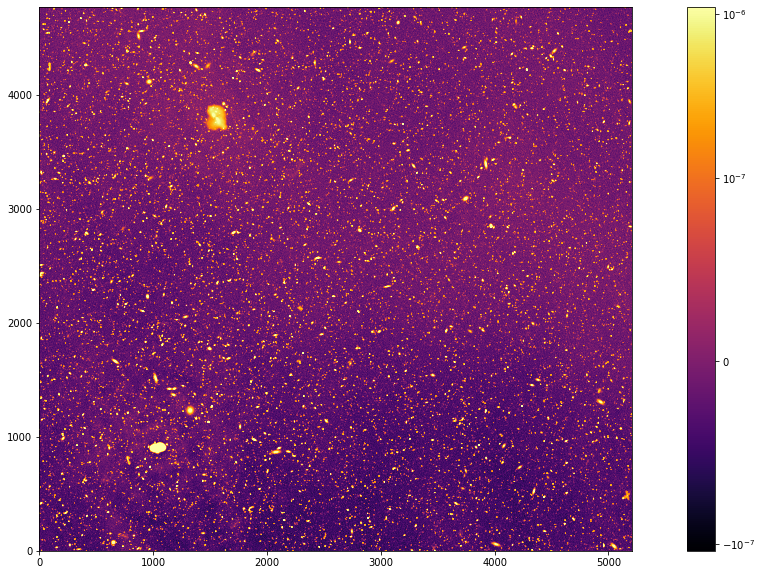

In [9]:
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LogNorm

# https://github.com/HorizonIITM/PythonForAstronomy/blob/master/FITS%20Handling/PythonforAstronomy3.ipynb
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h, origin='lower', norm=SymLogNorm(vmin=-1.1e-7, vmax=1.1e-6, linthresh=1e-7), cmap='inferno')
plt.savefig('before.png')
plt.colorbar()

---
**Exercise 3:** Display the 2 other image frequencies 
<br>
hint: For 'SymLogNorm' to set the its variables correctly, ask a postdoc 

@@ENG

In [10]:
# -- code here --



---

### Pre-processing
now we will do the following:
1) Preprocess images (correct PB)
2) crop out the training area for building ML model

---

improting some packges

In [11]:
from astropy.io import fits
# from astropy import units as u
# from MontagePy.main import mGetHdr, mProjectQL

from source.utils.image_utils import (
    crop_to_training_area,
    get_image_centre_coord,
    get_pixel_value_at_skycoord,
    save_subimage,
)

from source.pre.sdc1_image import Sdc1Image
from path import image_path, pb_path

---

first let us define a new image from the Sdc1Image in sdc1_image.py, and also the frequencies

In [12]:
def preprocess(image):
    """
    Perform preprocessing steps:
        1) Create PB-corrected image (image.pb_corr_image)
        2) Output separate training image (image.train)
    """
    image._prep = False
    image._create_pb_corr()
    image._create_train() # cropping the data
    image._prep = True

In [15]:
freq = 1400

In [16]:
new_image = Sdc1Image(freq, image_path(freq), pb_path(freq))
preprocess(new_image) 

 [astropy.io.fits.verify]


### now let is visualise the ouput images:
- corrected image
- trained area image

first let us see the path for both images

---

In this section we show the corrected image before and after

In [17]:
img1400_1000h_corrected = fits.getdata(new_image.pb_corr_image, ext=0)
print(img1400_1000h_corrected.shape)


(1, 1, 4776, 5204)


In [18]:
img1400_1000h_corrected = img1400_1000h_corrected.reshape(img1400_1000h_corrected.shape[2:])
print(img1400_1000h_corrected.shape)

(4776, 5204)


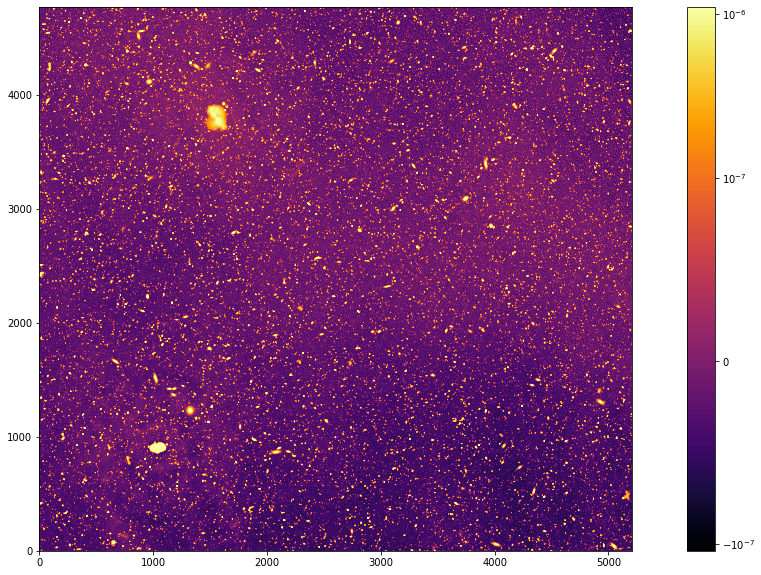

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h_corrected, origin='lower', norm=SymLogNorm(vmin=-1.1e-7, vmax=1.1e-6, linthresh=1e-7), cmap='inferno')
plt.savefig('after.png')
plt.colorbar()

---

In [27]:
import imageio
def make_mov(fnames=[],output='animation.gif',fps=4):
        
    with imageio.get_writer(output, mode='I', fps=fps) as writer:
        for file in fnames:
            image = imageio.imread(file)
            writer.append_data(image)
            
make_mov(fnames=['before.png','after.png'],output='difference.gif',fps=4)   

/tmp/ipykernel_90782/4196645298.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


<img src="difference.gif" width="2000" height="1000">

@@@ add explination here, and now you can spot the diff

---

In this section we show the cropped image (training area)

In [33]:
img1400_1000h_train = fits.getdata(new_image.train, ext=0)
img1400_1000h_train = img1400_1000h_train.reshape(img1400_1000h_train.shape[2:])

print(img1400_1000h_train.shape)


(3184, 3469)


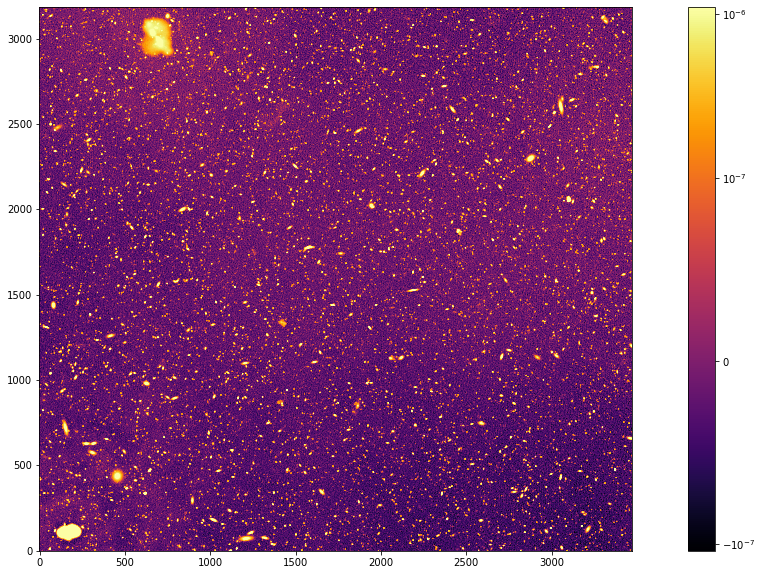

In [34]:
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h_train, origin='lower', norm=SymLogNorm(vmin=-1.1e-7, vmax=1.1e-6, linthresh=1e-7), cmap='inferno')
plt.savefig('after.png')
plt.colorbar()

---

### Source finding

In [35]:
from source.utils.source_finder import SourceFinder
from path import write_df_to_disk, train_source_df_path

---

now let us do source finding on the training 

In [36]:
sources_training = {}
source_finder = SourceFinder(new_image.train)
sl_df = source_finder.run()

sources_training[new_image.freq] = sl_df

# (Optional) Write source list DataFrame to disk
write_df_to_disk(sl_df, train_source_df_path(new_image.freq))

# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_train.fits'
Image size .............................. : (3469, 3184) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees


data/sample_images


Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.034 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (6.40e-08, 1.38e-05) Jy/beam
Min/max values of background mean map ... : (-5.79e-08, 9.85e-06) Jy/beam
Minimum number of pixels per island ..... : 6
Number of i

Fitting islands with Gaussians .......... : [|] 0/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/

stty: 

Fitting islands with Gaussians .......... : [/] 1/6636/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 1/6636--Fitting islands with Gaussians .......... : [-] 2/6636\|Fitting islands with Gaussians .......... : [-] 2/6636Fitting islands with Gaussians .......... : [-] 2/6636/-Fitting islands with Gaussians .......... : [|] 4/6636Fitting islands with Gaussians .......... : [\] 3/6636--\Fitting islands with Gaussians .......... : [/] 5/6636|Fitting islands with Gaussians .......... : [-] 6/6636Fitting islands with Gaussians .......... : [-] 6/6636Fitting islands with Gaussians .......... : [\] 7/6636Fitting islands with Gaussians .......... : [-] 6/6636-||/Fitting islands with Gaussians .......... : [|] 8/6636Fitting islands with Gaussians .......... : [-] 10/6636Fitting islands with Gaussians .......... : [|] 12/6636\Fitting islands with Gaussians .......... : [|] 12/6636\Fitting islands with Gaussians .......... : [/] 13/6636||/Fitting islands with Gaussians .......... : [\] 15/6636Fitting islands with Gaussians .......... : [\] 15/6636Fi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 19/6636Fitting islands with Gaussians .......... : [/] 21/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [/] 21/6636Fitting islands with Gaussians .......... : [/] 21/6636Fitting islands with Gaussians .......... : [-] 22/6636--Fitting islands with Gaussians .......... : [|] 24/6636Fitting islands with Gaussians .......... : [\] 23/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [-] 26/6636--Fitting islands with Gaussians .......... : [-] 26/6636Fitting islands with Gaussians .......... : [/] 29/6636Fitting islands with Gaussians .......... : [|] 28/6636\//Fitting islands with Gaussians .......... : [-] 30/6636/Fitting islands with Gaussians .......... : [-] 30/6636-Fitting islands with Gaussians .......... : [/] 33/6636Fitting islands with Gaussians .......... : [/] 33/6636Fitting islands with Gaussians .......... : [\] 31/6636\Fitting islands with Gaussians .......... : [/] 33/6636--\\Fitting islands with Gaussians .......... : [-] 34/6636|Fitting islands with Gaussians .......... : [\] 35/6636Fitting islands with Gaussians .......... : [\] 39/6636Fitting islands with Gaussians .......... : [-] 38/6636Fitting islands with Gaussians .......... : [-] 37/6636-|Fitting islands with Gaussians .......... : [\] 39/6636|/Fitting islands with Gaussians .......... : [|] 40/6636-Fitting islands with Gaussians .......... : [

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 47/6636Fitting islands with Gaussians .......... : [-] 46/6636||Fitting islands with Gaussians .......... : [-] 50/6636

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 50/6636Fitting islands with Gaussians .......... : [|] 52/6636Fitting islands with Gaussians .......... : [|] 52/6636---||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 54/6636Fitting islands with Gaussians .......... : [-] 54/6636Fitting islands with Gaussians .......... : [-] 54/6636-Fitting islands with Gaussians .......... : [|] 56/6636Fitting islands with Gaussians .......... : [|] 56/6636\\\//Fitting islands with Gaussians .......... : [-] 58/6636Fitting islands with Gaussians .......... : [\] 59/6636Fitting islands with Gaussians .......... : [\] 59/6636Fitting islands with Gaussians .......... : [\] 59/6636-Fitting islands with Gaussians .......... : [/] 61/6636||/Fitting islands with Gaussians .......... : [/] 61/6636-\\Fitting islands with Gaussians .......... : [-] 62/6636Fitting islands with Gaussians .......... : [|] 64/6636|Fitting islands with Gaussians .......... : [|] 63/6636Fitting islands with Gaussians .......... : [/] 65/6636/Fitting islands with Gaussians .......... : [-] 66/6636-|Fitting islands with Gaussians .......... : [\] 67/6636Fitting islands with Gaussians .......... : [|] 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 75/6636/Fitting islands with Gaussians .......... : [/] 77/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 80/6636\Fitting islands with Gaussians .......... : [-] 78/6636Fitting islands with Gaussians .......... : [|] 80/6636|Fitting islands with Gaussians .......... : [|] 80/6636Fitting islands with Gaussians .......... : [/] 81/6636-\Fitting islands with Gaussians .......... : [\] 83/6636Fitting islands with Gaussians .......... : [-] 82/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-|Fitting islands with Gaussians .......... : [|] 84/6636-\Fitting islands with Gaussians .......... : [-] 86/6636Fitting islands with Gaussians .......... : [\] 87/6636Fitting islands with Gaussians .......... : [|] 88/6636Fitting islands with Gaussians .......... : [-] 90/6636Fitting islands with Gaussians .......... : [|] 88/6636--|Fitting islands with Gaussians .......... : [-] 90/6636||/Fitting islands with Gaussians .......... : [\] 91/6636Fitting islands with Gaussians .......... : [-] 94/6636Fitting islands with Gaussians .......... : [-] 94/6636Fitting islands with Gaussians .......... : [|] 96/6636Fitting islands with Gaussians .......... : [|] 96/6636-Fitting islands with Gaussians .......... : [/] 97/6636Fitting islands with Gaussians .......... : [|] 96/6636|//\\\Fitting islands with Gaussians .......... : [-] 98/6636Fitting islands with Gaussians .......... : [|] 100/6636Fitting islands with Gaussians .......... : [/] 101/6636Fitting islands with Gaussians .......... : [

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 110/6636Fitting islands with Gaussians .......... : [/] 113/6636Fitting islands with Gaussians .......... : [-] 114/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 111/6636Fitting islands with Gaussians .......... : [/] 113/6636\\Fitting islands with Gaussians .......... : [|] 116/6636Fitting islands with Gaussians .......... : [\] 115/6636//Fitting islands with Gaussians .......... : [/] 117/6636Fitting islands with Gaussians .......... : [\] 119/6636-\Fitting islands with Gaussians .......... : [\] 119/6636//-Fitting islands with Gaussians .......... : [/] 120/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 122/6636Fitting islands with Gaussians .......... : [/] 121/6636Fitting islands with Gaussians .......... : [\] 123/6636Fitting islands with Gaussians .......... : [/] 125/6636|/\Fitting islands with Gaussians .......... : [/] 125/6636\\Fitting islands with Gaussians .......... : [-] 126/6636//Fitting islands with Gaussians .......... : [\] 131/6636Fitting islands with Gaussians .......... : [\] 131/6636-Fitting islands with Gaussians .......... : [|] 128/6636Fitting islands with Gaussians .......... : [/] 129/6636Fitting islands with Gaussians .......... : [\] 131/6636||/Fitting islands with Gaussians .......... : [/] 133/6636-Fitting islands with Gaussians .......... : [-] 134/6636Fitting islands with Gaussians .......... : [/] 133/6636|Fitting islands with Gaussians .......... : [|] 136/6636|Fitting islands with Gaussians .......... : [|] 136/6636/Fitting islands with Gaussians .......... : [-] 138/6636\Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 150/6636

stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 151/6636|Fitting islands with Gaussians .......... : [/] 153/6636Fitting islands with Gaussians .......... : [/] 153/6636-Fitting islands with Gaussians .......... : [-] 154/6636-\Fitting islands with Gaussians .......... : [\] 155/6636|Fitting islands with Gaussians .......... : [|] 156/6636Fitting islands with Gaussians .......... : [-] 158/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 158/6636-Fitting islands with Gaussians .......... : [\] 159/6636Fitting islands with Gaussians .......... : [|] 160/6636///Fitting islands with Gaussians .......... : [-] 162/6636--Fitting islands with Gaussians .......... : [/] 165/6636\Fitting islands with Gaussians .......... : [/] 161/6636Fitting islands with Gaussians .......... : [/] 165/6636|//Fitting islands with Gaussians .......... : [-] 166/6636Fitting islands with Gaussians .......... : [/] 165/6636Fitting islands with Gaussians .......... : [-] 166/6636Fitting islands with Gaussians .......... : [\] 167/6636\|Fitting islands with Gaussians .......... : [|] 168/6636Fitting islands with Gaussians .......... : [/] 170/6636|/-\Fitting islands with Gaussians .......... : [|] 173/6636Fitting islands with Gaussians .......... : [/] 170/6636Fitting islands with Gaussians .......... : [|] 173/6636Fitting islands with Gaussians .......... : [\] 172/6636-Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 185/6636Fitting islands with Gaussians .......... : [/] 186/6636Fitting islands with Gaussians .......... : [|] 185/6636

stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 188/6636-Fitting islands with Gaussians .......... : [\] 188/6636\Fitting islands with Gaussians .......... : [|] 189/6636|Fitting islands with Gaussians .......... : [/] 190/6636/-Fitting islands with Gaussians .......... : [\] 192/6636Fitting islands with Gaussians .......... : [\] 188/6636\Fitting islands with Gaussians .......... : [|] 193/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 191/6636||Fitting islands with Gaussians .......... : [/] 194/6636Fitting islands with Gaussians .......... : [-] 195/6636/\\|Fitting islands with Gaussians .......... : [|] 197/6636Fitting islands with Gaussians .......... : [|] 197/6636Fitting islands with Gaussians .......... : [\] 200/6636Fitting islands with Gaussians .......... : [\] 196/6636Fitting islands with Gaussians .......... : [\] 200/6636-||\Fitting islands with Gaussians .......... : [/] 199/6636/Fitting islands with Gaussians .......... : [|] 201/6636-Fitting islands with Gaussians .......... : [-] 204/6636Fitting islands with Gaussians .......... : [|] 205/6636\|Fitting islands with Gaussians .......... : [/] 206/6636Fitting islands with Gaussians .......... : [|] 205/6636/Fitting islands with Gaussians .......... : [\] 204/6636-Fitting islands with Gaussians .......... : [-] 207/6636||Fitting islands with Gaussians .......... : [\] 208/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 220/6636|-Fitting islands with Gaussians .......... : [-] 222/6636-Fitting islands with Gaussians .......... : [/] 221/6636Fitting islands with Gaussians .......... : [\] 223/6636\|Fitting islands with Gaussians .......... : [\] 223/6636|Fitting islands with Gaussians .......... : [-] 226/6636Fitting islands with Gaussians .......... : [|] 224/6636//Fitting islands with Gaussians .......... : [-] 226/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 227/6636Fitting islands with Gaussians .......... : [|] 228/6636\|Fitting islands with Gaussians .......... : [/] 230/6636Fitting islands with Gaussians .......... : [/] 230/6636Fitting islands with Gaussians .......... : [|] 228/6636/||Fitting islands with Gaussians .......... : [\] 232/6636Fitting islands with Gaussians .......... : [|] 233/6636Fitting islands with Gaussians .......... : [-] 231/6636/Fitting islands with Gaussians .......... : [|] 237/6636Fitting islands with Gaussians .......... : [/] 234/6636\\Fitting islands with Gaussians .......... : [|] 237/6636---|Fitting islands with Gaussians .......... : [\] 240/6636Fitting islands with Gaussians .......... : [/] 238/6636Fitting islands with Gaussians .......... : [-] 243/6636|Fitting islands with Gaussians .......... : [\] 240/6636||Fitting islands with Gaussians .......... : [-] 243/6636Fitting islands with Gaussians .......... : [|] 241/6636Fitting islands with Gaussians ..

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 257/6636Fitting islands with Gaussians .......... : [|] 257/6636Fitting islands with Gaussians .......... : [-] 259/6636-|--Fitting islands with Gaussians .......... : [-] 259/6636Fitting islands with Gaussians .......... : [\] 256/6636\Fitting islands with Gaussians .......... : [-] 263/6636|/Fitting islands with Gaussians .......... : [|] 261/6636Fitting islands with Gaussians .......... : [-] 263/6636Fitting islands with Gaussians .......... : [-] 263/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\|Fitting islands with Gaussians .......... : [\] 264/6636Fitting islands with Gaussians .......... : [/] 266/6636/Fitting islands with Gaussians .......... : [|] 268/6636Fitting islands with Gaussians .......... : [\] 268/6636Fitting islands with Gaussians .......... : [|] 265/6636Fitting islands with Gaussians .......... : [|] 268/6636\|//-Fitting islands with Gaussians .......... : [/] 269/6636\Fitting islands with Gaussians .......... : [/] 273/6636Fitting islands with Gaussians .......... : [|] 272/6636Fitting islands with Gaussians .......... : [/] 273/6636/-/Fitting islands with Gaussians .......... : [\] 271/6636Fitting islands with Gaussians .......... : [-] 274/6636\Fitting islands with Gaussians .......... : [\] 275/6636Fitting islands with Gaussians .......... : [-] 278/6636|Fitting islands with Gaussians .......... : [/] 277/6636Fitting islands with Gaussians .......... : [/] 277/6636\\Fitting islands with Gaussians .......... : [|] 280/6636//Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 288/6636\|Fitting islands with Gaussians .......... : [-] 290/6636/Fitting islands with Gaussians .......... : [|] 292/6636\Fitting islands with Gaussians .......... : [\] 291/6636\Fitting islands with Gaussians .......... : [\] 291/6636Fitting islands with Gaussians .......... : [/] 293/6636|Fitting islands with Gaussians .......... : [\] 295/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 296/6636Fitting islands with Gaussians .......... : [\] 295/6636\|/Fitting islands with Gaussians .......... : [/] 297/6636Fitting islands with Gaussians .......... : [\] 299/6636-Fitting islands with Gaussians .......... : [|] 300/6636Fitting islands with Gaussians .......... : [\] 299/6636\|Fitting islands with Gaussians .......... : [/] 301/6636/Fitting islands with Gaussians .......... : [\] 303/6636-Fitting islands with Gaussians .......... : [-] 302/6636Fitting islands with Gaussians .......... : [|] 304/6636\Fitting islands with Gaussians .......... : [/] 305/6636|Fitting islands with Gaussians .......... : [-] 306/6636/-Fitting islands with Gaussians .......... : [\] 307/6636-\Fitting islands with Gaussians .......... : [|] 308/6636|Fitting islands with Gaussians .......... : [-] 309/6636|Fitting islands with Gaussians .......... : [/] 309/6636Fitting islands with Gaussians .......... : [\] 310/6636/Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 312/6636--Fitting islands with Gaussians .......... : [|] 315/6636Fitting islands with Gaussians .......... : [|] 315/6636Fitting islands with Gaussians .......... : [|] 315/6636Fitting islands with Gaussians .......... : [-] 317/6636|/-\\Fitting islands with Gaussians .......... : [-] 317/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 320/6636Fitting islands with Gaussians .......... : [|] 319/6636Fitting islands with Gaussians .......... : [-] 321/6636|Fitting islands with Gaussians .......... : [\] 322/6636/Fitting islands with Gaussians .......... : [\] 322/6636\\||Fitting islands with Gaussians .......... : [|] 323/6636Fitting islands with Gaussians .......... : [\] 326/6636Fitting islands with Gaussians .......... : [/] 324/6636-Fitting islands with Gaussians .......... : [\] 326/6636\Fitting islands with Gaussians .......... : [|] 327/6636Fitting islands with Gaussians .......... : [|] 327/6636\//|Fitting islands with Gaussians .......... : [-] 329/6636Fitting islands with Gaussians .......... : [\] 330/6636Fitting islands with Gaussians .......... : [\] 330/6636-Fitting islands with Gaussians .......... : [/] 333/6636\/Fitting islands with Gaussians .......... : [/] 333/6636/Fitting islands with Gaussians .......... : [|] 333/6636-\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 343/6636Fitting islands with Gaussians .......... : [-] 342/6636\|Fitting islands with Gaussians .......... : [/] 345/6636Fitting islands with Gaussians .......... : [|] 344/6636Fitting islands with Gaussians .......... : [-] 346/6636--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 348/6636Fitting islands with Gaussians .......... : [\] 347/6636|/Fitting islands with Gaussians .......... : [-] 350/6636Fitting islands with Gaussians .......... : [\] 351/6636Fitting islands with Gaussians .......... : [-] 350/6636-\|Fitting islands with Gaussians .......... : [|] 352/6636Fitting islands with Gaussians .......... : [/] 353/6636Fitting islands with Gaussians .......... : [-] 354/6636/\\Fitting islands with Gaussians .......... : [\] 355/6636Fitting islands with Gaussians .......... : [|] 356/6636\Fitting islands with Gaussians .......... : [/] 357/6636/Fitting islands with Gaussians .......... : [\] 359/6636-/\Fitting islands with Gaussians .......... : [\] 359/6636Fitting islands with Gaussians .......... : [-] 362/6636|Fitting islands with Gaussians .......... : [\] 359/6636-Fitting islands with Gaussians .......... : [\] 363/6636Fitting islands with Gaussians .......... : [/] 361/6636Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 373/6636|-Fitting islands with Gaussians .......... : [-] 374/6636\Fitting islands with Gaussians .......... : [|] 376/6636-Fitting islands with Gaussians .......... : [|] 376/6636Fitting islands with Gaussians .......... : [-] 379/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|--Fitting islands with Gaussians .......... : [\] 380/6636Fitting islands with Gaussians .......... : [\] 380/6636Fitting islands with Gaussians .......... : [-] 379/6636Fitting islands with Gaussians .......... : [|] 381/6636\//-Fitting islands with Gaussians .......... : [-] 383/6636Fitting islands with Gaussians .......... : [-] 383/6636Fitting islands with Gaussians .......... : [/] 386/6636Fitting islands with Gaussians .......... : [\] 384/6636||Fitting islands with Gaussians .......... : [-] 387/6636/Fitting islands with Gaussians .......... : [/] 386/6636-|-|Fitting islands with Gaussians .......... : [|] 389/6636Fitting islands with Gaussians .......... : [/] 390/6636/Fitting islands with Gaussians .......... : [|] 389/6636-Fitting islands with Gaussians .......... : [-] 391/6636Fitting islands with Gaussians .......... : [|] 393/6636Fitting islands with Gaussians .......... : [|] 393/6636|Fitting islands with Gaussians .......... : [-] 391/6636|/Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 406/6636|||Fitting islands with Gaussians .......... : [-] 407/6636Fitting islands with Gaussians .......... : [|] 409/6636Fitting islands with Gaussians .......... : [-] 411/6636--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 413/6636\Fitting islands with Gaussians .......... : [|] 413/6636|Fitting islands with Gaussians .......... : [|] 409/6636Fitting islands with Gaussians .......... : [|] 413/6636/Fitting islands with Gaussians .......... : [-] 415/6636\Fitting islands with Gaussians .......... : [\] 416/6636Fitting islands with Gaussians .......... : [-] 415/6636\Fitting islands with Gaussians .......... : [|] 417/6636Fitting islands with Gaussians .......... : [/] 418/6636//Fitting islands with Gaussians .......... : [\] 420/6636/\\Fitting islands with Gaussians .......... : [\] 420/6636|/Fitting islands with Gaussians .......... : [/] 423/6636Fitting islands with Gaussians .......... : [/] 423/6636-Fitting islands with Gaussians .......... : [\] 426/6636\Fitting islands with Gaussians .......... : [/] 423/6636Fitting islands with Gaussians .......... : [|] 426/6636|-Fitting islands with Gaussians .......... : [/] 427/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 442/6636Fitting islands with Gaussians .......... : [/] 444/6636Fitting islands with Gaussians .......... : [\] 441/6636/Fitting islands with Gaussians .......... : [/] 444/6636Fitting islands with Gaussians .......... : [\] 446/6636Fitting islands with Gaussians .......... : [\] 446/6636--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [/] 448/6636Fitting islands with Gaussians .......... : [-] 449/6636Fitting islands with Gaussians .......... : [-] 449/6636Fitting islands with Gaussians .......... : [|] 451/6636|Fitting islands with Gaussians .......... : [/] 452/6636||Fitting islands with Gaussians .......... : [/] 452/6636//Fitting islands with Gaussians .......... : [|] 455/6636Fitting islands with Gaussians .......... : [|] 455/6636Fitting islands with Gaussians .......... : [|] 455/6636-||/Fitting islands with Gaussians .......... : [/] 456/6636Fitting islands with Gaussians .......... : [/] 456/6636Fitting islands with Gaussians .......... : [-] 457/6636\\|Fitting islands with Gaussians .......... : [|] 459/6636Fitting islands with Gaussians .......... : [/] 460/6636Fitting islands with Gaussians .......... : [|] 459/6636Fitting islands with Gaussians .......... : [\] 462/6636Fitting islands with Gaussians .......... : [|] 463/6636Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [|] 475/6636/Fitting islands with Gaussians .......... : [/] 476/6636--Fitting islands with Gaussians .......... : [\] 478/6636Fitting islands with Gaussians .......... : [|] 479/6636\Fitting islands with Gaussians .......... : [-] 477/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 481/6636Fitting islands with Gaussians .......... : [/] 480/6636/-Fitting islands with Gaussians .......... : [-] 481/6636-\Fitting islands with Gaussians .......... : [\] 482/6636|Fitting islands with Gaussians .......... : [/] 484/6636/Fitting islands with Gaussians .......... : [/] 484/6636\\Fitting islands with Gaussians .......... : [-] 485/6636Fitting islands with Gaussians .......... : [-] 485/6636Fitting islands with Gaussians .......... : [|] 487/6636Fitting islands with Gaussians .......... : [\] 486/6636|Fitting islands with Gaussians .......... : [/] 488/6636--Fitting islands with Gaussians .......... : [\] 490/6636Fitting islands with Gaussians .......... : [\] 490/6636\|Fitting islands with Gaussians .......... : [|] 492/6636Fitting islands with Gaussians .......... : [-] 493/6636|--\Fitting islands with Gaussians .......... : [-] 493/6636Fitting islands with Gaussians .......... : [\] 494/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 509/6636/||-Fitting islands with Gaussians .......... : [-] 511/6636Fitting islands with Gaussians .......... : [-] 511/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 514/6636Fitting islands with Gaussians .......... : [|] 514/6636Fitting islands with Gaussians .......... : [/] 514/6636|\\\Fitting islands with Gaussians .......... : [-] 515/6636\Fitting islands with Gaussians .......... : [|] 517/6636|/Fitting islands with Gaussians .......... : [\] 520/6636-\Fitting islands with Gaussians .......... : [|] 521/6636Fitting islands with Gaussians .......... : [\] 520/6636Fitting islands with Gaussians .......... : [\] 520/6636Fitting islands with Gaussians .......... : [/] 522/6636Fitting islands with Gaussians .......... : [\] 520/6636---|Fitting islands with Gaussians .......... : [\] 524/6636Fitting islands with Gaussians .......... : [-] 523/6636//Fitting islands with Gaussians .......... : [-] 527/6636Fitting islands with Gaussians .......... : [-] 527/6636Fitting islands with Gaussians .......... : [-] 527/6636/\\Fitting islands with Gaussians .......... : [|] 529/6636|Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 546/6636Fitting islands with Gaussians .......... : [/] 547/6636Fitting islands with Gaussians .......... : [|] 546/6636Fitting islands with Gaussians .......... : [\] 549/6636\\\Fitting islands with Gaussians .......... : [|] 550/6636Fitting islands with Gaussians .......... : [\] 549/6636|Fitting islands with Gaussians .......... : [/] 547/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--\Fitting islands with Gaussians .......... : [\] 554/6636Fitting islands with Gaussians .......... : [\] 553/6636Fitting islands with Gaussians .......... : [\] 554/6636|Fitting islands with Gaussians .......... : [|] 554/6636Fitting islands with Gaussians .......... : [-] 556/6636Fitting islands with Gaussians .......... : [-] 556/6636/Fitting islands with Gaussians .......... : [\] 557/6636|-|/-Fitting islands with Gaussians .......... : [|] 558/6636Fitting islands with Gaussians .......... : [|] 562/6636Fitting islands with Gaussians .......... : [-] 560/6636Fitting islands with Gaussians .......... : [|] 562/6636Fitting islands with Gaussians .......... : [/] 559/6636|Fitting islands with Gaussians .......... : [/] 563/6636|-\-Fitting islands with Gaussians .......... : [-] 564/6636|Fitting islands with Gaussians .......... : [-] 568/6636/Fitting islands with Gaussians .......... : [|] 566/6636Fitting islands with Gaussians .......... : [|] 566/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 580/6636/Fitting islands with Gaussians .......... : [-] 581/6636Fitting islands with Gaussians .......... : [|] 578/6636-Fitting islands with Gaussians .......... : [|] 583/6636\Fitting islands with Gaussians .......... : [|] 583/6636Fitting islands with Gaussians .......... : [|] 582/6636//-Fitting islands with Gaussians .......... : [-] 585/6636Fitting islands with Gaussians .......... : [/] 584/6636\//Fitting islands with Gaussians .......... : [\] 586/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 588/6636Fitting islands with Gaussians .......... : [-] 589/6636Fitting islands with Gaussians .......... : [/] 589/6636Fitting islands with Gaussians .......... : [\] 590/6636|/Fitting islands with Gaussians .......... : [/] 592/6636-/\Fitting islands with Gaussians .......... : [/] 596/6636Fitting islands with Gaussians .......... : [/] 592/6636Fitting islands with Gaussians .......... : [|] 596/6636Fitting islands with Gaussians .......... : [-] 597/6636Fitting islands with Gaussians .......... : [/] 596/6636/Fitting islands with Gaussians .......... : [\] 598/6636-|\||Fitting islands with Gaussians .......... : [/] 600/6636/-Fitting islands with Gaussians .......... : [\] 601/6636Fitting islands with Gaussians .......... : [-] 601/6636Fitting islands with Gaussians .......... : [|] 603/6636\Fitting islands with Gaussians .......... : [|] 603/6636Fitting islands with Gaussians .......... : [|] 603/6636Fitting islands with Gaussians ...

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 616/6636Fitting islands with Gaussians .......... : [/] 616/6636Fitting islands with Gaussians .......... : [\] 619/6636-Fitting islands with Gaussians .......... : [\] 619/6636Fitting islands with Gaussians .......... : [\] 619/6636-Fitting islands with Gaussians .......... : [/] 616/6636|Fitting islands with Gaussians .......... : [|] 620/6636//--Fitting islands with Gaussians .......... : [-] 622/6636Fitting islands with Gaussians .......... : [-] 622/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 625/6636Fitting islands with Gaussians .......... : [|] 624/6636Fitting islands with Gaussians .......... : [/] 625/6636|/Fitting islands with Gaussians .......... : [-] 626/6636Fitting islands with Gaussians .......... : [-] 626/6636Fitting islands with Gaussians .......... : [\] 627/6636\-/\Fitting islands with Gaussians .......... : [/] 629/6636-Fitting islands with Gaussians .......... : [|] 628/6636|Fitting islands with Gaussians .......... : [/] 632/6636Fitting islands with Gaussians .......... : [-] 633/6636|Fitting islands with Gaussians .......... : [\] 631/6636Fitting islands with Gaussians .......... : [-] 633/6636Fitting islands with Gaussians .......... : [\] 631/6636--Fitting islands with Gaussians .......... : [|] 635/6636|/Fitting islands with Gaussians .......... : [|] 635/6636//-Fitting islands with Gaussians .......... : [-] 637/6636Fitting islands with Gaussians .......... : [-] 637/6636Fitting islands with Gaussians 

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|/Fitting islands with Gaussians .......... : [\] 650/6636Fitting islands with Gaussians .......... : [/] 652/6636\-Fitting islands with Gaussians .......... : [/] 652/6636Fitting islands with Gaussians .......... : [\] 654/6636Fitting islands with Gaussians .......... : [\] 654/6636//Fitting islands with Gaussians .......... : [/] 656/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 655/6636Fitting islands with Gaussians .......... : [/] 660/6636Fitting islands with Gaussians .......... : [-] 657/6636Fitting islands with Gaussians .......... : [\] 658/6636//Fitting islands with Gaussians .......... : [/] 660/6636Fitting islands with Gaussians .......... : [\] 662/6636-\-Fitting islands with Gaussians .......... : [\] 662/6636//Fitting islands with Gaussians .......... : [/] 665/6636Fitting islands with Gaussians .......... : [-] 666/6636Fitting islands with Gaussians .......... : [/] 665/6636Fitting islands with Gaussians .......... : [-] 666/6636-Fitting islands with Gaussians .......... : [\] 667/6636|Fitting islands with Gaussians .......... : [/] 669/6636/|Fitting islands with Gaussians .......... : [/] 669/6636\Fitting islands with Gaussians .......... : [-] 670/6636\Fitting islands with Gaussians .......... : [|] 672/6636//Fitting islands with Gaussians .......... : [|] 672/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 685/6636||Fitting islands with Gaussians .......... : [|] 688/6636Fitting islands with Gaussians .......... : [|] 688/6636Fitting islands with Gaussians .......... : [-] 690/6636-\Fitting islands with Gaussians .......... : [|] 692/6636\Fitting islands with Gaussians .......... : [\] 691/6636/Fitting islands with Gaussians .......... : [|] 692/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-\Fitting islands with Gaussians .......... : [\] 695/6636Fitting islands with Gaussians .......... : [-] 693/6636Fitting islands with Gaussians .......... : [\] 695/6636//Fitting islands with Gaussians .......... : [/] 697/6636Fitting islands with Gaussians .......... : [/] 697/6636-Fitting islands with Gaussians .......... : [\] 699/6636Fitting islands with Gaussians .......... : [-] 698/6636||/Fitting islands with Gaussians .......... : [/] 701/6636-Fitting islands with Gaussians .......... : [/] 701/6636\Fitting islands with Gaussians .......... : [/] 705/6636Fitting islands with Gaussians .......... : [|] 704/6636Fitting islands with Gaussians .......... : [-] 702/6636Fitting islands with Gaussians .......... : [|] 704/6636|-\||Fitting islands with Gaussians .......... : [\] 707/6636Fitting islands with Gaussians .......... : [\] 711/6636Fitting islands with Gaussians .......... : [-] 706/6636Fitting islands with Gaussians .......... : [-] 710/6636/\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 721/6636Fitting islands with Gaussians .......... : [|] 724/6636\Fitting islands with Gaussians .......... : [-] 726/6636/|/Fitting islands with Gaussians .......... : [-] 726/6636/-Fitting islands with Gaussians .......... : [\] 727/6636Fitting islands with Gaussians .......... : [/] 731/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 728/6636||/Fitting islands with Gaussians .......... : [/] 731/6636-Fitting islands with Gaussians .......... : [-] 732/6636\Fitting islands with Gaussians .......... : [/] 731/6636|Fitting islands with Gaussians .......... : [/] 735/6636Fitting islands with Gaussians .......... : [|] 734/6636Fitting islands with Gaussians .......... : [|] 734/6636Fitting islands with Gaussians .......... : [-] 736/6636|\\Fitting islands with Gaussians .......... : [\] 737/6636/-Fitting islands with Gaussians .......... : [\] 741/6636Fitting islands with Gaussians .......... : [|] 738/6636Fitting islands with Gaussians .......... : [\] 742/6636Fitting islands with Gaussians .......... : [|] 742/6636|-/-Fitting islands with Gaussians .......... : [-] 744/6636Fitting islands with Gaussians .......... : [/] 743/6636\|Fitting islands with Gaussians .......... : [|] 746/6636\Fitting islands with Gaussians .......... : [-] 748/6636/Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 760/6636-Fitting islands with Gaussians .......... : [-] 760/6636|/Fitting islands with Gaussians .......... : [\] 761/6636/Fitting islands with Gaussians .......... : [-] 764/6636Fitting islands with Gaussians .......... : [/] 763/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 767/6636|Fitting islands with Gaussians .......... : [/] 767/6636Fitting islands with Gaussians .......... : [|] 766/6636/\\\Fitting islands with Gaussians .......... : [|] 769/6636Fitting islands with Gaussians .......... : [-] 768/6636Fitting islands with Gaussians .......... : [|] 769/6636|Fitting islands with Gaussians .......... : [\] 772/6636Fitting islands with Gaussians .......... : [/] 770/6636/Fitting islands with Gaussians .......... : [\] 772/6636Fitting islands with Gaussians .......... : [\] 772/6636\/Fitting islands with Gaussians .......... : [/] 774/6636Fitting islands with Gaussians .......... : [|] 773/6636--||Fitting islands with Gaussians .......... : [-] 779/6636Fitting islands with Gaussians .......... : [\] 776/6636Fitting islands with Gaussians .......... : [-] 779/6636Fitting islands with Gaussians .......... : [/] 778/6636/\Fitting islands with Gaussians .......... : [|] 781/6636\\|Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 790/6636/Fitting islands with Gaussians .......... : [|] 793/6636-Fitting islands with Gaussians .......... : [|] 793/6636|Fitting islands with Gaussians .......... : [|] 793/6636Fitting islands with Gaussians .......... : [-] 791/6636|/-Fitting islands with Gaussians .......... : [/] 794/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 795/6636||Fitting islands with Gaussians .......... : [|] 797/6636/Fitting islands with Gaussians .......... : [|] 797/6636-Fitting islands with Gaussians .......... : [-] 799/6636Fitting islands with Gaussians .......... : [|] 801/6636Fitting islands with Gaussians .......... : [/] 798/6636||/Fitting islands with Gaussians .......... : [/] 802/6636-Fitting islands with Gaussians .......... : [|] 805/6636\Fitting islands with Gaussians .......... : [-] 803/6636/Fitting islands with Gaussians .......... : [|] 805/6636/Fitting islands with Gaussians .......... : [/] 806/6636Fitting islands with Gaussians .......... : [|] 801/6636-\|Fitting islands with Gaussians .......... : [/] 810/6636Fitting islands with Gaussians .......... : [/] 810/6636Fitting islands with Gaussians .......... : [-] 807/6636Fitting islands with Gaussians .......... : [\] 808/6636-Fitting islands with Gaussians .......... : [-] 811/6636-||Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 830/6636Fitting islands with Gaussians .......... : [-] 829/6636Fitting islands with Gaussians .......... : [\] 830/6636//Fitting islands with Gaussians .......... : [|] 831/6636Fitting islands with Gaussians .......... : [\] 834/6636|Fitting islands with Gaussians .......... : [\] 834/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [|] 839/6636Fitting islands with Gaussians .......... : [/] 836/6636Fitting islands with Gaussians .......... : [\] 834/6636Fitting islands with Gaussians .......... : [/] 836/6636|||/Fitting islands with Gaussians .......... : [/] 840/6636Fitting islands with Gaussians .......... : [|] 839/6636Fitting islands with Gaussians .......... : [|] 843/6636Fitting islands with Gaussians .......... : [|] 843/6636-Fitting islands with Gaussians .......... : [|] 843/6636-|/|Fitting islands with Gaussians .......... : [-] 845/6636Fitting islands with Gaussians .......... : [/] 844/6636Fitting islands with Gaussians .......... : [-] 845/6636Fitting islands with Gaussians .......... : [|] 847/6636-||/Fitting islands with Gaussians .......... : [/] 848/6636Fitting islands with Gaussians .......... : [|] 847/6636Fitting islands with Gaussians .......... : [|] 851/6636-Fitting islands with Gaussians .......... : [-] 849/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 863/6636|Fitting islands with Gaussians .......... : [|] 863/6636-Fitting islands with Gaussians .......... : [/] 864/6636--Fitting islands with Gaussians .......... : [\] 866/6636Fitting islands with Gaussians .......... : [|] 867/6636Fitting islands with Gaussians .......... : [-] 865/6636||Fitting islands with Gaussians .......... : [-] 869/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

\\\Fitting islands with Gaussians .......... : [-] 869/6636Fitting islands with Gaussians .......... : [-] 869/6636/Fitting islands with Gaussians .......... : [\] 873/6636Fitting islands with Gaussians .......... : [|] 871/6636-Fitting islands with Gaussians .......... : [\] 873/6636-Fitting islands with Gaussians .......... : [|] 871/6636Fitting islands with Gaussians .......... : [\] 873/6636||Fitting islands with Gaussians .......... : [/] 875/6636/-Fitting islands with Gaussians .......... : [-] 876/6636Fitting islands with Gaussians .......... : [|] 878/6636Fitting islands with Gaussians .......... : [-] 876/6636Fitting islands with Gaussians .......... : [|] 878/6636\/--Fitting islands with Gaussians .......... : [-] 880/6636Fitting islands with Gaussians .......... : [/] 879/6636|Fitting islands with Gaussians .......... : [/] 883/6636|Fitting islands with Gaussians .......... : [\] 881/6636Fitting islands with Gaussians .......... : [-] 884/6636|/\Fitting islands with Gaussian

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [\] 893/6636-Fitting islands with Gaussians .......... : [-] 896/6636-Fitting islands with Gaussians .......... : [|] 894/6636Fitting islands with Gaussians .......... : [|] 898/6636|Fitting islands with Gaussians .......... : [\] 897/6636///Fitting islands with Gaussians .......... : [-] 900/6636-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 900/6636Fitting islands with Gaussians .......... : [|] 902/6636Fitting islands with Gaussians .......... : [/] 903/6636|Fitting islands with Gaussians .......... : [-] 904/6636/Fitting islands with Gaussians .......... : [/] 903/6636\||Fitting islands with Gaussians .......... : [/] 903/6636Fitting islands with Gaussians .......... : [|] 906/6636/Fitting islands with Gaussians .......... : [\] 905/6636Fitting islands with Gaussians .......... : [/] 907/6636Fitting islands with Gaussians .......... : [|] 910/6636\Fitting islands with Gaussians .......... : [\] 909/6636///Fitting islands with Gaussians .......... : [|] 910/6636-\Fitting islands with Gaussians .......... : [/] 911/6636Fitting islands with Gaussians .......... : [\] 913/6636Fitting islands with Gaussians .......... : [/] 915/6636Fitting islands with Gaussians .......... : [-] 916/6636/Fitting islands with Gaussians .......... : [/] 915/6636Fitting islands with Gaussians ....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-|/Fitting islands with Gaussians .......... : [\] 930/6636Fitting islands with Gaussians .......... : [|] 931/6636Fitting islands with Gaussians .......... : [-] 933/6636-Fitting islands with Gaussians .......... : [-] 933/6636Fitting islands with Gaussians .......... : [\] 934/6636||Fitting islands with Gaussians .......... : [|] 935/6636-Fitting islands with Gaussians .......... : [-] 937/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 936/6636-Fitting islands with Gaussians .......... : [|] 939/6636|Fitting islands with Gaussians .......... : [|] 939/6636|//Fitting islands with Gaussians .......... : [-] 941/6636-Fitting islands with Gaussians .......... : [|] 943/6636Fitting islands with Gaussians .......... : [-] 941/6636Fitting islands with Gaussians .......... : [/] 944/6636Fitting islands with Gaussians .......... : [/] 944/6636/Fitting islands with Gaussians .......... : [|] 943/6636//-Fitting islands with Gaussians .......... : [-] 945/6636||Fitting islands with Gaussians .......... : [/] 948/6636/Fitting islands with Gaussians .......... : [/] 948/6636-Fitting islands with Gaussians .......... : [-] 949/6636Fitting islands with Gaussians .......... : [/] 948/6636\Fitting islands with Gaussians .......... : [|] 951/6636//Fitting islands with Gaussians .......... : [/] 952/6636Fitting islands with Gaussians .......... : [|] 951/6636\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 967/6636|/Fitting islands with Gaussians .......... : [\] 971/6636Fitting islands with Gaussians .......... : [\] 971/6636Fitting islands with Gaussians .......... : [\] 971/6636Fitting islands with Gaussians .......... : [-] 971/6636\\Fitting islands with Gaussians .......... : [-] 971/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [\] 975/6636Fitting islands with Gaussians .......... : [/] 973/6636Fitting islands with Gaussians .......... : [|] 972/6636\Fitting islands with Gaussians .......... : [\] 975/6636/Fitting islands with Gaussians .......... : [-] 978/6636Fitting islands with Gaussians .......... : [/] 977/6636Fitting islands with Gaussians .......... : [-] 978/6636-Fitting islands with Gaussians .......... : [\] 979/6636\Fitting islands with Gaussians .......... : [/] 981/6636\/Fitting islands with Gaussians .......... : [-] 982/6636Fitting islands with Gaussians .......... : [\] 984/6636-\\|Fitting islands with Gaussians .......... : [/] 986/6636Fitting islands with Gaussians .......... : [\] 984/6636/-Fitting islands with Gaussians .......... : [-] 987/6636Fitting islands with Gaussians .......... : [\] 988/6636Fitting islands with Gaussians .......... : [|] 989/6636Fitting islands with Gaussians .......... : [\] 988/6636\//Fitting islands with Gaussians 

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 1002/6636Fitting islands with Gaussians .......... : [\] 1005/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 1001/6636Fitting islands with Gaussians .......... : [/] 1007/6636||Fitting islands with Gaussians .......... : [\] 1005/6636Fitting islands with Gaussians .......... : [-] 1008/6636|--Fitting islands with Gaussians .......... : [|] 1010/6636Fitting islands with Gaussians .......... : [|] 1010/6636\Fitting islands with Gaussians .......... : [|] 1010/6636Fitting islands with Gaussians .......... : [-] 1012/6636//Fitting islands with Gaussians .......... : [-] 1012/6636\\Fitting islands with Gaussians .......... : [\] 1013/6636Fitting islands with Gaussians .......... : [/] 1015/6636Fitting islands with Gaussians .......... : [\] 1017/6636Fitting islands with Gaussians .......... : [/] 1015/6636|///\Fitting islands with Gaussians .......... : [\] 1017/6636\Fitting islands with Gaussians .......... : [/] 1019/6636Fitting islands with Gaussians .......... : [|] 1018/6636|/Fitting islands with Gaussians .......... : [/] 1019/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 1030/6636|//Fitting islands with Gaussians .......... : [/] 1031/6636Fitting islands with Gaussians .......... : [\] 1029/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

-Fitting islands with Gaussians .......... : [|] 1034/6636Fitting islands with Gaussians .......... : [|] 1034/6636Fitting islands with Gaussians .......... : [/] 1035/6636||Fitting islands with Gaussians .......... : [/] 1035/6636-Fitting islands with Gaussians .......... : [|] 1034/6636-Fitting islands with Gaussians .......... : [-] 1036/6636Fitting islands with Gaussians .......... : [|] 1038/6636\/Fitting islands with Gaussians .......... : [|] 1038/6636/\\Fitting islands with Gaussians .......... : [/] 1043/6636Fitting islands with Gaussians .......... : [-] 1040/6636Fitting islands with Gaussians .......... : [\] 1045/6636Fitting islands with Gaussians .......... : [-] 1040/6636Fitting islands with Gaussians .......... : [\] 1041/6636Fitting islands with Gaussians .......... : [/] 1043/6636|Fitting islands with Gaussians .......... : [\] 1045/6636/\||\Fitting islands with Gaussians .......... : [|] 1046/6636/|Fitting islands with Gaussians .......... : [/] 1047/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 1060/6636Fitting islands with Gaussians .......... : [\] 1061/6636-\|Fitting islands with Gaussians .......... : [|] 1062/6636Fitting islands with Gaussians .......... : [|] 1062/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1064/6636Fitting islands with Gaussians .......... : [/] 1063/6636\Fitting islands with Gaussians .......... : [\] 1065/6636Fitting islands with Gaussians .......... : [|] 1067/6636-\/Fitting islands with Gaussians .......... : [/] 1067/6636\|Fitting islands with Gaussians .......... : [\] 1069/6636Fitting islands with Gaussians .......... : [\] 1073/6636Fitting islands with Gaussians .......... : [-] 1072/6636Fitting islands with Gaussians .......... : [\] 1073/6636Fitting islands with Gaussians .......... : [/] 1071/6636//\\|Fitting islands with Gaussians .......... : [|] 1074/6636Fitting islands with Gaussians .......... : [/] 1076/6636--Fitting islands with Gaussians .......... : [\] 1078/6636Fitting islands with Gaussians .......... : [\] 1078/6636Fitting islands with Gaussians .......... : [/] 1076/6636\|//Fitting islands with Gaussians .......... : [-] 1081/6636Fitting islands with Gaussians .......... : [-] 1081/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1092/6636--Fitting islands with Gaussians .......... : [/] 1096/6636Fitting islands with Gaussians .......... : [-] 1096/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 1097/6636Fitting islands with Gaussians .......... : [-] 1100/6636Fitting islands with Gaussians .......... : [-] 1100/6636///-Fitting islands with Gaussians .......... : [|] 1102/6636\Fitting islands with Gaussians .......... : [/] 1104/6636Fitting islands with Gaussians .......... : [/] 1104/6636Fitting islands with Gaussians .......... : [-] 1105/6636Fitting islands with Gaussians .......... : [/] 1104/6636|/-\Fitting islands with Gaussians .......... : [/] 1109/6636Fitting islands with Gaussians .......... : [\] 1106/6636Fitting islands with Gaussians .......... : [|] 1107/6636Fitting islands with Gaussians .......... : [\] 1110/6636//\\Fitting islands with Gaussians .......... : [-] 1109/6636|Fitting islands with Gaussians .......... : [/] 1112/6636//Fitting islands with Gaussians .......... : [/] 1112/6636Fitting islands with Gaussians .......... : [\] 1114/6636Fitting islands with Gaussians .......... : [|] 1115/6636/\||Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 1123/6636/\\Fitting islands with Gaussians .......... : [\] 1125/6636Fitting islands with Gaussians .......... : [/] 1128/6636Fitting islands with Gaussians .......... : [|] 1127/6636Fitting islands with Gaussians .......... : [/] 1124/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 1126/6636Fitting islands with Gaussians .......... : [\] 1130/6636\|/Fitting islands with Gaussians .......... : [\] 1130/6636Fitting islands with Gaussians .......... : [|] 1131/6636Fitting islands with Gaussians .......... : [\] 1134/6636Fitting islands with Gaussians .......... : [\] 1134/6636\Fitting islands with Gaussians .......... : [\] 1134/6636\Fitting islands with Gaussians .......... : [|] 1135/6636//-\Fitting islands with Gaussians .......... : [/] 1136/6636Fitting islands with Gaussians .......... : [\] 1138/6636Fitting islands with Gaussians .......... : [/] 1140/6636Fitting islands with Gaussians .......... : [\] 1138/6636|\Fitting islands with Gaussians .......... : [/] 1140/6636Fitting islands with Gaussians .......... : [-] 1141/6636Fitting islands with Gaussians .......... : [\] 1142/6636\-//-Fitting islands with Gaussians .......... : [|] 1143/6636Fitting islands with Gaussians .......... : [\] 1146/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 1162/6636Fitting islands with Gaussians .......... : [/] 1164/6636Fitting islands with Gaussians .......... : [/] 1164/6636Fitting islands with Gaussians .......... : [-] 1165/6636\\/Fitting islands with Gaussians .......... : [\] 1166/6636Fitting islands with Gaussians .......... : [/] 1168/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-/Fitting islands with Gaussians .......... : [\] 1170/6636\Fitting islands with Gaussians .......... : [\] 1170/6636Fitting islands with Gaussians .......... : [/] 1168/6636//Fitting islands with Gaussians .......... : [/] 1172/6636\\Fitting islands with Gaussians .......... : [/] 1172/6636Fitting islands with Gaussians .......... : [-] 1173/6636|Fitting islands with Gaussians .......... : [/] 1176/6636Fitting islands with Gaussians .......... : [\] 1174/6636/-\Fitting islands with Gaussians .......... : [\] 1178/6636Fitting islands with Gaussians .......... : [/] 1176/6636Fitting islands with Gaussians .......... : [\] 1178/6636|/Fitting islands with Gaussians .......... : [\] 1182/6636Fitting islands with Gaussians .......... : [-] 1182/6636Fitting islands with Gaussians .......... : [|] 1179/6636-\Fitting islands with Gaussians .......... : [|] 1183/6636|Fitting islands with Gaussians .......... : [/] 1180/6636/Fitting islands with Gaussians .......... : [/] 1185/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1199/6636|Fitting islands with Gaussians .......... : [|] 1200/6636/--Fitting islands with Gaussians .......... : [/] 1201/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 1202/6636Fitting islands with Gaussians .......... : [|] 1204/6636Fitting islands with Gaussians .......... : [-] 1206/6636Fitting islands with Gaussians .......... : [/] 1206/6636///Fitting islands with Gaussians .......... : [-] 1206/6636-\Fitting islands with Gaussians .......... : [-] 1206/6636//Fitting islands with Gaussians .......... : [/] 1209/6636Fitting islands with Gaussians .......... : [\] 1211/6636Fitting islands with Gaussians .......... : [/] 1209/6636Fitting islands with Gaussians .......... : [-] 1210/6636-Fitting islands with Gaussians .......... : [/] 1209/6636|/Fitting islands with Gaussians .......... : [/] 1213/6636--Fitting islands with Gaussians .......... : [/] 1213/6636\|Fitting islands with Gaussians .......... : [/] 1216/6636Fitting islands with Gaussians .......... : [-] 1214/6636/Fitting islands with Gaussians .......... : [-] 1217/6636Fitting islands with Gaussians .......... : [|] 1216/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1232/6636Fitting islands with Gaussians .......... : [/] 1237/6636Fitting islands with Gaussians .......... : [-] 1234/6636Fitting islands with Gaussians .......... : [|] 1236/6636Fitting islands with Gaussians .......... : [/] 1237/6636\|/Fitting islands with Gaussians .......... : [\] 1235/6636

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 1239/6636\Fitting islands with Gaussians .......... : [-] 1238/6636Fitting islands with Gaussians .......... : [|] 1240/6636Fitting islands with Gaussians .......... : [/] 1241/6636//\\Fitting islands with Gaussians .......... : [-] 1241/6636Fitting islands with Gaussians .......... : [\] 1242/6636|Fitting islands with Gaussians .......... : [/] 1244/6636/Fitting islands with Gaussians .......... : [\] 1246/6636Fitting islands with Gaussians .......... : [/] 1244/6636-\Fitting islands with Gaussians .......... : [\] 1246/6636Fitting islands with Gaussians .......... : [|] 1247/6636Fitting islands with Gaussians .......... : [/] 1248/6636|-Fitting islands with Gaussians .......... : [-] 1249/6636-\|Fitting islands with Gaussians .......... : [\] 1250/6636Fitting islands with Gaussians .......... : [|] 1251/6636/Fitting islands with Gaussians .......... : [-] 1253/6636Fitting islands with Gaussians .......... : [-] 1253/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1268/6636/Fitting islands with Gaussians .......... : [\] 1266/6636\\Fitting islands with Gaussians .......... : [-] 1269/6636\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1270/6636/Fitting islands with Gaussians .......... : [/] 1272/6636Fitting islands with Gaussians .......... : [\] 1274/6636\\Fitting islands with Gaussians .......... : [\] 1274/6636Fitting islands with Gaussians .......... : [|] 1275/6636Fitting islands with Gaussians .......... : [\] 1274/6636//\\Fitting islands with Gaussians .......... : [/] 1276/6636Fitting islands with Gaussians .......... : [\] 1278/6636Fitting islands with Gaussians .......... : [/] 1280/6636|Fitting islands with Gaussians .......... : [\] 1278/6636-Fitting islands with Gaussians .......... : [\] 1282/6636Fitting islands with Gaussians .......... : [\] 1282/6636Fitting islands with Gaussians .......... : [/] 1280/6636||//Fitting islands with Gaussians .......... : [|] 1283/6636-Fitting islands with Gaussians .......... : [-] 1285/6636\Fitting islands with Gaussians .......... : [|] 1287/6636Fitting islands with Gaussians .......... : [|] 1287/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1303/6636Fitting islands with Gaussians .......... : [/] 1305/6636Fitting islands with Gaussians .......... : [/] 1305/6636\\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1309/6636Fitting islands with Gaussians .......... : [\] 1307/6636Fitting islands with Gaussians .......... : [\] 1307/6636Fitting islands with Gaussians .......... : [/] 1309/6636-\|Fitting islands with Gaussians .......... : [\] 1311/6636|Fitting islands with Gaussians .......... : [|] 1312/6636Fitting islands with Gaussians .......... : [\] 1311/6636/Fitting islands with Gaussians .......... : [\] 1316/6636-\Fitting islands with Gaussians .......... : [-] 1314/6636Fitting islands with Gaussians .......... : [|] 1316/6636Fitting islands with Gaussians .......... : [|] 1316/6636//-Fitting islands with Gaussians .......... : [/] 1317/6636\|Fitting islands with Gaussians .......... : [\] 1319/6636Fitting islands with Gaussians .......... : [-] 1318/6636Fitting islands with Gaussians .......... : [/] 1321/6636Fitting islands with Gaussians .......... : [/] 1321/6636Fitting islands with Gaussians .......... : [-] 1322/6636\\Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1342/6636\\|Fitting islands with Gaussians .......... : [\] 1344/6636Fitting islands with Gaussians .......... : [\] 1347/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1344/6636Fitting islands with Gaussians .......... : [/] 1345/6636Fitting islands with Gaussians .......... : [\] 1347/6636/-Fitting islands with Gaussians .......... : [|] 1348/6636-\-Fitting islands with Gaussians .......... : [/] 1349/6636Fitting islands with Gaussians .......... : [-] 1354/6636/Fitting islands with Gaussians .......... : [-] 1354/6636/Fitting islands with Gaussians .......... : [-] 1354/6636-Fitting islands with Gaussians .......... : [\] 1354/6636\Fitting islands with Gaussians .......... : [/] 1354/6636|Fitting islands with Gaussians .......... : [/] 1357/6636Fitting islands with Gaussians .......... : [/] 1357/6636Fitting islands with Gaussians .......... : [\] 1359/6636-Fitting islands with Gaussians .......... : [-] 1358/6636\\|Fitting islands with Gaussians .......... : [|] 1360/6636/Fitting islands with Gaussians .......... : [-] 1362/6636-/Fitting islands with Gaussians .......... : [\] 1363/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1377/6636\\-|Fitting islands with Gaussians .......... : [/] 1380/6636Fitting islands with Gaussians .......... : [/] 1380/6636Fitting islands with Gaussians .......... : [/] 1380/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 1381/6636Fitting islands with Gaussians .......... : [\] 1382/6636\Fitting islands with Gaussians .......... : [|] 1383/6636|Fitting islands with Gaussians .......... : [\] 1382/6636\-Fitting islands with Gaussians .......... : [-] 1385/6636Fitting islands with Gaussians .......... : [\] 1386/6636\Fitting islands with Gaussians .......... : [-] 1385/6636|--Fitting islands with Gaussians .......... : [|] 1387/6636Fitting islands with Gaussians .......... : [\] 1390/6636Fitting islands with Gaussians .......... : [-] 1389/6636Fitting islands with Gaussians .......... : [\] 1390/6636Fitting islands with Gaussians .......... : [|] 1391/6636////-Fitting islands with Gaussians .......... : [-] 1393/6636Fitting islands with Gaussians .......... : [-] 1393/6636||Fitting islands with Gaussians .......... : [-] 1397/6636Fitting islands with Gaussians .......... : [/] 1396/6636Fitting islands with Gaussians .......... : [/] 1396/6636Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1412/6636Fitting islands with Gaussians .......... : [/] 1412/6636/-Fitting islands with Gaussians .......... : [-] 1413/6636|Fitting islands with Gaussians .......... : [/] 1415/6636Fitting islands with Gaussians .......... : [\] 1414/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [/] 1416/6636\\Fitting islands with Gaussians .......... : [-] 1418/6636Fitting islands with Gaussians .......... : [|] 1419/6636|Fitting islands with Gaussians .......... : [|] 1419/6636--\Fitting islands with Gaussians .......... : [\] 1422/6636Fitting islands with Gaussians .......... : [/] 1420/6636Fitting islands with Gaussians .......... : [\] 1422/6636-Fitting islands with Gaussians .......... : [|] 1423/6636-Fitting islands with Gaussians .......... : [-] 1425/6636-Fitting islands with Gaussians .......... : [-] 1425/6636\Fitting islands with Gaussians .......... : [\] 1426/6636|Fitting islands with Gaussians .......... : [-] 1428/6636/Fitting islands with Gaussians .......... : [-] 1428/6636Fitting islands with Gaussians .......... : [\] 1429/6636Fitting islands with Gaussians .......... : [-] 1428/6636\///Fitting islands with Gaussians .......... : [/] 1431/6636Fitting islands with Gaussians .......... : [|] 1430/6636-\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 1445/6636Fitting islands with Gaussians .......... : [|] 1446/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1445/6636Fitting islands with Gaussians .......... : [/] 1447/6636\\Fitting islands with Gaussians .......... : [\] 1449/6636Fitting islands with Gaussians .......... : [\] 1449/6636|Fitting islands with Gaussians .......... : [|] 1450/6636|/-Fitting islands with Gaussians .......... : [|] 1454/6636Fitting islands with Gaussians .......... : [\] 1453/6636Fitting islands with Gaussians .......... : [\] 1453/6636|\/Fitting islands with Gaussians .......... : [/] 1455/6636Fitting islands with Gaussians .......... : [|] 1455/6636Fitting islands with Gaussians .......... : [|] 1458/6636-Fitting islands with Gaussians .......... : [-] 1456/6636Fitting islands with Gaussians .......... : [\] 1457/6636Fitting islands with Gaussians .......... : [/] 1459/6636||--\-Fitting islands with Gaussians .......... : [-] 1460/6636Fitting islands with Gaussians .......... : [|] 1462/6636|Fitting islands with Gaussians .......... : [-] 1464/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1480/6636Fitting islands with Gaussians .......... : [/] 1481/6636Fitting islands with Gaussians .......... : [\] 1483/6636Fitting islands with Gaussians .......... : [\] 1483/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 1483/6636\/\/Fitting islands with Gaussians .......... : [|] 1484/6636\\Fitting islands with Gaussians .......... : [-] 1486/6636Fitting islands with Gaussians .......... : [/] 1489/6636Fitting islands with Gaussians .......... : [\] 1487/6636Fitting islands with Gaussians .......... : [/] 1489/6636Fitting islands with Gaussians .......... : [\] 1487/6636/-\\Fitting islands with Gaussians .......... : [\] 1491/6636|/Fitting islands with Gaussians .......... : [/] 1493/6636Fitting islands with Gaussians .......... : [\] 1491/6636Fitting islands with Gaussians .......... : [\] 1495/6636Fitting islands with Gaussians .......... : [-] 1494/6636Fitting islands with Gaussians .......... : [\] 1495/6636-/\Fitting islands with Gaussians .......... : [|] 1497/6636/Fitting islands with Gaussians .......... : [/] 1497/6636-Fitting islands with Gaussians .......... : [/] 1501/6636\Fitting islands with Gaussians .......... : [-] 1498/6636//Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 1517/6636Fitting islands with Gaussians .......... : [\] 1515/6636Fitting islands with Gaussians .......... : [\] 1515/6636Fitting islands with Gaussians .......... : [|] 1516/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1519/6636Fitting islands with Gaussians .......... : [|] 1519/6636\\Fitting islands with Gaussians .......... : [-] 1518/6636|/-Fitting islands with Gaussians .......... : [\] 1522/6636-\Fitting islands with Gaussians .......... : [/] 1526/6636Fitting islands with Gaussians .......... : [\] 1522/6636Fitting islands with Gaussians .......... : [|] 1523/6636|Fitting islands with Gaussians .......... : [-] 1526/6636--Fitting islands with Gaussians .......... : [-] 1526/6636Fitting islands with Gaussians .......... : [\] 1527/6636||/Fitting islands with Gaussians .......... : [-] 1530/6636Fitting islands with Gaussians .......... : [|] 1528/6636Fitting islands with Gaussians .......... : [-] 1530/6636\\Fitting islands with Gaussians .......... : [/] 1533/6636|Fitting islands with Gaussians .......... : [|] 1532/6636/Fitting islands with Gaussians .......... : [|] 1532/6636/Fitting islands with Gaussians .......... : [\] 1535/6636\\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1546/6636Fitting islands with Gaussians .......... : [/] 1547/6636|Fitting islands with Gaussians .......... : [-] 1548/6636--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1549/6636Fitting islands with Gaussians .......... : [|] 1550/6636/Fitting islands with Gaussians .......... : [|] 1550/6636/Fitting islands with Gaussians .......... : [-] 1552/6636Fitting islands with Gaussians .......... : [-] 1552/6636/-\|Fitting islands with Gaussians .......... : [/] 1555/6636Fitting islands with Gaussians .......... : [/] 1555/6636Fitting islands with Gaussians .......... : [/] 1555/6636Fitting islands with Gaussians .......... : [-] 1556/6636/-||Fitting islands with Gaussians .......... : [\] 1557/6636Fitting islands with Gaussians .......... : [|] 1558/6636Fitting islands with Gaussians .......... : [/] 1559/6636Fitting islands with Gaussians .......... : [-] 1560/6636\\/Fitting islands with Gaussians .......... : [|] 1562/6636|Fitting islands with Gaussians .......... : [\] 1565/6636Fitting islands with Gaussians .......... : [|] 1562/6636-Fitting islands with Gaussians .......... : [\] 1565/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [\] 1578/6636Fitting islands with Gaussians .......... : [\] 1578/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1579/6636//Fitting islands with Gaussians .......... : [-] 1581/6636Fitting islands with Gaussians .......... : [/] 1580/6636-\Fitting islands with Gaussians .......... : [\] 1582/6636|Fitting islands with Gaussians .......... : [/] 1584/6636Fitting islands with Gaussians .......... : [-] 1585/6636-Fitting islands with Gaussians .......... : [\] 1586/6636Fitting islands with Gaussians .......... : [/] 1584/6636-\//Fitting islands with Gaussians .......... : [|] 1587/6636-Fitting islands with Gaussians .......... : [-] 1589/6636\Fitting islands with Gaussians .......... : [/] 1592/6636Fitting islands with Gaussians .......... : [/] 1592/6636Fitting islands with Gaussians .......... : [-] 1593/6636--Fitting islands with Gaussians .......... : [\] 1590/6636Fitting islands with Gaussians .......... : [-] 1589/6636/Fitting islands with Gaussians .......... : [\] 1594/6636///Fitting islands with Gaussians .......... : [/] 1596/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--\Fitting islands with Gaussians .......... : [|] 1611/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1610/6636|Fitting islands with Gaussians .......... : [-] 1613/6636Fitting islands with Gaussians .......... : [\] 1614/6636\Fitting islands with Gaussians .......... : [-] 1613/6636|Fitting islands with Gaussians .......... : [|] 1615/6636Fitting islands with Gaussians .......... : [|] 1619/6636Fitting islands with Gaussians .......... : [\] 1618/6636/-|||Fitting islands with Gaussians .......... : [/] 1620/6636/Fitting islands with Gaussians .......... : [|] 1623/6636Fitting islands with Gaussians .......... : [|] 1623/6636Fitting islands with Gaussians .......... : [|] 1623/6636Fitting islands with Gaussians .......... : [-] 1621/6636-/||Fitting islands with Gaussians .......... : [/] 1624/6636/Fitting islands with Gaussians .......... : [/] 1628/6636Fitting islands with Gaussians .......... : [-] 1626/6636|-Fitting islands with Gaussians .......... : [|] 1627/6636|Fitting islands with Gaussians .......... : [|] 1627/6636/-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1634/6636Fitting islands with Gaussians .......... : [|] 1638/6636

stty: 'standard input': Inappropriate ioctl for device


|//--Fitting islands with Gaussians .......... : [-] 1639/6636Fitting islands with Gaussians .......... : [/] 1643/6636Fitting islands with Gaussians .......... : [-] 1640/6636Fitting islands with Gaussians .......... : [|] 1642/6636\//Fitting islands with Gaussians .......... : [-] 1644/6636-Fitting islands with Gaussians .......... : [/] 1643/6636Fitting islands with Gaussians .......... : [\] 1645/6636\Fitting islands with Gaussians .......... : [/] 1647/6636Fitting islands with Gaussians .......... : [/] 1647/6636Fitting islands with Gaussians .......... : [-] 1648/6636-|||Fitting islands with Gaussians .......... : [\] 1649/6636Fitting islands with Gaussians .......... : [-] 1652/6636/Fitting islands with Gaussians .......... : [|] 1654/6636Fitting islands with Gaussians .......... : [|] 1654/6636-Fitting islands with Gaussians .......... : [|] 1654/6636|||Fitting islands with Gaussians .......... : [/] 1655/6636/Fitting islands with Gaussians .......... : [|] 1657/6636/Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/|Fitting islands with Gaussians .......... : [/] 1668/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 1667/6636Fitting islands with Gaussians .......... : [\] 1669/6636Fitting islands with Gaussians .......... : [-] 1668/6636--Fitting islands with Gaussians .......... : [|] 1670/6636\\Fitting islands with Gaussians .......... : [/] 1671/6636Fitting islands with Gaussians .......... : [-] 1673/6636Fitting islands with Gaussians .......... : [\] 1675/6636/Fitting islands with Gaussians .......... : [\] 1675/6636-Fitting islands with Gaussians .......... : [-] 1673/6636|//Fitting islands with Gaussians .......... : [-] 1678/6636Fitting islands with Gaussians .......... : [/] 1677/6636Fitting islands with Gaussians .......... : [|] 1680/6636-Fitting islands with Gaussians .......... : [/] 1681/6636Fitting islands with Gaussians .......... : [/] 1681/6636||--Fitting islands with Gaussians .......... : [-] 1682/6636Fitting islands with Gaussians .......... : [|] 1684/6636\Fitting islands with Gaussians .......... : [|] 1684/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1694/6636\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1698/6636Fitting islands with Gaussians .......... : [/] 1697/6636/Fitting islands with Gaussians .......... : [\] 1699/6636-Fitting islands with Gaussians .......... : [/] 1701/6636\Fitting islands with Gaussians .......... : [|] 1700/6636|Fitting islands with Gaussians .......... : [-] 1702/6636--Fitting islands with Gaussians .......... : [\] 1703/6636Fitting islands with Gaussians .......... : [|] 1704/6636\Fitting islands with Gaussians .......... : [-] 1706/6636Fitting islands with Gaussians .......... : [-] 1706/6636|Fitting islands with Gaussians .......... : [\] 1707/6636/--Fitting islands with Gaussians .......... : [|] 1708/6636\|Fitting islands with Gaussians .......... : [/] 1709/6636/Fitting islands with Gaussians .......... : [-] 1710/6636Fitting islands with Gaussians .......... : [-] 1710/6636-Fitting islands with Gaussians .......... : [\] 1711/6636Fitting islands with Gaussians .......... : [|] 1712/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1721/6636Fitting islands with Gaussians .......... : [\] 1719/6636\Fitting islands with Gaussians .......... : [|] 1720/6636

stty: stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [-] 1722/6636Fitting islands with Gaussians .......... : [\] 1723/6636Fitting islands with Gaussians .......... : [/] 1725/6636\|Fitting islands with Gaussians .......... : [/] 1725/6636Fitting islands with Gaussians .......... : [/] 1725/6636|/Fitting islands with Gaussians .......... : [|] 1728/6636-Fitting islands with Gaussians .......... : [\] 1727/6636\Fitting islands with Gaussians .......... : [|] 1728/6636Fitting islands with Gaussians .......... : [/] 1729/6636|Fitting islands with Gaussians .......... : [-] 1730/6636//Fitting islands with Gaussians .......... : [\] 1731/6636Fitting islands with Gaussians .......... : [/] 1733/6636\Fitting islands with Gaussians .......... : [|] 1732/6636|\/Fitting islands with Gaussians .......... : [/] 1733/6636Fitting islands with Gaussians .......... : [\] 1735/6636-Fitting islands with Gaussians .......... : [|] 1736/6636||Fitting islands with Gaussians .......... : [\] 1735/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1744/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1746/6636-Fitting islands with Gaussians .......... : [|] 1748/6636Fitting islands with Gaussians .......... : [|] 1748/6636\\|/Fitting islands with Gaussians .......... : [-] 1750/6636Fitting islands with Gaussians .......... : [\] 1751/6636Fitting islands with Gaussians .......... : [\] 1751/6636Fitting islands with Gaussians .......... : [|] 1752/6636\\Fitting islands with Gaussians .......... : [/] 1753/6636/Fitting islands with Gaussians .......... : [\] 1755/6636-\Fitting islands with Gaussians .......... : [\] 1755/6636\Fitting islands with Gaussians .......... : [/] 1757/6636|Fitting islands with Gaussians .......... : [-] 1758/6636Fitting islands with Gaussians .......... : [\] 1759/6636\\\Fitting islands with Gaussians .......... : [\] 1759/6636Fitting islands with Gaussians .......... : [|] 1760/6636//Fitting islands with Gaussians .......... : [\] 1763/6636-Fitting islands with Gaussians .......... : [\] 1763/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 1769/6636Fitting islands with Gaussians .......... : [\] 1771/6636/-\Fitting islands with Gaussians .......... : [|] 1773/6636Fitting islands with Gaussians .......... : [/] 1773/6636Fitting islands with Gaussians .......... : [-] 1774/6636Fitting islands with Gaussians .......... : [/] 1773/6636|Fitting islands with Gaussians .......... : [\] 1775/6636-\|\Fitting islands with Gaussians .......... : [\] 1780/6636Fitting islands with Gaussians .......... : [|] 1776/6636--Fitting islands with Gaussians .......... : [-] 1778/6636Fitting islands with Gaussians .......... : [\] 1779/6636Fitting islands with Gaussians .......... : [|] 1780/6636\Fitting islands with Gaussians .......... : [-] 1782/6636|//Fitting islands with Gaussians .......... : [-] 1782/6636\Fitting islands with Gaussians .......... : [\] 1783/6636\|Fitting islands with Gaussians .......... : [/] 1785/6636Fitting islands with Gaussians .......... : [|] 1785/6636Fitting isla

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 1801/6636|Fitting islands with Gaussians .......... : [-] 1799/6636/Fitting islands with Gaussians .......... : [/] 1802/6636-Fitting islands with Gaussians .......... : [-] 1803/6636Fitting islands with Gaussians .......... : [|] 1805/6636Fitting islands with Gaussians .......... : [|] 1805/6636\//Fitting islands with Gaussians .......... : [/] 1806/6636Fitting islands with Gaussians .......... : [-] 1807/6636-\|Fitting islands with Gaussians .......... : [\] 1808/6636Fitting islands with Gaussians .......... : [/] 1810/6636Fitting islands with Gaussians .......... : [-] 1811/6636Fitting islands with Gaussians .......... : [\] 1812/6636\Fitting islands with Gaussians .......... : [/] 1810/6636\-Fitting islands with Gaussians .......... : [|] 1813/6636|/Fitting islands with Gaussians .......... : [\] 1816/6636-Fitting islands with Gaussians .......... : [|] 1817/6636\Fitting islands with Gaussians .......... : [-] 1815/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 1835/6636Fitting islands with Gaussians .......... : [-] 1833/6636Fitting islands with Gaussians .......... : [|] 1835/6636Fitting islands with Gaussians .......... : [|] 1835/6636/|-Fitting islands with Gaussians .......... : [-] 1837/6636-Fitting islands with Gaussians .......... : [-] 1837/6636\Fitting islands with Gaussians .......... : [-] 1840/6636Fitting islands with Gaussians .......... : [|] 1839/6636Fitting islands with Gaussians .......... : [/] 1839/6636Fitting islands with Gaussians .......... : [-] 1840/6636-\--|Fitting islands with Gaussians .......... : [\] 1841/6636/Fitting islands with Gaussians .......... : [-] 1844/6636Fitting islands with Gaussians .......... : [\] 1845/6636Fitting islands with Gaussians .......... : [|] 1846/6636Fitting islands with Gaussians .......... : [-] 1844/6636\Fitting islands with Gaussians .......... : [-] 1844/6636\|Fitting islands with Gaussians .......... : [/] 1847/6636/-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [/] 1863/6636Fitting islands with Gaussians .......... : [/] 1863/6636Fitting islands with Gaussians .......... : [-] 1864/6636\Fitting islands with Gaussians .......... : [|] 1866/6636\|Fitting islands with Gaussians .......... : [|] 1866/6636/Fitting islands with Gaussians .......... : [\] 1869/6636Fitting islands with Gaussians .......... : [|] 1870/6636Fitting islands with Gaussians .......... : [\] 1869/6636///Fitting islands with Gaussians .......... : [/] 1871/6636/-Fitting islands with Gaussians .......... : [/] 1875/6636Fitting islands with Gaussians .......... : [/] 1875/6636Fitting islands with Gaussians .......... : [/] 1875/6636/Fitting islands with Gaussians .......... : [-] 1876/6636Fitting islands with Gaussians .......... : [/] 1875/6636/--\Fitting islands with Gaussians .......... : [/] 1879/6636|Fitting islands with Gaussians .......... : [-] 1880/6636Fitting islands with Gaussians .......... : [-] 1880/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\//Fitting islands with Gaussians .......... : [-] 1892/6636Fitting islands with Gaussians .......... : [-] 1892/6636Fitting islands with Gaussians .......... : [/] 1895/6636Fitting islands with Gaussians .......... : [/] 1895/6636|Fitting islands with Gaussians .......... : [\] 1894/6636\//-Fitting islands with Gaussians .......... : [|] 1898/6636Fitting islands with Gaussians .......... : [/] 1899/6636Fitting islands with Gaussians .......... : [/] 1899/6636\Fitting islands with Gaussians .......... : [\] 1897/6636|/-Fitting islands with Gaussians .......... : [-] 1900/6636\Fitting islands with Gaussians .......... : [/] 1903/6636Fitting islands with Gaussians .......... : [\] 1901/6636Fitting islands with Gaussians .......... : [-] 1904/6636Fitting islands with Gaussians .......... : [|] 1902/6636Fitting islands with Gaussians .......... : [\] 1905/6636/\\/|Fitting islands with Gaussians .......... : [/] 1907/6636Fitting islands with Gaussians .......... : [\] 1908/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1917/6636Fitting islands with Gaussians .......... : [|] 1917/6636-||Fitting islands with Gaussians .......... : [-] 1919/6636Fitting islands with Gaussians .......... : [/] 1918/6636Fitting islands with Gaussians .......... : [|] 1921/6636Fitting islands with Gaussians .......... : [|] 1921/6636/-||Fitting islands with Gaussians .......... : [/] 1922/6636Fitting islands with Gaussians .......... : [|] 1925/6636Fitting islands with Gaussians .......... : [-] 1923/6636-Fitting islands with Gaussians .......... : [|] 1925/6636|||Fitting islands with Gaussians .......... : [-] 1927/6636Fitting islands with Gaussians .......... : [|] 1929/6636/Fitting islands with Gaussians .......... : [|] 1929/6636\\Fitting islands with Gaussians .......... : [/] 1930/6636Fitting islands with Gaussians .......... : [|] 1929/6636|//Fitting islands with Gaussians .......... : [\] 1932/6636Fitting islands with Gaussians .......... : [\] 1932/6636-\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1942/6636|--Fitting islands with Gaussians .......... : [\] 1944/6636Fitting islands with Gaussians .......... : [-] 1943/6636Fitting islands with Gaussians .......... : [|] 1945/6636|/Fitting islands with Gaussians .......... : [-] 1947/6636--Fitting islands with Gaussians .......... : [-] 1947/6636\Fitting islands with Gaussians .......... : [|] 1949/6636|Fitting islands with Gaussians .......... : [/] 1949/6636Fitting islands with Gaussians .......... : [-] 1949/6636/Fitting islands with Gaussians .......... : [-] 1950/6636Fitting islands with Gaussians .......... : [\] 1951/6636-\Fitting islands with Gaussians .......... : [|] 1952/6636Fitting islands with Gaussians .......... : [/] 1953/6636/Fitting islands with Gaussians .......... : [-] 1954/6636-Fitting islands with Gaussians .......... : [\] 1955/6636-\Fitting islands with Gaussians .......... : [/] 1957/6636|Fitting islands with Gaussians .......... : [-] 1958/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1971/6636Fitting islands with Gaussians .......... : [-] 1970/6636Fitting islands with Gaussians .......... : [-] 1970/6636||Fitting islands with Gaussians .......... : [/] 1973/6636|Fitting islands with Gaussians .......... : [/] 1973/6636/-Fitting islands with Gaussians .......... : [|] 1976/6636Fitting islands with Gaussians .......... : [|] 1976/6636\|Fitting islands with Gaussians .......... : [|] 1976/6636Fitting islands with Gaussians .......... : [/] 1977/6636Fitting islands with Gaussians .......... : [-] 1978/6636---Fitting islands with Gaussians .......... : [|] 1980/6636Fitting islands with Gaussians .......... : [\] 1979/6636\Fitting islands with Gaussians .......... : [-] 1983/6636Fitting islands with Gaussians .......... : [-] 1983/6636///Fitting islands with Gaussians .......... : [-] 1983/6636Fitting islands with Gaussians .......... : [\] 1984/6636\Fitting islands with Gaussians .......... : [/] 1986/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1998/6636Fitting islands with Gaussians .......... : [/] 1999/6636-/Fitting islands with Gaussians .......... : [/] 1999/6636//-Fitting islands with Gaussians .......... : [-] 2000/6636Fitting islands with Gaussians .......... : [/] 2003/6636Fitting islands with Gaussians .......... : [/] 2003/6636\Fitting islands with Gaussians .......... : [/] 2003/6636|Fitting islands with Gaussians .......... : [-] 2004/6636-/\Fitting islands with Gaussians .......... : [\] 2005/6636|Fitting islands with Gaussians .......... : [/] 2007/6636Fitting islands with Gaussians .......... : [|] 2006/6636Fitting islands with Gaussians .......... : [\] 2009/6636-Fitting islands with Gaussians .......... : [-] 2008/6636-||Fitting islands with Gaussians .......... : [|] 2010/6636Fitting islands with Gaussians .......... : [-] 2012/6636Fitting islands with Gaussians .......... : [-] 2012/6636/-Fitting islands with Gaussians .......... : [|] 2014/6636\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 2025/6636\Fitting islands with Gaussians .......... : [|] 2026/6636|Fitting islands with Gaussians .......... : [/] 2027/6636/Fitting islands with Gaussians .......... : [\] 2029/6636Fitting islands with Gaussians .......... : [|] 2030/6636\Fitting islands with Gaussians .......... : [\] 2029/6636|/Fitting islands with Gaussians .......... : [/] 2031/6636/Fitting islands with Gaussians .......... : [|] 2034/6636Fitting islands with Gaussians .......... : [\] 2033/6636-Fitting islands with Gaussians .......... : [/] 2035/6636\|/Fitting islands with Gaussians .......... : [-] 2036/6636Fitting islands with Gaussians .......... : [/] 2035/6636Fitting islands with Gaussians .......... : [\] 2037/6636Fitting islands with Gaussians .......... : [|] 2038/6636-||Fitting islands with Gaussians .......... : [/] 2039/6636/-Fitting islands with Gaussians .......... : [|] 2042/6636Fitting islands with Gaussians .......... : [-] 2040/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 2053/6636-Fitting islands with Gaussians .......... : [\] 2053/6636Fitting islands with Gaussians .......... : [|] 2054/6636Fitting islands with Gaussians .......... : [|] 2054/6636\/Fitting islands with Gaussians .......... : [/] 2055/6636/Fitting islands with Gaussians .......... : [-] 2056/6636\Fitting islands with Gaussians .......... : [\] 2057/6636Fitting islands with Gaussians .......... : [/] 2059/6636|Fitting islands with Gaussians .......... : [/] 2059/6636//Fitting islands with Gaussians .......... : [\] 2061/6636-Fitting islands with Gaussians .......... : [|] 2062/6636Fitting islands with Gaussians .......... : [/] 2063/6636\//Fitting islands with Gaussians .......... : [-] 2064/6636Fitting islands with Gaussians .......... : [/] 2063/6636-\Fitting islands with Gaussians .......... : [\] 2065/6636Fitting islands with Gaussians .......... : [/] 2067/6636Fitting islands with Gaussians .......... : [/] 2067/6636|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 2078/6636Fitting islands with Gaussians .......... : [/] 2080/6636Fitting islands with Gaussians .......... : [/] 2080/6636|Fitting islands with Gaussians .......... : [/] 2080/6636Fitting islands with Gaussians .......... : [-] 2081/6636|-\\\Fitting islands with Gaussians .......... : [|] 2083/6636Fitting islands with Gaussians .......... : [\] 2086/6636Fitting islands with Gaussians .......... : [|] 2083/6636Fitting islands with Gaussians .......... : [\] 2086/6636/Fitting islands with Gaussians .......... : [\] 2086/6636/Fitting islands with Gaussians .......... : [-] 2085/6636\//\Fitting islands with Gaussians .......... : [/] 2088/6636Fitting islands with Gaussians .......... : [/] 2088/6636Fitting islands with Gaussians .......... : [\] 2090/6636Fitting islands with Gaussians .......... : [\] 2090/6636\Fitting islands with Gaussians .......... : [/] 2092/6636Fitting islands with Gaussians .......... : [/] 2092/6636-/-\\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2106/6636Fitting islands with Gaussians .......... : [\] 2106/6636\\/Fitting islands with Gaussians .......... : [/] 2108/6636Fitting islands with Gaussians .......... : [|] 2107/6636/-\Fitting islands with Gaussians .......... : [\] 2110/6636Fitting islands with Gaussians .......... : [\] 2110/6636|Fitting islands with Gaussians .......... : [/] 2112/6636Fitting islands with Gaussians .......... : [/] 2112/6636Fitting islands with Gaussians .......... : [-] 2113/6636\\\Fitting islands with Gaussians .......... : [\] 2114/6636|Fitting islands with Gaussians .......... : [|] 2115/6636Fitting islands with Gaussians .......... : [\] 2118/6636--Fitting islands with Gaussians .......... : [|] 2119/6636Fitting islands with Gaussians .......... : [\] 2118/6636\/Fitting islands with Gaussians .......... : [\] 2118/6636/Fitting islands with Gaussians .......... : [-] 2121/6636Fitting islands with Gaussians .......... : [-] 2121/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2139/6636Fitting islands with Gaussians .......... : [|] 2139/6636Fitting islands with Gaussians .......... : [|] 2139/6636|Fitting islands with Gaussians .......... : [/] 2140/6636/-Fitting islands with Gaussians .......... : [\] 2142/6636Fitting islands with Gaussians .......... : [-] 2141/6636Fitting islands with Gaussians .......... : [|] 2143/6636//-Fitting islands with Gaussians .......... : [-] 2145/6636/\Fitting islands with Gaussians .......... : [/] 2144/6636Fitting islands with Gaussians .......... : [/] 2148/6636Fitting islands with Gaussians .......... : [/] 2148/6636Fitting islands with Gaussians .......... : [-] 2149/6636-Fitting islands with Gaussians .......... : [/] 2148/6636\Fitting islands with Gaussians .......... : [\] 2150/6636\\|/Fitting islands with Gaussians .......... : [-] 2153/6636Fitting islands with Gaussians .......... : [\] 2154/6636Fitting islands with Gaussians .......... : [\] 2154/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 2170/6636|Fitting islands with Gaussians .......... : [|] 2171/6636|Fitting islands with Gaussians .......... : [|] 2171/6636Fitting islands with Gaussians .......... : [-] 2173/6636Fitting islands with Gaussians .......... : [/] 2172/6636/\|\Fitting islands with Gaussians .......... : [|] 2175/6636Fitting islands with Gaussians .......... : [|] 2175/6636/Fitting islands with Gaussians .......... : [/] 2177/6636Fitting islands with Gaussians .......... : [|] 2179/6636Fitting islands with Gaussians .......... : [\] 2177/6636-/Fitting islands with Gaussians .......... : [\] 2178/6636/\-Fitting islands with Gaussians .......... : [/] 2180/6636Fitting islands with Gaussians .......... : [/] 2184/6636Fitting islands with Gaussians .......... : [-] 2181/6636\|Fitting islands with Gaussians .......... : [/] 2184/6636/Fitting islands with Gaussians .......... : [-] 2185/6636Fitting islands with Gaussians .......... : [\] 2183/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 2201/6636Fitting islands with Gaussians .......... : [\] 2202/6636-\\Fitting islands with Gaussians .......... : [|] 2203/6636Fitting islands with Gaussians .......... : [/] 2204/6636Fitting islands with Gaussians .......... : [/] 2204/6636|-Fitting islands with Gaussians .......... : [-] 2205/6636-Fitting islands with Gaussians .......... : [\] 2206/6636Fitting islands with Gaussians .......... : [\] 2206/6636Fitting islands with Gaussians .......... : [|] 2207/6636||--Fitting islands with Gaussians .......... : [-] 2209/6636Fitting islands with Gaussians .......... : [-] 2209/6636Fitting islands with Gaussians .......... : [|] 2211/6636\\Fitting islands with Gaussians .......... : [|] 2211/6636|Fitting islands with Gaussians .......... : [-] 2213/6636/Fitting islands with Gaussians .......... : [-] 2213/6636-\Fitting islands with Gaussians .......... : [\] 2215/6636Fitting islands with Gaussians .......... : [\] 2215/6636|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2233/6636-Fitting islands with Gaussians .......... : [/] 2233/6636/\Fitting islands with Gaussians .......... : [\] 2232/6636Fitting islands with Gaussians .......... : [/] 2237/6636-Fitting islands with Gaussians .......... : [/] 2233/6636Fitting islands with Gaussians .......... : [\] 2236/6636\\Fitting islands with Gaussians .......... : [-] 2234/6636|/Fitting islands with Gaussians .......... : [-] 2238/6636Fitting islands with Gaussians .......... : [\] 2239/6636Fitting islands with Gaussians .......... : [|] 2240/6636-Fitting islands with Gaussians .......... : [\] 2239/6636Fitting islands with Gaussians .......... : [/] 2241/6636||Fitting islands with Gaussians .......... : [-] 2242/6636\\\Fitting islands with Gaussians .......... : [|] 2244/6636Fitting islands with Gaussians .......... : [|] 2244/6636Fitting islands with Gaussians .......... : [\] 2248/6636//-Fitting islands with Gaussians .......... : [\] 2248/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2261/6636--Fitting islands with Gaussians .......... : [\] 2263/6636Fitting islands with Gaussians .......... : [|] 2264/6636Fitting islands with Gaussians .......... : [\] 2263/6636\/Fitting islands with Gaussians .......... : [\] 2263/6636-Fitting islands with Gaussians .......... : [-] 2266/6636Fitting islands with Gaussians .......... : [-] 2266/6636-Fitting islands with Gaussians .......... : [/] 2269/6636|Fitting islands with Gaussians .......... : [\] 2267/6636/|Fitting islands with Gaussians .......... : [-] 2270/6636-Fitting islands with Gaussians .......... : [-] 2270/6636Fitting islands with Gaussians .......... : [|] 2272/6636\/Fitting islands with Gaussians .......... : [/] 2273/6636/Fitting islands with Gaussians .......... : [|] 2272/6636Fitting islands with Gaussians .......... : [-] 2274/6636-||Fitting islands with Gaussians .......... : [/] 2277/6636Fitting islands with Gaussians .......... : [\] 2275/6636-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2294/6636--Fitting islands with Gaussians .......... : [-] 2295/6636|\Fitting islands with Gaussians .......... : [\] 2296/6636Fitting islands with Gaussians .......... : [|] 2297/6636|Fitting islands with Gaussians .......... : [-] 2299/6636/Fitting islands with Gaussians .......... : [|] 2297/6636Fitting islands with Gaussians .......... : [\] 2300/6636Fitting islands with Gaussians .......... : [-] 2299/6636\\\Fitting islands with Gaussians .......... : [|] 2301/6636Fitting islands with Gaussians .......... : [/] 2302/6636|Fitting islands with Gaussians .......... : [\] 2305/6636//-Fitting islands with Gaussians .......... : [\] 2305/6636Fitting islands with Gaussians .......... : [\] 2305/6636\Fitting islands with Gaussians .......... : [|] 2306/6636Fitting islands with Gaussians .......... : [/] 2307/6636/Fitting islands with Gaussians .......... : [/] 2307/6636-\Fitting islands with Gaussians .......... : [-] 2308/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2323/6636Fitting islands with Gaussians .......... : [/] 2323/6636Fitting islands with Gaussians .......... : [\] 2325/6636Fitting islands with Gaussians .......... : [-] 2324/6636--/\Fitting islands with Gaussians .......... : [|] 2326/6636|/Fitting islands with Gaussians .......... : [-] 2329/6636Fitting islands with Gaussians .......... : [\] 2330/6636Fitting islands with Gaussians .......... : [-] 2329/6636|||Fitting islands with Gaussians .......... : [/] 2332/6636Fitting islands with Gaussians .......... : [/] 2328/6636Fitting islands with Gaussians .......... : [|] 2331/6636/-Fitting islands with Gaussians .......... : [|] 2335/6636Fitting islands with Gaussians .......... : [|] 2335/6636\Fitting islands with Gaussians .......... : [|] 2335/6636|--Fitting islands with Gaussians .......... : [/] 2336/6636Fitting islands with Gaussians .......... : [-] 2337/6636Fitting islands with Gaussians .......... : [\] 2338/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2355/6636-Fitting islands with Gaussians .......... : [\] 2358/6636Fitting islands with Gaussians .......... : [/] 2356/6636Fitting islands with Gaussians .......... : [\] 2358/6636\Fitting islands with Gaussians .......... : [-] 2361/6636Fitting islands with Gaussians .......... : [|] 2359/6636---\Fitting islands with Gaussians .......... : [\] 2362/6636Fitting islands with Gaussians .......... : [-] 2365/6636Fitting islands with Gaussians .......... : [\] 2366/6636|-Fitting islands with Gaussians .......... : [-] 2365/6636Fitting islands with Gaussians .......... : [-] 2365/6636-Fitting islands with Gaussians .......... : [|] 2367/6636///Fitting islands with Gaussians .......... : [-] 2369/6636Fitting islands with Gaussians .......... : [-] 2369/6636-Fitting islands with Gaussians .......... : [/] 2372/6636Fitting islands with Gaussians .......... : [/] 2372/6636Fitting islands with Gaussians .......... : [/] 2372/6636\|Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 2383/6636Fitting islands with Gaussians .......... : [\] 2386/6636Fitting islands with Gaussians .......... : [/] 2384/6636/\\Fitting islands with Gaussians .......... : [-] 2385/6636Fitting islands with Gaussians .......... : [|] 2387/6636|Fitting islands with Gaussians .......... : [/] 2388/6636/Fitting islands with Gaussians .......... : [\] 2390/6636Fitting islands with Gaussians .......... : [\] 2390/6636-\Fitting islands with Gaussians .......... : [|] 2391/6636|/Fitting islands with Gaussians .......... : [-] 2393/6636Fitting islands with Gaussians .......... : [\] 2394/6636Fitting islands with Gaussians .......... : [/] 2392/6636\Fitting islands with Gaussians .......... : [|] 2395/6636\Fitting islands with Gaussians .......... : [/] 2396/6636|/Fitting islands with Gaussians .......... : [\] 2398/6636-Fitting islands with Gaussians .......... : [\] 2398/6636Fitting islands with Gaussians .......... : [|] 2399/6636|\|/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2414/6636Fitting islands with Gaussians .......... : [|] 2411/6636Fitting islands with Gaussians .......... : [|] 2411/6636|\\Fitting islands with Gaussians .......... : [-] 2413/6636Fitting islands with Gaussians .......... : [\] 2414/6636\Fitting islands with Gaussians .......... : [|] 2415/6636Fitting islands with Gaussians .......... : [\] 2418/6636/Fitting islands with Gaussians .......... : [\] 2418/6636\-Fitting islands with Gaussians .......... : [\] 2418/6636|/Fitting islands with Gaussians .......... : [\] 2422/6636Fitting islands with Gaussians .......... : [/] 2420/6636-Fitting islands with Gaussians .......... : [-] 2421/6636Fitting islands with Gaussians .......... : [/] 2424/6636\Fitting islands with Gaussians .......... : [|] 2423/6636\-/Fitting islands with Gaussians .......... : [-] 2425/6636Fitting islands with Gaussians .......... : [\] 2426/6636Fitting islands with Gaussians .......... : [\] 2426/6636\Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 2439/6636Fitting islands with Gaussians .......... : [/] 2442/6636Fitting islands with Gaussians .......... : [/] 2442/6636Fitting islands with Gaussians .......... : [-] 2443/6636--Fitting islands with Gaussians .......... : [|] 2445/6636Fitting islands with Gaussians .......... : [|] 2445/6636||Fitting islands with Gaussians .......... : [-] 2447/6636-Fitting islands with Gaussians .......... : [-] 2447/6636Fitting islands with Gaussians .......... : [|] 2448/6636Fitting islands with Gaussians .......... : [|] 2448/6636////-Fitting islands with Gaussians .......... : [-] 2450/6636\Fitting islands with Gaussians .......... : [/] 2453/6636Fitting islands with Gaussians .......... : [/] 2453/6636Fitting islands with Gaussians .......... : [/] 2453/6636Fitting islands with Gaussians .......... : [/] 2453/6636Fitting islands with Gaussians .......... : [-] 2454/6636\\\|Fitting islands with Gaussians .......... : [\] 2455/6636/Fitting islan

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2469/6636|Fitting islands with Gaussians .......... : [-] 2470/6636-\\Fitting islands with Gaussians .......... : [\] 2471/6636Fitting islands with Gaussians .......... : [|] 2472/6636Fitting islands with Gaussians .......... : [-] 2474/6636|/Fitting islands with Gaussians .......... : [\] 2475/6636-Fitting islands with Gaussians .......... : [\] 2475/6636\Fitting islands with Gaussians .......... : [|] 2476/6636Fitting islands with Gaussians .......... : [/] 2477/6636||Fitting islands with Gaussians .......... : [\] 2479/6636--Fitting islands with Gaussians .......... : [-] 2478/6636Fitting islands with Gaussians .......... : [|] 2480/6636Fitting islands with Gaussians .......... : [|] 2480/6636\Fitting islands with Gaussians .......... : [-] 2482/6636Fitting islands with Gaussians .......... : [-] 2482/6636|/-\Fitting islands with Gaussians .......... : [/] 2485/6636Fitting islands with Gaussians .......... : [|] 2484/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2496/6636-\Fitting islands with Gaussians .......... : [/] 2493/6636Fitting islands with Gaussians .......... : [/] 2497/6636|Fitting islands with Gaussians .......... : [\] 2499/6636Fitting islands with Gaussians .......... : [-] 2498/6636--\Fitting islands with Gaussians .......... : [|] 2500/6636|Fitting islands with Gaussians .......... : [-] 2502/6636Fitting islands with Gaussians .......... : [-] 2502/6636/Fitting islands with Gaussians .......... : [\] 2503/6636-\Fitting islands with Gaussians .......... : [|] 2504/6636Fitting islands with Gaussians .......... : [/] 2505/6636|Fitting islands with Gaussians .......... : [\] 2507/6636/Fitting islands with Gaussians .......... : [-] 2506/6636Fitting islands with Gaussians .......... : [|] 2508/6636-Fitting islands with Gaussians .......... : [/] 2509/6636||//Fitting islands with Gaussians .......... : [-] 2510/6636Fitting islands with Gaussians .......... : [/] 2513/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2517/6636|/Fitting islands with Gaussians .......... : [\] 2519/6636Fitting islands with Gaussians .......... : [|] 2520/6636-\Fitting islands with Gaussians .......... : [|] 2520/6636Fitting islands with Gaussians .......... : [/] 2521/6636|/Fitting islands with Gaussians .......... : [\] 2523/6636Fitting islands with Gaussians .......... : [-] 2522/6636Fitting islands with Gaussians .......... : [|] 2524/6636Fitting islands with Gaussians .......... : [/] 2525/6636|///--Fitting islands with Gaussians .......... : [/] 2529/6636Fitting islands with Gaussians .......... : [/] 2529/6636Fitting islands with Gaussians .......... : [|] 2528/6636Fitting islands with Gaussians .......... : [/] 2529/6636\Fitting islands with Gaussians .......... : [-] 2530/6636|Fitting islands with Gaussians .......... : [-] 2530/6636/\|Fitting islands with Gaussians .......... : [\] 2531/6636Fitting islands with Gaussians .......... : [|] 2532/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2544/6636-Fitting islands with Gaussians .......... : [|] 2544/6636\Fitting islands with Gaussians .......... : [\] 2543/6636|//Fitting islands with Gaussians .......... : [\] 2547/6636Fitting islands with Gaussians .......... : [/] 2545/6636Fitting islands with Gaussians .......... : [-] 2546/6636-\Fitting islands with Gaussians .......... : [/] 2549/6636||Fitting islands with Gaussians .......... : [|] 2548/6636Fitting islands with Gaussians .......... : [/] 2549/6636/-\Fitting islands with Gaussians .......... : [\] 2551/6636Fitting islands with Gaussians .......... : [-] 2550/6636Fitting islands with Gaussians .......... : [|] 2552/6636Fitting islands with Gaussians .......... : [|] 2552/6636|/Fitting islands with Gaussians .......... : [-] 2554/6636Fitting islands with Gaussians .......... : [/] 2553/6636-//Fitting islands with Gaussians .......... : [\] 2555/6636/Fitting islands with Gaussians .......... : [|] 2556/6636-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2577/6636-Fitting islands with Gaussians .......... : [\] 2579/6636Fitting islands with Gaussians .......... : [/] 2581/6636||Fitting islands with Gaussians .......... : [/] 2581/6636/-Fitting islands with Gaussians .......... : [/] 2581/6636Fitting islands with Gaussians .......... : [-] 2582/6636\Fitting islands with Gaussians .......... : [|] 2584/6636//Fitting islands with Gaussians .......... : [-] 2586/6636Fitting islands with Gaussians .......... : [|] 2584/6636\Fitting islands with Gaussians .......... : [\] 2587/6636\Fitting islands with Gaussians .......... : [/] 2586/6636//Fitting islands with Gaussians .......... : [/] 2589/6636Fitting islands with Gaussians .......... : [/] 2589/6636Fitting islands with Gaussians .......... : [\] 2591/6636\\Fitting islands with Gaussians .......... : [\] 2591/6636\Fitting islands with Gaussians .......... : [/] 2593/6636|Fitting islands with Gaussians .......... : [/] 2593/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2610/6636\Fitting islands with Gaussians .......... : [\] 2609/6636|Fitting islands with Gaussians .......... : [/] 2612/6636Fitting islands with Gaussians .......... : [/] 2612/6636/Fitting islands with Gaussians .......... : [-] 2613/6636-\Fitting islands with Gaussians .......... : [/] 2612/6636|Fitting islands with Gaussians .......... : [\] 2614/6636Fitting islands with Gaussians .......... : [|] 2615/6636/Fitting islands with Gaussians .......... : [/] 2616/6636Fitting islands with Gaussians .......... : [\] 2618/6636\||Fitting islands with Gaussians .......... : [-] 2617/6636Fitting islands with Gaussians .......... : [|] 2619/6636/Fitting islands with Gaussians .......... : [/] 2620/6636Fitting islands with Gaussians .......... : [\] 2622/6636Fitting islands with Gaussians .......... : [|] 2623/6636-\\//Fitting islands with Gaussians .......... : [|] 2623/6636-Fitting islands with Gaussians .......... : [\] 2626/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2640/6636Fitting islands with Gaussians .......... : [\] 2644/6636Fitting islands with Gaussians .......... : [\] 2644/6636Fitting islands with Gaussians .......... : [|] 2646/6636|Fitting islands with Gaussians .......... : [-] 2647/6636//Fitting islands with Gaussians .......... : [|] 2650/6636\\|Fitting islands with Gaussians .......... : [/] 2646/6636Fitting islands with Gaussians .......... : [/] 2650/6636Fitting islands with Gaussians .......... : [\] 2652/6636Fitting islands with Gaussians .......... : [/] 2650/6636/-Fitting islands with Gaussians .......... : [|] 2653/6636|Fitting islands with Gaussians .......... : [\] 2652/6636|--Fitting islands with Gaussians .......... : [-] 2655/6636Fitting islands with Gaussians .......... : [/] 2654/6636Fitting islands with Gaussians .......... : [|] 2657/6636|Fitting islands with Gaussians .......... : [-] 2659/6636Fitting islands with Gaussians .......... : [|] 2657/6636/Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 2675/6636-Fitting islands with Gaussians .......... : [-] 2675/6636-\Fitting islands with Gaussians .......... : [-] 2679/6636//Fitting islands with Gaussians .......... : [\] 2676/6636Fitting islands with Gaussians .......... : [-] 2679/6636Fitting islands with Gaussians .......... : [-] 2679/6636Fitting islands with Gaussians .......... : [\] 2680/6636\\Fitting islands with Gaussians .......... : [/] 2682/6636/Fitting islands with Gaussians .......... : [\] 2684/6636Fitting islands with Gaussians .......... : [\] 2684/6636Fitting islands with Gaussians .......... : [/] 2682/6636-\|Fitting islands with Gaussians .......... : [/] 2686/6636-/-Fitting islands with Gaussians .......... : [\] 2688/6636Fitting islands with Gaussians .......... : [|] 2689/6636Fitting islands with Gaussians .......... : [-] 2687/6636\Fitting islands with Gaussians .......... : [/] 2690/6636Fitting islands with Gaussians .......... : [-] 2691/6636//Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 2705/6636Fitting islands with Gaussians .......... : [\] 2709/6636/Fitting islands with Gaussians .......... : [|] 2706/6636Fitting islands with Gaussians .......... : [-] 2708/6636-||Fitting islands with Gaussians .......... : [|] 2710/6636Fitting islands with Gaussians .......... : [|] 2710/6636/Fitting islands with Gaussians .......... : [/] 2711/6636-Fitting islands with Gaussians .......... : [|] 2714/6636|Fitting islands with Gaussians .......... : [|] 2714/6636|Fitting islands with Gaussians .......... : [-] 2712/6636Fitting islands with Gaussians .......... : [/] 2715/6636/Fitting islands with Gaussians .......... : [|] 2718/6636Fitting islands with Gaussians .......... : [-] 2716/6636-|//Fitting islands with Gaussians .......... : [/] 2719/6636Fitting islands with Gaussians .......... : [|] 2718/6636Fitting islands with Gaussians .......... : [-] 2720/6636\\|Fitting islands with Gaussians .......... : [|] 2722/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 2739/6636-\Fitting islands with Gaussians .......... : [\] 2740/6636Fitting islands with Gaussians .......... : [\] 2740/6636Fitting islands with Gaussians .......... : [-] 2743/6636Fitting islands with Gaussians .......... : [-] 2743/6636/-Fitting islands with Gaussians .......... : [-] 2743/6636-\|Fitting islands with Gaussians .......... : [-] 2747/6636Fitting islands with Gaussians .......... : [-] 2747/6636Fitting islands with Gaussians .......... : [\] 2744/6636Fitting islands with Gaussians .......... : [/] 2745/6636Fitting islands with Gaussians .......... : [|] 2749/6636\Fitting islands with Gaussians .......... : [\] 2748/6636\|\/-Fitting islands with Gaussians .......... : [|] 2753/6636Fitting islands with Gaussians .......... : [\] 2752/6636\Fitting islands with Gaussians .......... : [\] 2752/6636Fitting islands with Gaussians .......... : [\] 2752/6636/-/Fitting islands with Gaussians .......... : [-] 2755/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [/] 2772/6636/Fitting islands with Gaussians .......... : [/] 2773/6636-\Fitting islands with Gaussians .......... : [|] 2775/6636Fitting islands with Gaussians .......... : [|] 2775/6636Fitting islands with Gaussians .......... : [|] 2775/6636Fitting islands with Gaussians .......... : [/] 2776/6636//Fitting islands with Gaussians .......... : [-] 2777/6636\Fitting islands with Gaussians .......... : [\] 2778/6636|\/Fitting islands with Gaussians .......... : [/] 2780/6636Fitting islands with Gaussians .......... : [/] 2780/6636Fitting islands with Gaussians .......... : [|] 2783/6636-Fitting islands with Gaussians .......... : [\] 2782/6636Fitting islands with Gaussians .......... : [\] 2782/6636||Fitting islands with Gaussians .......... : [/] 2784/6636--Fitting islands with Gaussians .......... : [-] 2785/6636\Fitting islands with Gaussians .......... : [|] 2787/6636|Fitting islands with Gaussians .......... : [|] 2787/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 2805/6636-|Fitting islands with Gaussians .......... : [/] 2808/6636Fitting islands with Gaussians .......... : [\] 2806/6636Fitting islands with Gaussians .......... : [/] 2808/6636--Fitting islands with Gaussians .......... : [-] 2809/6636Fitting islands with Gaussians .......... : [|] 2811/6636///Fitting islands with Gaussians .......... : [-] 2813/6636Fitting islands with Gaussians .......... : [/] 2816/6636\Fitting islands with Gaussians .......... : [/] 2816/6636\Fitting islands with Gaussians .......... : [-] 2813/6636Fitting islands with Gaussians .......... : [/] 2816/6636//Fitting islands with Gaussians .......... : [\] 2818/6636-\Fitting islands with Gaussians .......... : [\] 2818/6636Fitting islands with Gaussians .......... : [/] 2820/6636Fitting islands with Gaussians .......... : [/] 2820/6636|Fitting islands with Gaussians .......... : [-] 2821/6636---Fitting islands with Gaussians .......... : [|] 2823/6636-Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2834/6636|Fitting islands with Gaussians .......... : [|] 2835/6636Fitting islands with Gaussians .......... : [/] 2836/6636Fitting islands with Gaussians .......... : [\] 2838/6636/\\Fitting islands with Gaussians .......... : [|] 2839/6636Fitting islands with Gaussians .......... : [\] 2838/6636Fitting islands with Gaussians .......... : [/] 2840/6636Fitting islands with Gaussians .......... : [\] 2842/6636/|\\|Fitting islands with Gaussians .......... : [\] 2842/6636Fitting islands with Gaussians .......... : [/] 2844/6636--Fitting islands with Gaussians .......... : [|] 2847/6636Fitting islands with Gaussians .......... : [\] 2846/6636\Fitting islands with Gaussians .......... : [\] 2846/6636|Fitting islands with Gaussians .......... : [|] 2843/6636Fitting islands with Gaussians .......... : [-] 2849/6636/Fitting islands with Gaussians .......... : [-] 2849/6636-Fitting islands with Gaussians .......... : [\] 2850/6636|//Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [|] 2867/6636-Fitting islands with Gaussians .......... : [|] 2867/6636\|Fitting islands with Gaussians .......... : [-] 2869/6636Fitting islands with Gaussians .......... : [-] 2869/6636-Fitting islands with Gaussians .......... : [-] 2869/6636\|Fitting islands with Gaussians .......... : [\] 2870/6636Fitting islands with Gaussians .......... : [|] 2871/6636Fitting islands with Gaussians .......... : [-] 2873/6636--\Fitting islands with Gaussians .......... : [|] 2875/6636Fitting islands with Gaussians .......... : [-] 2877/6636Fitting islands with Gaussians .......... : [-] 2877/6636Fitting islands with Gaussians .......... : [\] 2874/6636|---\Fitting islands with Gaussians .......... : [\] 2878/6636Fitting islands with Gaussians .......... : [|] 2879/6636Fitting islands with Gaussians .......... : [-] 2881/6636Fitting islands with Gaussians .......... : [-] 2881/6636Fitting islands with Gaussians .......... : [\] 2882/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/|Fitting islands with Gaussians .......... : [\] 2894/6636Fitting islands with Gaussians .......... : [|] 2891/6636Fitting islands with Gaussians .......... : [/] 2892/6636\\|Fitting islands with Gaussians .......... : [\] 2898/6636/Fitting islands with Gaussians .......... : [/] 2896/6636Fitting islands with Gaussians .......... : [\] 2898/6636Fitting islands with Gaussians .......... : [|] 2895/6636\\/Fitting islands with Gaussians .......... : [|] 2899/6636/Fitting islands with Gaussians .......... : [/] 2900/6636Fitting islands with Gaussians .......... : [\] 2902/6636-Fitting islands with Gaussians .......... : [\] 2902/6636Fitting islands with Gaussians .......... : [/] 2904/6636Fitting islands with Gaussians .......... : [/] 2904/6636|Fitting islands with Gaussians .......... : [-] 2905/6636\\||\Fitting islands with Gaussians .......... : [|] 2907/6636Fitting islands with Gaussians .......... : [\] 2910/6636Fitting islands with Gaussians .......... : [\] 2910/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2921/6636Fitting islands with Gaussians .......... : [|] 2923/6636-Fitting islands with Gaussians .......... : [|] 2923/6636Fitting islands with Gaussians .......... : [/] 2924/6636||/Fitting islands with Gaussians .......... : [-] 2925/6636Fitting islands with Gaussians .......... : [|] 2927/6636||Fitting islands with Gaussians .......... : [/] 2928/6636Fitting islands with Gaussians .......... : [|] 2927/6636/Fitting islands with Gaussians .......... : [|] 2931/6636Fitting islands with Gaussians .......... : [|] 2931/6636/-||Fitting islands with Gaussians .......... : [/] 2932/6636Fitting islands with Gaussians .......... : [/] 2932/6636Fitting islands with Gaussians .......... : [|] 2934/6636Fitting islands with Gaussians .......... : [-] 2933/6636\\||Fitting islands with Gaussians .......... : [|] 2934/6636Fitting islands with Gaussians .......... : [\] 2937/6636Fitting islands with Gaussians .......... : [\] 2937/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2947/6636|Fitting islands with Gaussians .......... : [\] 2949/6636/-Fitting islands with Gaussians .......... : [\] 2949/6636Fitting islands with Gaussians .......... : [\] 2949/6636\Fitting islands with Gaussians .......... : [/] 2951/6636|Fitting islands with Gaussians .......... : [|] 2950/6636/Fitting islands with Gaussians .......... : [-] 2952/6636Fitting islands with Gaussians .......... : [\] 2953/6636-Fitting islands with Gaussians .......... : [|] 2954/6636||/Fitting islands with Gaussians .......... : [|] 2958/6636Fitting islands with Gaussians .......... : [-] 2956/6636Fitting islands with Gaussians .......... : [/] 2955/6636-||Fitting islands with Gaussians .......... : [|] 2958/6636Fitting islands with Gaussians .......... : [/] 2959/6636/Fitting islands with Gaussians .......... : [-] 2960/6636-Fitting islands with Gaussians .......... : [|] 2962/6636Fitting islands with Gaussians .......... : [|] 2962/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2974/6636Fitting islands with Gaussians .......... : [\] 2973/6636|//Fitting islands with Gaussians .......... : [-] 2976/6636-Fitting islands with Gaussians .......... : [|] 2978/6636Fitting islands with Gaussians .......... : [/] 2979/6636Fitting islands with Gaussians .......... : [/] 2979/6636\Fitting islands with Gaussians .......... : [-] 2980/6636|---Fitting islands with Gaussians .......... : [\] 2981/6636Fitting islands with Gaussians .......... : [|] 2983/6636\|Fitting islands with Gaussians .......... : [-] 2984/6636Fitting islands with Gaussians .......... : [-] 2984/6636-Fitting islands with Gaussians .......... : [-] 2984/6636-Fitting islands with Gaussians .......... : [|] 2986/6636Fitting islands with Gaussians .......... : [\] 2985/6636\Fitting islands with Gaussians .......... : [-] 2988/6636/Fitting islands with Gaussians .......... : [-] 2988/6636-Fitting islands with Gaussians .......... : [\] 2989/6636\|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2996/6636Fitting islands with Gaussians .......... : [|] 2997/6636Fitting islands with Gaussians .......... : [/] 2998/6636|\--Fitting islands with Gaussians .......... : [-] 3003/6636Fitting islands with Gaussians .......... : [\] 3000/6636\Fitting islands with Gaussians .......... : [-] 3003/6636Fitting islands with Gaussians .......... : [|] 3001/6636|/-Fitting islands with Gaussians .......... : [\] 3004/6636Fitting islands with Gaussians .......... : [/] 3006/6636Fitting islands with Gaussians .......... : [|] 3005/6636||/Fitting islands with Gaussians .......... : [-] 3007/6636Fitting islands with Gaussians .......... : [|] 3009/6636-Fitting islands with Gaussians .......... : [|] 3009/6636Fitting islands with Gaussians .......... : [/] 3010/6636\|Fitting islands with Gaussians .......... : [-] 3011/6636-/Fitting islands with Gaussians .......... : [|] 3013/6636Fitting islands with Gaussians .......... : [\] 3012/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3019/6636//-Fitting islands with Gaussians .......... : [|] 3021/6636Fitting islands with Gaussians .......... : [/] 3022/6636Fitting islands with Gaussians .......... : [/] 3022/6636||/Fitting islands with Gaussians .......... : [-] 3023/6636Fitting islands with Gaussians .......... : [|] 3025/6636\\Fitting islands with Gaussians .......... : [/] 3026/6636Fitting islands with Gaussians .......... : [|] 3025/6636|Fitting islands with Gaussians .......... : [\] 3028/6636--Fitting islands with Gaussians .......... : [\] 3028/6636Fitting islands with Gaussians .......... : [-] 3031/6636Fitting islands with Gaussians .......... : [|] 3029/6636\//Fitting islands with Gaussians .......... : [-] 3031/6636/-Fitting islands with Gaussians .......... : [\] 3032/6636Fitting islands with Gaussians .......... : [/] 3034/6636Fitting islands with Gaussians .......... : [/] 3034/6636||Fitting islands with Gaussians .......... : [/] 3034/6636/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3042/6636Fitting islands with Gaussians .......... : [\] 3044/6636-/|||Fitting islands with Gaussians .......... : [/] 3046/6636Fitting islands with Gaussians .......... : [-] 3047/6636Fitting islands with Gaussians .......... : [|] 3049/6636/Fitting islands with Gaussians .......... : [|] 3049/6636Fitting islands with Gaussians .......... : [|] 3049/6636/-\\Fitting islands with Gaussians .......... : [/] 3050/6636Fitting islands with Gaussians .......... : [-] 3051/6636|Fitting islands with Gaussians .......... : [\] 3052/6636Fitting islands with Gaussians .......... : [/] 3050/6636/Fitting islands with Gaussians .......... : [|] 3053/6636-Fitting islands with Gaussians .......... : [\] 3052/6636Fitting islands with Gaussians .......... : [/] 3054/6636\\Fitting islands with Gaussians .......... : [-] 3055/6636|/-Fitting islands with Gaussians .......... : [\] 3056/6636Fitting islands with Gaussians .......... : [\] 3056/6636\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 3066/6636Fitting islands with Gaussians .......... : [\] 3068/6636-\Fitting islands with Gaussians .......... : [/] 3070/6636|Fitting islands with Gaussians .......... : [\] 3068/6636Fitting islands with Gaussians .......... : [|] 3069/6636/Fitting islands with Gaussians .......... : [\] 3072/6636/Fitting islands with Gaussians .......... : [|] 3073/6636\Fitting islands with Gaussians .......... : [/] 3075/6636Fitting islands with Gaussians .......... : [/] 3075/6636|/Fitting islands with Gaussians .......... : [-] 3071/6636Fitting islands with Gaussians .......... : [\] 3077/6636\Fitting islands with Gaussians .......... : [|] 3078/6636-Fitting islands with Gaussians .......... : [/] 3079/6636|//Fitting islands with Gaussians .......... : [-] 3080/6636Fitting islands with Gaussians .......... : [\] 3081/6636Fitting islands with Gaussians .......... : [/] 3083/6636-Fitting islands with Gaussians .......... : [|] 3082/6636\|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 3093/6636\Fitting islands with Gaussians .......... : [|] 3094/6636//Fitting islands with Gaussians .......... : [/] 3095/6636-Fitting islands with Gaussians .......... : [-] 3096/6636Fitting islands with Gaussians .......... : [\] 3097/6636Fitting islands with Gaussians .......... : [/] 3099/6636\Fitting islands with Gaussians .......... : [/] 3099/6636Fitting islands with Gaussians .......... : [-] 3100/6636\\\/Fitting islands with Gaussians .......... : [\] 3105/6636Fitting islands with Gaussians .......... : [\] 3105/6636Fitting islands with Gaussians .......... : [\] 3105/6636Fitting islands with Gaussians .......... : [\] 3101/6636--Fitting islands with Gaussians .......... : [/] 3103/6636-\Fitting islands with Gaussians .......... : [-] 3107/6636\Fitting islands with Gaussians .......... : [-] 3107/6636Fitting islands with Gaussians .......... : [-] 3107/6636Fitting islands with Gaussians .......... : [\] 3108/6636---Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3117/6636\\|Fitting islands with Gaussians .......... : [/] 3118/6636Fitting islands with Gaussians .......... : [|] 3117/6636Fitting islands with Gaussians .......... : [\] 3120/6636--Fitting islands with Gaussians .......... : [|] 3121/6636-Fitting islands with Gaussians .......... : [\] 3120/6636\Fitting islands with Gaussians .......... : [-] 3124/6636|Fitting islands with Gaussians .......... : [-] 3124/6636Fitting islands with Gaussians .......... : [-] 3124/6636\Fitting islands with Gaussians .......... : [\] 3125/6636\|Fitting islands with Gaussians .......... : [|] 3126/6636Fitting islands with Gaussians .......... : [\] 3129/6636/Fitting islands with Gaussians .......... : [\] 3129/6636Fitting islands with Gaussians .......... : [|] 3130/6636-\\|Fitting islands with Gaussians .......... : [\] 3133/6636Fitting islands with Gaussians .......... : [/] 3131/6636/Fitting islands with Gaussians .......... : [|] 3134/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3143/6636Fitting islands with Gaussians .......... : [-] 3140/6636Fitting islands with Gaussians .......... : [|] 3142/6636Fitting islands with Gaussians .......... : [\] 3141/6636//Fitting islands with Gaussians .......... : [-] 3144/6636-Fitting islands with Gaussians .......... : [-] 3144/6636\\Fitting islands with Gaussians .......... : [/] 3147/6636Fitting islands with Gaussians .......... : [/] 3147/6636|Fitting islands with Gaussians .......... : [-] 3148/6636--Fitting islands with Gaussians .......... : [\] 3149/6636|Fitting islands with Gaussians .......... : [\] 3149/6636|/Fitting islands with Gaussians .......... : [|] 3150/6636Fitting islands with Gaussians .......... : [-] 3152/6636Fitting islands with Gaussians .......... : [|] 3154/6636\Fitting islands with Gaussians .......... : [-] 3152/6636Fitting islands with Gaussians .......... : [|] 3154/6636|//-Fitting islands with Gaussians .......... : [/] 3155/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [\] 3173/6636\Fitting islands with Gaussians .......... : [-] 3176/6636Fitting islands with Gaussians .......... : [-] 3176/6636Fitting islands with Gaussians .......... : [|] 3174/6636--\Fitting islands with Gaussians .......... : [\] 3177/6636\Fitting islands with Gaussians .......... : [|] 3174/6636|Fitting islands with Gaussians .......... : [-] 3180/6636Fitting islands with Gaussians .......... : [-] 3180/6636/-Fitting islands with Gaussians .......... : [\] 3181/6636Fitting islands with Gaussians .......... : [\] 3181/6636\|Fitting islands with Gaussians .......... : [|] 3182/6636Fitting islands with Gaussians .......... : [-] 3184/6636/Fitting islands with Gaussians .......... : [/] 3183/6636-\|Fitting islands with Gaussians .......... : [|] 3186/6636Fitting islands with Gaussians .......... : [\] 3185/6636/Fitting islands with Gaussians .......... : [/] 3187/6636\\Fitting islands with Gaussians .......... : [-] 3188/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3205/6636||/Fitting islands with Gaussians .......... : [|] 3206/6636Fitting islands with Gaussians .......... : [-] 3208/6636Fitting islands with Gaussians .......... : [-] 3208/6636Fitting islands with Gaussians .......... : [|] 3210/6636\\Fitting islands with Gaussians .......... : [/] 3211/6636Fitting islands with Gaussians .......... : [|] 3210/6636|-\\Fitting islands with Gaussians .......... : [\] 3213/6636|Fitting islands with Gaussians .......... : [\] 3213/6636Fitting islands with Gaussians .......... : [-] 3216/6636Fitting islands with Gaussians .......... : [|] 3214/6636-Fitting islands with Gaussians .......... : [|] 3218/6636Fitting islands with Gaussians .......... : [\] 3217/6636Fitting islands with Gaussians .......... : [\] 3217/6636-|/-|Fitting islands with Gaussians .......... : [-] 3220/6636Fitting islands with Gaussians .......... : [|] 3222/6636Fitting islands with Gaussians .......... : [-] 3220/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3239/6636\Fitting islands with Gaussians .......... : [/] 3239/6636Fitting islands with Gaussians .......... : [/] 3239/6636/Fitting islands with Gaussians .......... : [-] 3240/6636/\-Fitting islands with Gaussians .......... : [\] 3241/6636|Fitting islands with Gaussians .......... : [\] 3245/6636Fitting islands with Gaussians .......... : [-] 3244/6636Fitting islands with Gaussians .......... : [/] 3243/6636/Fitting islands with Gaussians .......... : [/] 3243/6636-Fitting islands with Gaussians .......... : [|] 3246/6636///-Fitting islands with Gaussians .......... : [/] 3251/6636Fitting islands with Gaussians .......... : [-] 3248/6636Fitting islands with Gaussians .......... : [/] 3251/6636Fitting islands with Gaussians .......... : [/] 3251/6636Fitting islands with Gaussians .......... : [/] 3247/6636Fitting islands with Gaussians .......... : [-] 3252/6636//--\\Fitting islands with Gaussians .......... : [/] 3253/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3266/6636Fitting islands with Gaussians .......... : [|] 3268/6636Fitting islands with Gaussians .......... : [/] 3269/6636\///Fitting islands with Gaussians .......... : [/] 3269/6636Fitting islands with Gaussians .......... : [\] 3271/6636-Fitting islands with Gaussians .......... : [/] 3273/6636Fitting islands with Gaussians .......... : [/] 3273/6636\Fitting islands with Gaussians .......... : [/] 3273/6636//--Fitting islands with Gaussians .......... : [\] 3275/6636Fitting islands with Gaussians .......... : [/] 3277/6636Fitting islands with Gaussians .......... : [-] 3274/6636Fitting islands with Gaussians .......... : [/] 3277/6636|---Fitting islands with Gaussians .......... : [-] 3278/6636Fitting islands with Gaussians .......... : [-] 3278/6636\Fitting islands with Gaussians .......... : [-] 3282/6636Fitting islands with Gaussians .......... : [|] 3280/6636Fitting islands with Gaussians .......... : [-] 3282/6636|/-\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/--Fitting islands with Gaussians .......... : [|] 3296/6636Fitting islands with Gaussians .......... : [/] 3298/6636\Fitting islands with Gaussians .......... : [|] 3297/6636Fitting islands with Gaussians .......... : [/] 3298/6636/Fitting islands with Gaussians .......... : [-] 3299/6636\--Fitting islands with Gaussians .......... : [\] 3300/6636|Fitting islands with Gaussians .......... : [-] 3303/6636Fitting islands with Gaussians .......... : [-] 3303/6636Fitting islands with Gaussians .......... : [/] 3302/6636Fitting islands with Gaussians .......... : [-] 3299/6636Fitting islands with Gaussians .......... : [\] 3304/6636-Fitting islands with Gaussians .......... : [|] 3305/6636\\-\Fitting islands with Gaussians .......... : [\] 3310/6636|Fitting islands with Gaussians .......... : [-] 3309/6636/Fitting islands with Gaussians .......... : [\] 3310/6636-Fitting islands with Gaussians .......... : [\] 3310/6636\Fitting islands with Gaussians .......... : [-] 3308/6636|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3324/6636Fitting islands with Gaussians .......... : [/] 3327/6636Fitting islands with Gaussians .......... : [\] 3329/6636/|Fitting islands with Gaussians .......... : [|] 3326/6636Fitting islands with Gaussians .......... : [-] 3328/6636-|//Fitting islands with Gaussians .......... : [/] 3331/6636Fitting islands with Gaussians .......... : [|] 3330/6636Fitting islands with Gaussians .......... : [-] 3332/6636\Fitting islands with Gaussians .......... : [/] 3335/6636Fitting islands with Gaussians .......... : [|] 3334/6636\Fitting islands with Gaussians .......... : [/] 3335/6636|//-Fitting islands with Gaussians .......... : [\] 3337/6636Fitting islands with Gaussians .......... : [/] 3340/6636Fitting islands with Gaussians .......... : [\] 3337/6636Fitting islands with Gaussians .......... : [|] 3338/6636Fitting islands with Gaussians .......... : [/] 3340/6636\Fitting islands with Gaussians .......... : [-] 3341/6636/\|||Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3356/6636\|Fitting islands with Gaussians .......... : [|] 3357/6636|Fitting islands with Gaussians .......... : [/] 3358/6636Fitting islands with Gaussians .......... : [\] 3356/6636/\\Fitting islands with Gaussians .......... : [\] 3360/6636Fitting islands with Gaussians .......... : [|] 3360/6636|/Fitting islands with Gaussians .......... : [|] 3361/6636Fitting islands with Gaussians .......... : [\] 3363/6636Fitting islands with Gaussians .......... : [/] 3362/6636-Fitting islands with Gaussians .......... : [\] 3363/6636\//Fitting islands with Gaussians .......... : [/] 3365/6636Fitting islands with Gaussians .......... : [|] 3364/6636Fitting islands with Gaussians .......... : [\] 3367/6636-Fitting islands with Gaussians .......... : [-] 3366/6636||Fitting islands with Gaussians .......... : [/] 3368/6636/Fitting islands with Gaussians .......... : [-] 3370/6636-Fitting islands with Gaussians .......... : [/] 3368/6636\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3385/6636--Fitting islands with Gaussians .......... : [-] 3386/6636|Fitting islands with Gaussians .......... : [|] 3388/6636|Fitting islands with Gaussians .......... : [-] 3390/6636Fitting islands with Gaussians .......... : [-] 3390/6636/Fitting islands with Gaussians .......... : [|] 3389/6636\Fitting islands with Gaussians .......... : [|] 3392/6636\Fitting islands with Gaussians .......... : [|] 3392/6636Fitting islands with Gaussians .......... : [/] 3393/6636--Fitting islands with Gaussians .......... : [\] 3395/6636Fitting islands with Gaussians .......... : [\] 3395/6636\//Fitting islands with Gaussians .......... : [-] 3398/6636Fitting islands with Gaussians .......... : [-] 3398/6636Fitting islands with Gaussians .......... : [\] 3399/6636\\Fitting islands with Gaussians .......... : [/] 3401/6636//Fitting islands with Gaussians .......... : [/] 3401/6636/Fitting islands with Gaussians .......... : [\] 3403/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-Fitting islands with Gaussians .......... : [\] 3415/6636\Fitting islands with Gaussians .......... : [\] 3415/6636///Fitting islands with Gaussians .......... : [\] 3419/6636Fitting islands with Gaussians .......... : [/] 3421/6636Fitting islands with Gaussians .......... : [/] 3421/6636\\Fitting islands with Gaussians .......... : [/] 3421/6636|/Fitting islands with Gaussians .......... : [\] 3423/6636Fitting islands with Gaussians .......... : [\] 3423/6636Fitting islands with Gaussians .......... : [|] 3424/6636\\|Fitting islands with Gaussians .......... : [/] 3425/6636Fitting islands with Gaussians .......... : [\] 3427/6636Fitting islands with Gaussians .......... : [\] 3427/6636-Fitting islands with Gaussians .......... : [|] 3428/6636\|Fitting islands with Gaussians .......... : [-] 3430/6636Fitting islands with Gaussians .......... : [\] 3431/6636/--Fitting islands with Gaussians .......... : [|] 3432/6636Fitting islands with Gaussians .......... : [/] 3433/6636\Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [|] 3444/6636\Fitting islands with Gaussians .......... : [/] 3445/6636|Fitting islands with Gaussians .......... : [-] 3446/6636Fitting islands with Gaussians .......... : [\] 3447/6636/-Fitting islands with Gaussians .......... : [|] 3448/6636\Fitting islands with Gaussians .......... : [/] 3449/6636Fitting islands with Gaussians .......... : [-] 3450/6636|Fitting islands with Gaussians .......... : [\] 3451/6636/-Fitting islands with Gaussians .......... : [|] 3452/6636\Fitting islands with Gaussians .......... : [-] 3454/6636Fitting islands with Gaussians .......... : [/] 3453/6636/|Fitting islands with Gaussians .......... : [\] 3455/6636-Fitting islands with Gaussians .......... : [|] 3456/6636Fitting islands with Gaussians .......... : [/] 3457/6636\||Fitting islands with Gaussians .......... : [-] 3458/6636Fitting islands with Gaussians .......... : [\] 3459/6636/Fitting islands with Gaussians .......... : [|] 3460/6636-\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3469/6636Fitting islands with Gaussians .......... : [-] 3470/6636Fitting islands with Gaussians .......... : [\] 3471/6636//Fitting islands with Gaussians .......... : [-] 3470/6636-\Fitting islands with Gaussians .......... : [/] 3473/6636Fitting islands with Gaussians .......... : [/] 3473/6636|/Fitting islands with Gaussians .......... : [-] 3474/6636-Fitting islands with Gaussians .......... : [\] 3475/6636\Fitting islands with Gaussians .......... : [|] 3476/6636Fitting islands with Gaussians .......... : [/] 3477/6636|/Fitting islands with Gaussians .......... : [-] 3478/6636Fitting islands with Gaussians .......... : [\] 3479/6636Fitting islands with Gaussians .......... : [|] 3480/6636-\Fitting islands with Gaussians .......... : [/] 3481/6636/Fitting islands with Gaussians .......... : [-] 3482/6636Fitting islands with Gaussians .......... : [\] 3484/6636\\\Fitting islands with Gaussians .......... : [/] 3485/6636|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3497/6636/Fitting islands with Gaussians .......... : [|] 3500/6636-Fitting islands with Gaussians .......... : [|] 3500/6636\|Fitting islands with Gaussians .......... : [/] 3502/6636Fitting islands with Gaussians .......... : [-] 3502/6636-Fitting islands with Gaussians .......... : [\] 3503/6636-\Fitting islands with Gaussians .......... : [|] 3504/6636Fitting islands with Gaussians .......... : [-] 3506/6636Fitting islands with Gaussians .......... : [-] 3506/6636|/-Fitting islands with Gaussians .......... : [/] 3509/6636Fitting islands with Gaussians .......... : [\] 3507/6636Fitting islands with Gaussians .......... : [-] 3510/6636|Fitting islands with Gaussians .......... : [|] 3508/6636--/Fitting islands with Gaussians .......... : [|] 3512/6636\Fitting islands with Gaussians .......... : [-] 3514/6636Fitting islands with Gaussians .......... : [-] 3514/6636Fitting islands with Gaussians .......... : [/] 3513/6636/-/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3529/6636Fitting islands with Gaussians .......... : [/] 3529/6636\/Fitting islands with Gaussians .......... : [-] 3530/6636/Fitting islands with Gaussians .......... : [/] 3533/6636-Fitting islands with Gaussians .......... : [\] 3531/6636\Fitting islands with Gaussians .......... : [/] 3533/6636\|Fitting islands with Gaussians .......... : [-] 3534/6636Fitting islands with Gaussians .......... : [\] 3535/6636Fitting islands with Gaussians .......... : [\] 3535/6636\\Fitting islands with Gaussians .......... : [|] 3536/6636\|Fitting islands with Gaussians .......... : [\] 3539/6636Fitting islands with Gaussians .......... : [\] 3539/6636Fitting islands with Gaussians .......... : [|] 3540/6636-\Fitting islands with Gaussians .......... : [\] 3539/6636\|Fitting islands with Gaussians .......... : [-] 3542/6636Fitting islands with Gaussians .......... : [\] 3543/6636Fitting islands with Gaussians .......... : [\] 3543/6636/Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 3558/6636/Fitting islands with Gaussians .......... : [|] 3560/6636Fitting islands with Gaussians .......... : [/] 3557/6636Fitting islands with Gaussians .......... : [/] 3417/6636Fitting islands with Gaussians .......... : [/] 3417/6636Fitting islands with Gaussians .......... : [-] 3418/6636|Fitting islands with Gaussians .......... : [|] 3560/6636|/-Fitting islands with Gaussians .......... : [/] 3561/6636-Fitting islands with Gaussians .......... : [|] 3564/6636Fitting islands with Gaussians .......... : [|] 3565/6636Fitting islands with Gaussians .......... : [/] 3565/6636|Fitting islands with Gaussians .......... : [-] 3562/6636|Fitting islands with Gaussians .......... : [-] 3566/6636\\\Fitting islands with Gaussians .......... : [|] 3568/6636|Fitting islands with Gaussians .......... : [\] 3571/6636/Fitting islands with Gaussians .......... : [\] 3571/6636Fitting islands with Gaussians .......... : [|] 3568/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\Fitting islands with Gaussians .......... : [|] 3587/6636Fitting islands with Gaussians .......... : [|] 3587/6636//Fitting islands with Gaussians .......... : [\] 3590/6636Fitting islands with Gaussians .......... : [\] 3590/6636Fitting islands with Gaussians .......... : [-] 3589/6636Fitting islands with Gaussians .......... : [|] 3591/6636-|/Fitting islands with Gaussians .......... : [/] 3592/6636/Fitting islands with Gaussians .......... : [/] 3592/6636Fitting islands with Gaussians .......... : [-] 3593/6636\\|Fitting islands with Gaussians .......... : [/] 3596/6636Fitting islands with Gaussians .......... : [|] 3595/6636Fitting islands with Gaussians .......... : [/] 3596/6636Fitting islands with Gaussians .......... : [\] 3598/6636--Fitting islands with Gaussians .......... : [|] 3599/6636Fitting islands with Gaussians .......... : [\] 3598/6636|/Fitting islands with Gaussians .......... : [-] 3602/6636Fitting islands with Gaussians .......... : [-] 3601/6636-||Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 3615/6636/Fitting islands with Gaussians .......... : [\] 3618/6636\\Fitting islands with Gaussians .......... : [/] 3621/6636Fitting islands with Gaussians .......... : [/] 3621/6636Fitting islands with Gaussians .......... : [\] 3623/6636Fitting islands with Gaussians .......... : [/] 3621/6636|Fitting islands with Gaussians .......... : [\] 3623/6636||||Fitting islands with Gaussians .......... : [|] 3624/6636Fitting islands with Gaussians .......... : [|] 3628/6636--Fitting islands with Gaussians .......... : [|] 3628/6636Fitting islands with Gaussians .......... : [|] 3628/6636Fitting islands with Gaussians .......... : [|] 3628/6636\|Fitting islands with Gaussians .......... : [-] 3630/6636Fitting islands with Gaussians .......... : [-] 3630/6636/Fitting islands with Gaussians .......... : [\] 3631/6636Fitting islands with Gaussians .......... : [|] 3632/6636\/|Fitting islands with Gaussians .......... : [/] 3633/6636-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3641/6636Fitting islands with Gaussians .......... : [-] 3642/6636|Fitting islands with Gaussians .......... : [\] 3643/6636Fitting islands with Gaussians .......... : [\] 3643/6636/--Fitting islands with Gaussians .......... : [\] 3643/6636||Fitting islands with Gaussians .......... : [|] 3644/6636Fitting islands with Gaussians .......... : [/] 3646/6636/Fitting islands with Gaussians .......... : [|] 3649/6636-Fitting islands with Gaussians .......... : [-] 3647/6636Fitting islands with Gaussians .......... : [-] 3647/6636Fitting islands with Gaussians .......... : [|] 3649/6636\|Fitting islands with Gaussians .......... : [/] 3650/6636-/Fitting islands with Gaussians .......... : [-] 3651/6636||Fitting islands with Gaussians .......... : [|] 3653/6636Fitting islands with Gaussians .......... : [\] 3652/6636Fitting islands with Gaussians .......... : [-] 3655/6636--Fitting islands with Gaussians .......... : [|] 3657/6636Fitting islands

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3675/6636Fitting islands with Gaussians .......... : [\] 3672/6636//Fitting islands with Gaussians .......... : [\] 3676/6636Fitting islands with Gaussians .......... : [-] 3675/6636Fitting islands with Gaussians .......... : [|] 3677/6636Fitting islands with Gaussians .......... : [|] 3677/6636-\/Fitting islands with Gaussians .......... : [/] 3679/6636Fitting islands with Gaussians .......... : [/] 3679/6636/-Fitting islands with Gaussians .......... : [\] 3681/6636Fitting islands with Gaussians .......... : [-] 3680/6636Fitting islands with Gaussians .......... : [/] 3683/6636||/Fitting islands with Gaussians .......... : [-] 3684/6636-Fitting islands with Gaussians .......... : [/] 3683/6636\Fitting islands with Gaussians .......... : [|] 3686/6636Fitting islands with Gaussians .......... : [/] 3687/6636Fitting islands with Gaussians .......... : [|] 3686/6636|Fitting islands with Gaussians .......... : [-] 3688/6636--Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\|Fitting islands with Gaussians .......... : [|] 3706/6636Fitting islands with Gaussians .......... : [|] 3706/6636Fitting islands with Gaussians .......... : [\] 3709/6636/Fitting islands with Gaussians .......... : [-] 3709/6636-\\|Fitting islands with Gaussians .......... : [|] 3710/6636/Fitting islands with Gaussians .......... : [\] 3713/6636Fitting islands with Gaussians .......... : [-] 3712/6636Fitting islands with Gaussians .......... : [/] 3711/6636Fitting islands with Gaussians .......... : [\] 3713/6636|||Fitting islands with Gaussians .......... : [|] 3714/6636/-Fitting islands with Gaussians .......... : [/] 3715/6636\Fitting islands with Gaussians .......... : [|] 3718/6636Fitting islands with Gaussians .......... : [|] 3718/6636Fitting islands with Gaussians .......... : [/] 3719/6636Fitting islands with Gaussians .......... : [|] 3718/6636Fitting islands with Gaussians .......... : [-] 3720/6636----\Fitting islands with Gaussians .......... : [\] 3721/6636Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3736/6636Fitting islands with Gaussians .......... : [/] 3735/6636-\Fitting islands with Gaussians .......... : [|] 3738/6636\Fitting islands with Gaussians .......... : [|] 3738/6636Fitting islands with Gaussians .......... : [-] 3741/6636/-Fitting islands with Gaussians .......... : [\] 3741/6636-\\Fitting islands with Gaussians .......... : [\] 3741/6636/Fitting islands with Gaussians .......... : [-] 3744/6636Fitting islands with Gaussians .......... : [-] 3744/6636Fitting islands with Gaussians .......... : [\] 3745/6636Fitting islands with Gaussians .......... : [/] 3743/6636\Fitting islands with Gaussians .......... : [\] 3745/6636\|Fitting islands with Gaussians .......... : [/] 3747/6636\-Fitting islands with Gaussians .......... : [\] 3749/6636Fitting islands with Gaussians .......... : [\] 3749/6636Fitting islands with Gaussians .......... : [\] 3753/6636Fitting islands with Gaussians .......... : [|] 3750/6636|\\\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 3768/6636-\Fitting islands with Gaussians .......... : [\] 3769/6636|Fitting islands with Gaussians .......... : [|] 3770/6636/Fitting islands with Gaussians .......... : [-] 3772/6636-Fitting islands with Gaussians .......... : [|] 3774/6636Fitting islands with Gaussians .......... : [-] 3771/6636\Fitting islands with Gaussians .......... : [-] 3772/6636Fitting islands with Gaussians .......... : [\] 3773/6636/Fitting islands with Gaussians .......... : [/] 3775/6636\|-|Fitting islands with Gaussians .......... : [-] 3776/6636Fitting islands with Gaussians .......... : [\] 3777/6636Fitting islands with Gaussians .......... : [/] 3779/6636--Fitting islands with Gaussians .......... : [\] 3781/6636Fitting islands with Gaussians .......... : [|] 3782/6636Fitting islands with Gaussians .......... : [-] 3780/6636\|Fitting islands with Gaussians .......... : [|] 3781/6636/Fitting islands with Gaussians .......... : [-] 3784/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3803/6636\Fitting islands with Gaussians .......... : [|] 3803/6636Fitting islands with Gaussians .......... : [\] 3802/6636Fitting islands with Gaussians .......... : [/] 3804/6636//Fitting islands with Gaussians .......... : [\] 3806/6636Fitting islands with Gaussians .......... : [\] 3806/6636\\Fitting islands with Gaussians .......... : [/] 3808/6636/--Fitting islands with Gaussians .......... : [/] 3808/6636Fitting islands with Gaussians .......... : [/] 3811/6636Fitting islands with Gaussians .......... : [\] 3809/6636Fitting islands with Gaussians .......... : [-] 3813/6636|-Fitting islands with Gaussians .......... : [-] 3813/6636-\Fitting islands with Gaussians .......... : [\] 3810/6636Fitting islands with Gaussians .......... : [-] 3817/6636Fitting islands with Gaussians .......... : [|] 3815/6636|Fitting islands with Gaussians .......... : [\] 3818/6636---Fitting islands with Gaussians .......... : [-] 3817/6636\|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 3833/6636\Fitting islands with Gaussians .......... : [/] 3836/6636|Fitting islands with Gaussians .......... : [/] 3836/6636Fitting islands with Gaussians .......... : [/] 3836/6636Fitting islands with Gaussians .......... : [\] 3838/6636--\Fitting islands with Gaussians .......... : [-] 3837/6636|Fitting islands with Gaussians .......... : [|] 3839/6636/Fitting islands with Gaussians .......... : [-] 3841/6636-Fitting islands with Gaussians .......... : [\] 3842/6636Fitting islands with Gaussians .......... : [-] 3841/6636|\|Fitting islands with Gaussians .......... : [/] 3844/6636Fitting islands with Gaussians .......... : [|] 3843/6636-Fitting islands with Gaussians .......... : [-] 3845/6636-Fitting islands with Gaussians .......... : [\] 3846/6636|Fitting islands with Gaussians .......... : [|] 3847/6636|Fitting islands with Gaussians .......... : [|] 3847/6636Fitting islands with Gaussians .......... : [-] 3849/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3865/6636Fitting islands with Gaussians .......... : [-] 3865/6636|Fitting islands with Gaussians .......... : [-] 3865/6636\\\Fitting islands with Gaussians .......... : [|] 3867/6636Fitting islands with Gaussians .......... : [\] 3870/6636|Fitting islands with Gaussians .......... : [\] 3870/6636Fitting islands with Gaussians .......... : [\] 3870/6636/-\Fitting islands with Gaussians .......... : [|] 3871/6636Fitting islands with Gaussians .......... : [/] 3872/6636Fitting islands with Gaussians .......... : [-] 3873/6636|Fitting islands with Gaussians .......... : [\] 3874/6636/-Fitting islands with Gaussians .......... : [|] 3875/6636\\|Fitting islands with Gaussians .......... : [-] 3877/6636Fitting islands with Gaussians .......... : [/] 3876/6636--Fitting islands with Gaussians .......... : [\] 3878/6636Fitting islands with Gaussians .......... : [\] 3878/6636\Fitting islands with Gaussians .......... : [|] 3879/6636|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3889/6636-|Fitting islands with Gaussians .......... : [|] 3891/6636|Fitting islands with Gaussians .......... : [|] 3891/6636/-Fitting islands with Gaussians .......... : [|] 3895/6636Fitting islands with Gaussians .......... : [/] 3892/6636Fitting islands with Gaussians .......... : [-] 3893/6636||/Fitting islands with Gaussians .......... : [/] 3896/6636Fitting islands with Gaussians .......... : [-] 3897/6636-\Fitting islands with Gaussians .......... : [|] 3895/6636Fitting islands with Gaussians .......... : [/] 3900/6636//Fitting islands with Gaussians .......... : [|] 3899/6636/Fitting islands with Gaussians .......... : [-] 3901/6636-Fitting islands with Gaussians .......... : [|] 3899/6636\Fitting islands with Gaussians .......... : [/] 3904/6636Fitting islands with Gaussians .......... : [/] 3904/6636Fitting islands with Gaussians .......... : [/] 3904/6636-/\\Fitting islands with Gaussians .......... : [\] 3902/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|--Fitting islands with Gaussians .......... : [\] 3924/6636Fitting islands with Gaussians .......... : [|] 3924/6636Fitting islands with Gaussians .......... : [/] 3921/6636\Fitting islands with Gaussians .......... : [-] 3922/6636Fitting islands with Gaussians .......... : [-] 3926/6636Fitting islands with Gaussians .......... : [-] 3926/6636|-Fitting islands with Gaussians .......... : [\] 3927/6636-\-||Fitting islands with Gaussians .......... : [|] 3928/6636Fitting islands with Gaussians .......... : [-] 3931/6636Fitting islands with Gaussians .......... : [-] 3931/6636/Fitting islands with Gaussians .......... : [-] 3931/6636Fitting islands with Gaussians .......... : [|] 3933/6636|Fitting islands with Gaussians .......... : [\] 3932/6636|Fitting islands with Gaussians .......... : [|] 3933/6636Fitting islands with Gaussians .......... : [/] 3934/6636/--\Fitting islands with Gaussians .......... : [|] 3937/6636|Fitting islands with Gaussians .......... : [|] 3937/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 'stan

/Fitting islands with Gaussians .......... : [\] 3953/6636Fitting islands with Gaussians .......... : [-] 3956/6636Fitting islands with Gaussians .......... : [/] 3955/6636Fitting islands with Gaussians .......... : [/] 3955/6636-||/Fitting islands with Gaussians .......... : [/] 3959/6636Fitting islands with Gaussians .......... : [-] 3960/6636Fitting islands with Gaussians .......... : [|] 3958/6636-Fitting islands with Gaussians .......... : [\] 3957/6636|||Fitting islands with Gaussians .......... : [|] 3966/6636Fitting islands with Gaussians .......... : [|] 3962/6636Fitting islands with Gaussians .......... : [|] 3962/6636Fitting islands with Gaussians .......... : [-] 3964/6636Fitting islands with Gaussians .......... : [/] 3963/6636--Fitting islands with Gaussians .......... : [|] 3966/6636-Fitting islands with Gaussians .......... : [|] 3966/6636\||/Fitting islands with Gaussians .......... : [-] 3968/6636Fitting islands with Gaussians .......... : [-] 3968/6636-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 3990/6636\Fitting islands with Gaussians .......... : [|] 3991/6636|/Fitting islands with Gaussians .......... : [/] 3992/6636Fitting islands with Gaussians .......... : [/] 3988/6636Fitting islands with Gaussians .......... : [-] 3993/6636Fitting islands with Gaussians .......... : [|] 3991/6636||Fitting islands with Gaussians .......... : [\] 3994/6636||Fitting islands with Gaussians .......... : [|] 3995/6636-Fitting islands with Gaussians .......... : [/] 3996/6636-Fitting islands with Gaussians .......... : [|] 3999/6636Fitting islands with Gaussians .......... : [|] 3999/6636Fitting islands with Gaussians .......... : [|] 3999/6636//Fitting islands with Gaussians .......... : [|] 3999/6636/-\Fitting islands with Gaussians .......... : [/] 4004/6636Fitting islands with Gaussians .......... : [/] 4004/6636Fitting islands with Gaussians .......... : [-] 4001/6636Fitting islands with Gaussians .......... : [/] 4004/6636-Fitting islands

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4025/6636|Fitting islands with Gaussians .......... : [|] 4027/6636/Fitting islands with Gaussians .......... : [\] 4030/6636Fitting islands with Gaussians .......... : [/] 4029/6636\Fitting islands with Gaussians .......... : [|] 4027/6636\Fitting islands with Gaussians .......... : [\] 4030/6636Fitting islands with Gaussians .......... : [|] 4031/6636|\\\Fitting islands with Gaussians .......... : [/] 4032/6636|Fitting islands with Gaussians .......... : [\] 4033/6636Fitting islands with Gaussians .......... : [\] 4034/6636Fitting islands with Gaussians .......... : [\] 4038/6636Fitting islands with Gaussians .......... : [|] 4036/6636Fitting islands with Gaussians .......... : [\] 4038/6636/Fitting islands with Gaussians .......... : [\] 4038/6636\|//Fitting islands with Gaussians .......... : [|] 4039/6636Fitting islands with Gaussians .......... : [/] 4040/6636Fitting islands with Gaussians .......... : [/] 4044/6636-Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4062/6636/Fitting islands with Gaussians .......... : [/] 4061/6636Fitting islands with Gaussians .......... : [-] 4062/6636Fitting islands with Gaussians .......... : [\] 4063/6636Fitting islands with Gaussians .......... : [|] 4064/6636-|///-Fitting islands with Gaussians .......... : [/] 4069/6636Fitting islands with Gaussians .......... : [/] 4065/6636Fitting islands with Gaussians .......... : [-] 4066/6636Fitting islands with Gaussians .......... : [|] 4068/6636Fitting islands with Gaussians .......... : [/] 4069/6636///\Fitting islands with Gaussians .......... : [-] 4070/6636Fitting islands with Gaussians .......... : [/] 4069/6636|/Fitting islands with Gaussians .......... : [/] 4072/6636Fitting islands with Gaussians .......... : [/] 4072/6636Fitting islands with Gaussians .......... : [\] 4074/6636Fitting islands with Gaussians .......... : [/] 4072/6636-\\Fitting islands with Gaussians .......... : [|] 4075/6636|Fitting island

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [/] 4093/6636Fitting islands with Gaussians .......... : [\] 4091/6636|Fitting islands with Gaussians .......... : [\] 4095/6636Fitting islands with Gaussians .......... : [\] 4095/6636Fitting islands with Gaussians .......... : [/] 4093/6636-\|||Fitting islands with Gaussians .......... : [|] 4096/6636Fitting islands with Gaussians .......... : [|] 4100/6636Fitting islands with Gaussians .......... : [-] 4098/6636\\Fitting islands with Gaussians .......... : [\] 4099/6636Fitting islands with Gaussians .......... : [|] 4100/6636\Fitting islands with Gaussians .......... : [|] 4100/6636/Fitting islands with Gaussians .......... : [\] 4103/6636/-Fitting islands with Gaussians .......... : [\] 4103/6636\Fitting islands with Gaussians .......... : [\] 4103/6636|Fitting islands with Gaussians .......... : [/] 4105/6636/Fitting islands with Gaussians .......... : [-] 4106/6636Fitting islands with Gaussians .......... : [/] 4105/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|Fitting islands with Gaussians .......... : [/] 4125/6636Fitting islands with Gaussians .......... : [/] 4125/6636---Fitting islands with Gaussians .......... : [/] 4125/6636Fitting islands with Gaussians .......... : [\] 4127/6636Fitting islands with Gaussians .......... : [|] 4128/6636|Fitting islands with Gaussians .......... : [-] 4130/6636Fitting islands with Gaussians .......... : [\] 4127/6636|/Fitting islands with Gaussians .......... : [-] 4130/6636-Fitting islands with Gaussians .......... : [-] 4130/6636||Fitting islands with Gaussians .......... : [|] 4132/6636Fitting islands with Gaussians .......... : [/] 4133/6636Fitting islands with Gaussians .......... : [|] 4132/6636--Fitting islands with Gaussians .......... : [-] 4134/6636||Fitting islands with Gaussians .......... : [|] 4136/6636Fitting islands with Gaussians .......... : [|] 4136/6636-Fitting islands with Gaussians .......... : [-] 4138/6636Fitting islands with Gaussians .......... : [-] 4138/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4157/6636-Fitting islands with Gaussians .......... : [\] 4158/6636Fitting islands with Gaussians .......... : [-] 4157/6636\\|Fitting islands with Gaussians .......... : [-] 4161/6636Fitting islands with Gaussians .......... : [|] 4159/6636Fitting islands with Gaussians .......... : [\] 4162/6636/-Fitting islands with Gaussians .......... : [|] 4163/6636\|Fitting islands with Gaussians .......... : [\] 4162/6636//Fitting islands with Gaussians .......... : [/] 4164/6636Fitting islands with Gaussians .......... : [-] 4165/6636Fitting islands with Gaussians .......... : [|] 4167/6636\Fitting islands with Gaussians .......... : [\] 4166/6636||-Fitting islands with Gaussians .......... : [/] 4168/6636Fitting islands with Gaussians .......... : [|] 4172/6636Fitting islands with Gaussians .......... : [/] 4168/6636-/Fitting islands with Gaussians .......... : [\] 4170/6636Fitting islands with Gaussians .......... : [|] 4171/6636//\\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4192/6636|Fitting islands with Gaussians .......... : [/] 4191/6636Fitting islands with Gaussians .......... : [\] 4193/6636//-\\|Fitting islands with Gaussians .......... : [/] 4197/6636Fitting islands with Gaussians .......... : [|] 4197/6636Fitting islands with Gaussians .......... : [\] 4199/6636Fitting islands with Gaussians .......... : [/] 4197/6636Fitting islands with Gaussians .......... : [-] 4198/6636-|Fitting islands with Gaussians .......... : [\] 4198/6636|/|-Fitting islands with Gaussians .......... : [|] 4200/6636Fitting islands with Gaussians .......... : [|] 4204/6636Fitting islands with Gaussians .......... : [|] 4204/6636Fitting islands with Gaussians .......... : [|] 4204/6636||Fitting islands with Gaussians .......... : [/] 4205/6636--Fitting islands with Gaussians .......... : [-] 4202/6636Fitting islands with Gaussians .......... : [-] 4206/6636|Fitting islands with Gaussians .......... : [|] 4208/6636/-Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 4230/6636Fitting islands with Gaussians .......... : [-] 4227/6636|Fitting islands with Gaussians .......... : [\] 4231/6636Fitting islands with Gaussians .......... : [/] 4230/6636\/Fitting islands with Gaussians .......... : [\] 4231/6636\|/Fitting islands with Gaussians .......... : [\] 4231/6636Fitting islands with Gaussians .......... : [\] 4235/6636Fitting islands with Gaussians .......... : [|] 4232/6636-Fitting islands with Gaussians .......... : [\] 4235/6636Fitting islands with Gaussians .......... : [/] 4234/6636\Fitting islands with Gaussians .......... : [/] 4237/6636|--Fitting islands with Gaussians .......... : [|] 4236/6636||Fitting islands with Gaussians .......... : [-] 4238/6636Fitting islands with Gaussians .......... : [-] 4242/6636Fitting islands with Gaussians .......... : [\] 4239/6636Fitting islands with Gaussians .......... : [-] 4242/6636Fitting islands with Gaussians .......... : [|] 4241/6636-|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 4263/6636Fitting islands with Gaussians .......... : [/] 4265/6636Fitting islands with Gaussians .......... : [/] 4265/6636|Fitting islands with Gaussians .......... : [|] 4264/6636|/Fitting islands with Gaussians .......... : [-] 4266/6636Fitting islands with Gaussians .......... : [\] 4267/6636Fitting islands with Gaussians .......... : [|] 4268/6636\-Fitting islands with Gaussians .......... : [/] 4269/6636/Fitting islands with Gaussians .......... : [|] 4268/6636/-Fitting islands with Gaussians .......... : [\] 4271/6636Fitting islands with Gaussians .......... : [/] 4273/6636||/Fitting islands with Gaussians .......... : [/] 4273/6636Fitting islands with Gaussians .......... : [-] 4274/6636Fitting islands with Gaussians .......... : [-] 4270/6636-Fitting islands with Gaussians .......... : [|] 4276/6636|/Fitting islands with Gaussians .......... : [|] 4276/6636|-Fitting islands with Gaussians .......... : [-] 4278/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 4292/6636|||Fitting islands with Gaussians .......... : [/] 4293/6636/Fitting islands with Gaussians .......... : [|] 4296/6636Fitting islands with Gaussians .......... : [|] 4296/6636-Fitting islands with Gaussians .......... : [/] 4297/6636|Fitting islands with Gaussians .......... : [|] 4296/6636\Fitting islands with Gaussians .......... : [|] 4296/6636/\\Fitting islands with Gaussians .......... : [\] 4299/6636Fitting islands with Gaussians .......... : [/] 4301/6636Fitting islands with Gaussians .......... : [-] 4298/6636Fitting islands with Gaussians .......... : [|] 4300/6636Fitting islands with Gaussians .......... : [\] 4303/6636--|||Fitting islands with Gaussians .......... : [\] 4303/6636/Fitting islands with Gaussians .......... : [|] 4308/6636Fitting islands with Gaussians .......... : [-] 4306/6636Fitting islands with Gaussians .......... : [-] 4306/6636Fitting islands with Gaussians .......... : [|] 4308/6636||Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 4321/6636/\Fitting islands with Gaussians .......... : [\] 4322/6636Fitting islands with Gaussians .......... : [-] 4321/6636\Fitting islands with Gaussians .......... : [-] 4321/6636|/Fitting islands with Gaussians .......... : [/] 4324/6636-Fitting islands with Gaussians .......... : [/] 4324/6636|Fitting islands with Gaussians .......... : [\] 4326/6636|Fitting islands with Gaussians .......... : [/] 4328/6636Fitting islands with Gaussians .......... : [|] 4327/6636Fitting islands with Gaussians .......... : [-] 4329/6636Fitting islands with Gaussians .......... : [\] 4326/6636\\\|Fitting islands with Gaussians .......... : [|] 4331/6636|Fitting islands with Gaussians .......... : [|] 4331/6636--Fitting islands with Gaussians .......... : [\] 4334/6636Fitting islands with Gaussians .......... : [\] 4334/6636Fitting islands with Gaussians .......... : [|] 4335/6636\|Fitting islands with Gaussians .......... : [-] 4337/6636/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

////Fitting islands with Gaussians .......... : [-] 4357/6636Fitting islands with Gaussians .......... : [/] 4356/6636Fitting islands with Gaussians .......... : [\] 4359/6636Fitting islands with Gaussians .......... : [/] 4360/6636||Fitting islands with Gaussians .......... : [/] 4361/6636Fitting islands with Gaussians .......... : [/] 4361/6636//\Fitting islands with Gaussians .......... : [/] 4361/6636\|Fitting islands with Gaussians .......... : [|] 4364/6636/Fitting islands with Gaussians .......... : [/] 4365/6636Fitting islands with Gaussians .......... : [|] 4364/6636Fitting islands with Gaussians .......... : [\] 4367/6636Fitting islands with Gaussians .......... : [/] 4365/6636Fitting islands with Gaussians .......... : [|] 4368/6636|||Fitting islands with Gaussians .......... : [\] 4367/6636/-\Fitting islands with Gaussians .......... : [/] 4369/6636Fitting islands with Gaussians .......... : [|] 4372/6636Fitting islands with Gaussians .......... : [|] 4372/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4390/6636Fitting islands with Gaussians .......... : [-] 4391/6636-Fitting islands with Gaussians .......... : [\] 4392/6636\Fitting islands with Gaussians .......... : [/] 4394/6636Fitting islands with Gaussians .......... : [|] 4393/6636|-/\\Fitting islands with Gaussians .......... : [\] 4396/6636Fitting islands with Gaussians .......... : [-] 4395/6636|/Fitting islands with Gaussians .......... : [\] 4399/6636Fitting islands with Gaussians .......... : [-] 4398/6636Fitting islands with Gaussians .......... : [/] 4398/6636Fitting islands with Gaussians .......... : [\] 4399/6636\Fitting islands with Gaussians .......... : [|] 4397/6636\Fitting islands with Gaussians .......... : [/] 4401/6636Fitting islands with Gaussians .......... : [|] 4400/6636/|Fitting islands with Gaussians .......... : [\] 4403/6636||Fitting islands with Gaussians .......... : [/] 4405/6636/Fitting islands with Gaussians .......... : [\] 4403/6636-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 4423/6636Fitting islands with Gaussians .......... : [\] 4426/6636/-Fitting islands with Gaussians .......... : [\] 4426/6636Fitting islands with Gaussians .......... : [\] 4426/6636Fitting islands with Gaussians .......... : [|] 4427/6636///Fitting islands with Gaussians .......... : [/] 4428/6636Fitting islands with Gaussians .......... : [-] 4429/6636\\Fitting islands with Gaussians .......... : [/] 4432/6636Fitting islands with Gaussians .......... : [/] 4432/6636Fitting islands with Gaussians .......... : [/] 4432/6636|/-Fitting islands with Gaussians .......... : [\] 4434/6636Fitting islands with Gaussians .......... : [\] 4434/6636\Fitting islands with Gaussians .......... : [|] 4435/6636|/Fitting islands with Gaussians .......... : [-] 4437/6636/Fitting islands with Gaussians .......... : [/] 4436/6636/\\Fitting islands with Gaussians .......... : [\] 4438/6636Fitting islands with Gaussians .......... : [/] 4440/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 4452/6636Fitting islands with Gaussians .......... : [\] 4454/6636\Fitting islands with Gaussians .......... : [-] 4453/6636Fitting islands with Gaussians .......... : [|] 4455/6636Fitting islands with Gaussians .......... : [-] 4457/6636|Fitting islands with Gaussians .......... : [\] 4454/6636|-Fitting islands with Gaussians .......... : [\] 4458/6636-\Fitting islands with Gaussians .......... : [/] 4456/6636Fitting islands with Gaussians .......... : [|] 4459/6636/Fitting islands with Gaussians .......... : [-] 4461/6636Fitting islands with Gaussians .......... : [|] 4459/6636/-Fitting islands with Gaussians .......... : [\] 4462/6636Fitting islands with Gaussians .......... : [-] 4461/6636|Fitting islands with Gaussians .......... : [/] 4464/6636/\Fitting islands with Gaussians .......... : [/] 4464/6636-\Fitting islands with Gaussians .......... : [|] 4467/6636Fitting islands with Gaussians .......... : [/] 4468/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4486/6636/Fitting islands with Gaussians .......... : [-] 4488/6636-\Fitting islands with Gaussians .......... : [-] 4488/6636Fitting islands with Gaussians .......... : [-] 4488/6636|Fitting islands with Gaussians .......... : [/] 4491/6636Fitting islands with Gaussians .......... : [-] 4492/6636/Fitting islands with Gaussians .......... : [\] 4493/6636-||Fitting islands with Gaussians .......... : [|] 4494/6636//Fitting islands with Gaussians .......... : [/] 4495/6636Fitting islands with Gaussians .......... : [-] 4496/6636Fitting islands with Gaussians .......... : [|] 4498/6636Fitting islands with Gaussians .......... : [|] 4498/6636-///Fitting islands with Gaussians .......... : [/] 4499/6636Fitting islands with Gaussians .......... : [/] 4499/6636Fitting islands with Gaussians .......... : [-] 4500/6636Fitting islands with Gaussians .......... : [/] 4503/6636Fitting islands with Gaussians .......... : [/] 4503/6636-|||/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4521/6636Fitting islands with Gaussians .......... : [|] 4522/6636/--\-Fitting islands with Gaussians .......... : [/] 4523/6636Fitting islands with Gaussians .......... : [-] 4524/6636Fitting islands with Gaussians .......... : [/] 4527/6636Fitting islands with Gaussians .......... : [-] 4528/6636/Fitting islands with Gaussians .......... : [-] 4528/6636/Fitting islands with Gaussians .......... : [-] 4528/6636|Fitting islands with Gaussians .......... : [\] 4529/6636||/Fitting islands with Gaussians .......... : [|] 4534/6636Fitting islands with Gaussians .......... : [/] 4531/6636Fitting islands with Gaussians .......... : [/] 4531/6636-Fitting islands with Gaussians .......... : [|] 4534/6636Fitting islands with Gaussians .......... : [|] 4534/6636||Fitting islands with Gaussians .......... : [/] 4535/6636/\Fitting islands with Gaussians .......... : [-] 4536/6636-\|Fitting islands with Gaussians .......... : [|] 4538/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4556/6636\|Fitting islands with Gaussians .......... : [/] 4559/6636-Fitting islands with Gaussians .......... : [|] 4558/6636-Fitting islands with Gaussians .......... : [-] 4560/6636Fitting islands with Gaussians .......... : [|] 4558/6636Fitting islands with Gaussians .......... : [\] 4561/6636Fitting islands with Gaussians .......... : [|] 4562/6636|/|/Fitting islands with Gaussians .......... : [-] 4564/6636/Fitting islands with Gaussians .......... : [-] 4564/6636Fitting islands with Gaussians .......... : [/] 4568/6636\Fitting islands with Gaussians .......... : [/] 4568/6636|/Fitting islands with Gaussians .......... : [|] 4566/6636/Fitting islands with Gaussians .......... : [|] 4566/6636Fitting islands with Gaussians .......... : [\] 4570/6636-Fitting islands with Gaussians .......... : [/] 4568/6636|Fitting islands with Gaussians .......... : [|] 4571/6636|/Fitting islands with Gaussians .......... : [/] 4572/6636Fitting island

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 4593/6636/Fitting islands with Gaussians .......... : [-] 4595/6636Fitting islands with Gaussians .......... : [\] 4596/6636\Fitting islands with Gaussians .......... : [\] 4596/6636Fitting islands with Gaussians .......... : [-] 4591/6636Fitting islands with Gaussians .......... : [\] 4596/6636///Fitting islands with Gaussians .......... : [\] 4600/6636Fitting islands with Gaussians .......... : [/] 4598/6636-\Fitting islands with Gaussians .......... : [/] 4602/6636Fitting islands with Gaussians .......... : [/] 4602/6636Fitting islands with Gaussians .......... : [/] 4602/6636|//-Fitting islands with Gaussians .......... : [\] 4604/6636Fitting islands with Gaussians .......... : [|] 4605/6636||Fitting islands with Gaussians .......... : [/] 4606/6636Fitting islands with Gaussians .......... : [-] 4603/6636Fitting islands with Gaussians .......... : [-] 4606/6636Fitting islands with Gaussians .......... : [/] 4606/6636-\-|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4623/6636Fitting islands with Gaussians .......... : [\] 4623/6636Fitting islands with Gaussians .......... : [\] 4623/6636|/-Fitting islands with Gaussians .......... : [-] 4626/6636Fitting islands with Gaussians .......... : [|] 4628/6636Fitting islands with Gaussians .......... : [|] 4624/6636-\Fitting islands with Gaussians .......... : [-] 4630/6636//Fitting islands with Gaussians .......... : [-] 4630/6636Fitting islands with Gaussians .......... : [/] 4629/6636Fitting islands with Gaussians .......... : [\] 4631/6636\||Fitting islands with Gaussians .......... : [/] 4633/6636|Fitting islands with Gaussians .......... : [/] 4633/6636|-Fitting islands with Gaussians .......... : [|] 4636/6636-Fitting islands with Gaussians .......... : [\] 4635/6636Fitting islands with Gaussians .......... : [|] 4636/6636Fitting islands with Gaussians .......... : [|] 4636/6636Fitting islands with Gaussians .......... : [-] 4639/6636|/|\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4657/6636|/Fitting islands with Gaussians .......... : [-] 4659/6636\|Fitting islands with Gaussians .......... : [-] 4660/6636Fitting islands with Gaussians .......... : [/] 4662/6636\Fitting islands with Gaussians .......... : [|] 4661/6636-Fitting islands with Gaussians .......... : [|] 4661/6636-\|Fitting islands with Gaussians .......... : [\] 4664/6636Fitting islands with Gaussians .......... : [\] 4664/6636Fitting islands with Gaussians .......... : [|] 4665/6636Fitting islands with Gaussians .......... : [-] 4667/6636Fitting islands with Gaussians .......... : [-] 4667/6636--||Fitting islands with Gaussians .......... : [|] 4669/6636/Fitting islands with Gaussians .......... : [\] 4668/6636-Fitting islands with Gaussians .......... : [|] 4673/6636Fitting islands with Gaussians .......... : [-] 4671/6636Fitting islands with Gaussians .......... : [-] 4671/6636\/Fitting islands with Gaussians .......... : [|] 4674/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4692/6636|Fitting islands with Gaussians .......... : [\] 4691/6636|/Fitting islands with Gaussians .......... : [-] 4694/6636\\Fitting islands with Gaussians .......... : [|] 4696/6636Fitting islands with Gaussians .......... : [/] 4697/6636Fitting islands with Gaussians .......... : [|] 4696/6636Fitting islands with Gaussians .......... : [\] 4699/6636-//Fitting islands with Gaussians .......... : [\] 4699/6636||Fitting islands with Gaussians .......... : [/] 4701/6636Fitting islands with Gaussians .......... : [-] 4702/6636Fitting islands with Gaussians .......... : [/] 4701/6636Fitting islands with Gaussians .......... : [|] 4704/6636/-Fitting islands with Gaussians .......... : [|] 4704/6636\\Fitting islands with Gaussians .......... : [/] 4705/6636Fitting islands with Gaussians .......... : [-] 4706/6636|Fitting islands with Gaussians .......... : [\] 4707/6636/--Fitting islands with Gaussians .......... : [\] 4706/6636/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4719/6636\Fitting islands with Gaussians .......... : [|] 4721/6636Fitting islands with Gaussians .......... : [-] 4723/6636Fitting islands with Gaussians .......... : [/] 4722/6636Fitting islands with Gaussians .......... : [|] 4721/6636/Fitting islands with Gaussians .......... : [\] 4724/6636\/\///Fitting islands with Gaussians .......... : [/] 4726/6636-Fitting islands with Gaussians .......... : [\] 4728/6636Fitting islands with Gaussians .......... : [/] 4730/6636Fitting islands with Gaussians .......... : [\] 4728/6636Fitting islands with Gaussians .......... : [/] 4730/6636Fitting islands with Gaussians .......... : [/] 4726/6636////-Fitting islands with Gaussians .......... : [/] 4730/6636Fitting islands with Gaussians .......... : [-] 4731/6636Fitting islands with Gaussians .......... : [/] 4734/6636Fitting islands with Gaussians .......... : [/] 4734/6636|Fitting islands with Gaussians .......... : [/] 4734/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4750/6636-Fitting islands with Gaussians .......... : [\] 4752/6636\Fitting islands with Gaussians .......... : [\] 4752/6636//Fitting islands with Gaussians .......... : [-] 4755/6636Fitting islands with Gaussians .......... : [-] 4755/6636Fitting islands with Gaussians .......... : [/] 4754/6636Fitting islands with Gaussians .......... : [\] 4756/6636\\Fitting islands with Gaussians .......... : [/] 4758/6636\///Fitting islands with Gaussians .......... : [/] 4758/6636Fitting islands with Gaussians .......... : [\] 4760/6636Fitting islands with Gaussians .......... : [\] 4760/6636Fitting islands with Gaussians .......... : [/] 4762/6636-\|Fitting islands with Gaussians .......... : [\] 4760/6636/Fitting islands with Gaussians .......... : [/] 4762/6636Fitting islands with Gaussians .......... : [/] 4762/6636-|Fitting islands with Gaussians .......... : [\] 4764/6636|Fitting islands with Gaussians .......... : [-] 4763/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4783/6636Fitting islands with Gaussians .......... : [-] 4783/6636\Fitting islands with Gaussians .......... : [/] 4786/6636---Fitting islands with Gaussians .......... : [/] 4786/6636||Fitting islands with Gaussians .......... : [-] 4791/6636Fitting islands with Gaussians .......... : [\] 4788/6636Fitting islands with Gaussians .......... : [\] 4788/6636Fitting islands with Gaussians .......... : [-] 4791/6636Fitting islands with Gaussians .......... : [-] 4791/6636/|||Fitting islands with Gaussians .......... : [|] 4793/6636/Fitting islands with Gaussians .......... : [|] 4793/6636Fitting islands with Gaussians .......... : [/] 4794/6636\\Fitting islands with Gaussians .......... : [/] 4798/6636|Fitting islands with Gaussians .......... : [|] 4798/6636Fitting islands with Gaussians .......... : [|] 4797/6636/-Fitting islands with Gaussians .......... : [|] 4797/6636Fitting islands with Gaussians .......... : [\] 4800/6636|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 4820/6636Fitting islands with Gaussians .......... : [/] 4822/6636//Fitting islands with Gaussians .......... : [-] 4823/6636-Fitting islands with Gaussians .......... : [|] 4827/6636\|Fitting islands with Gaussians .......... : [/] 4828/6636Fitting islands with Gaussians .......... : [\] 4826/6636Fitting islands with Gaussians .......... : [/] 4828/6636Fitting islands with Gaussians .......... : [-] 4829/6636Fitting islands with Gaussians .......... : [|] 4827/6636Fitting islands with Gaussians .......... : [\] 4830/6636/||---Fitting islands with Gaussians .......... : [/] 4833/6636Fitting islands with Gaussians .......... : [|] 4831/6636Fitting islands with Gaussians .......... : [-] 4836/6636Fitting islands with Gaussians .......... : [|] 4835/6636Fitting islands with Gaussians .......... : [|] 4835/6636Fitting islands with Gaussians .......... : [-] 4837/6636Fitting islands with Gaussians .......... : [-] 4837/6636||\\||\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4854/6636--Fitting islands with Gaussians .......... : [-] 4856/6636\Fitting islands with Gaussians .......... : [|] 4858/6636Fitting islands with Gaussians .......... : [|] 4858/6636/Fitting islands with Gaussians .......... : [|] 4858/6636Fitting islands with Gaussians .......... : [-] 4860/6636Fitting islands with Gaussians .......... : [-] 4860/6636//-||Fitting islands with Gaussians .......... : [\] 4861/6636Fitting islands with Gaussians .......... : [/] 4864/6636Fitting islands with Gaussians .......... : [/] 4864/6636/\Fitting islands with Gaussians .......... : [/] 4864/6636\Fitting islands with Gaussians .......... : [-] 4865/6636Fitting islands with Gaussians .......... : [|] 4867/6636Fitting islands with Gaussians .......... : [|] 4867/6636\-\Fitting islands with Gaussians .......... : [/] 4868/6636Fitting islands with Gaussians .......... : [\] 4870/6636|Fitting islands with Gaussians .......... : [\] 4870/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//--Fitting islands with Gaussians .......... : [-] 4890/6636-Fitting islands with Gaussians .......... : [-] 4890/6636Fitting islands with Gaussians .......... : [/] 4893/6636Fitting islands with Gaussians .......... : [-] 4894/6636Fitting islands with Gaussians .......... : [/] 4893/6636\Fitting islands with Gaussians .......... : [-] 4894/6636/|Fitting islands with Gaussians .......... : [-] 4894/6636|||/Fitting islands with Gaussians .......... : [/] 4897/6636Fitting islands with Gaussians .......... : [\] 4896/6636Fitting islands with Gaussians .......... : [|] 4900/6636Fitting islands with Gaussians .......... : [|] 4900/6636\\|/Fitting islands with Gaussians .......... : [|] 4900/6636Fitting islands with Gaussians .......... : [/] 4901/6636Fitting islands with Gaussians .......... : [|] 4900/6636\Fitting islands with Gaussians .......... : [\] 4903/6636Fitting islands with Gaussians .......... : [\] 4903/6636\/Fitting islands with Gaussians .......... : [|] 4904/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4922/6636Fitting islands with Gaussians .......... : [/] 4924/6636Fitting islands with Gaussians .......... : [-] 4925/6636/Fitting islands with Gaussians .......... : [\] 4922/6636/\Fitting islands with Gaussians .......... : [\] 4926/6636||/Fitting islands with Gaussians .......... : [-] 4925/6636Fitting islands with Gaussians .......... : [\] 4930/6636-Fitting islands with Gaussians .......... : [/] 4928/6636Fitting islands with Gaussians .......... : [|] 4931/6636||Fitting islands with Gaussians .......... : [|] 4932/6636Fitting islands with Gaussians .......... : [/] 4928/6636Fitting islands with Gaussians .......... : [/] 4932/6636/\Fitting islands with Gaussians .......... : [|] 4935/6636Fitting islands with Gaussians .......... : [-] 4933/6636\|Fitting islands with Gaussians .......... : [|] 4935/6636/--Fitting islands with Gaussians .......... : [/] 4936/6636Fitting islands with Gaussians .......... : [\] 4938/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [\] 4959/6636\Fitting islands with Gaussians .......... : [\] 4959/6636Fitting islands with Gaussians .......... : [/] 4961/6636Fitting islands with Gaussians .......... : [\] 4959/6636\Fitting islands with Gaussians .......... : [/] 4961/6636Fitting islands with Gaussians .......... : [/] 4961/6636/\|\|Fitting islands with Gaussians .......... : [\] 4963/6636Fitting islands with Gaussians .......... : [/] 4965/6636Fitting islands with Gaussians .......... : [\] 4965/6636Fitting islands with Gaussians .......... : [\] 4963/6636\Fitting islands with Gaussians .......... : [|] 4968/6636\Fitting islands with Gaussians .......... : [\] 4967/6636||Fitting islands with Gaussians .......... : [|] 4968/6636/-Fitting islands with Gaussians .......... : [\] 4971/6636-\Fitting islands with Gaussians .......... : [|] 4972/6636Fitting islands with Gaussians .......... : [\] 4971/6636Fitting islands with Gaussians .......... : [/] 4974/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4995/6636|||Fitting islands with Gaussians .......... : [-] 4996/6636Fitting islands with Gaussians .......... : [/] 4991/6636Fitting islands with Gaussians .......... : [\] 4993/6636/Fitting islands with Gaussians .......... : [-] 4996/6636--Fitting islands with Gaussians .......... : [|] 4998/6636Fitting islands with Gaussians .......... : [|] 4998/6636Fitting islands with Gaussians .......... : [|] 4998/6636|Fitting islands with Gaussians .......... : [/] 5000/6636/Fitting islands with Gaussians .......... : [-] 5000/6636Fitting islands with Gaussians .......... : [-] 5001/6636--///Fitting islands with Gaussians .......... : [/] 5004/6636Fitting islands with Gaussians .......... : [|] 5003/6636Fitting islands with Gaussians .......... : [-] 5004/6636||Fitting islands with Gaussians .......... : [/] 5008/6636Fitting islands with Gaussians .......... : [/] 5008/6636|Fitting islands with Gaussians .......... : [-] 5005/6636/-\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5030/6636Fitting islands with Gaussians .......... : [/] 5027/6636||/Fitting islands with Gaussians .......... : [|] 5030/6636Fitting islands with Gaussians .......... : [/] 5031/6636-Fitting islands with Gaussians .......... : [-] 5032/6636///Fitting islands with Gaussians .......... : [|] 5034/6636-Fitting islands with Gaussians .......... : [|] 5034/6636Fitting islands with Gaussians .......... : [/] 5035/6636Fitting islands with Gaussians .......... : [-] 5036/6636\Fitting islands with Gaussians .......... : [/] 5039/6636Fitting islands with Gaussians .......... : [/] 5039/6636|Fitting islands with Gaussians .......... : [/] 5039/6636-\\Fitting islands with Gaussians .......... : [\] 5041/6636Fitting islands with Gaussians .......... : [-] 5040/6636Fitting islands with Gaussians .......... : [|] 5042/6636|/Fitting islands with Gaussians .......... : [-] 5044/6636/\Fitting islands with Gaussians .......... : [\] 5045/6636\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5066/6636-Fitting islands with Gaussians .......... : [/] 5065/6636\Fitting islands with Gaussians .......... : [|] 5068/6636Fitting islands with Gaussians .......... : [-] 5070/6636|\Fitting islands with Gaussians .......... : [-] 5070/6636Fitting islands with Gaussians .......... : [-] 5070/6636\//\Fitting islands with Gaussians .......... : [\] 5071/6636Fitting islands with Gaussians .......... : [|] 5072/6636Fitting islands with Gaussians .......... : [/] 5077/6636\Fitting islands with Gaussians .......... : [/] 5077/6636\Fitting islands with Gaussians .......... : [\] 5075/6636Fitting islands with Gaussians .......... : [\] 5075/6636Fitting islands with Gaussians .......... : [\] 5075/6636/-\\Fitting islands with Gaussians .......... : [\] 5079/6636Fitting islands with Gaussians .......... : [/] 5081/6636|Fitting islands with Gaussians .......... : [\] 5079/6636Fitting islands with Gaussians .......... : [-] 5080/6636-\\\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/--Fitting islands with Gaussians .......... : [\] 5100/6636Fitting islands with Gaussians .......... : [\] 5103/6636||Fitting islands with Gaussians .......... : [-] 5107/6636Fitting islands with Gaussians .......... : [|] 5105/6636Fitting islands with Gaussians .......... : [/] 5106/6636Fitting islands with Gaussians .......... : [|] 5105/6636Fitting islands with Gaussians .......... : [-] 5107/6636\\Fitting islands with Gaussians .......... : [|] 5109/6636\|//Fitting islands with Gaussians .......... : [|] 5109/6636Fitting islands with Gaussians .......... : [\] 5113/6636-Fitting islands with Gaussians .......... : [|] 5114/6636Fitting islands with Gaussians .......... : [\] 5113/6636|Fitting islands with Gaussians .......... : [\] 5113/6636|/Fitting islands with Gaussians .......... : [/] 5115/6636Fitting islands with Gaussians .......... : [-] 5116/6636-||Fitting islands with Gaussians .......... : [/] 5115/6636Fitting islands with Gaussians .......... : [/] 5119/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5137/6636Fitting islands with Gaussians .......... : [\] 5137/6636Fitting islands with Gaussians .......... : [-] 5140/6636|Fitting islands with Gaussians .......... : [-] 5140/6636/Fitting islands with Gaussians .......... : [\] 5141/6636Fitting islands with Gaussians .......... : [-] 5140/6636Fitting islands with Gaussians .......... : [/] 5139/6636||/|Fitting islands with Gaussians .......... : [|] 5142/6636Fitting islands with Gaussians .......... : [/] 5143/6636\\Fitting islands with Gaussians .......... : [|] 5146/6636Fitting islands with Gaussians .......... : [|] 5146/6636|Fitting islands with Gaussians .......... : [/] 5147/6636Fitting islands with Gaussians .......... : [|] 5146/6636/Fitting islands with Gaussians .......... : [\] 5148/6636\|Fitting islands with Gaussians .......... : [|] 5149/6636Fitting islands with Gaussians .......... : [\] 5148/6636\\Fitting islands with Gaussians .......... : [/] 5150/6636/\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 5170/6636||/Fitting islands with Gaussians .......... : [|] 5169/6636Fitting islands with Gaussians .......... : [|] 5174/6636Fitting islands with Gaussians .......... : [-] 5171/6636-Fitting islands with Gaussians .......... : [|] 5174/6636Fitting islands with Gaussians .......... : [\] 5172/6636Fitting islands with Gaussians .......... : [|] 5174/6636/Fitting islands with Gaussians .......... : [/] 5175/6636///--Fitting islands with Gaussians .......... : [-] 5176/6636Fitting islands with Gaussians .......... : [/] 5180/6636Fitting islands with Gaussians .......... : [/] 5180/6636\|Fitting islands with Gaussians .......... : [/] 5180/6636Fitting islands with Gaussians .......... : [/] 5180/6636Fitting islands with Gaussians .......... : [-] 5181/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 5181/6636Fitting islands with Gaussians .......... : [|] 5183/6636\|Fitting islands with Gaussians .......... : [\] 5182/6636/Fitting islands with Gaussians .......... : [-] 5186/6636-Fitting islands with Gaussians .......... : [\] 5187/6636\\Fitting islands with Gaussians .......... : [-] 5186/6636|Fitting islands with Gaussians .......... : [|] 5188/6636Fitting islands with Gaussians .......... : [/] 5189/6636Fitting islands with Gaussians .......... : [\] 5191/6636-Fitting islands with Gaussians .......... : [\] 5192/6636-Fitting islands with Gaussians .......... : [-] 5190/6636/|-Fitting islands with Gaussians .......... : [-] 5194/6636Fitting islands with Gaussians .......... : [|] 5197/6636Fitting islands with Gaussians .......... : [|] 5192/6636-\Fitting islands with Gaussians .......... : [/] 5197/6636-Fitting islands with Gaussians .......... : [-] 5194/6636--\Fitting islands with Gaussians .......... : [-] 5202/6636Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5208/6636Fitting islands with Gaussians .......... : [/] 5205/6636Fitting islands with Gaussians .......... : [|] 5208/6636/Fitting islands with Gaussians .......... : [|] 5208/6636Fitting islands with Gaussians .......... : [-] 5210/6636///Fitting islands with Gaussians .......... : [-] 5210/6636\\Fitting islands with Gaussians .......... : [/] 5214/6636Fitting islands with Gaussians .......... : [/] 5214/6636//Fitting islands with Gaussians .......... : [/] 5214/6636-Fitting islands with Gaussians .......... : [/] 5214/6636Fitting islands with Gaussians .......... : [\] 5216/6636Fitting islands with Gaussians .......... : [\] 5216/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 5218/6636/-Fitting islands with Gaussians .......... : [/] 5218/6636Fitting islands with Gaussians .......... : [-] 5219/6636\Fitting islands with Gaussians .......... : [|] 5222/6636--Fitting islands with Gaussians .......... : [/] 5222/6636Fitting islands with Gaussians .......... : [-] 5223/6636Fitting islands with Gaussians .......... : [|] 5222/6636-Fitting islands with Gaussians .......... : [\] 5224/6636-\--Fitting islands with Gaussians .......... : [-] 5227/6636Fitting islands with Gaussians .......... : [-] 5227/6636\Fitting islands with Gaussians .......... : [-] 5227/6636|/Fitting islands with Gaussians .......... : [\] 5228/6636Fitting islands with Gaussians .......... : [-] 5231/6636Fitting islands with Gaussians .......... : [-] 5231/6636Fitting islands with Gaussians .......... : [-] 5231/6636Fitting islands with Gaussians .......... : [|] 5233/6636||||/Fitting islands with Gaussians .......... : [\] 5232/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5244/6636/Fitting islands with Gaussians .......... : [\] 5240/6636Fitting islands with Gaussians .......... : [\] 5245/6636/-Fitting islands with Gaussians .......... : [-] 5244/6636\\|Fitting islands with Gaussians .......... : [/] 5247/6636Fitting islands with Gaussians .......... : [-] 5244/6636Fitting islands with Gaussians .......... : [\] 5249/6636Fitting islands with Gaussians .......... : [/] 5247/6636/\Fitting islands with Gaussians .......... : [\] 5249/6636Fitting islands with Gaussians .......... : [|] 5250/6636||/-Fitting islands with Gaussians .......... : [/] 5251/6636\

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5253/6636Fitting islands with Gaussians .......... : [|] 5254/6636Fitting islands with Gaussians .......... : [/] 5255/6636///Fitting islands with Gaussians .......... : [\] 5257/6636Fitting islands with Gaussians .......... : [|] 5255/6636Fitting islands with Gaussians .......... : [-] 5256/6636-Fitting islands with Gaussians .......... : [/] 5259/6636\Fitting islands with Gaussians .......... : [/] 5259/6636Fitting islands with Gaussians .......... : [/] 5259/6636\/--Fitting islands with Gaussians .......... : [-] 5260/6636Fitting islands with Gaussians .......... : [\] 5261/6636Fitting islands with Gaussians .......... : [-] 5264/6636Fitting islands with Gaussians .......... : [\] 5261/6636--Fitting islands with Gaussians .......... : [-] 5264/6636\\Fitting islands with Gaussians .......... : [/] 5263/6636|Fitting islands with Gaussians .......... : [-] 5268/6636/Fitting islands with Gaussians .......... : [-] 5268/6636/-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5272/6636Fitting islands with Gaussians .......... : [-] 5273/6636/|\||Fitting islands with Gaussians .......... : [|] 5275/6636/Fitting islands with Gaussians .......... : [\] 5278/6636Fitting islands with Gaussians .......... : [/] 5276/6636Fitting islands with Gaussians .......... : [|] 5279/6636|Fitting islands with Gaussians .......... : [|] 5279/6636Fitting islands with Gaussians .......... : [|] 5275/6636||Fitting islands with Gaussians .......... : [/] 5280/6636/-Fitting islands with Gaussians .......... : [|] 5283/6636\Fitting islands with Gaussians .......... : [|] 5283/6636Fitting islands with Gaussians .......... : [|] 5283/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [/] 5284/6636-Fitting islands with Gaussians .......... : [-] 5285/6636Fitting islands with Gaussians .......... : [\] 5286/6636|Fitting islands with Gaussians .......... : [|] 5287/6636Fitting islands with Gaussians .......... : [/] 5288/6636/-Fitting islands with Gaussians .......... : [|] 5290/6636\Fitting islands with Gaussians .......... : [-] 5289/6636/Fitting islands with Gaussians .......... : [\] 5294/6636Fitting islands with Gaussians .......... : [/] 5292/6636-Fitting islands with Gaussians .......... : [-] 5293/6636\\|Fitting islands with Gaussians .......... : [-] 5297/6636Fitting islands with Gaussians .......... : [/] 5296/6636/Fitting islands with Gaussians .......... : [\] 5298/6636\Fitting islands with Gaussians .......... : [|] 5299/6636\Fitting islands with Gaussians .......... : [\] 5298/6636|Fitting islands with Gaussians .......... : [\] 5302/6636/Fitting islands with Gaussians .......... : [\] 5302/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [/] 5304/6636Fitting islands with Gaussians .......... : [\] 5306/6636Fitting islands with Gaussians .......... : [\] 5306/6636Fitting islands with Gaussians .......... : [/] 5308/6636|Fitting islands with Gaussians .......... : [/] 5308/6636||Fitting islands with Gaussians .......... : [/] 5308/6636/--Fitting islands with Gaussians .......... : [|] 5311/6636Fitting islands with Gaussians .......... : [/] 5312/6636\Fitting islands with Gaussians .......... : [|] 5311/6636|

stty: stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 5311/6636-Fitting islands with Gaussians .......... : [-] 5313/6636Fitting islands with Gaussians .......... : [-] 5313/6636Fitting islands with Gaussians .......... : [\] 5314/6636Fitting islands with Gaussians .......... : [/] 5316/6636\/Fitting islands with Gaussians .......... : [-] 5317/6636-Fitting islands with Gaussians .......... : [|] 5315/6636\-Fitting islands with Gaussians .......... : [\] 5318/6636|Fitting islands with Gaussians .......... : [-] 5321/6636/Fitting islands with Gaussians .......... : [/] 5320/6636Fitting islands with Gaussians .......... : [\] 5322/6636-Fitting islands with Gaussians .......... : [-] 5321/6636||Fitting islands with Gaussians .......... : [|] 5323/6636Fitting islands with Gaussians .......... : [/] 5324/6636/-Fitting islands with Gaussians .......... : [-] 5325/6636Fitting islands with Gaussians .......... : [|] 5327/6636\Fitting islands with Gaussians .......... : [|] 5327/6636|/-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5336/6636Fitting islands with Gaussians .......... : [\] 5334/6636/Fitting islands with Gaussians .......... : [-] 5337/6636Fitting islands with Gaussians .......... : [-] 5337/6636Fitting islands with Gaussians .......... : [\] 5338/6636Fitting islands with Gaussians .......... : [|] 5339/6636\\|Fitting islands with Gaussians .......... : [/] 5340/6636--Fitting islands with Gaussians .......... : [\] 5342/6636\Fitting islands with Gaussians .......... : [\] 5342/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5344/6636Fitting islands with Gaussians .......... : [-] 5345/6636Fitting islands with Gaussians .......... : [-] 5345/6636/--||Fitting islands with Gaussians .......... : [\] 5346/6636Fitting islands with Gaussians .......... : [-] 5349/6636/Fitting islands with Gaussians .......... : [/] 5348/6636Fitting islands with Gaussians .......... : [-] 5349/6636-Fitting islands with Gaussians .......... : [|] 5351/6636Fitting islands with Gaussians .......... : [|] 5351/6636|/--Fitting islands with Gaussians .......... : [/] 5352/6636Fitting islands with Gaussians .......... : [|] 5355/6636\Fitting islands with Gaussians .......... : [/] 5356/6636Fitting islands with Gaussians .......... : [-] 5353/6636Fitting islands with Gaussians .......... : [-] 5357/6636||/Fitting islands with Gaussians .......... : [\] 5358/6636Fitting islands with Gaussians .......... : [|] 5360/6636Fitting islands with Gaussians .......... : [-] 5357/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 5366/6636/|/Fitting islands with Gaussians .......... : [|] 5368/6636-Fitting islands with Gaussians .......... : [/] 5369/6636Fitting islands with Gaussians .......... : [|] 5368/6636\Fitting islands with Gaussians .......... : [|] 5368/6636Fitting islands with Gaussians .......... : [-] 5370/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 5369/6636\-Fitting islands with Gaussians .......... : [\] 5371/6636\Fitting islands with Gaussians .......... : [|] 5372/6636|Fitting islands with Gaussians .......... : [/] 5373/6636Fitting islands with Gaussians .......... : [\] 5375/6636//Fitting islands with Gaussians .......... : [-] 5374/6636-Fitting islands with Gaussians .......... : [|] 5376/6636\Fitting islands with Gaussians .......... : [\] 5375/6636Fitting islands with Gaussians .......... : [/] 5377/6636|Fitting islands with Gaussians .......... : [/] 5377/6636/-Fitting islands with Gaussians .......... : [-] 5378/6636-Fitting islands with Gaussians .......... : [\] 5379/6636Fitting islands with Gaussians .......... : [|] 5380/6636||Fitting islands with Gaussians .......... : [-] 5383/6636Fitting islands with Gaussians .......... : [-] 5383/6636/Fitting islands with Gaussians .......... : [/] 5383/6636\\Fitting islands with Gaussians .......... : [|] 5385/6636|/Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5389/6636|//Fitting islands with Gaussians .......... : [/] 5390/6636Fitting islands with Gaussians .......... : [-] 5391/6636-\|Fitting islands with Gaussians .......... : [|] 5394/6636Fitting islands with Gaussians .......... : [/] 5394/6636Fitting islands with Gaussians .......... : [/] 5394/6636--\Fitting islands with Gaussians .......... : [-] 5395/6636Fitting islands with Gaussians .......... : [\] 5396/6636Fitting islands with Gaussians .......... : [|] 5397/6636///Fitting islands with Gaussians .......... : [-] 5399/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 5399/6636Fitting islands with Gaussians .......... : [\] 5400/6636|Fitting islands with Gaussians .......... : [/] 5402/6636Fitting islands with Gaussians .......... : [/] 5402/6636|Fitting islands with Gaussians .......... : [-] 5403/6636/Fitting islands with Gaussians .......... : [/] 5402/6636\||Fitting islands with Gaussians .......... : [|] 5405/6636Fitting islands with Gaussians .......... : [|] 5405/6636/Fitting islands with Gaussians .......... : [/] 5406/6636Fitting islands with Gaussians .......... : [\] 5408/6636-Fitting islands with Gaussians .......... : [|] 5409/6636|Fitting islands with Gaussians .......... : [|] 5409/6636|--Fitting islands with Gaussians .......... : [-] 5411/6636Fitting islands with Gaussians .......... : [|] 5413/6636Fitting islands with Gaussians .......... : [|] 5413/6636Fitting islands with Gaussians .......... : [/] 5411/6636Fitting islands with Gaussians .......... : [-] 5415/6636\|\\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5420/6636Fitting islands with Gaussians .......... : [\] 5420/6636Fitting islands with Gaussians .......... : [|] 5421/6636\||/Fitting islands with Gaussians .......... : [-] 5423/6636Fitting islands with Gaussians .......... : [|] 5425/6636Fitting islands with Gaussians .......... : [\] 5424/6636-Fitting islands with Gaussians .......... : [|] 5425/6636|Fitting islands with Gaussians .......... : [/] 5426/6636|Fitting islands with Gaussians .......... : [\] 5424/6636/Fitting islands with Gaussians .......... : [-] 5427/6636-\Fitting islands with Gaussians .......... : [|] 5428/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5431/6636Fitting islands with Gaussians .......... : [|] 5429/6636/Fitting islands with Gaussians .......... : [/] 5430/6636-\Fitting islands with Gaussians .......... : [\] 5432/6636|Fitting islands with Gaussians .......... : [|] 5433/6636//Fitting islands with Gaussians .......... : [|] 5437/6636/Fitting islands with Gaussians .......... : [/] 5434/6636Fitting islands with Gaussians .......... : [\] 5436/6636Fitting islands with Gaussians .......... : [/] 5439/6636Fitting islands with Gaussians .......... : [/] 5439/6636Fitting islands with Gaussians .......... : [-] 5435/6636|-\\--Fitting islands with Gaussians .......... : [/] 5439/6636Fitting islands with Gaussians .......... : [|] 5442/6636Fitting islands with Gaussians .......... : [\] 5445/6636Fitting islands with Gaussians .......... : [-] 5445/6636|-Fitting islands with Gaussians .......... : [-] 5445/6636Fitting islands with Gaussians .......... : [\] 5445/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/Fitting islands with Gaussians .......... : [/] 5452/6636Fitting islands with Gaussians .......... : [\] 5454/6636\Fitting islands with Gaussians .......... : [\] 5450/6636|Fitting islands with Gaussians .......... : [\] 5454/6636/Fitting islands with Gaussians .......... : [/] 5456/6636-Fitting islands with Gaussians .......... : [\] 5458/6636Fitting islands with Gaussians .......... : [-] 5457/6636\Fitting islands with Gaussians .......... : [/] 5456/6636Fitting islands with Gaussians .......... : [|] 5459/6636//Fitting islands with Gaussians .......... : [/] 5460/6636\-Fitting islands with Gaussians .......... : [-] 5461/6636Fitting islands with Gaussians .......... : [/] 5464/6636Fitting islands with Gaussians .......... : [\] 5462/6636/Fitting islands with Gaussians .......... : [/] 5464/6636Fitting islands with Gaussians .......... : [-] 5466/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\|Fitting islands with Gaussians .......... : [\] 5466/6636Fitting islands with Gaussians .......... : [/] 5468/6636--Fitting islands with Gaussians .......... : [\] 5471/6636Fitting islands with Gaussians .......... : [\] 5471/6636-Fitting islands with Gaussians .......... : [|] 5472/6636\//Fitting islands with Gaussians .......... : [-] 5474/6636Fitting islands with Gaussians .......... : [\] 5471/6636Fitting islands with Gaussians .......... : [-] 5474/6636\||Fitting islands with Gaussians .......... : [/] 5477/6636Fitting islands with Gaussians .......... : [-] 5474/6636Fitting islands with Gaussians .......... : [\] 5475/6636/Fitting islands with Gaussians .......... : [/] 5477/6636|Fitting islands with Gaussians .......... : [\] 5480/6636\|Fitting islands with Gaussians .......... : [|] 5480/6636/Fitting islands with Gaussians .......... : [|] 5480/6636Fitting islands with Gaussians .......... : [/] 5481/6636Fitting islands with Gaussians .......... : [|] 5484/6636\|//Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5489/6636Fitting islands with Gaussians .......... : [|] 5492/6636Fitting islands with Gaussians .......... : [-] 5490/6636\Fitting islands with Gaussians .......... : [/] 5489/6636Fitting islands with Gaussians .......... : [|] 5492/6636Fitting islands with Gaussians .......... : [|] 5492/6636||Fitting islands with Gaussians .......... : [/] 5493/6636//|/Fitting islands with Gaussians .......... : [\] 5495/6636Fitting islands with Gaussians .......... : [|] 5496/6636Fitting islands with Gaussians .......... : [|] 5496/6636\||Fitting islands with Gaussians .......... : [|] 5498/6636Fitting islands with Gaussians .......... : [/] 5499/6636Fitting islands with Gaussians .......... : [/] 5499/6636Fitting islands with Gaussians .......... : [/] 5499/6636\\Fitting islands with Gaussians .......... : [\] 5500/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [|] 5501/6636Fitting islands with Gaussians .......... : [\] 5505/6636Fitting islands with Gaussians .......... : [\] 5505/6636/Fitting islands with Gaussians .......... : [|] 5501/6636|||Fitting islands with Gaussians .......... : [\] 5505/6636Fitting islands with Gaussians .......... : [\] 5505/6636/Fitting islands with Gaussians .......... : [/] 5507/6636Fitting islands with Gaussians .......... : [|] 5506/6636|Fitting islands with Gaussians .......... : [|] 5510/6636||Fitting islands with Gaussians .......... : [|] 5510/6636Fitting islands with Gaussians .......... : [/] 5511/6636Fitting islands with Gaussians .......... : [|] 5510/6636\\\|Fitting islands with Gaussians .......... : [|] 5514/6636Fitting islands with Gaussians .......... : [\] 5517/6636Fitting islands with Gaussians .......... : [|] 5514/6636/Fitting islands with Gaussians .......... : [|] 5514/6636Fitting islands with Gaussians .......... : [\] 5517/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 5526/6636Fitting islands with Gaussians .......... : [\] 5525/6636--Fitting islands with Gaussians .......... : [-] 5528/6636Fitting islands with Gaussians .......... : [\] 5529/6636Fitting islands with Gaussians .......... : [\] 5529/6636Fitting islands with Gaussians .......... : [|] 5530/6636\---Fitting islands with Gaussians .......... : [-] 5532/6636Fitting islands with Gaussians .......... : [-] 5536/6636|Fitting islands with Gaussians .......... : [-] 5532/6636|Fitting islands with Gaussians .......... : [-] 5536/6636Fitting islands with Gaussians .......... : [-] 5536/6636Fitting islands with Gaussians .......... : [\] 5533/6636\\Fitting islands with Gaussians .......... : [|] 5538/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 5541/6636Fitting islands with Gaussians .......... : [|] 5538/6636Fitting islands with Gaussians .......... : [\] 5541/6636Fitting islands with Gaussians .......... : [|] 5542/6636|||Fitting islands with Gaussians .......... : [/] 5543/6636/Fitting islands with Gaussians .......... : [|] 5546/6636-Fitting islands with Gaussians .......... : [|] 5546/6636Fitting islands with Gaussians .......... : [/] 5547/6636\|Fitting islands with Gaussians .......... : [|] 5546/6636/--Fitting islands with Gaussians .......... : [\] 5549/6636Fitting islands with Gaussians .......... : [/] 5551/6636Fitting islands with Gaussians .......... : [|] 5550/6636Fitting islands with Gaussians .......... : [-] 5548/6636\\Fitting islands with Gaussians .......... : [-] 5552/6636Fitting islands with Gaussians .......... : [-] 5552/6636/-Fitting islands with Gaussians .......... : [\] 5553/6636\Fitting islands with Gaussians .......... : [/] 5555/6636Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5556/6636---Fitting islands with Gaussians .......... : [\] 5557/6636Fitting islands with Gaussians .......... : [|] 5558/6636/\Fitting islands with Gaussians .......... : [-] 5560/6636/Fitting islands with Gaussians .......... : [-] 5560/6636Fitting islands with Gaussians .......... : [-] 5560/6636|||Fitting islands with Gaussians .......... : [/] 5563/6636Fitting islands with Gaussians .......... : [/] 5563/6636Fitting islands with Gaussians .......... : [|] 5566/6636Fitting islands with Gaussians .......... : [|] 5566/6636\|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5566/6636Fitting islands with Gaussians .......... : [\] 5561/6636/Fitting islands with Gaussians .......... : [|] 5570/6636[-1G\\Fitting islands with Gaussians .......... : [|] 5570/6636[-1GFitting islands with Gaussians .......... : [\] 5569/6636Fitting islands with Gaussians .......... : [|] 5570/6636Fitting islands with Gaussians .......... : [/] 5571/6636/[-1G[-1G|-Fitting islands with Gaussians .......... : [\] 5573/6636Fitting islands with Gaussians .......... : [\] 5573/6636\[-1GFitting islands with Gaussians .......... : [/] 5575/6636|Fitting islands with Gaussians .......... : [|] 5574/6636Fitting islands with Gaussians .......... : [-] 5576/6636[-1G[-1G[-1G[-1G\-Fitting islands with Gaussians .......... : [|] 5577/6636\[-1GFitting islands with Gaussians .......... : [\] 5576/6636[-1G|/Fitting islands with Gaussians .......... : [-] 5581/6636Fitting islands with Gaussians .......... : [\] 5581/6636[-1G[-1G\Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5585/6636Fitting islands with Gaussians .......... : [|] 5586/6636[-1G[-1GFitting islands with Gaussians .......... : [|] 5586/6636-|[-1G//Fitting islands with Gaussians .......... : [-] 5588/6636[-1GFitting islands with Gaussians .......... : [-] 5588/6636Fitting islands with Gaussians .......... : [-] 5588/6636[-1G[-1GFitting islands with Gaussians .......... : [|] 5590/6636Fitting islands with Gaussians .......... : [/] 5591/6636[-1G[-1G|||Fitting islands with Gaussians .......... : [/] 5591/6636[-1G--\Fitting islands with Gaussians .......... : [|] 5594/6636[-1GFitting islands with Gaussians .......... : [-] 5596/6636|Fitting islands with Gaussians .......... : [-] 5596/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G[-1GFitting islands with Gaussians .......... : [|] 5594/6636-[-1GFitting islands with Gaussians .......... : [|] 5594/6636[-1G-\\Fitting islands with Gaussians .......... : [\] 5597/6636|Fitting islands with Gaussians .......... : [|] 5598/6636[-1G[-1GFitting islands with Gaussians .......... : [-] 5600/6636/[-1GFitting islands with Gaussians .......... : [-] 5600/6636-Fitting islands with Gaussians .......... : [\] 5601/6636[-1GFitting islands with Gaussians .......... : [\] 5601/6636Fitting islands with Gaussians .......... : [|] 5602/6636[-1G[-1G/--[-1GFitting islands with Gaussians .......... : [/] 5603/6636[-1G-Fitting islands with Gaussians .......... : [-] 5604/6636[-1GFitting islands with Gaussians .......... : [-] 5608/6636\[-1GFitting islands with Gaussians .......... : [/] 5607/6636//Fitting islands with Gaussians .......... : [-] 5608/6636[-1G[-1G\|Fitting islands with Gaussians .......... : [\] 5610/6636|[-1GFitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5616/6636[-1G/[-1G|\|Fitting islands with Gaussians .......... : [/] 5615/6636[-1GFitting islands with Gaussians .......... : [|] 5618/6636[-1GFitting islands with Gaussians .......... : [|] 5618/6636[-1G-Fitting islands with Gaussians .......... : [/] 5619/6636-[-1GFitting islands with Gaussians .......... : [\] 5620/6636[-1G||/Fitting islands with Gaussians .......... : [|] 5622/6636[-1GFitting islands with Gaussians .......... : [|] 5622/6636Fitting islands with Gaussians .......... : [-] 5624/6636[-1GFitting islands with Gaussians .......... : [-] 5624/6636-Fitting islands with Gaussians .......... : [|] 5626/6636[-1G[-1G[-1G\//Fitting islands with Gaussians .......... : [|] 5626/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5627/6636[-1G[-1G-\Fitting islands with Gaussians .......... : [-] 5628/6636[-1GFitting islands with Gaussians .......... : [/] 5632/6636[-1GFitting islands with Gaussians .......... : [/] 5632/6636|[-1G--Fitting islands with Gaussians .......... : [\] 5634/6636Fitting islands with Gaussians .......... : [\] 5629/6636[-1G[-1G\Fitting islands with Gaussians .......... : [-] 5633/6636|[-1GFitting islands with Gaussians .......... : [-] 5636/6636[-1GFitting islands with Gaussians .......... : [|] 5635/6636[-1G-Fitting islands with Gaussians .......... : [-] 5637/6636\Fitting islands with Gaussians .......... : [\] 5638/6636[-1G\[-1G//Fitting islands with Gaussians .......... : [-] 5641/6636[-1GFitting islands with Gaussians .......... : [\] 5642/6636Fitting islands with Gaussians .......... : [|] 5639/6636[-1GFitting islands with Gaussians .......... : [\] 5642/6636-[-1G[-1G|Fitting islands with Gaussians .......... : [/] 564

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|Fitting islands with Gaussians .......... : [\] 5650/6636[-1GFitting islands with Gaussians .......... : [/] 5652/6636/[-1GFitting islands with Gaussians .......... : [/] 5652/6636[-1GFitting islands with Gaussians .......... : [\] 5654/6636\\Fitting islands with Gaussians .......... : [\] 5654/6636[-1G[-1G|Fitting islands with Gaussians .......... : [/] 5656/6636Fitting islands with Gaussians .......... : [\] 5654/6636Fitting islands with Gaussians .......... : [|] 5655/6636/[-1G[-1G-[-1GFitting islands with Gaussians .......... : [\] 5658/6636|[-1GFitting islands with Gaussians .......... : [\] 5658/6636[-1G-Fitting islands with Gaussians .......... : [|] 5659/6636Fitting islands with Gaussians .......... : [/] 5660/6636-[-1G[-1G|\|Fitting islands with Gaussians .......... : [-] 5661/6636[-1GFitting islands with Gaussians .......... : [|] 5663/6636Fitting islands with Gaussians .......... : [-] 5665/6636Fitting islands with Gaussians .......... : [-] 5665/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G[-1G/[-1G\Fitting islands with Gaussians .......... : [|] 5667/6636\|Fitting islands with Gaussians .......... : [\] 5666/6636[-1GFitting islands with Gaussians .......... : [|] 5667/6636[-1G[-1G/-Fitting islands with Gaussians .......... : [/] 5668/6636Fitting islands with Gaussians .......... : [|] 5671/6636[-1G[-1G\Fitting islands with Gaussians .......... : [\] 5670/6636Fitting islands with Gaussians .......... : [\] 5670/6636|[-1G[-1G/Fitting islands with Gaussians .......... : [-] 5673/6636Fitting islands with Gaussians .......... : [/] 5672/6636[-1G\[-1G-Fitting islands with Gaussians .......... : [\] 5674/6636|[-1G-Fitting islands with Gaussians .......... : [|] 5676/6636[-1G/Fitting islands with Gaussians .......... : [\] 5679/6636[-1GFitting islands with Gaussians .......... : [/] 5677/6636Fitting islands with Gaussians .......... : [|] 5680/6636-[-1G[-1G//Fitting islands with Gaussians .......... : [-] 5678/6636Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5688/6636[-2G\Fitting islands with Gaussians .......... : [|] 5688/6636|[-2GFitting islands with Gaussians .......... : [\] 5691/6636[-2G/Fitting islands with Gaussians .......... : [/] 5689/6636Fitting islands with Gaussians .......... : [\] 5691/6636-Fitting islands with Gaussians .......... : [\] 5691/6636[-2G[-2GFitting islands with Gaussians .......... : [/] 5689/6636Fitting islands with Gaussians .......... : [|] 5692/6636[-2G[-2G[-2G||Fitting islands with Gaussians .......... : [/] 5693/6636[-2G/--Fitting islands with Gaussians .......... : [-] 5694/6636-[-2G\Fitting islands with Gaussians .......... : [|] 5696/6636Fitting islands with Gaussians .......... : [|] 5696/6636[-2G[-2G/Fitting islands with Gaussians .......... : [/] 5699/6636[-2G/Fitting islands with Gaussians .......... : [-] 5699/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5700/6636[-2GFitting islands with Gaussians .......... : [\] 5701/6636Fitting islands with Gaussians .......... : [-] 5700/6636[-2G[-2G|||[-2GFitting islands with Gaussians .......... : [/] 5703/6636/[-2G-Fitting islands with Gaussians .......... : [|] 5706/6636[-2GFitting islands with Gaussians .......... : [|] 5706/6636[-2GFitting islands with Gaussians .......... : [/] 5703/6636|//[-2GFitting islands with Gaussians .......... : [|] 5706/6636Fitting islands with Gaussians .......... : [/] 5707/6636[-2G-\Fitting islands with Gaussians .......... : [-] 5708/6636[-2G[-2G/Fitting islands with Gaussians .......... : [/] 5711/6636/Fitting islands with Gaussians .......... : [|] 5710/6636[-2G[-2GFitting islands with Gaussians .......... : [/] 5711/6636-[-2G\Fitting islands with Gaussians .......... : [-] 5712/6636|[-2GFitting islands with Gaussians .......... : [\] 5713/6636[-2GFitting islands with Gaussians .......... : [/] 57

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5719/6636Fitting islands with Gaussians .......... : [\] 5721/6636[-2G[-2GFitting islands with Gaussians .......... : [/] 5723/6636[-2G||/Fitting islands with Gaussians .......... : [|] 5722/6636Fitting islands with Gaussians .......... : [-] 5724/6636[-2GFitting islands with Gaussians .......... : [\] 5721/6636[-2GFitting islands with Gaussians .......... : [|] 5722/6636\\[-2G[-2GFitting islands with Gaussians .......... : [|] 5726/6636Fitting islands with Gaussians .......... : [/] 5727/6636[-2G//[-2G-Fitting islands with Gaussians .......... : [|] 5726/6636Fitting islands with Gaussians .......... : [\] 5729/6636[-2GFitting islands with Gaussians .......... : [\] 5729/6636\[-2G|[-2GFitting islands with Gaussians .......... : [/] 5731/6636Fitting islands with Gaussians .......... : [-] 5732/6636/[-2G\\[-2GFitting islands with Gaussians .......... : [\] 5733/6636Fitting islands with Gaussians .......... : [|] 5734/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [/] 5731/6636[-2G[-2GFitting islands with Gaussians .......... : [/] 5735/6636Fitting islands with Gaussians .......... : [\] 5737/6636[-2G-Fitting islands with Gaussians .......... : [\] 5737/6636[-2G-\|[-2GFitting islands with Gaussians .......... : [|] 5738/6636[-2G--Fitting islands with Gaussians .......... : [-] 5740/6636\[-2GFitting islands with Gaussians .......... : [-] 5740/6636[-2GFitting islands with Gaussians .......... : [|] 5742/6636|[-2GFitting islands with Gaussians .......... : [-] 5744/6636[-2G/-Fitting islands with Gaussians .......... : [\] 5745/6636[-2GFitting islands with Gaussians .......... : [\] 5741/6636|Fitting islands with Gaussians .......... : [-] 5744/6636\Fitting islands with Gaussians .......... : [|] 5746/6636[-2G/[-2G[-2GFitting islands with Gaussians .......... : [/] 5747/6636Fitting islands with Gaussians .......... : [-] 5748/6636[-2G\\Fitting islands with Gaussians .......... : [|] 57

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5754/6636-Fitting islands with Gaussians .......... : [-] 5756/6636[-2GFitting islands with Gaussians .......... : [-] 5755/6636[-2G[-2G||/Fitting islands with Gaussians .......... : [/] 5759/6636Fitting islands with Gaussians .......... : [/] 5759/6636Fitting islands with Gaussians .......... : [-] 5760/6636[-2G[-2GFitting islands with Gaussians .......... : [|] 5759/6636[-2G[-2G\\Fitting islands with Gaussians .......... : [|] 5762/6636Fitting islands with Gaussians .......... : [/] 5763/6636Fitting islands with Gaussians .......... : [|] 5762/6636[-2G/[-2G[-2GFitting islands with Gaussians .......... : [\] 5765/6636[-2GFitting islands with Gaussians .......... : [\] 5765/6636-[-2G///Fitting islands with Gaussians .......... : [/] 5767/6636[-2G/Fitting islands with Gaussians .......... : [/] 5771/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [/] 5771/6636Fitting islands with Gaussians .......... : [/] 5771/6636[-2GFitting islands with Gaussians .......... : [-] 5768/6636[-2G[-2G\\Fitting islands with Gaussians .......... : [/] 5771/6636//[-2GFitting islands with Gaussians .......... : [-] 5772/6636[-2GFitting islands with Gaussians .......... : [\] 5774/6636Fitting islands with Gaussians .......... : [\] 5774/6636[-2G[-2G\Fitting islands with Gaussians .......... : [/] 5776/6636Fitting islands with Gaussians .......... : [/] 5776/6636[-2G/[-2G-/\Fitting islands with Gaussians .......... : [\] 5778/6636[-2GFitting islands with Gaussians .......... : [/] 5780/6636|[-2GFitting islands with Gaussians .......... : [-] 5781/6636[-2G/Fitting islands with Gaussians .......... : [/] 5780/6636Fitting islands with Gaussians .......... : [\] 5782/6636[-2G[-2G-|Fitting islands with Gaussians .......... : [|] 5783/6636|[-2G/Fitting islands with Gaussians .......... : [-] 57

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


[-2G//-Fitting islands with Gaussians .......... : [\] 5791/6636[-2GFitting islands with Gaussians .......... : [\] 5790/6636[-2G\Fitting islands with Gaussians .......... : [/] 5792/6636Fitting islands with Gaussians .......... : [/] 5792/6636[-2G|[-2GFitting islands with Gaussians .......... : [-] 5793/6636/[-2G\\Fitting islands with Gaussians .......... : [\] 5794/6636[-2GFitting islands with Gaussians .......... : [/] 5796/6636|Fitting islands with Gaussians .......... : [|] 5795/6636[-2G[-2GFitting islands with Gaussians .......... : [\] 5798/6636Fitting islands with Gaussians .......... : [\] 5798/6636[-2G[-2G//\Fitting islands with Gaussians .......... : [|] 5799/6636[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [\] 5802/6636[-2G/Fitting islands with Gaussians .......... : [/] 5800/6636[-2GFitting islands with Gaussians .......... : [\] 5802/6636[-2GFitting islands with Gaussians .......... : [/] 5800/6636-[-2GFitting islands with Gaussians .......... : [|] 5803/6636[-2G\|Fitting islands with Gaussians .......... : [/] 5804/6636[-2G--Fitting islands with Gaussians .......... : [-] 5805/6636[-2GFitting islands with Gaussians .......... : [\] 5807/6636\[-3GFitting islands with Gaussians .......... : [-] 5809/6636[-3GFitting islands with Gaussians .......... : [|] 5808/6636[-3G--Fitting islands with Gaussians .......... : [-] 5808/6636[-3GFitting islands with Gaussians .......... : [\] 5810/6636[-3G\||Fitting islands with Gaussians .......... : [-] 5813/6636Fitting islands with Gaussians .......... : [-] 5813/6636[-3G[-3G//Fitting islands with Gaussians .......... : [|] 5815/6636Fitting islands with Gaussians .......... : [|] 5815/6636[

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5816/6636Fitting islands with Gaussians .......... : [\] 5818/6636Fitting islands with Gaussians .......... : [/] 5816/6636[-3G[-3G[-3GFitting islands with Gaussians .......... : [|] 5819/6636/[-3GFitting islands with Gaussians .......... : [|] 5819/6636\[-3G\//Fitting islands with Gaussians .......... : [/] 5820/6636[-3GFitting islands with Gaussians .......... : [/] 5824/6636[-3GFitting islands with Gaussians .......... : [\] 5822/6636[-3GFitting islands with Gaussians .......... : [\] 5822/6636\[-3G|//Fitting islands with Gaussians .......... : [/] 5824/6636[-3GFitting islands with Gaussians .......... : [\] 5826/6636-Fitting islands with Gaussians .......... : [|] 5827/6636[-3G[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [/] 5828/6636[-3GFitting islands with Gaussians .......... : [/] 5828/6636[-3G/-Fitting islands with Gaussians .......... : [-] 5829/6636[-3GFitting islands with Gaussians .......... : [|] 5831/6636[-3GFitting islands with Gaussians .......... : [/] 5832/6636\Fitting islands with Gaussians .......... : [\] 5830/6636[-3G|[-3GFitting islands with Gaussians .......... : [-] 5833/6636/[-3G\\Fitting islands with Gaussians .......... : [|] 5835/6636[-3GFitting islands with Gaussians .......... : [\] 5834/6636|Fitting islands with Gaussians .......... : [/] 5836/6636[-3GFitting islands with Gaussians .......... : [\] 5838/6636Fitting islands with Gaussians .......... : [\] 5838/6636[-3G[-3G[-3G/|||Fitting islands with Gaussians .......... : [|] 5839/6636[-3GFitting islands with Gaussians .......... : [|] 5843/6636[-3GFitting islands with Gaussians .......... : [/] 5840/6636Fitting islands with Gaussians .......... : [|] 5843/6636/[-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5847/6636Fitting islands with Gaussians .......... : [-] 5846/6636[-3G-[-3GFitting islands with Gaussians .......... : [|] 5847/6636Fitting islands with Gaussians .......... : [/] 5848/6636Fitting islands with Gaussians .......... : [|] 5847/6636[-3G[-3G[-3G--\Fitting islands with Gaussians .......... : [-] 5849/6636[-3GFitting islands with Gaussians .......... : [-] 5853/6636|[-3GFitting islands with Gaussians .......... : [-] 5853/6636Fitting islands with Gaussians .......... : [\] 5854/6636[-3G//[-3GFitting islands with Gaussians .......... : [|] 5855/6636\[-3G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5856/6636[-3GFitting islands with Gaussians .......... : [/] 5856/6636/[-3GFitting islands with Gaussians .......... : [\] 5858/6636Fitting islands with Gaussians .......... : [\] 5858/6636[-3G\[-3GFitting islands with Gaussians .......... : [|] 5859/6636[-3G\//Fitting islands with Gaussians .......... : [/] 5860/6636Fitting islands with Gaussians .......... : [\] 5862/6636[-3G[-3G--Fitting islands with Gaussians .......... : [\] 5862/6636Fitting islands with Gaussians .......... : [/] 5864/6636[-3GFitting islands with Gaussians .......... : [/] 5864/6636[-3G[-3GFitting islands with Gaussians .......... : [-] 5865/6636/Fitting islands with Gaussians .......... : [-] 5865/6636[-3G/[-3G

'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 5868/6636[-3GFitting islands with Gaussians .......... : [-] 5869/6636Fitting islands with Gaussians .......... : [/] 5868/6636[-3G[-3G///Fitting islands with Gaussians .......... : [\] 5870/6636[-3GFitting islands with Gaussians .......... : [/] 5873/6636-[-3GFitting islands with Gaussians .......... : [/] 5873/6636[-3G\Fitting islands with Gaussians .......... : [/] 5873/6636|[-3G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5875/6636[-3GFitting islands with Gaussians .......... : [-] 5874/6636[-3GFitting islands with Gaussians .......... : [|] 5876/6636-[-3G\Fitting islands with Gaussians .......... : [/] 5877/6636[-3G|/Fitting islands with Gaussians .......... : [\] 5879/6636[-3G-Fitting islands with Gaussians .......... : [-] 5878/6636[-3GFitting islands with Gaussians .......... : [/] 5881/6636Fitting islands with Gaussians .......... : [|] 5880/6636[-3G[-3G|Fitting islands with Gaussians .......... : [-] 5882/6636[-3G/-Fitting islands with Gaussians .......... : [|] 5884/6636[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 5885/6636[-3G|Fitting islands with Gaussians .......... : [-] 5886/6636[-3G/Fitting islands with Gaussians .......... : [|] 5888/6636[-3GFitting islands with Gaussians .......... : [\] 5887/6636-[-3G\\Fitting islands with Gaussians .......... : [/] 5889/6636[-3GFitting islands with Gaussians .......... : [-] 5890/6636[-3G|Fitting islands with Gaussians .......... : [\] 5891/6636[-3G/-Fitting islands with Gaussians .......... : [\] 5891/6636[-3G\Fitting islands with Gaussians .......... : [/] 5893/6636Fitting islands with Gaussians .......... : [-] 5894/6636Fitting islands with Gaussians .......... : [|] 5892/6636[-3G[-3G[-3G//Fitting islands with Gaussians .......... : [\] 5895/6636[-3G\\Fitting islands with Gaussians .......... : [/] 5897/6636[-3GFitting islands with Gaussians .......... : [/] 5897/6636[-3G|/[-3G[-3GFitting islands with Gaussians .......... : [\] 5899/6636Fitting islands with Gaussians .......... : [\] 5

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5900/6636[-3GFitting islands with Gaussians .......... : [/] 5901/6636[-3G//Fitting islands with Gaussians .......... : [\] 5903/6636[-3GFitting islands with Gaussians .......... : [/] 5905/6636[-3G-Fitting islands with Gaussians .......... : [\] 5903/6636Fitting islands with Gaussians .......... : [/] 5905/6636[-3G[-3G/\/Fitting islands with Gaussians .......... : [-] 5906/6636[-3GFitting islands with Gaussians .......... : [\] 5907/6636Fitting islands with Gaussians .......... : [/] 5909/6636-[-3G[-3G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5909/6636Fitting islands with Gaussians .......... : [-] 5910/6636[-3G[-3G--Fitting islands with Gaussians .......... : [|] 5912/6636Fitting islands with Gaussians .......... : [\] 5911/6636[-3G[-3G|\Fitting islands with Gaussians .......... : [-] 5914/6636[-3G/Fitting islands with Gaussians .......... : [-] 5914/6636[-3GFitting islands with Gaussians .......... : [|] 5916/6636Fitting islands with Gaussians .......... : [\] 5915/6636[-3G[-3G-\Fitting islands with Gaussians .......... : [/] 5917/6636[-3G/Fitting islands with Gaussians .......... : [-] 5918/6636[-3GFitting islands with Gaussians .......... : [\] 5919/6636/[-3G-\Fitting islands with Gaussians .......... : [/] 5921/6636[-3G|Fitting islands with Gaussians .......... : [/] 5921/6636[-3GFitting islands with Gaussians .......... : [-] 5922/6636[-3G/Fitting islands with Gaussians .......... : [\] 5923/6636-[-3G\Fitting islands with Gaussians .......... : [/] 5925/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 5929/6636Fitting islands with Gaussians .......... : [|] 5928/6636[-4G[-4G//Fitting islands with Gaussians .......... : [-] 5930/6636[-4G-Fitting islands with Gaussians .......... : [\] 5931/6636Fitting islands with Gaussians .......... : [/] 5933/6636[-4GFitting islands with Gaussians .......... : [/] 5933/6636[-4G[-4G|/Fitting islands with Gaussians .......... : [-] 5934/6636[-4G/-Fitting islands with Gaussians .......... : [/] 5937/6636[-4GFitting islands with Gaussians .......... : [|] 5936/6636[-4G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5937/6636Fitting islands with Gaussians .......... : [-] 5938/6636[-4G[-4G/-Fitting islands with Gaussians .......... : [\] 5939/6636[-4GFitting islands with Gaussians .......... : [|] 5940/6636[-4G\|Fitting islands with Gaussians .......... : [-] 5942/6636[-4GFitting islands with Gaussians .......... : [/] 5941/6636[-4G/-Fitting islands with Gaussians .......... : [\] 5943/6636[-4GFitting islands with Gaussians .......... : [|] 5944/6636[-4G\Fitting islands with Gaussians .......... : [/] 5945/6636[-4G|Fitting islands with Gaussians .......... : [-] 5946/6636/[-4G-Fitting islands with Gaussians .......... : [|] 5948/6636[-4GFitting islands with Gaussians .......... : [/] 5949/6636Fitting islands with Gaussians .......... : [\] 5947/6636[-4G[-4G///Fitting islands with Gaussians .......... : [-] 5950/6636[-4G-Fitting islands with Gaussians .......... : [/] 5953/6636Fitting islands with Gaussians .......... : [/] 5953/6636[-4

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5956/6636[-4GFitting islands with Gaussians .......... : [|] 5956/6636[-4GFitting islands with Gaussians .......... : [/] 5957/6636[-4G||Fitting islands with Gaussians .......... : [-] 5958/6636[-4G/--Fitting islands with Gaussians .......... : [|] 5960/6636[-4GFitting islands with Gaussians .......... : [|] 5961/6636[-4G|Fitting islands with Gaussians .......... : [/] 5961/6636[-4G|Fitting islands with Gaussians .......... : [-] 5962/6636/[-4G-Fitting islands with Gaussians .......... : [|] 5964/6636Fitting islands with Gaussians .......... : [-] 5962/6636[-4G[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 5964/6636Fitting islands with Gaussians .......... : [/] 5965/6636[-4G[-4GFitting islands with Gaussians .......... : [-] 5966/6636[-4G/--Fitting islands with Gaussians .......... : [\] 5967/6636[-4G\-Fitting islands with Gaussians .......... : [/] 5969/6636Fitting islands with Gaussians .......... : [-] 5970/6636[-4G[-4G|Fitting islands with Gaussians .......... : [-] 5970/6636/Fitting islands with Gaussians .......... : [-] 5970/6636[-4G[-4G\Fitting islands with Gaussians .......... : [\] 5971/6636[-4GFitting islands with Gaussians .......... : [|] 5972/6636[-4GFitting islands with Gaussians .......... : [/] 5973/6636///[-4GFitting islands with Gaussians .......... : [\] 5975/6636[-4G-\Fitting islands with Gaussians .......... : [/] 5977/6636Fitting islands with Gaussians .......... : [/] 5977/6636[-4G[-4GFitting islands with Gaussians .......... : [/] 5977/6636|[-4G-Fitting islands with Gaussians .......... : [\] 5979/6

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-4G[-4G\\Fitting islands with Gaussians .......... : [-] 5986/6636[-4GFitting islands with Gaussians .......... : [/] 5985/6636[-4G|/Fitting islands with Gaussians .......... : [\] 5987/6636Fitting islands with Gaussians .......... : [\] 5987/6636[-4G[-4G\\Fitting islands with Gaussians .......... : [/] 5989/6636Fitting islands with Gaussians .......... : [|] 5988/6636[-4G[-4G|Fitting islands with Gaussians .......... : [\] 5991/6636Fitting islands with Gaussians .......... : [\] 5991/6636[-4G[-4G/-Fitting islands with Gaussians .......... : [|] 5993/6636\[-4GFitting islands with Gaussians .......... : [/] 5993/6636[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 5995/6636[-4GFitting islands with Gaussians .......... : [-] 5994/6636[-4G-\Fitting islands with Gaussians .......... : [|] 5997/6636Fitting islands with Gaussians .......... : [/] 5997/6636[-4G[-4G/Fitting islands with Gaussians .......... : [-] 5998/6636[-4G/Fitting islands with Gaussians .......... : [\] 5999/6636[-4G\\Fitting islands with Gaussians .......... : [/] 6001/6636[-4G|Fitting islands with Gaussians .......... : [/] 6001/6636Fitting islands with Gaussians .......... : [\] 6003/6636[-4G[-4G//Fitting islands with Gaussians .......... : [\] 6003/6636[-4GFitting islands with Gaussians .......... : [|] 6004/6636[-4G-\Fitting islands with Gaussians .......... : [/] 6006/6636[-4GFitting islands with Gaussians .......... : [/] 6006/6636|[-4GFitting islands with Gaussians .......... : [-] 6007/6636[-4GFitting islands with Gaussians .......... : [\] 6008/6636-[-4G-\Fitting islands with Gaussians .......... : [|] 6009/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 6013/6636Fitting islands with Gaussians .......... : [/] 6014/6636[-4G[-4G//Fitting islands with Gaussians .......... : [\] 6016/6636Fitting islands with Gaussians .......... : [\] 6016/6636[-4G[-4G\Fitting islands with Gaussians .......... : [/] 6018/6636\Fitting islands with Gaussians .......... : [/] 6018/6636[-4G[-4G|Fitting islands with Gaussians .......... : [\] 6020/6636/[-4G-Fitting islands with Gaussians .......... : [\] 6020/6636[-4G\Fitting islands with Gaussians .......... : [|] 6021/6636Fitting islands with Gaussians .......... : [/] 6022/6636[-4G[-4GFitting islands with Gaussians .......... : [-] 6023/6636[-4G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [\] 6024/6636[-4G\Fitting islands with Gaussians .......... : [|] 6025/6636[-4GFitting islands with Gaussians .......... : [-] 6027/6636[-4GFitting islands with Gaussians .......... : [/] 6026/6636[-4GFitting islands with Gaussians .......... : [\] 6028/6636[-4G---\Fitting islands with Gaussians .......... : [-] 6031/6636Fitting islands with Gaussians .......... : [\] 6032/6636Fitting islands with Gaussians .......... : [-] 6031/6636[-4G[-4G[-4G/-Fitting islands with Gaussians .......... : [-] 6031/6636[-4G\-Fitting islands with Gaussians .......... : [-] 6035/6636Fitting islands with Gaussians .......... : [/] 6034/6636[-4G[-4GFitting islands with Gaussians .......... : [\] 6036/6636Fitting islands with Gaussians .......... : [-] 6035/6636||[-4G[-4G/-Fitting islands with Gaussians .......... : [|] 6037/6636Fitting islands with Gaussians .......... : [|] 6037/6636[-4G[-4G||Fitting islands with Gaussians .......... : [-] 6039/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6042/6636[-4G/Fitting islands with Gaussians .......... : [\] 6044/6636[-5GFitting islands with Gaussians .......... : [\] 6044/6636Fitting islands with Gaussians .......... : [|] 6045/6636[-5G[-5G-\|Fitting islands with Gaussians .......... : [/] 6046/6636Fitting islands with Gaussians .......... : [-] 6047/6636[-5G[-5GFitting islands with Gaussians .......... : [\] 6048/6636[-5G--Fitting islands with Gaussians .......... : [|] 6049/6636\[-5G|Fitting islands with Gaussians .......... : [-] 6051/6636Fitting islands with Gaussians .......... : [-] 6051/6636[-5G[-5G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 6053/6636Fitting islands with Gaussians .......... : [\] 6052/6636[-5G[-5G\|Fitting islands with Gaussians .......... : [-] 6055/6636[-5G/Fitting islands with Gaussians .......... : [\] 6056/6636[-5GFitting islands with Gaussians .......... : [-] 6055/6636[-5G-\Fitting islands with Gaussians .......... : [|] 6057/6636[-5GFitting islands with Gaussians .......... : [/] 6058/6636|[-5G/Fitting islands with Gaussians .......... : [-] 6059/6636Fitting islands with Gaussians .......... : [\] 6060/6636[-5G[-5G\\Fitting islands with Gaussians .......... : [/] 6062/6636[-5GFitting islands with Gaussians .......... : [|] 6061/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6064/6636Fitting islands with Gaussians .......... : [\] 6064/6636[-5G[-5G\\Fitting islands with Gaussians .......... : [|] 6065/6636[-5GFitting islands with Gaussians .......... : [/] 6066/6636|[-5GFitting islands with Gaussians .......... : [\] 6068/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [|] 6073/6636[-5GFitting islands with Gaussians .......... : [/] 6074/6636|[-5G|Fitting islands with Gaussians .......... : [-] 6075/6636[-5G/-Fitting islands with Gaussians .......... : [|] 6077/6636Fitting islands with Gaussians .......... : [|] 6077/6636[-5G[-5G|Fitting islands with Gaussians .......... : [/] 6078/6636|[-5GFitting islands with Gaussians .......... : [-] 6079/6636[-5G--Fitting islands with Gaussians .......... : [|] 6081/6636Fitting islands with Gaussians .......... : [|] 6081/6636[-5G[-5G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 6083/6636Fitting islands with Gaussians .......... : [-] 6083/6636[-5G[-5G--Fitting islands with Gaussians .......... : [\] 6084/6636[-5GFitting islands with Gaussians .......... : [|] 6085/6636[-5GFitting islands with Gaussians .......... : [-] 6087/6636|[-5G|Fitting islands with Gaussians .......... : [-] 6087/6636/[-5G-Fitting islands with Gaussians .......... : [|] 6089/6636Fitting islands with Gaussians .......... : [|] 6089/6636[-5G[-5GFitting islands with Gaussians .......... : [/] 6090/6636\[-5G\Fitting islands with Gaussians .......... : [-] 6091/6636|[-5GFitting islands with Gaussians .......... : [\] 6092/6636/[-5GFitting islands with Gaussians .......... : [\] 6092/6636-[-5GFitting islands with Gaussians .......... : [|] 6093/6636Fitting islands with Gaussians .......... : [/] 6094/6636[-5G[-5G||Fitting islands with Gaussians .......... : [-] 6095/6636[-5G--Fitting islands with Gaussians .......... : [|] 6097/6

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 6102/6636[-5GFitting islands with Gaussians .......... : [-] 6103/6636[-5GFitting islands with Gaussians .......... : [\] 6104/6636[-5GFitting islands with Gaussians .......... : [-] 6103/6636[-5G-/\Fitting islands with Gaussians .......... : [/] 6106/6636[-5GFitting islands with Gaussians .......... : [\] 6108/6636Fitting islands with Gaussians .......... : [-] 6108/6636[-5G[-5G/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6110/6636[-5GFitting islands with Gaussians .......... : [-] 6111/6636[-5G|Fitting islands with Gaussians .......... : [-] 6111/6636|[-5G/Fitting islands with Gaussians .......... : [|] 6113/6636[-5GFitting islands with Gaussians .......... : [|] 6113/6636-[-5G\Fitting islands with Gaussians .......... : [/] 6114/6636[-5G|Fitting islands with Gaussians .......... : [-] 6115/6636[-5GFitting islands with Gaussians .......... : [\] 6116/6636[-5G--Fitting islands with Gaussians .......... : [|] 6117/6636[-5G\Fitting islands with Gaussians .......... : [-] 6119/6636Fitting islands with Gaussians .......... : [-] 6119/6636[-5G[-5G//Fitting islands with Gaussians .......... : [\] 6120/6636[-5G-Fitting islands with Gaussians .......... : [/] 6122/6636[-5G\Fitting islands with Gaussians .......... : [/] 6122/6636[-5GFitting islands with Gaussians .......... : [-] 6123/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6124/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6127/6636[-5G/Fitting islands with Gaussians .......... : [\] 6128/6636[-5GFitting islands with Gaussians .......... : [|] 6129/6636-[-5G\Fitting islands with Gaussians .......... : [/] 6130/6636[-5GFitting islands with Gaussians .......... : [-] 6131/6636|[-5G/Fitting islands with Gaussians .......... : [|] 6133/6636[-5GFitting islands with Gaussians .......... : [\] 6132/6636[-5G-Fitting islands with Gaussians .......... : [/] 6134/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5G|Fitting islands with Gaussians .......... : [-] 6135/6636[-5GFitting islands with Gaussians .......... : [\] 6136/6636/[-5GFitting islands with Gaussians .......... : [|] 6137/6636[-5G-\Fitting islands with Gaussians .......... : [/] 6138/6636Fitting islands with Gaussians .......... : [-] 6139/6636[-5G[-5GFitting islands with Gaussians .......... : [\] 6140/6636/[-5G/-Fitting islands with Gaussians .......... : [/] 6142/6636[-5GFitting islands with Gaussians .......... : [/] 6142/6636[-5G|Fitting islands with Gaussians .......... : [-] 6143/6636[-5G|/Fitting islands with Gaussians .......... : [|] 6145/6636[-5GFitting islands with Gaussians .......... : [|] 6145/6636[-5G\Fitting islands with Gaussians .......... : [/] 6146/6636\[-5G|Fitting islands with Gaussians .......... : [\] 6148/6636[-5GFitting islands with Gaussians .......... : [\] 6148/6636[-5G--Fitting islands with Gaussians .......... : [|] 6149/6636[-5G\Fitting islands with Gaussians .......... : [-] 6

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6152/6636[-5G-/Fitting islands with Gaussians .......... : [|] 6153/6636[-5GFitting islands with Gaussians .......... : [-] 6155/6636\[-5GFitting islands with Gaussians .......... : [/] 6154/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6156/6636[-5G-Fitting islands with Gaussians .......... : [|] 6157/6636[-5GFitting islands with Gaussians .......... : [/] 6158/6636[-5G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 6159/6636[-5GFitting islands with Gaussians .......... : [|] 6161/6636/[-5GFitting islands with Gaussians .......... : [|] 6161/6636-[-5G\Fitting islands with Gaussians .......... : [/] 6162/6636[-6GFitting islands with Gaussians .......... : [-] 6163/6636|[-6GFitting islands with Gaussians .......... : [\] 6164/6636[-6G/-Fitting islands with Gaussians .......... : [|] 6165/6636[-6G\Fitting islands with Gaussians .......... : [-] 6167/6636Fitting islands with Gaussians .......... : [/] 6166/6636[-6G[-6G|/Fitting islands with Gaussians .......... : [\] 6168/6636[-6G-Fitting islands with Gaussians .......... : [/] 6170/6636[-6GFitting islands with Gaussians .......... : [|] 6169/6636[-6G\Fitting islands with Gaussians .......... : [-] 6171/6636[-6G|/Fitting islands with Gaussians .......... : [\] 6172/6636[-6GFitting islands with Gaussians .......... : [|] 6173/6636[-6G-Fitting islands with Gaussians .......... : [/] 6174/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6178/6636[-6GFitting islands with Gaussians .......... : [|] 6177/6636[-6GFitting islands with Gaussians .......... : [-] 6179/6636\|[-6G/Fitting islands with Gaussians .......... : [|] 6181/6636[-6GFitting islands with Gaussians .......... : [\] 6180/6636-[-6G\Fitting islands with Gaussians .......... : [/] 6182/6636[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 6183/6636[-6GFitting islands with Gaussians .......... : [\] 6184/6636/[-6GFitting islands with Gaussians .......... : [|] 6185/6636[-6G-\Fitting islands with Gaussians .......... : [-] 6187/6636[-6GFitting islands with Gaussians .......... : [/] 6186/6636[-6G|/Fitting islands with Gaussians .......... : [\] 6188/6636[-6GFitting islands with Gaussians .......... : [|] 6189/6636[-6G\Fitting islands with Gaussians .......... : [/] 6190/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6192/6636[-6GFitting islands with Gaussians .......... : [\] 6192/6636[-6G--Fitting islands with Gaussians .......... : [|] 6193/6636[-6G\Fitting islands with Gaussians .......... : [-] 6195/6636Fitting islands with Gaussians .......... : [-] 6195/6636[-6G[-6G//Fitting islands with Gaussians .......... : [\] 6196/6636[-6G-Fitting islands with Gaussians .......... : [/] 6198/6636[-6GFitting islands with Gaussians .......... : [/] 6198/663

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 6202/6636-[-6G\Fitting islands with Gaussians .......... : [/] 6202/6636[-6G|Fitting islands with Gaussians .......... : [-] 6203/6636[-6G/Fitting islands with Gaussians .......... : [\] 6204/6636Fitting islands with Gaussians .......... : [|] 6205/6636[-6G[-6G-Fitting islands with Gaussians .......... : [/] 6206/6636\[-6GFitting islands with Gaussians .......... : [-] 6207/6636|[-6GFitting islands with Gaussians .......... : [\] 6208/6636/[-6G-Fitting islands with Gaussians .......... : [|] 6209/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G\Fitting islands with Gaussians .......... : [/] 6210/6636[-6GFitting islands with Gaussians .......... : [-] 6211/6636[-6G|Fitting islands with Gaussians .......... : [\] 6212/6636/[-6G-Fitting islands with Gaussians .......... : [|] 6213/6636[-6GFitting islands with Gaussians .......... : [/] 6214/6636[-6G\Fitting islands with Gaussians .......... : [-] 6215/6636|[-6G/Fitting islands with Gaussians .......... : [\] 6216/6636[-6G-Fitting islands with Gaussians .......... : [|] 6217/6636[-6G\Fitting islands with Gaussians .......... : [/] 6218/6636[-6G|Fitting islands with Gaussians .......... : [-] 6219/6636[-6GFitting islands with Gaussians .......... : [\] 6220/6636/[-6G-Fitting islands with Gaussians .......... : [|] 6221/6636[-6G\Fitting islands with Gaussians .......... : [/] 6222/6636[-6GFitting islands with Gaussians .......... : [-] 6223/6636|[-6G/Fitting islands with Gaussians .......... : [\] 6224/6636[-6GFitting islands with Gaussians .......... : [|] 62

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6229/6636Fitting islands with Gaussians .......... : [|] 6229/6636[-6G[-6G--Fitting islands with Gaussians .......... : [-] 6231/6636[-6GFitting islands with Gaussians .......... : [-] 6231/6636[-6G\|Fitting islands with Gaussians .......... : [\] 6232/6636[-6GFitting islands with Gaussians .......... : [|] 6233/6636[-6G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 6235/6636[-6GFitting islands with Gaussians .......... : [-] 6235/6636[-6G||Fitting islands with Gaussians .......... : [|] 6237/6636[-6GFitting islands with Gaussians .......... : [|] 6237/6636[-6G--Fitting islands with Gaussians .......... : [-] 6239/6636[-6GFitting islands with Gaussians .......... : [-] 6239/6636[-6G\|Fitting islands with Gaussians .......... : [\] 6240/6636[-6GFitting islands with Gaussians .......... : [|] 6241/6636[-6G--Fitting islands with Gaussians .......... : [-] 6243/6636[-6G\Fitting islands with Gaussians .......... : [-] 6243/6636[-6GFitting islands with Gaussians .......... : [\] 6244/6636|[-6G/Fitting islands with Gaussians .......... : [|] 6245/6636[-6G-Fitting islands with Gaussians .......... : [/] 6246/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G\Fitting islands with Gaussians .......... : [-] 6247/6636[-6G|Fitting islands with Gaussians .......... : [\] 6248/6636[-6G/Fitting islands with Gaussians .......... : [|] 6249/6636[-6G-Fitting islands with Gaussians .......... : [/] 6250/6636[-6G\Fitting islands with Gaussians .......... : [-] 6251/6636[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6252/6636[-6G/Fitting islands with Gaussians .......... : [|] 6253/6636[-6G-Fitting islands with Gaussians .......... : [/] 6254/6636[-6G\Fitting islands with Gaussians .......... : [-] 6255/6636[-6G|Fitting islands with Gaussians .......... : [\] 6256/6636[-6G/Fitting islands with Gaussians .......... : [|] 6257/6636[-6GFitting islands with Gaussians .......... : [/] 6258/6636-[-6G\Fitting islands with Gaussians .......... : [-] 6259/6636[-6G|Fitting islands with Gaussians .......... : [\] 6260/6636[-6G/Fitting islands with Gaussians .......... : [|] 6261/6636[-6GFitting islands with Gaussians .......... : [/] 6262/6636-[-6G\Fitting islands with Gaussians .......... : [-] 6263/6636[-6GFitting islands with Gaussians .......... : [\] 6264/6636|[-6G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6265/6636[-6G-Fitting islands with Gaussians .......... : [/] 6266/6636[-6GFitting islands with Gaussians .......... : [-] 6267/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6268/6636[-6G/Fitting islands with Gaussians .......... : [|] 6269/6636[-6G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6270/6636[-6G\Fitting islands with Gaussians .......... : [-] 6271/6636[-6G|Fitting islands with Gaussians .......... : [\] 6272/6636[-6G/Fitting islands with Gaussians .......... : [|] 6273/6636[-6G-Fitting islands with Gaussians .......... : [/] 6274/6636[-6GFitting islands with Gaussians .......... : [-] 6275/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6276/6636[-6GFitting islands with Gaussians .......... : [|] 6277/6636/[-6G-Fitting islands with Gaussians .......... : [/] 6278/6636[-6GFitting islands with Gaussians .......... : [-] 6279/6636[-6G\|Fitting islands with Gaussians .......... : [\] 6280/6636Fitting islands with Gaussians .......... : [|] 6281/6636[-6G[-7G-Fitting islands with Gaussians .......... : [-] 6283/6636-[-7G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6283/6636[-7G|Fitting islands with Gaussians .......... : [\] 6284/6636[-7G/Fitting islands with Gaussians .......... : [|] 6285/6636[-7G-Fitting islands with Gaussians .......... : [/] 6286/6636[-7G\Fitting islands with Gaussians .......... : [-] 6287/6636[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6288/6636[-7G/Fitting islands with Gaussians .......... : [|] 6289/6636[-7G-Fitting islands with Gaussians .......... : [/] 6290/6636[-7G\Fitting islands with Gaussians .......... : [-] 6291/6636[-7G|Fitting islands with Gaussians .......... : [\] 6292/6636[-7G/Fitting islands with Gaussians .......... : [|] 6293/6636[-7G-Fitting islands with Gaussians .......... : [/] 6294/6636[-7G\Fitting islands with Gaussians .......... : [-] 6295/6636[-7G|Fitting islands with Gaussians .......... : [\] 6296/6636[-7GFitting islands with Gaussians .......... : [|] 6297/6636[-7G/-Fitting islands with Gaussians .......... : [/] 6298/6636[-7GFitting islands with Gaussians .......... : [-] 6299/6636[-7G\|Fitting islands with Gaussians .......... : [\] 6300/6636[-7GFitting islands with Gaussians .......... : [|] 6301/6636/[-7G-Fitting islands with Gaussians .......... : [/] 6302/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7GFitting islands with Gaussians .......... : [-] 6303/6636[-7G\|Fitting islands with Gaussians .......... : [\] 6304/6636[-7GFitting islands with Gaussians .......... : [|] 6305/6636/[-7G-Fitting islands with Gaussians .......... : [/] 6306/6636[-7G\Fitting islands with Gaussians .......... : [-] 6307/6636[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6308/6636[-7GFitting islands with Gaussians .......... : [|] 6309/6636/[-7G-Fitting islands with Gaussians .......... : [/] 6310/6636[-7GFitting islands with Gaussians .......... : [-] 6311/6636[-7G\|Fitting islands with Gaussians .......... : [\] 6312/6636[-7GFitting islands with Gaussians .......... : [|] 6313/6636[-7G/-Fitting islands with Gaussians .......... : [/] 6314/6636[-7GFitting islands with Gaussians .......... : [-] 6315/6636\[-7G|Fitting islands with Gaussians .......... : [\] 6316/6636[-7GFitting islands with Gaussians .......... : [|] 6317/6636/[-7G-Fitting islands with Gaussians .......... : [/] 6318/6636[-7GFitting islands with Gaussians .......... : [-] 6319/6636\[-7G|Fitting islands with Gaussians .......... : [\] 6320/6636[-7G/Fitting islands with Gaussians .......... : [|] 6321/6636[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6322/6636[-7G\Fitting islands with Gaussians .......... : [-] 6323/6636[-7G|Fitting islands with Gaussians .......... : [\] 6324/6636[-7G/Fitting islands with Gaussians .......... : [|] 6325/6636[-7G-Fitting islands with Gaussians .......... : [/] 6326/6636[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 6327/6636[-7GFitting islands with Gaussians .......... : [\] 6328/6636|[-7G/Fitting islands with Gaussians .......... : [|] 6329/6636[-7G-Fitting islands with Gaussians .......... : [/] 6330/6636[-7G\Fitting islands with Gaussians .......... : [-] 6331/6636[-7G|Fitting islands with Gaussians .......... : [\] 6332/6636[-7G/Fitting islands with Gaussians .......... : [|] 6333/6636[-7G-Fitting islands with Gaussians .......... : [/] 6334/6636[-7G\Fitting islands with Gaussians .......... : [-] 6335/6636[-7G|Fitting islands with Gaussians .......... : [\] 6336/6636[-7G/Fitting islands with Gaussians .......... : [|] 6337/6636[-7GFitting islands with Gaussians .......... : [/] 6338/6636[-7G-\Fitting islands with Gaussians .......... : [-] 6339/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G|Fitting islands with Gaussians .......... : [\] 6340/6636[-7G/Fitting islands with Gaussians .......... : [|] 6341/6636[-7G-Fitting islands with Gaussians .......... : [/] 6342/6636[-7G\Fitting islands with Gaussians .......... : [-] 6343/6636[-7G|Fitting islands with Gaussians .......... : [\] 6344/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G/Fitting islands with Gaussians .......... : [|] 6345/6636[-7G-Fitting islands with Gaussians .......... : [/] 6346/6636[-7G\Fitting islands with Gaussians .......... : [-] 6347/6636[-7G|Fitting islands with Gaussians .......... : [\] 6348/6636[-7G/Fitting islands with Gaussians .......... : [|] 6349/6636[-7G-Fitting islands with Gaussians .......... : [/] 6350/6636[-7G\Fitting islands with Gaussians .......... : [-] 6351/6636[-7GFitting islands with Gaussians .......... : [\] 6352/6636|[-7G/Fitting islands with Gaussians .......... : [|] 6353/6636[-7G-Fitting islands with Gaussians .......... : [/] 6354/6636[-7G\Fitting islands with Gaussians .......... : [-] 6355/6636[-7G|Fitting islands with Gaussians .......... : [\] 6356/6636[-7G/Fitting islands with Gaussians .......... : [|] 6357/6636[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6358/6636-[-7G\Fitting islands with Gaussians .......... : [-] 6359/6636[-7G|Fitting islands with Gaussians .......... : [\] 6360/6636[-7G/Fitting islands with Gaussians .......... : [|] 6361/6636[-7G-Fitting islands with Gaussians .......... : [/] 6362/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G\Fitting islands with Gaussians .......... : [-] 6363/6636[-7G|Fitting islands with Gaussians .......... : [\] 6364/6636[-7G/Fitting islands with Gaussians .......... : [|] 6365/6636[-7G-Fitting islands with Gaussians .......... : [/] 6366/6636[-7G\Fitting islands with Gaussians .......... : [-] 6367/6636[-7G|Fitting islands with Gaussians .......... : [\] 6368/6636[-7G/Fitting islands with Gaussians .......... : [|] 6369/6636[-7G-Fitting islands with Gaussians .......... : [/] 6370/6636[-7G\Fitting islands with Gaussians .......... : [-] 6371/6636[-7G|Fitting islands with Gaussians .......... : [\] 6372/6636[-7G/Fitting islands with Gaussians .......... : [|] 6373/6636[-7G-Fitting islands with Gaussians .......... : [/] 6374/6636[-7G\Fitting islands with Gaussians .......... : [-] 6375/6636[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6376/6636[-7GFitting islands with Gaussians .......... : [|] 6377/6636/[-7G-Fitting islands with Gaussians .......... : [/] 6378/6636[-7G\Fitting islands with Gaussians .......... : [-] 6379/6636[-7G|Fitting islands with Gaussians .......... : [\] 6380/6636[-7G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6381/6636[-7G-Fitting islands with Gaussians .......... : [/] 6382/6636[-7G\Fitting islands with Gaussians .......... : [-] 6383/6636[-7GFitting islands with Gaussians .......... : [\] 6384/6636[-7G/Fitting islands with Gaussians .......... : [/] 6386/6636[-7G-Fitting islands with Gaussians .......... : [-] 6387/6636[-7G\Fitting islands with Gaussians .......... : [\] 6388/6636\[-7G|Fitting islands with Gaussians .......... : [\] 6388/6636[-7GFitting islands with Gaussians .......... : [|] 6389/6636[-7G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6390/6636[-7GFitting islands with Gaussians .......... : [-] 6391/6636[-7G||Fitting islands with Gaussians .......... : [|] 6393/6636[-7G/Fitting islands with Gaussians .......... : [|] 6393/6636[-7G-Fitting islands with Gaussians .......... : [/] 6394/6636[-7G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6395/6636[-7G|Fitting islands with Gaussians .......... : [\] 6396/6636[-7GFitting islands with Gaussians .......... : [|] 6397/6636[-7G/-Fitting islands with Gaussians .......... : [/] 6398/6636[-7GFitting islands with Gaussians .......... : [-] 6399/6636[-8G||Fitting islands with Gaussians .......... : [|] 6401/6636Fitting islands with Gaussians .......... : [|] 6401/6636[-8G[-8G/-Fitting islands with Gaussians .......... : [/] 6402/6636[-8GFitting islands with Gaussians .......... : [-] 6403/6636\[-8G|Fitting islands with Gaussians .......... : [\] 6404/6636[-8GFitting islands with Gaussians .......... : [|] 6405/6636/[-8GFitting islands with Gaussians .......... : [/] 6406/6636[-8G\Fitting islands with Gaussians .......... : [\] 6408/6636[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 6409/6636[-8G/Fitting islands with Gaussians .......... : [/] 6410/6636[-8G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6411/6636[-8G\Fitting islands with Gaussians .......... : [\] 6412/6636[-8G|Fitting islands with Gaussians .......... : [|] 6413/6636[-8G/Fitting islands with Gaussians .......... : [/] 6414/6636[-8G-Fitting islands with Gaussians .......... : [-] 6415/6636[-8G\Fitting islands with Gaussians .......... : [\] 6416/6636[-8G|Fitting islands with Gaussians .......... : [|] 6417/6636[-8G/Fitting islands with Gaussians .......... : [/] 6418/6636[-8G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6419/6636[-8G\Fitting islands with Gaussians .......... : [\] 6420/6636[-8G|Fitting islands with Gaussians .......... : [|] 6421/6636[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6422/6636[-8G-Fitting islands with Gaussians .......... : [-] 6423/6636[-8G\Fitting islands with Gaussians .......... : [\] 6424/6636[-8G|Fitting islands with Gaussians .......... : [|] 6425/6636[-8G/Fitting islands with Gaussians .......... : [/] 6426/6636[-8G-Fitting islands with Gaussians .......... : [-] 6427/6636[-8G\Fitting islands with Gaussians .......... : [\] 6428/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G|Fitting islands with Gaussians .......... : [|] 6429/6636[-8G/Fitting islands with Gaussians .......... : [/] 6430/6636[-8G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6431/6636[-8G\Fitting islands with Gaussians .......... : [\] 6432/6636[-8G|Fitting islands with Gaussians .......... : [|] 6433/6636[-8G/Fitting islands with Gaussians .......... : [/] 6434/6636[-8G-Fitting islands with Gaussians .......... : [-] 6435/6636[-8G\Fitting islands with Gaussians .......... : [\] 6436/6636[-8G|Fitting islands with Gaussians .......... : [|] 6437/6636[-8G/Fitting islands with Gaussians .......... : [/] 6438/6636[-8G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6439/6636[-8G\Fitting islands with Gaussians .......... : [\] 6440/6636[-8G|Fitting islands with Gaussians .......... : [|] 6441/6636[-8G/Fitting islands with Gaussians .......... : [/] 6442/6636[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 6443/6636[-8G\Fitting islands with Gaussians .......... : [\] 6444/6636[-8GFitting islands with Gaussians .......... : [] 6636/6636[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 7037
Total flux density in model ............. : 0.043 Jy
stty: 'standard input'--> Grouping Gaussians into sources
: Inappropriate ioctl for device
Number of sources formed from Gaussians   : 6718
    Island #3 (x=0, y=2667): fit with 1 Gaussian with flag = 278
    Island #4 (x=0, y=2713): fit with 1 Gaussian with flag = 4
    Island #107 (x=56, y=394): fit with 1 Gaussian with flag = 256
    Island #197 (x=110, y=2479): fit with 1 Gaussian with flag = 64
    Island #342 (x=192, y=150): fit with 1 Gaussian with flag = 74
    Island #371 (x=185, y=503): fit with 1 Gaussian with flag = 256
    Island #372 (x=186, y=838): fit with 1 Gaussian with flag = 256
    Island #408 (x=202, y=1908): fit with 1 Gaussian with flag = 268
    Island #419 (x=211, y=2552): fit with 1 Gaussian with flag = 256
    Island #425 (x=215, y=699): fit with 1 Gaussian with flag = 256
    Island #518 (x=259, y=2959): fit with 1 Gaussian with flag = 256
    Island #555 (

In [48]:
print(sources_training[1400].head(2))
print()
print(sources_training[1400].shape)

   Source_id  Isl_id          RA      E_RA        DEC     E_DEC    Total_flux  \
0          0       0  359.999746  0.000014 -29.856456  0.000011  9.947102e-07   
1          1       1  359.999413  0.000017 -29.828395  0.000009  4.765558e-06   

   E_Total_flux     Peak_flux   E_Peak_flux  ...  DC_PA_img_plane  \
0  1.908813e-07  6.020551e-07  7.738053e-08  ...        64.362563   
1  4.187382e-07  9.121587e-07  6.799415e-08  ...       104.110879   

   E_DC_PA_img_plane  Isl_Total_flux  E_Isl_Total_flux       Isl_rms  \
0          25.682843    5.253248e-07      8.197129e-08  7.220221e-08   
1           8.138976    3.112229e-06      1.788294e-07  7.380012e-08   

       Isl_mean  Resid_Isl_rms  Resid_Isl_mean  S_Code  n_gaussians  
0 -3.125654e-08   1.380381e-08   -3.114713e-08       S            1  
1 -2.670467e-08   9.398234e-08   -4.783774e-08       S            1  

[2 rows x 46 columns]

(6718, 46)


---

Performing source finding on the whole image

In [39]:
sources_full = {}
source_finder = SourceFinder(new_image.pb_corr_image)
sources_full[new_image.freq] = source_finder.run()


# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_pbcor.fits'
Image size .............................. : (5204, 4776) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees
Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.037 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
-->

Fitting islands with Gaussians .......... : [|] 0/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///

stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [/] 1/14812/\\\Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [/] 1/14812|\/Fitting islands with Gaussians .......... : [\] 3/14812Fitting islands with Gaussians .......... : [\] 3/14812/Fitting islands with Gaussians .......... : [\] 3/14812Fitting islands with Gaussians .......... : [\] 3/14812|Fitting islands with Gaussians .......... : [/] 5/14812|-Fitting islands with Gaussians .......... : [|] 4/14812-\Fitting islands with Gaussians .......... : [/] 5/14812Fitting islands with Gaussians .......... : [|] 8/14812|Fitting islands with Gaussians .......... : [|] 8/14812|/\Fitting islands with Gaussians .......... : [-] 10/14812Fitting islands with Gaussians .......... : [-] 10/14812Fitting islands with Gaussians .......... : [\] 11/14812Fitting islands with Gaussians .......... : [|] 12/14812|Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [\] 23/14812Fitting islands with Gaussians .......... : [\] 23/14812\

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 23/14812\Fitting islands with Gaussians .......... : [\] 23/14812Fitting islands with Gaussians .......... : [/] 25/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 25/14812/Fitting islands with Gaussians .......... : [\] 27/14812\Fitting islands with Gaussians .......... : [\] 27/14812\Fitting islands with Gaussians .......... : [|] 28/14812|/-Fitting islands with Gaussians .......... : [\] 31/14812Fitting islands with Gaussians .......... : [/] 29/14812\Fitting islands with Gaussians .......... : [\] 31/14812|Fitting islands with Gaussians .......... : [-] 34/14812Fitting islands with Gaussians .......... : [|] 32/14812Fitting islands with Gaussians .......... : [/] 33/14812/|||Fitting islands with Gaussians .......... : [\] 35/14812/Fitting islands with Gaussians .......... : [|] 36/14812Fitting islands with Gaussians .......... : [|] 40/14812Fitting islands with Gaussians .......... : [/] 37/14812\Fitting islands with Gaussians .......... : [|] 40/14812Fitting islands with Gaussians .......... : [|] 40/14812\|/Fitting islands with Gaussians .......... : [/] 41/14812\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 49/14812Fitting islands with Gaussians .......... : [-] 50/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-|Fitting islands with Gaussians .......... : [|] 52/14812|Fitting islands with Gaussians .......... : [/] 53/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 54/14812Fitting islands with Gaussians .......... : [-] 54/14812Fitting islands with Gaussians .......... : [|] 56/14812\Fitting islands with Gaussians .......... : [|] 56/14812Fitting islands with Gaussians .......... : [-] 58/14812Fitting islands with Gaussians .......... : [-] 58/14812-\|Fitting islands with Gaussians .......... : [\] 59/14812||/Fitting islands with Gaussians .......... : [-] 62/14812Fitting islands with Gaussians .......... : [|] 64/14812-Fitting islands with Gaussians .......... : [\] 63/14812Fitting islands with Gaussians .......... : [|] 64/14812||Fitting islands with Gaussians .......... : [/] 65/14812Fitting islands with Gaussians .......... : [|] 64/14812-\Fitting islands with Gaussians .......... : [|] 68/14812Fitting islands with Gaussians .......... : [-] 66/14812|Fitting islands with Gaussians .......... : [|] 68/14812/Fitting islands with Gaussians .......... : [\] 71/14812Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 77/14812Fitting islands with Gaussians .......... : [-] 78/14812Fitting islands with Gaussians .......... : [/] 77/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [/] 81/14812Fitting islands with Gaussians .......... : [|] 80/14812\Fitting islands with Gaussians .......... : [\] 79/14812\Fitting islands with Gaussians .......... : [-] 82/14812/-|Fitting islands with Gaussians .......... : [\] 83/14812Fitting islands with Gaussians .......... : [\] 83/14812Fitting islands with Gaussians .......... : [/] 85/14812\Fitting islands with Gaussians .......... : [-] 86/14812//Fitting islands with Gaussians .......... : [|] 84/14812/-Fitting islands with Gaussians .......... : [/] 89/14812\Fitting islands with Gaussians .......... : [/] 89/14812Fitting islands with Gaussians .......... : [\] 87/14812|--Fitting islands with Gaussians .......... : [-] 90/14812\Fitting islands with Gaussians .......... : [\] 91/14812Fitting islands with Gaussians .......... : [/] 89/14812Fitting islands with Gaussians .......... : [-] 94/14812/Fitting islands with Gaussians .......... : [|] 92/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 99/14812\Fitting islands with Gaussians .......... : [/] 102/14812/Fitting islands with Gaussians .......... : [\] 103/14812Fitting islands with Gaussians .......... : [-] 102/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 97/14812-||Fitting islands with Gaussians .......... : [\] 103/14812Fitting islands with Gaussians .......... : [/] 105/14812Fitting islands with Gaussians .......... : [/] 105/14812-Fitting islands with Gaussians .......... : [|] 108/14812Fitting islands with Gaussians .......... : [-] 106/14812\Fitting islands with Gaussians .......... : [|] 108/14812|/--Fitting islands with Gaussians .......... : [|] 112/14812Fitting islands with Gaussians .......... : [\] 111/14812Fitting islands with Gaussians .......... : [-] 110/14812\Fitting islands with Gaussians .......... : [/] 113/14812|Fitting islands with Gaussians .......... : [-] 114/14812/Fitting islands with Gaussians .......... : [-] 114/14812Fitting islands with Gaussians .......... : [\] 115/14812\|/Fitting islands with Gaussians .......... : [|] 116/14812Fitting islands with Gaussians .......... : [/] 117/14812-Fitting islands with Gaussians .......... : [|] 120/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/Fitting islands with Gaussians .......... : [\] 127/14812-Fitting islands with Gaussians .......... : [\] 127/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [-] 130/14812/Fitting islands with Gaussians .......... : [/] 130/14812Fitting islands with Gaussians .......... : [\] 131/14812Fitting islands with Gaussians .......... : [-] 130/14812-|||Fitting islands with Gaussians .......... : [/] 133/14812Fitting islands with Gaussians .......... : [|] 132/14812/-Fitting islands with Gaussians .......... : [-] 134/14812Fitting islands with Gaussians .......... : [|] 136/14812Fitting islands with Gaussians .......... : [|] 136/14812Fitting islands with Gaussians .......... : [/] 137/14812||/Fitting islands with Gaussians .......... : [|] 136/14812\\Fitting islands with Gaussians .......... : [-] 138/14812Fitting islands with Gaussians .......... : [|] 140/14812Fitting islands with Gaussians .......... : [/] 141/14812Fitting islands with Gaussians .......... : [|] 140/14812|Fitting islands with Gaussians .......... : [\] 143/14812--\Fitting islands with Gaussians .......... : [\] 143/14812|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 153/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 152/14812-Fitting islands with Gaussians .......... : [-] 154/14812Fitting islands with Gaussians .......... : [|] 156/14812\Fitting islands with Gaussians .......... : [|] 156/14812|--Fitting islands with Gaussians .......... : [-] 158/14812Fitting islands with Gaussians .......... : [/] 157/14812Fitting islands with Gaussians .......... : [|] 160/14812||Fitting islands with Gaussians .......... : [\] 159/14812Fitting islands with Gaussians .......... : [-] 162/14812/Fitting islands with Gaussians .......... : [-] 162/14812\\Fitting islands with Gaussians .......... : [|] 164/14812|Fitting islands with Gaussians .......... : [/] 165/14812Fitting islands with Gaussians .......... : [|] 164/14812---Fitting islands with Gaussians .......... : [\] 167/14812Fitting islands with Gaussians .......... : [\] 167/14812Fitting islands with Gaussians .......... : [|] 168/14812\/Fitting islands with Gaussians .......... : [-] 170/14812/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 177/14812||Fitting islands with Gaussians .......... : [-] 182/14812Fitting islands with Gaussians .......... : [\] 179/14812Fitting islands with Gaussians .......... : [-] 182/14812Fitting islands with Gaussians .......... : [-] 182/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 184/14812|/|Fitting islands with Gaussians .......... : [|] 184/14812Fitting islands with Gaussians .......... : [-] 186/14812\Fitting islands with Gaussians .......... : [-] 186/14812Fitting islands with Gaussians .......... : [|] 188/14812Fitting islands with Gaussians .......... : [/] 189/14812/Fitting islands with Gaussians .......... : [|] 187/14812/Fitting islands with Gaussians .......... : [\] 191/14812\\Fitting islands with Gaussians .......... : [\] 195/14812/Fitting islands with Gaussians .......... : [/] 193/14812Fitting islands with Gaussians .......... : [/] 193/14812--\Fitting islands with Gaussians .......... : [/] 197/14812Fitting islands with Gaussians .......... : [\] 195/14812|Fitting islands with Gaussians .......... : [-] 198/14812Fitting islands with Gaussians .......... : [-] 198/14812/\\Fitting islands with Gaussians .......... : [\] 199/14812|Fitting islands with Gaussians .......... : [\] 203/14812Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 206/14812Fitting islands with Gaussians .......... : [-] 206/14812Fitting islands with Gaussians .......... : [\] 207/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 208/14812Fitting islands with Gaussians .......... : [|] 208/14812Fitting islands with Gaussians .......... : [/] 209/14812|\/Fitting islands with Gaussians .......... : [\] 211/14812\\|Fitting islands with Gaussians .......... : [\] 211/14812Fitting islands with Gaussians .......... : [|] 213/14812/Fitting islands with Gaussians .......... : [/] 213/14812Fitting islands with Gaussians .......... : [\] 215/14812-Fitting islands with Gaussians .......... : [\] 215/14812\Fitting islands with Gaussians .......... : [|] 216/14812|Fitting islands with Gaussians .......... : [/] 217/14812Fitting islands with Gaussians .......... : [-] 218/14812/Fitting islands with Gaussians .......... : [\] 219/14812\\/Fitting islands with Gaussians .......... : [|] 220/14812-/Fitting islands with Gaussians .......... : [\] 223/14812Fitting islands with Gaussians .......... : [\] 223/14812|Fitting islands with Gaussians .......... : [/] 221/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 232/14812\/Fitting islands with Gaussians .......... : [/] 233/14812-\\Fitting islands with Gaussians .......... : [\] 236/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 235/14812Fitting islands with Gaussians .......... : [-] 238/14812Fitting islands with Gaussians .......... : [/] 237/14812|//Fitting islands with Gaussians .......... : [\] 238/14812/Fitting islands with Gaussians .......... : [\] 239/14812\\Fitting islands with Gaussians .......... : [|] 240/14812Fitting islands with Gaussians .......... : [/] 241/14812Fitting islands with Gaussians .......... : [/] 241/14812//Fitting islands with Gaussians .......... : [/] 241/14812-Fitting islands with Gaussians .......... : [\] 243/14812||Fitting islands with Gaussians .......... : [\] 243/14812Fitting islands with Gaussians .......... : [/] 245/14812Fitting islands with Gaussians .......... : [/] 245/14812//Fitting islands with Gaussians .......... : [|] 248/14812Fitting islands with Gaussians .......... : [|] 248/14812-Fitting islands with Gaussians .......... : [-] 246/14812\Fitting islands with Gaussians .......... : [/] 249/14812/-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 257/14812Fitting islands with Gaussians .......... : [-] 258/14812Fitting islands with Gaussians .......... : [-] 258/14812Fitting islands with Gaussians .......... : [-] 258/14812Fitting islands with Gaussians .......... : [\] 259/14812Fitting islands with Gaussians .......... : [|] 260/14812///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\-Fitting islands with Gaussians .......... : [/] 263/14812Fitting islands with Gaussians .......... : [/] 263/14812Fitting islands with Gaussians .......... : [/] 263/14812Fitting islands with Gaussians .......... : [\] 265/14812Fitting islands with Gaussians .......... : [\] 265/14812//Fitting islands with Gaussians .......... : [-] 264/14812-\/Fitting islands with Gaussians .......... : [/] 267/14812Fitting islands with Gaussians .......... : [/] 267/14812/Fitting islands with Gaussians .......... : [-] 268/14812-\Fitting islands with Gaussians .......... : [/] 270/14812Fitting islands with Gaussians .......... : [/] 270/14812Fitting islands with Gaussians .......... : [\] 272/14812|Fitting islands with Gaussians .......... : [-] 271/14812Fitting islands with Gaussians .......... : [\] 269/14812\\\|Fitting islands with Gaussians .......... : [|] 273/14812Fitting islands with Gaussians .......... : [\] 276/14812Fitting islands with Gaussians .......... : [\] 275/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 282/14812/-Fitting islands with Gaussians .......... : [\] 284/14812Fitting islands with Gaussians .......... : [/] 286/14812\Fitting islands with Gaussians .......... : [|] 285/14812Fitting islands with Gaussians .......... : [|] 285/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 283/14812//Fitting islands with Gaussians .......... : [-] 287/14812-\Fitting islands with Gaussians .......... : [\] 288/14812Fitting islands with Gaussians .......... : [|] 289/14812/Fitting islands with Gaussians .......... : [/] 291/14812Fitting islands with Gaussians .......... : [/] 291/14812/Fitting islands with Gaussians .......... : [-] 292/14812-Fitting islands with Gaussians .......... : [\] 293/14812\Fitting islands with Gaussians .......... : [/] 295/14812|--Fitting islands with Gaussians .......... : [/] 295/14812Fitting islands with Gaussians .......... : [\] 297/14812Fitting islands with Gaussians .......... : [-] 300/14812\||Fitting islands with Gaussians .......... : [|] 298/14812Fitting islands with Gaussians .......... : [-] 297/14812/Fitting islands with Gaussians .......... : [-] 300/14812Fitting islands with Gaussians .......... : [\] 301/14812-Fitting islands with Gaussians .......... : [|] 302/14812|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|//Fitting islands with Gaussians .......... : [/] 307/14812Fitting islands with Gaussians .......... : [\] 309/14812Fitting islands with Gaussians .......... : [|] 310/14812Fitting islands with Gaussians .......... : [|] 310/14812--|Fitting islands with Gaussians .......... : [/] 311/14812Fitting islands with Gaussians .......... : [/] 311/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 312/14812Fitting islands with Gaussians .......... : [|] 314/14812\Fitting islands with Gaussians .......... : [|] 314/14812\Fitting islands with Gaussians .......... : [-] 312/14812Fitting islands with Gaussians .......... : [/] 315/14812|///Fitting islands with Gaussians .......... : [\] 317/14812Fitting islands with Gaussians .......... : [\] 317/14812-Fitting islands with Gaussians .......... : [|] 318/14812Fitting islands with Gaussians .......... : [/] 321/14812\Fitting islands with Gaussians .......... : [/] 321/14812Fitting islands with Gaussians .......... : [/] 321/14812|--\Fitting islands with Gaussians .......... : [-] 322/14812Fitting islands with Gaussians .......... : [\] 323/14812|/Fitting islands with Gaussians .......... : [|] 324/14812Fitting islands with Gaussians .......... : [-] 326/14812-Fitting islands with Gaussians .......... : [-] 326/14812\Fitting islands with Gaussians .......... : [|] 328/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 332/14812/Fitting islands with Gaussians .......... : [/] 333/14812/Fitting islands with Gaussians .......... : [\] 335/14812Fitting islands with Gaussians .......... : [|] 336/14812Fitting islands with Gaussians .......... : [|] 336/14812-||/Fitting islands with Gaussians .......... : [/] 338/14812Fitting islands with Gaussians .......... : [/] 338/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 341/14812Fitting islands with Gaussians .......... : [|] 341/14812Fitting islands with Gaussians .......... : [/] 342/14812|Fitting islands with Gaussians .......... : [-] 339/14812Fitting islands with Gaussians .......... : [-] 343/14812\-\|/Fitting islands with Gaussians .......... : [|] 345/14812Fitting islands with Gaussians .......... : [\] 348/14812Fitting islands with Gaussians .......... : [\] 348/14812/\\Fitting islands with Gaussians .......... : [|] 349/14812Fitting islands with Gaussians .......... : [/] 346/14812Fitting islands with Gaussians .......... : [-] 347/14812|--Fitting islands with Gaussians .......... : [\] 352/14812Fitting islands with Gaussians .......... : [/] 350/14812Fitting islands with Gaussians .......... : [\] 352/14812\||Fitting islands with Gaussians .......... : [|] 353/14812Fitting islands with Gaussians .......... : [-] 355/14812Fitting islands with Gaussians .......... : [-] 355/14812/-Fitting island

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 360/14812|Fitting islands with Gaussians .......... : [/] 362/14812/Fitting islands with Gaussians .......... : [\] 364/14812Fitting islands with Gaussians .......... : [/] 362/14812Fitting islands with Gaussians .......... : [\] 364/14812||Fitting islands with Gaussians .......... : [|] 365/14812|/Fitting islands with Gaussians .......... : [/] 366/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 369/14812Fitting islands with Gaussians .......... : [|] 369/14812\Fitting islands with Gaussians .......... : [|] 369/14812/Fitting islands with Gaussians .......... : [/] 370/14812/\Fitting islands with Gaussians .......... : [\] 372/14812\Fitting islands with Gaussians .......... : [\] 372/14812|Fitting islands with Gaussians .......... : [\] 376/14812Fitting islands with Gaussians .......... : [/] 374/14812--Fitting islands with Gaussians .......... : [\] 376/14812\Fitting islands with Gaussians .......... : [/] 374/14812|Fitting islands with Gaussians .......... : [|] 377/14812--Fitting islands with Gaussians .......... : [-] 379/14812Fitting islands with Gaussians .......... : [|] 381/14812\Fitting islands with Gaussians .......... : [\] 380/14812Fitting islands with Gaussians .......... : [-] 379/14812Fitting islands with Gaussians .......... : [-] 383/14812//\-Fitting islands with Gaussians .......... : [-] 383/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 390/14812Fitting islands with Gaussians .......... : [-] 392/14812Fitting islands with Gaussians .......... : [-] 392/14812Fitting islands with Gaussians .......... : [\] 393/14812\||Fitting islands with Gaussians .......... : [|] 394/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 396/14812Fitting islands with Gaussians .......... : [/] 395/14812-Fitting islands with Gaussians .......... : [|] 398/14812Fitting islands with Gaussians .......... : [|] 398/14812|//-Fitting islands with Gaussians .......... : [/] 399/14812Fitting islands with Gaussians .......... : [-] 400/14812Fitting islands with Gaussians .......... : [/] 403/14812Fitting islands with Gaussians .......... : [|] 402/14812//Fitting islands with Gaussians .......... : [/] 403/14812-\Fitting islands with Gaussians .......... : [/] 407/14812Fitting islands with Gaussians .......... : [-] 404/14812Fitting islands with Gaussians .......... : [/] 407/14812/Fitting islands with Gaussians .......... : [-] 408/14812/-Fitting islands with Gaussians .......... : [\] 409/14812\||Fitting islands with Gaussians .......... : [/] 411/14812Fitting islands with Gaussians .......... : [/] 411/14812/-Fitting islands with Gaussians .......... : [\] 413/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 415/14812|Fitting islands with Gaussians .......... : [/] 420/14812|Fitting islands with Gaussians .......... : [/] 419/14812/Fitting islands with Gaussians .......... : [-] 420/14812--Fitting islands with Gaussians .......... : [|] 422/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 423/14812-Fitting islands with Gaussians .......... : [-] 424/14812Fitting islands with Gaussians .......... : [|] 422/14812//-Fitting islands with Gaussians .......... : [-] 424/14812\Fitting islands with Gaussians .......... : [\] 425/14812Fitting islands with Gaussians .......... : [-] 424/14812|Fitting islands with Gaussians .......... : [/] 427/14812Fitting islands with Gaussians .......... : [-] 428/14812--Fitting islands with Gaussians .......... : [\] 429/14812Fitting islands with Gaussians .......... : [/] 427/14812\|/Fitting islands with Gaussians .......... : [|] 430/14812Fitting islands with Gaussians .......... : [-] 432/14812-Fitting islands with Gaussians .......... : [\] 433/14812Fitting islands with Gaussians .......... : [-] 432/14812Fitting islands with Gaussians .......... : [|] 434/14812Fitting islands with Gaussians .......... : [-] 436/14812---Fitting islands with Gaussians .......... : [/] 435/14812-\|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 442/14812Fitting islands with Gaussians .......... : [\] 441/14812Fitting islands with Gaussians .......... : [-] 440/14812|-Fitting islands with Gaussians .......... : [-] 444/14812Fitting islands with Gaussians .......... : [/] 443/14812-||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 446/14812Fitting islands with Gaussians .......... : [-] 448/14812Fitting islands with Gaussians .......... : [-] 448/14812Fitting islands with Gaussians .......... : [\] 445/14812-Fitting islands with Gaussians .......... : [|] 450/14812Fitting islands with Gaussians .......... : [|] 450/14812--\//Fitting islands with Gaussians .......... : [-] 452/14812Fitting islands with Gaussians .......... : [-] 452/14812Fitting islands with Gaussians .......... : [-] 452/14812\\|Fitting islands with Gaussians .......... : [\] 453/14812Fitting islands with Gaussians .......... : [/] 455/14812Fitting islands with Gaussians .......... : [/] 455/14812Fitting islands with Gaussians .......... : [\] 457/14812Fitting islands with Gaussians .......... : [\] 457/14812-|\|Fitting islands with Gaussians .......... : [|] 458/14812/-Fitting islands with Gaussians .......... : [-] 460/14812Fitting islands with Gaussians .......... : [\] 461/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 468/14812Fitting islands with Gaussians .......... : [\] 469/14812Fitting islands with Gaussians .......... : [|] 470/14812Fitting islands with Gaussians .......... : [\] 469/14812\|/Fitting islands with Gaussians .......... : [/] 471/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 472/14812\Fitting islands with Gaussians .......... : [\] 473/14812|/Fitting islands with Gaussians .......... : [-] 476/14812Fitting islands with Gaussians .......... : [|] 474/14812Fitting islands with Gaussians .......... : [\] 477/14812||Fitting islands with Gaussians .......... : [/] 475/14812Fitting islands with Gaussians .......... : [/] 479/14812Fitting islands with Gaussians .......... : [|] 478/14812|/\Fitting islands with Gaussians .......... : [|] 482/14812Fitting islands with Gaussians .......... : [|] 482/14812\Fitting islands with Gaussians .......... : [|] 482/14812/|Fitting islands with Gaussians .......... : [/] 483/14812-Fitting islands with Gaussians .......... : [\] 485/14812Fitting islands with Gaussians .......... : [\] 485/14812|Fitting islands with Gaussians .......... : [/] 487/14812|Fitting islands with Gaussians .......... : [-] 488/14812Fitting islands with Gaussians .......... : [|] 486/14812/\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 494/14812Fitting islands with Gaussians .......... : [-] 496/14812Fitting islands with Gaussians .......... : [/] 495/14812/--Fitting islands with Gaussians .......... : [-] 496/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 497/14812\Fitting islands with Gaussians .......... : [-] 500/14812Fitting islands with Gaussians .......... : [-] 500/14812Fitting islands with Gaussians .......... : [/] 499/14812//-Fitting islands with Gaussians .......... : [\] 501/14812\\|Fitting islands with Gaussians .......... : [/] 503/14812Fitting islands with Gaussians .......... : [\] 505/14812Fitting islands with Gaussians .......... : [-] 504/14812Fitting islands with Gaussians .......... : [/] 503/14812-Fitting islands with Gaussians .......... : [\] 505/14812|Fitting islands with Gaussians .......... : [|] 506/14812|---Fitting islands with Gaussians .......... : [|] 510/14812Fitting islands with Gaussians .......... : [-] 508/14812Fitting islands with Gaussians .......... : [|] 510/14812\|Fitting islands with Gaussians .......... : [-] 512/14812-Fitting islands with Gaussians .......... : [-] 512/14812-Fitting islands with Gaussians .......... : [-] 512/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 520/14812-Fitting islands with Gaussians .......... : [-] 520/14812Fitting islands with Gaussians .......... : [|] 522/14812\|/Fitting islands with Gaussians .......... : [/] 523/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 524/14812Fitting islands with Gaussians .......... : [-] 524/14812\\Fitting islands with Gaussians .......... : [\] 525/14812Fitting islands with Gaussians .......... : [/] 527/14812Fitting islands with Gaussians .......... : [|] 526/14812|/-Fitting islands with Gaussians .......... : [-] 528/14812Fitting islands with Gaussians .......... : [\] 530/14812Fitting islands with Gaussians .......... : [\] 530/14812Fitting islands with Gaussians .......... : [|] 531/14812||/Fitting islands with Gaussians .......... : [-] 533/14812Fitting islands with Gaussians .......... : [/] 532/14812-\Fitting islands with Gaussians .......... : [/] 536/14812Fitting islands with Gaussians .......... : [|] 535/14812Fitting islands with Gaussians .......... : [|] 535/14812//\Fitting islands with Gaussians .......... : [-] 537/14812\Fitting islands with Gaussians .......... : [\] 538/14812//Fitting islands with Gaussians .......... : [/] 540/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 549/14812\\/Fitting islands with Gaussians .......... : [/] 548/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 551/14812Fitting islands with Gaussians .......... : [\] 550/14812|Fitting islands with Gaussians .......... : [\] 554/14812Fitting islands with Gaussians .......... : [/] 552/14812-\||Fitting islands with Gaussians .......... : [\] 554/14812Fitting islands with Gaussians .......... : [|] 555/14812Fitting islands with Gaussians .......... : [|] 558/14812Fitting islands with Gaussians .......... : [-] 556/14812/\\Fitting islands with Gaussians .......... : [\] 557/14812Fitting islands with Gaussians .......... : [|] 558/14812//Fitting islands with Gaussians .......... : [/] 559/14812-Fitting islands with Gaussians .......... : [\] 561/14812\Fitting islands with Gaussians .......... : [\] 561/14812|Fitting islands with Gaussians .......... : [/] 563/14812Fitting islands with Gaussians .......... : [/] 563/14812/-\Fitting islands with Gaussians .......... : [-] 564/14812Fitting islands with Gaussians .......... : [\] 565/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 574/14812Fitting islands with Gaussians .......... : [|] 573/14812Fitting islands with Gaussians .......... : [\] 576/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 577/14812Fitting islands with Gaussians .......... : [/] 578/14812Fitting islands with Gaussians .......... : [-] 579/14812/|/Fitting islands with Gaussians .......... : [|] 581/14812-Fitting islands with Gaussians .......... : [|] 581/14812||Fitting islands with Gaussians .......... : [/] 582/14812Fitting islands with Gaussians .......... : [|] 581/14812Fitting islands with Gaussians .......... : [/] 582/14812|/Fitting islands with Gaussians .......... : [-] 583/14812/-Fitting islands with Gaussians .......... : [|] 585/14812Fitting islands with Gaussians .......... : [|] 588/14812Fitting islands with Gaussians .......... : [|] 585/14812\Fitting islands with Gaussians .......... : [/] 588/14812\//Fitting islands with Gaussians .......... : [/] 588/14812Fitting islands with Gaussians .......... : [-] 589/14812\\Fitting islands with Gaussians .......... : [\] 590/14812Fitting islands with Gaussians .......... : [\] 590/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 600/14812/Fitting islands with Gaussians .......... : [/] 600/14812-Fitting islands with Gaussians .......... : [-] 601/14812||

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 604/14812Fitting islands with Gaussians .......... : [/] 604/14812Fitting islands with Gaussians .......... : [/] 604/14812/\Fitting islands with Gaussians .......... : [|] 606/14812|Fitting islands with Gaussians .......... : [|] 606/14812/|Fitting islands with Gaussians .......... : [-] 605/14812\\Fitting islands with Gaussians .......... : [\] 609/14812Fitting islands with Gaussians .......... : [/] 607/14812Fitting islands with Gaussians .......... : [|] 610/14812/Fitting islands with Gaussians .......... : [|] 610/14812Fitting islands with Gaussians .......... : [/] 611/14812/\Fitting islands with Gaussians .......... : [\] 613/14812Fitting islands with Gaussians .......... : [\] 613/14812\Fitting islands with Gaussians .......... : [/] 615/14812|-Fitting islands with Gaussians .......... : [/] 615/14812/\Fitting islands with Gaussians .......... : [\] 617/14812Fitting islands with Gaussians .......... : [\] 617/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 630/14812Fitting islands with Gaussians .......... : [-] 632/14812-|

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 634/14812\|Fitting islands with Gaussians .......... : [\] 633/14812Fitting islands with Gaussians .......... : [|] 634/14812Fitting islands with Gaussians .......... : [-] 636/14812-\Fitting islands with Gaussians .......... : [|] 638/14812Fitting islands with Gaussians .......... : [\] 637/14812|||/Fitting islands with Gaussians .......... : [\] 641/14812Fitting islands with Gaussians .......... : [|] 642/14812Fitting islands with Gaussians .......... : [-] 640/14812|||Fitting islands with Gaussians .......... : [|] 642/14812Fitting islands with Gaussians .......... : [|] 642/14812Fitting islands with Gaussians .......... : [/] 643/14812--\Fitting islands with Gaussians .......... : [|] 646/14812Fitting islands with Gaussians .......... : [|] 646/14812Fitting islands with Gaussians .......... : [|] 646/14812/--Fitting islands with Gaussians .......... : [-] 648/14812\Fitting islands with Gaussians .......... : [-] 648/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 656/14812Fitting islands with Gaussians .......... : [-] 656/14812Fitting islands with Gaussians .......... : [|] 658/14812|Fitting islands with Gaussians .......... : [|] 658/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 659/14812Fitting islands with Gaussians .......... : [-] 660/14812\|Fitting islands with Gaussians .......... : [/] 663/14812|Fitting islands with Gaussians .......... : [|] 662/14812Fitting islands with Gaussians .......... : [\] 665/14812/-\Fitting islands with Gaussians .......... : [|] 666/14812|Fitting islands with Gaussians .......... : [/] 667/14812Fitting islands with Gaussians .......... : [-] 668/14812Fitting islands with Gaussians .......... : [|] 666/14812|Fitting islands with Gaussians .......... : [\] 669/14812|--/-Fitting islands with Gaussians .......... : [|] 670/14812\Fitting islands with Gaussians .......... : [|] 670/14812Fitting islands with Gaussians .......... : [|] 670/14812Fitting islands with Gaussians .......... : [-] 672/14812Fitting islands with Gaussians .......... : [-] 673/14812|Fitting islands with Gaussians .......... : [/] 672/14812//-\Fitting islands with Gaussians .......... : [\] 674/14812Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 682/14812\|Fitting islands with Gaussians .......... : [/] 685/14812/

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 686/14812\Fitting islands with Gaussians .......... : [-] 686/14812Fitting islands with Gaussians .......... : [/] 689/14812Fitting islands with Gaussians .......... : [|] 688/14812Fitting islands with Gaussians .......... : [\] 687/14812//Fitting islands with Gaussians .......... : [-] 690/14812\||/Fitting islands with Gaussians .......... : [\] 691/14812Fitting islands with Gaussians .......... : [/] 693/14812-Fitting islands with Gaussians .......... : [/] 694/14812Fitting islands with Gaussians .......... : [\] 695/14812\Fitting islands with Gaussians .......... : [|] 696/14812/Fitting islands with Gaussians .......... : [|] 696/14812Fitting islands with Gaussians .......... : [/] 697/14812/\\Fitting islands with Gaussians .......... : [\] 699/14812Fitting islands with Gaussians .......... : [-] 698/14812Fitting islands with Gaussians .......... : [/] 701/14812|/Fitting islands with Gaussians .......... : [\] 703/14812/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 714/14812Fitting islands with Gaussians .......... : [\] 716/14812-Fitting islands with Gaussians .......... : [\] 716/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [/] 718/14812Fitting islands with Gaussians .......... : [/] 718/14812-Fitting islands with Gaussians .......... : [/] 718/14812Fitting islands with Gaussians .......... : [|] 721/14812\Fitting islands with Gaussians .......... : [-] 719/14812Fitting islands with Gaussians .......... : [/] 722/14812Fitting islands with Gaussians .......... : [/] 722/14812---|Fitting islands with Gaussians .......... : [-] 723/14812|/Fitting islands with Gaussians .......... : [\] 724/14812Fitting islands with Gaussians .......... : [-] 727/14812Fitting islands with Gaussians .......... : [-] 727/14812Fitting islands with Gaussians .......... : [-] 727/14812\Fitting islands with Gaussians .......... : [|] 729/14812|Fitting islands with Gaussians .......... : [|] 729/14812-Fitting islands with Gaussians .......... : [/] 730/14812|-\Fitting islands with Gaussians .......... : [|] 733/14812|Fitting islands with Gaussians .......... : [-] 735/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 744/14812Fitting islands with Gaussians .......... : [\] 744/14812Fitting islands with Gaussians .......... : [\] 748/14812Fitting islands with Gaussians .......... : [/] 746/14812\\|Fitting islands with Gaussians .......... : [\] 748/14812|Fitting islands with Gaussians .......... : [\] 748/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 752/14812Fitting islands with Gaussians .......... : [|] 749/14812Fitting islands with Gaussians .......... : [|] 753/14812\|Fitting islands with Gaussians .......... : [\] 752/14812/Fitting islands with Gaussians .......... : [/] 754/14812Fitting islands with Gaussians .......... : [|] 753/14812-\Fitting islands with Gaussians .......... : [\] 756/14812|/Fitting islands with Gaussians .......... : [-] 759/14812Fitting islands with Gaussians .......... : [|] 757/14812Fitting islands with Gaussians .......... : [\] 760/14812Fitting islands with Gaussians .......... : [/] 758/14812-\||Fitting islands with Gaussians .......... : [/] 762/14812Fitting islands with Gaussians .......... : [|] 762/14812/-\Fitting islands with Gaussians .......... : [\] 764/14812Fitting islands with Gaussians .......... : [|] 765/14812Fitting islands with Gaussians .......... : [/] 766/14812Fitting islands with Gaussians .......... : [|] 765/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 777/14812Fitting islands with Gaussians .......... : [/] 776/14812Fitting islands with Gaussians .......... : [/] 776/14812Fitting islands with Gaussians .......... : [\] 778/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|--Fitting islands with Gaussians .......... : [/] 780/14812-Fitting islands with Gaussians .......... : [|] 783/14812Fitting islands with Gaussians .......... : [|] 783/14812Fitting islands with Gaussians .......... : [|] 783/14812|Fitting islands with Gaussians .......... : [-] 785/14812---\Fitting islands with Gaussians .......... : [-] 785/14812Fitting islands with Gaussians .......... : [-] 785/14812Fitting islands with Gaussians .......... : [|] 787/14812Fitting islands with Gaussians .......... : [-] 789/14812|Fitting islands with Gaussians .......... : [-] 789/14812\\Fitting islands with Gaussians .......... : [\] 790/14812/Fitting islands with Gaussians .......... : [-] 789/14812/Fitting islands with Gaussians .......... : [|] 791/14812/Fitting islands with Gaussians .......... : [\] 794/14812Fitting islands with Gaussians .......... : [/] 792/14812-Fitting islands with Gaussians .......... : [\] 794/14812||Fitting islands with Gaussians .......... : [/] 796/14812/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 807/14812/Fitting islands with Gaussians .......... : [|] 806/14812Fitting islands with Gaussians .......... : [|] 806/14812Fitting islands with Gaussians .......... : [-] 808/14812|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 811/14812Fitting islands with Gaussians .......... : [|] 810/14812Fitting islands with Gaussians .......... : [|] 814/14812Fitting islands with Gaussians .......... : [|] 814/14812--\|Fitting islands with Gaussians .......... : [|] 814/14812Fitting islands with Gaussians .......... : [/] 815/14812-Fitting islands with Gaussians .......... : [-] 816/14812-\Fitting islands with Gaussians .......... : [\] 817/14812Fitting islands with Gaussians .......... : [|] 818/14812Fitting islands with Gaussians .......... : [-] 816/14812|/Fitting islands with Gaussians .......... : [\] 821/14812-Fitting islands with Gaussians .......... : [-] 820/14812Fitting islands with Gaussians .......... : [-] 820/14812Fitting islands with Gaussians .......... : [|] 822/14812\||Fitting islands with Gaussians .......... : [-] 824/14812/Fitting islands with Gaussians .......... : [\] 826/14812Fitting islands with Gaussians .......... : [/] 823/14812\\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 833/14812Fitting islands with Gaussians .......... : [/] 837/14812Fitting islands with Gaussians .......... : [|] 832/14812Fitting islands with Gaussians .......... : [/] 837/14812||//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 837/14812Fitting islands with Gaussians .......... : [/] 837/14812-Fitting islands with Gaussians .......... : [|] 840/14812Fitting islands with Gaussians .......... : [|] 840/14812\Fitting islands with Gaussians .......... : [/] 841/14812//Fitting islands with Gaussians .......... : [/] 841/14812-\Fitting islands with Gaussians .......... : [-] 842/14812Fitting islands with Gaussians .......... : [/] 845/14812Fitting islands with Gaussians .......... : [\] 843/14812//Fitting islands with Gaussians .......... : [\] 847/14812Fitting islands with Gaussians .......... : [/] 845/14812Fitting islands with Gaussians .......... : [-] 846/14812||//Fitting islands with Gaussians .......... : [/] 849/14812Fitting islands with Gaussians .......... : [/] 849/14812Fitting islands with Gaussians .......... : [|] 852/14812\Fitting islands with Gaussians .......... : [/] 853/14812\Fitting islands with Gaussians .......... : [|] 853/14812|Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 859/14812Fitting islands with Gaussians .......... : [\] 861/14812-Fitting islands with Gaussians .......... : [/] 859/14812Fitting islands with Gaussians .......... : [|] 862/14812|Fitting islands with Gaussians .......... : [/] 863/14812Fitting islands with Gaussians .......... : [-] 860/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/\\\Fitting islands with Gaussians .......... : [\] 865/14812Fitting islands with Gaussians .......... : [|] 866/14812Fitting islands with Gaussians .......... : [/] 867/14812Fitting islands with Gaussians .......... : [-] 864/14812|/Fitting islands with Gaussians .......... : [\] 869/14812--Fitting islands with Gaussians .......... : [\] 869/14812\Fitting islands with Gaussians .......... : [|] 870/14812|/Fitting islands with Gaussians .......... : [/] 871/14812Fitting islands with Gaussians .......... : [\] 873/14812Fitting islands with Gaussians .......... : [-] 872/14812Fitting islands with Gaussians .......... : [-] 872/14812\\Fitting islands with Gaussians .......... : [|] 874/14812||/Fitting islands with Gaussians .......... : [/] 875/14812Fitting islands with Gaussians .......... : [\] 877/14812Fitting islands with Gaussians .......... : [\] 877/14812\Fitting islands with Gaussians .......... : [|] 878/14812|Fitting islands with Gaussians .......... : [|] 878/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 885/14812Fitting islands with Gaussians .......... : [/] 885/14812-Fitting islands with Gaussians .......... : [|] 886/14812////Fitting islands with Gaussians .......... : [|] 887/14812Fitting islands with Gaussians .......... : [-] 889/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 892/14812Fitting islands with Gaussians .......... : [/] 892/14812|Fitting islands with Gaussians .......... : [/] 892/14812Fitting islands with Gaussians .......... : [/] 892/14812/Fitting islands with Gaussians .......... : [-] 893/14812\\Fitting islands with Gaussians .......... : [\] 894/14812/Fitting islands with Gaussians .......... : [|] 895/14812Fitting islands with Gaussians .......... : [/] 896/14812-Fitting islands with Gaussians .......... : [\] 898/14812Fitting islands with Gaussians .......... : [\] 898/14812Fitting islands with Gaussians .......... : [/] 900/14812\\/--Fitting islands with Gaussians .......... : [-] 901/14812Fitting islands with Gaussians .......... : [-] 905/14812Fitting islands with Gaussians .......... : [\] 902/14812Fitting islands with Gaussians .......... : [-] 905/14812|Fitting islands with Gaussians .......... : [\] 902/14812//-\Fitting islands with Gaussians .......... : [|] 907/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 913/14812Fitting islands with Gaussians .......... : [/] 912/14812|||Fitting islands with Gaussians .......... : [|] 915/14812|Fitting islands with Gaussians .......... : [\] 914/14812/-Fitting islands with Gaussians .......... : [|] 919/14812Fitting islands with Gaussians .......... : [|] 919/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 919/14812|Fitting islands with Gaussians .......... : [|] 919/14812-//|Fitting islands with Gaussians .......... : [/] 920/14812Fitting islands with Gaussians .......... : [/] 924/14812Fitting islands with Gaussians .......... : [|] 923/14812Fitting islands with Gaussians .......... : [-] 925/14812\Fitting islands with Gaussians .......... : [-] 921/14812Fitting islands with Gaussians .......... : [|] 923/14812|----Fitting islands with Gaussians .......... : [/] 924/14812Fitting islands with Gaussians .......... : [\] 926/14812Fitting islands with Gaussians .......... : [-] 931/14812Fitting islands with Gaussians .......... : [-] 931/14812\Fitting islands with Gaussians .......... : [|] 927/14812/Fitting islands with Gaussians .......... : [-] 931/14812/Fitting islands with Gaussians .......... : [-] 931/14812\\|/Fitting islands with Gaussians .......... : [\] 932/14812Fitting islands with Gaussians .......... : [/] 934/14812\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 945/14812Fitting islands with Gaussians .......... : [|] 945/14812\|-/Fitting islands with Gaussians .......... : [/] 946/14812-Fitting islands with Gaussians .......... : [|] 949/14812Fitting islands with Gaussians .......... : [\] 948/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 947/14812--Fitting islands with Gaussians .......... : [/] 950/14812Fitting islands with Gaussians .......... : [-] 951/14812Fitting islands with Gaussians .......... : [-] 951/14812\Fitting islands with Gaussians .......... : [-] 955/14812Fitting islands with Gaussians .......... : [\] 952/14812/Fitting islands with Gaussians .......... : [-] 955/14812--Fitting islands with Gaussians .......... : [|] 953/14812///Fitting islands with Gaussians .......... : [-] 959/14812Fitting islands with Gaussians .......... : [\] 957/14812Fitting islands with Gaussians .......... : [-] 959/14812Fitting islands with Gaussians .......... : [/] 958/14812\\//Fitting islands with Gaussians .......... : [/] 962/14812Fitting islands with Gaussians .......... : [/] 962/14812Fitting islands with Gaussians .......... : [\] 964/14812\Fitting islands with Gaussians .......... : [/] 962/14812\Fitting islands with Gaussians .......... : [\] 964/14812|/-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 978/14812Fitting islands with Gaussians .......... : [/] 978/14812Fitting islands with Gaussians .......... : [\] 976/14812Fitting islands with Gaussians .......... : [-] 979/14812--\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 981/14812Fitting islands with Gaussians .......... : [-] 983/14812Fitting islands with Gaussians .......... : [\] 984/14812Fitting islands with Gaussians .......... : [-] 983/14812Fitting islands with Gaussians .......... : [|] 981/14812/-||/Fitting islands with Gaussians .......... : [|] 985/14812Fitting islands with Gaussians .......... : [/] 986/14812-Fitting islands with Gaussians .......... : [|] 989/14812Fitting islands with Gaussians .......... : [/] 990/14812Fitting islands with Gaussians .......... : [|] 989/14812||Fitting islands with Gaussians .......... : [-] 987/14812/-\Fitting islands with Gaussians .......... : [-] 991/14812Fitting islands with Gaussians .......... : [|] 993/14812Fitting islands with Gaussians .......... : [/] 994/14812|Fitting islands with Gaussians .......... : [|] 993/14812/Fitting islands with Gaussians .......... : [\] 996/14812Fitting islands with Gaussians .......... : [-] 995/14812\\|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [\] 1008/14812Fitting islands with Gaussians .......... : [\] 1004/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1009/14812Fitting islands with Gaussians .......... : [|] 1009/14812Fitting islands with Gaussians .......... : [-] 1011/14812|Fitting islands with Gaussians .......... : [-] 1011/14812//-\\Fitting islands with Gaussians .......... : [|] 1013/14812Fitting islands with Gaussians .......... : [/] 1015/14812Fitting islands with Gaussians .......... : [-] 1016/14812Fitting islands with Gaussians .......... : [/] 1015/14812-Fitting islands with Gaussians .......... : [\] 1017/14812--\Fitting islands with Gaussians .......... : [\] 1017/14812///Fitting islands with Gaussians .......... : [-] 1020/14812Fitting islands with Gaussians .......... : [-] 1020/14812Fitting islands with Gaussians .......... : [-] 1020/14812Fitting islands with Gaussians .......... : [\] 1021/14812\\Fitting islands with Gaussians .......... : [/] 1023/14812//Fitting islands with Gaussians .......... : [/] 1023/14812Fitting islands with Gaussians .......... : [/] 1023/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|-Fitting islands with Gaussians .......... : [-] 1036/14812Fitting islands with Gaussians .......... : [\] 1037/14812Fitting islands with Gaussians .......... : [-] 1036/14812|Fitting islands with Gaussians .......... : [-] 1040/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1039/14812-\\Fitting islands with Gaussians .......... : [-] 1040/14812Fitting islands with Gaussians .......... : [|] 1042/14812|Fitting islands with Gaussians .......... : [|] 1042/14812Fitting islands with Gaussians .......... : [\] 1045/14812-Fitting islands with Gaussians .......... : [-] 1044/14812\-|Fitting islands with Gaussians .......... : [\] 1045/14812Fitting islands with Gaussians .......... : [|] 1046/14812Fitting islands with Gaussians .......... : [\] 1049/14812/Fitting islands with Gaussians .......... : [-] 1048/14812-\\Fitting islands with Gaussians .......... : [|] 1050/14812Fitting islands with Gaussians .......... : [-] 1048/14812Fitting islands with Gaussians .......... : [/] 1051/14812---Fitting islands with Gaussians .......... : [\] 1053/14812Fitting islands with Gaussians .......... : [-] 1052/14812Fitting islands with Gaussians .......... : [\] 1053/14812|Fitting islands with Gaussians .......... : [-] 1056/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1065/14812\\|/Fitting islands with Gaussians .......... : [-] 1068/14812Fitting islands with Gaussians .......... : [/] 1067/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 1069/14812Fitting islands with Gaussians .......... : [|] 1071/14812Fitting islands with Gaussians .......... : [/] 1071/14812Fitting islands with Gaussians .......... : [\] 1069/14812//Fitting islands with Gaussians .......... : [-] 1072/14812/\Fitting islands with Gaussians .......... : [\] 1073/14812Fitting islands with Gaussians .......... : [/] 1076/14812|/Fitting islands with Gaussians .......... : [/] 1076/14812/Fitting islands with Gaussians .......... : [/] 1076/14812Fitting islands with Gaussians .......... : [\] 1078/14812-||Fitting islands with Gaussians .......... : [/] 1080/14812Fitting islands with Gaussians .......... : [-] 1081/14812Fitting islands with Gaussians .......... : [/] 1081/14812Fitting islands with Gaussians .......... : [|] 1079/14812/--\Fitting islands with Gaussians .......... : [|] 1083/14812|Fitting islands with Gaussians .......... : [|] 1083/14812/Fitting islands with Gaussians .......... : [-] 1085/1

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 1094/14812Fitting islands with Gaussians .......... : [/] 1097/14812-Fitting islands with Gaussians .......... : [\] 1094/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 1098/14812|Fitting islands with Gaussians .......... : [/] 1097/14812/\\Fitting islands with Gaussians .......... : [-] 1098/14812Fitting islands with Gaussians .......... : [\] 1099/14812Fitting islands with Gaussians .......... : [|] 1100/14812-|/Fitting islands with Gaussians .......... : [/] 1101/14812Fitting islands with Gaussians .......... : [\] 1103/14812Fitting islands with Gaussians .......... : [\] 1103/14812\//Fitting islands with Gaussians .......... : [/] 1105/14812Fitting islands with Gaussians .......... : [-] 1106/14812Fitting islands with Gaussians .......... : [|] 1104/14812\\Fitting islands with Gaussians .......... : [\] 1107/14812\Fitting islands with Gaussians .......... : [/] 1109/14812|Fitting islands with Gaussians .......... : [/] 1109/14812-Fitting islands with Gaussians .......... : [\] 1110/14812Fitting islands with Gaussians .......... : [\] 1110/14812-\Fitting islands with Gaussians .......... : [\] 1110/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [-] 1121/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 1123/14812-\|Fitting islands with Gaussians .......... : [|] 1124/14812Fitting islands with Gaussians .......... : [/] 1125/14812Fitting islands with Gaussians .......... : [/] 1125/14812/-Fitting islands with Gaussians .......... : [-] 1127/14812Fitting islands with Gaussians .......... : [\] 1127/14812|/Fitting islands with Gaussians .......... : [|] 1128/14812|-Fitting islands with Gaussians .......... : [-] 1130/14812Fitting islands with Gaussians .......... : [/] 1129/14812Fitting islands with Gaussians .......... : [|] 1132/14812Fitting islands with Gaussians .......... : [|] 1132/14812\Fitting islands with Gaussians .......... : [/] 1133/14812//--Fitting islands with Gaussians .......... : [-] 1134/14812Fitting islands with Gaussians .......... : [/] 1137/14812Fitting islands with Gaussians .......... : [\] 1135/14812|\/Fitting islands with Gaussians .......... : [/] 1137/14812Fitting islands with Gaussians .......... : [-] 1138/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 1148/14812|Fitting islands with Gaussians .......... : [-] 1150/14812Fitting islands with Gaussians .......... : [|] 1148/14812/Fitting islands with Gaussians .......... : [-] 1150/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [|] 1152/14812|/Fitting islands with Gaussians .......... : [\] 1151/14812Fitting islands with Gaussians .......... : [/] 1153/14812Fitting islands with Gaussians .......... : [\] 1155/14812\Fitting islands with Gaussians .......... : [|] 1156/14812Fitting islands with Gaussians .......... : [-] 1155/14812\|/-Fitting islands with Gaussians .......... : [/] 1157/14812Fitting islands with Gaussians .......... : [\] 1159/14812||Fitting islands with Gaussians .......... : [|] 1160/14812Fitting islands with Gaussians .......... : [/] 1161/14812Fitting islands with Gaussians .......... : [\] 1159/14812Fitting islands with Gaussians .......... : [-] 1162/14812-Fitting islands with Gaussians .......... : [|] 1164/14812\Fitting islands with Gaussians .......... : [|] 1164/14812///Fitting islands with Gaussians .......... : [\] 1167/14812Fitting islands with Gaussians .......... : [-] 1166/14812-Fitting islands with Gaussians .......... : [/] 1170/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 1174/14812/Fitting islands with Gaussians .......... : [|] 1177/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1175/14812\Fitting islands with Gaussians .......... : [|] 1177/14812|/Fitting islands with Gaussians .......... : [/] 1178/14812/Fitting islands with Gaussians .......... : [\] 1180/14812Fitting islands with Gaussians .......... : [-] 1179/14812-Fitting islands with Gaussians .......... : [|] 1181/14812\|/Fitting islands with Gaussians .......... : [/] 1182/14812/Fitting islands with Gaussians .......... : [/] 1182/14812-\Fitting islands with Gaussians .......... : [\] 1184/14812Fitting islands with Gaussians .......... : [/] 1186/14812Fitting islands with Gaussians .......... : [|] 1185/14812|Fitting islands with Gaussians .......... : [/] 1185/14812/Fitting islands with Gaussians .......... : [-] 1183/14812Fitting islands with Gaussians .......... : [-] 1187/14812-||Fitting islands with Gaussians .......... : [\] 1188/14812|Fitting islands with Gaussians .......... : [/] 1190/14812Fitting islands with Gaussians .......... : [|] 1190/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1203/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1205/14812\|Fitting islands with Gaussians .......... : [-] 1205/14812Fitting islands with Gaussians .......... : [/] 1207/14812Fitting islands with Gaussians .......... : [/] 1207/14812Fitting islands with Gaussians .......... : [-] 1208/14812-///Fitting islands with Gaussians .......... : [\] 1209/14812/-Fitting islands with Gaussians .......... : [|] 1210/14812Fitting islands with Gaussians .......... : [-] 1212/14812Fitting islands with Gaussians .......... : [/] 1211/14812\Fitting islands with Gaussians .......... : [/] 1215/14812|-Fitting islands with Gaussians .......... : [-] 1216/14812Fitting islands with Gaussians .......... : [/] 1215/14812-Fitting islands with Gaussians .......... : [/] 1215/14812Fitting islands with Gaussians .......... : [\] 1217/14812/-Fitting islands with Gaussians .......... : [-] 1220/14812-Fitting islands with Gaussians .......... : [-] 1220/14812Fitting islands with Gaussians .......... : [|] 1218/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1234/14812Fitting islands with Gaussians .......... : [\] 1233/14812-

stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 1235/14812Fitting islands with Gaussians .......... : [/] 1235/14812||/Fitting islands with Gaussians .......... : [|] 1234/14812Fitting islands with Gaussians .......... : [\] 1237/14812-\Fitting islands with Gaussians .......... : [-] 1237/14812Fitting islands with Gaussians .......... : [\] 1237/14812Fitting islands with Gaussians .......... : [|] 1238/14812Fitting islands with Gaussians .......... : [/] 1239/14812/Fitting islands with Gaussians .......... : [-] 1240/14812/Fitting islands with Gaussians .......... : [|] 1238/14812Fitting islands with Gaussians .......... : [\] 1241/14812||//Fitting islands with Gaussians .......... : [/] 1243/14812-Fitting islands with Gaussians .......... : [/] 1243/14812Fitting islands with Gaussians .......... : [|] 1247/14812Fitting islands with Gaussians .......... : [|] 1246/14812Fitting islands with Gaussians .......... : [/] 1247/14812Fitting islands with Gaussians .......... : [-] 1248/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1262/14812//\Fitting islands with Gaussians .......... : [/] 1263/14812\Fitting islands with Gaussians .......... : [\] 1261/14812\Fitting islands with Gaussians .......... : [/] 1267/14812Fitting islands with Gaussians .......... : [-] 1264/14812/--Fitting islands with Gaussians .......... : [\] 1265/14812Fitting islands with Gaussians .......... : [/] 1267/14812Fitting islands with Gaussians .......... : [\] 1269/14812|//Fitting islands with Gaussians .......... : [\] 1269/14812Fitting islands with Gaussians .......... : [/] 1271/14812\\Fitting islands with Gaussians .......... : [|] 1274/14812Fitting islands with Gaussians .......... : [-] 1272/14812Fitting islands with Gaussians .......... : [-] 1272/14812Fitting islands with Gaussians .......... : [/] 1275/14812|Fitting islands with Gaussians .......... : [/] 1275/14812|/Fitting islands with Gaussians .......... : [\] 1277/14812\\Fitting islands with Gaussians .......... : [\] 1277/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 1294/14812Fitting islands with Gaussians .......... : [|] 1295/14812Fitting islands with Gaussians .......... : [-] 1297/14812Fitting islands with Gaussians .......... : [/] 1296/14812-||Fitting islands with Gaussians .......... : [|] 1299/14812-Fitting islands with Gaussians .......... : [/] 1300/14812-Fitting islands with Gaussians .......... : [|] 1299/14812|Fitting islands with Gaussians .......... : [-] 1301/14812Fitting islands with Gaussians .......... : [|] 1303/14812-|-Fitting islands with Gaussians .......... : [-] 1305/14812Fitting islands with Gaussians .......... : [-] 1305/14812Fitting islands with Gaussians .......... : [|] 1303/14812//|Fitting islands with Gaussians .......... : [-] 1309/14812Fitting islands with Gaussians .......... : [-] 1309/14812Fitting islands with Gaussians .......... : [|] 1307/14812-\Fitting islands with Gaussians .......... : [|] 1307/14812Fitting islands with Gaussians .......... : [/] 1312/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 1327/14812Fitting islands with Gaussians .......... : [|] 1327/14812|Fitting islands with Gaussians .......... : [|] 1327/14812/Fitting islands with Gaussians .......... : [\] 1330/14812-Fitting islands with Gaussians .......... : [/] 1328/14812Fitting islands with Gaussians .......... : [\] 1330/14812\\Fitting islands with Gaussians .......... : [|] 1331/14812Fitting islands with Gaussians .......... : [/] 1332/14812---Fitting islands with Gaussians .......... : [\] 1334/14812\|Fitting islands with Gaussians .......... : [-] 1333/14812Fitting islands with Gaussians .......... : [-] 1337/14812Fitting islands with Gaussians .......... : [\] 1334/14812Fitting islands with Gaussians .......... : [-] 1337/14812/\Fitting islands with Gaussians .......... : [-] 1337/14812/Fitting islands with Gaussians .......... : [\] 1338/14812|Fitting islands with Gaussians .......... : [\] 1342/14812Fitting islands with Gaussians .......... : [/] 1340/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\\Fitting islands with Gaussians .......... : [-] 1357/14812Fitting islands with Gaussians .......... : [|] 1360/14812Fitting islands with Gaussians .......... : [\] 1358/14812Fitting islands with Gaussians .......... : [|] 1360/14812----Fitting islands with Gaussians .......... : [-] 1362/14812Fitting islands with Gaussians .......... : [\] 1363/14812\Fitting islands with Gaussians .......... : [\] 1363/14812Fitting islands with Gaussians .......... : [-] 1366/14812Fitting islands with Gaussians .......... : [-] 1366/14812---Fitting islands with Gaussians .......... : [-] 1366/14812\|Fitting islands with Gaussians .......... : [-] 1366/14812Fitting islands with Gaussians .......... : [\] 1367/14812/Fitting islands with Gaussians .......... : [-] 1370/14812Fitting islands with Gaussians .......... : [-] 1370/14812\\Fitting islands with Gaussians .......... : [-] 1370/14812Fitting islands with Gaussians .......... : [/] 1373/14812Fitting islands with Gaussians .......... : [|] 1372/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1389/14812Fitting islands with Gaussians .......... : [-] 1386/14812|Fitting islands with Gaussians .......... : [\] 1392/14812--Fitting islands with Gaussians .......... : [-] 1391/14812\Fitting islands with Gaussians .......... : [\] 1392/14812|/Fitting islands with Gaussians .......... : [-] 1395/14812Fitting islands with Gaussians .......... : [-] 1395/14812-Fitting islands with Gaussians .......... : [\] 1396/14812Fitting islands with Gaussians .......... : [|] 1393/14812\|/|Fitting islands with Gaussians .......... : [|] 1397/14812Fitting islands with Gaussians .......... : [/] 1398/14812Fitting islands with Gaussians .......... : [-] 1399/14812-Fitting islands with Gaussians .......... : [|] 1401/14812Fitting islands with Gaussians .......... : [\] 1400/14812|Fitting islands with Gaussians .......... : [/] 1402/14812/Fitting islands with Gaussians .......... : [|] 1401/14812-Fitting islands with Gaussians .......... : [-] 1403/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\\Fitting islands with Gaussians .......... : [\] 1421/14812Fitting islands with Gaussians .......... : [/] 1419/14812Fitting islands with Gaussians .......... : [|] 1423/14812Fitting islands with Gaussians .......... : [\] 1426/14812-Fitting islands with Gaussians .......... : [-] 1425/14812/-\Fitting islands with Gaussians .......... : [\] 1426/14812//Fitting islands with Gaussians .......... : [|] 1424/14812Fitting islands with Gaussians .......... : [/] 1428/14812Fitting islands with Gaussians .......... : [-] 1429/14812Fitting islands with Gaussians .......... : [-] 1429/14812Fitting islands with Gaussians .......... : [\] 1430/14812||//-Fitting islands with Gaussians .......... : [/] 1432/14812Fitting islands with Gaussians .......... : [/] 1436/14812Fitting islands with Gaussians .......... : [|] 1435/14812Fitting islands with Gaussians .......... : [|] 1435/14812Fitting islands with Gaussians .......... : [/] 1432/14812\//-Fitting islands with Gaussians .......... : [\] 1438/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 1454/14812-\|Fitting islands with Gaussians .......... : [\] 1455/14812Fitting islands with Gaussians .......... : [|] 1456/14812--Fitting islands with Gaussians .......... : [|] 1460/14812\Fitting islands with Gaussians .......... : [-] 1458/14812Fitting islands with Gaussians .......... : [|] 1460/14812Fitting islands with Gaussians .......... : [\] 1459/14812|/Fitting islands with Gaussians .......... : [\] 1463/14812\\Fitting islands with Gaussians .......... : [-] 1462/14812Fitting islands with Gaussians .......... : [-] 1462/14812|/-Fitting islands with Gaussians .......... : [/] 1465/14812Fitting islands with Gaussians .......... : [\] 1467/14812Fitting islands with Gaussians .......... : [\] 1467/14812Fitting islands with Gaussians .......... : [|] 1464/14812\Fitting islands with Gaussians .......... : [|] 1468/14812Fitting islands with Gaussians .......... : [/] 1469/14812-\\Fitting islands with Gaussians .......... : [\] 1471/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1485/14812/Fitting islands with Gaussians .......... : [/] 1485/14812Fitting islands with Gaussians .......... : [\] 1483/14812-||Fitting islands with Gaussians .......... : [\] 1487/14812Fitting islands with Gaussians .......... : [/] 1489/14812Fitting islands with Gaussians .......... : [\] 1487/14812Fitting islands with Gaussians .......... : [|] 1489/14812/-Fitting islands with Gaussians .......... : [-] 1490/14812Fitting islands with Gaussians .......... : [|] 1492/14812\|Fitting islands with Gaussians .......... : [|] 1492/14812|/-Fitting islands with Gaussians .......... : [-] 1494/14812Fitting islands with Gaussians .......... : [\] 1495/14812Fitting islands with Gaussians .......... : [/] 1493/14812Fitting islands with Gaussians .......... : [|] 1497/14812Fitting islands with Gaussians .......... : [/] 1498/14812||/Fitting islands with Gaussians .......... : [-] 1499/14812Fitting islands with Gaussians .......... : [|] 1498/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1515/14812||Fitting islands with Gaussians .......... : [\] 1516/14812--Fitting islands with Gaussians .......... : [|] 1517/14812Fitting islands with Gaussians .......... : [|] 1521/14812\Fitting islands with Gaussians .......... : [-] 1519/14812Fitting islands with Gaussians .......... : [-] 1519/14812Fitting islands with Gaussians .......... : [|] 1521/14812//Fitting islands with Gaussians .......... : [-] 1523/14812\\Fitting islands with Gaussians .......... : [\] 1524/14812//Fitting islands with Gaussians .......... : [-] 1523/14812Fitting islands with Gaussians .......... : [\] 1528/14812Fitting islands with Gaussians .......... : [/] 1526/14812Fitting islands with Gaussians .......... : [/] 1526/14812\Fitting islands with Gaussians .......... : [\] 1528/14812|Fitting islands with Gaussians .......... : [/] 1530/14812-|-Fitting islands with Gaussians .......... : [|] 1533/14812Fitting islands with Gaussians .......... : [/] 1530/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1547/14812-\Fitting islands with Gaussians .......... : [-] 1547/14812|Fitting islands with Gaussians .......... : [\] 1548/14812/Fitting islands with Gaussians .......... : [/] 1550/14812Fitting islands with Gaussians .......... : [-] 1551/14812-|Fitting islands with Gaussians .......... : [-] 1551/14812|/Fitting islands with Gaussians .......... : [\] 1552/14812Fitting islands with Gaussians .......... : [|] 1553/14812-\Fitting islands with Gaussians .......... : [/] 1554/14812Fitting islands with Gaussians .......... : [|] 1557/14812Fitting islands with Gaussians .......... : [|] 1557/14812Fitting islands with Gaussians .......... : [/] 1558/14812/Fitting islands with Gaussians .......... : [-] 1555/14812\\\Fitting islands with Gaussians .......... : [-] 1559/14812Fitting islands with Gaussians .......... : [\] 1560/14812|/|Fitting islands with Gaussians .......... : [/] 1562/14812Fitting islands with Gaussians .......... : [\] 1564/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 1577/14812Fitting islands with Gaussians .......... : [-] 1578/14812|/Fitting islands with Gaussians .......... : [|] 1580/14812Fitting islands with Gaussians .......... : [|] 1580/14812Fitting islands with Gaussians .......... : [/] 1581/14812Fitting islands with Gaussians .......... : [\] 1583/14812\||/Fitting islands with Gaussians .......... : [-] 1582/14812Fitting islands with Gaussians .......... : [/] 1585/14812Fitting islands with Gaussians .......... : [|] 1584/14812\Fitting islands with Gaussians .......... : [\] 1587/14812\Fitting islands with Gaussians .......... : [|] 1588/14812|-Fitting islands with Gaussians .......... : [/] 1589/14812-Fitting islands with Gaussians .......... : [|] 1587/14812Fitting islands with Gaussians .......... : [\] 1590/14812|Fitting islands with Gaussians .......... : [|] 1591/14812Fitting islands with Gaussians .......... : [-] 1593/14812Fitting islands with Gaussians .......... : [-] 1593/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 1609/14812||Fitting islands with Gaussians .......... : [-] 1610/14812|Fitting islands with Gaussians .......... : [\] 1611/14812Fitting islands with Gaussians .......... : [-] 1614/14812/Fitting islands with Gaussians .......... : [|] 1616/14812-Fitting islands with Gaussians .......... : [|] 1616/14812-Fitting islands with Gaussians .......... : [|] 1612/14812Fitting islands with Gaussians .......... : [|] 1616/14812|///Fitting islands with Gaussians .......... : [/] 1617/14812Fitting islands with Gaussians .......... : [-] 1618/14812Fitting islands with Gaussians .......... : [-] 1618/14812\\Fitting islands with Gaussians .......... : [|] 1620/14812Fitting islands with Gaussians .......... : [/] 1621/14812Fitting islands with Gaussians .......... : [/] 1621/14812Fitting islands with Gaussians .......... : [/] 1621/14812--\|Fitting islands with Gaussians .......... : [\] 1622/14812Fitting islands with Gaussians .......... : [\] 1622/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 1638/14812Fitting islands with Gaussians .......... : [/] 1640/14812|/-\Fitting islands with Gaussians .......... : [-] 1641/14812Fitting islands with Gaussians .......... : [/] 1640/14812Fitting islands with Gaussians .......... : [|] 1643/14812//Fitting islands with Gaussians .......... : [|] 1643/14812Fitting islands with Gaussians .......... : [/] 1644/14812\\Fitting islands with Gaussians .......... : [\] 1646/14812|Fitting islands with Gaussians .......... : [/] 1648/14812Fitting islands with Gaussians .......... : [-] 1645/14812Fitting islands with Gaussians .......... : [/] 1648/14812/-||Fitting islands with Gaussians .......... : [\] 1650/14812Fitting islands with Gaussians .......... : [/] 1652/14812Fitting islands with Gaussians .......... : [|] 1651/14812Fitting islands with Gaussians .......... : [\] 1650/14812/|||Fitting islands with Gaussians .......... : [|] 1655/14812Fitting islands with Gaussians .......... : [-] 1653/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 1670/14812//Fitting islands with Gaussians .......... : [/] 1673/14812-Fitting islands with Gaussians .......... : [/] 1673/14812Fitting islands with Gaussians .......... : [-] 1674/14812\Fitting islands with Gaussians .......... : [/] 1677/14812/Fitting islands with Gaussians .......... : [/] 1677/14812Fitting islands with Gaussians .......... : [/] 1677/14812Fitting islands with Gaussians .......... : [-] 1678/14812||Fitting islands with Gaussians .......... : [\] 1679/14812Fitting islands with Gaussians .......... : [/] 1681/14812//-\Fitting islands with Gaussians .......... : [|] 1683/14812Fitting islands with Gaussians .......... : [|] 1683/14812|/Fitting islands with Gaussians .......... : [/] 1684/14812Fitting islands with Gaussians .......... : [-] 1685/14812Fitting islands with Gaussians .......... : [\] 1686/14812\\Fitting islands with Gaussians .......... : [/] 1684/14812|Fitting islands with Gaussians .......... : [|] 1687/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1700/14812Fitting islands with Gaussians .......... : [|] 1699/14812\\Fitting islands with Gaussians .......... : [|] 1703/14812Fitting islands with Gaussians .......... : [\] 1702/14812|Fitting islands with Gaussians .......... : [|] 1703/14812Fitting islands with Gaussians .......... : [/] 1704/14812-/Fitting islands with Gaussians .......... : [|] 1703/14812\Fitting islands with Gaussians .......... : [\] 1706/14812|Fitting islands with Gaussians .......... : [\] 1706/14812Fitting islands with Gaussians .......... : [/] 1708/14812Fitting islands with Gaussians .......... : [\] 1710/14812Fitting islands with Gaussians .......... : [-] 1709/14812Fitting islands with Gaussians .......... : [|] 1707/14812\||Fitting islands with Gaussians .......... : [|] 1712/14812/-\Fitting islands with Gaussians .......... : [/] 1716/14812Fitting islands with Gaussians .......... : [|] 1715/14812Fitting islands with Gaussians .......... : [\] 1714/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1731/14812Fitting islands with Gaussians .......... : [\] 1731/14812Fitting islands with Gaussians .......... : [/] 1732/14812Fitting islands with Gaussians .......... : [\] 1731/14812Fitting islands with Gaussians .......... : [/] 1732/14812///\Fitting islands with Gaussians .......... : [-] 1730/14812\|Fitting islands with Gaussians .......... : [/] 1736/14812Fitting islands with Gaussians .......... : [/] 1736/14812Fitting islands with Gaussians .......... : [-] 1733/14812-Fitting islands with Gaussians .......... : [\] 1738/14812-\Fitting islands with Gaussians .......... : [\] 1738/14812Fitting islands with Gaussians .......... : [/] 1736/14812/Fitting islands with Gaussians .......... : [|] 1739/14812/Fitting islands with Gaussians .......... : [-] 1741/14812Fitting islands with Gaussians .......... : [\] 1742/14812|\|Fitting islands with Gaussians .......... : [-] 1741/14812/Fitting islands with Gaussians .......... : [/] 1744/1481

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inapprop

Fitting islands with Gaussians .......... : [\] 1758/14812Fitting islands with Gaussians .......... : [/] 1760/14812\Fitting islands with Gaussians .......... : [-] 1765/14812||Fitting islands with Gaussians .......... : [-] 1765/14812/-Fitting islands with Gaussians .......... : [-] 1765/14812Fitting islands with Gaussians .......... : [-] 1765/14812Fitting islands with Gaussians .......... : [\] 1766/14812Fitting islands with Gaussians .......... : [|] 1767/14812Fitting islands with Gaussians .......... : [/] 1768/14812//Fitting islands with Gaussians .......... : [|] 1767/14812\||Fitting islands with Gaussians .......... : [/] 1772/14812Fitting islands with Gaussians .......... : [-] 1769/14812Fitting islands with Gaussians .......... : [/] 1772/14812-Fitting islands with Gaussians .......... : [\] 1774/14812\Fitting islands with Gaussians .......... : [|] 1775/14812\Fitting islands with Gaussians .......... : [|] 1775/14812|/Fitting islands with Gaussians .......... : [-] 1777/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1790/14812\Fitting islands with Gaussians .......... : [|] 1791/14812/-Fitting islands with Gaussians .......... : [/] 1792/14812Fitting islands with Gaussians .......... : [-] 1793/14812Fitting islands with Gaussians .......... : [/] 1796/14812\\Fitting islands with Gaussians .......... : [-] 1797/14812||Fitting islands with Gaussians .......... : [\] 1794/14812/-Fitting islands with Gaussians .......... : [|] 1799/14812Fitting islands with Gaussians .......... : [\] 1798/14812Fitting islands with Gaussians .......... : [\] 1798/14812|Fitting islands with Gaussians .......... : [|] 1799/14812/Fitting islands with Gaussians .......... : [/] 1800/14812Fitting islands with Gaussians .......... : [-] 1801/14812/-\\Fitting islands with Gaussians .......... : [/] 1804/14812Fitting islands with Gaussians .......... : [|] 1803/14812Fitting islands with Gaussians .......... : [/] 1804/14812Fitting islands with Gaussians .......... : [-] 1805/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1815/14812Fitting islands with Gaussians .......... : [|] 1815/14812Fitting islands with Gaussians .......... : [\] 1817/14812-Fitting islands with Gaussians .......... : [-] 1817/14812\|Fitting islands with Gaussians .......... : [\] 1818/14812|/Fitting islands with Gaussians .......... : [-] 1821/14812Fitting islands with Gaussians .......... : [\] 1822/14812Fitting islands with Gaussians .......... : [|] 1823/14812-\|Fitting islands with Gaussians .......... : [|] 1823/14812/Fitting islands with Gaussians .......... : [\] 1826/14812Fitting islands with Gaussians .......... : [-] 1825/14812Fitting islands with Gaussians .......... : [/] 1824/14812-\\Fitting islands with Gaussians .......... : [|] 1827/14812\|Fitting islands with Gaussians .......... : [/] 1828/14812Fitting islands with Gaussians .......... : [\] 1830/14812Fitting islands with Gaussians .......... : [-] 1829/14812Fitting islands with Gaussians .......... : [\] 1830/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\/\Fitting islands with Gaussians .......... : [\] 1842/14812Fitting islands with Gaussians .......... : [/] 1844/14812|Fitting islands with Gaussians .......... : [\] 1846/14812Fitting islands with Gaussians .......... : [/] 1844/14812--Fitting islands with Gaussians .......... : [\] 1846/14812\|Fitting islands with Gaussians .......... : [|] 1847/14812Fitting islands with Gaussians .......... : [-] 1849/14812|/Fitting islands with Gaussians .......... : [\] 1851/14812\Fitting islands with Gaussians .......... : [-] 1849/14812-Fitting islands with Gaussians .......... : [/] 1853/14812Fitting islands with Gaussians .......... : [|] 1851/14812/Fitting islands with Gaussians .......... : [|] 1851/14812Fitting islands with Gaussians .......... : [-] 1853/14812Fitting islands with Gaussians .......... : [\] 1854/14812-\-//Fitting islands with Gaussians .......... : [-] 1857/14812-Fitting islands with Gaussians .......... : [/] 1856/14812Fitting islands with Gaussians .......... : [/] 1860/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1867/14812Fitting islands with Gaussians .......... : [\] 1870/14812Fitting islands with Gaussians .......... : [\] 1870/14812Fitting islands with Gaussians .......... : [-] 1869/14812\\Fitting islands with Gaussians .......... : [/] 1872/14812|Fitting islands with Gaussians .......... : [|] 1871/14812/-Fitting islands with Gaussians .......... : [\] 1874/14812|Fitting islands with Gaussians .......... : [|] 1875/14812|Fitting islands with Gaussians .......... : [\] 1874/14812/Fitting islands with Gaussians .......... : [/] 1876/14812Fitting islands with Gaussians .......... : [-] 1877/14812\||Fitting islands with Gaussians .......... : [|] 1879/14812Fitting islands with Gaussians .......... : [|] 1879/14812//Fitting islands with Gaussians .......... : [/] 1881/14812Fitting islands with Gaussians .......... : [\] 1883/14812\Fitting islands with Gaussians .......... : [|] 1883/14812\Fitting islands with Gaussians .......... : [|] 1883/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--|Fitting islands with Gaussians .......... : [-] 1897/14812Fitting islands with Gaussians .......... : [|] 1900/14812-\|Fitting islands with Gaussians .......... : [|] 1900/14812Fitting islands with Gaussians .......... : [-] 1902/14812Fitting islands with Gaussians .......... : [-] 1902/14812\Fitting islands with Gaussians .......... : [-] 1902/14812\Fitting islands with Gaussians .......... : [\] 1903/14812Fitting islands with Gaussians .......... : [|] 1904/14812\|--Fitting islands with Gaussians .......... : [\] 1907/14812Fitting islands with Gaussians .......... : [\] 1907/14812Fitting islands with Gaussians .......... : [|] 1908/14812|//Fitting islands with Gaussians .......... : [\] 1907/14812Fitting islands with Gaussians .......... : [-] 1909/14812Fitting islands with Gaussians .......... : [-] 1909/14812Fitting islands with Gaussians .......... : [|] 1911/14812-||Fitting islands with Gaussians .......... : [/] 1912/14812/Fitting islands with Gaussians .......... : [/] 1912/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 1925/14812-\Fitting islands with Gaussians .......... : [|] 1928/14812Fitting islands with Gaussians .......... : [|] 1928/14812|/Fitting islands with Gaussians .......... : [\] 1926/14812Fitting islands with Gaussians .......... : [/] 1929/14812-\Fitting islands with Gaussians .......... : [|] 1932/14812Fitting islands with Gaussians .......... : [\] 1931/14812Fitting islands with Gaussians .......... : [/] 1933/14812Fitting islands with Gaussians .......... : [-] 1930/14812|-\\Fitting islands with Gaussians .......... : [-] 1934/14812Fitting islands with Gaussians .......... : [\] 1935/14812|/Fitting islands with Gaussians .......... : [-] 1938/14812Fitting islands with Gaussians .......... : [\] 1939/14812Fitting islands with Gaussians .......... : [\] 1939/14812\\|Fitting islands with Gaussians .......... : [|] 1936/14812Fitting islands with Gaussians .......... : [/] 1941/14812Fitting islands with Gaussians .......... : [|] 1940/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [-] 1954/14812/\Fitting islands with Gaussians .......... : [\] 1955/14812||/Fitting islands with Gaussians .......... : [/] 1957/14812Fitting islands with Gaussians .......... : [|] 1960/14812-Fitting islands with Gaussians .......... : [/] 1961/14812Fitting islands with Gaussians .......... : [/] 1957/14812Fitting islands with Gaussians .......... : [|] 1960/14812|/-Fitting islands with Gaussians .......... : [-] 1962/14812Fitting islands with Gaussians .......... : [\] 1959/14812\Fitting islands with Gaussians .......... : [|] 1965/14812|Fitting islands with Gaussians .......... : [-] 1966/14812/Fitting islands with Gaussians .......... : [/] 1965/14812Fitting islands with Gaussians .......... : [\] 1967/14812\Fitting islands with Gaussians .......... : [/] 1969/14812Fitting islands with Gaussians .......... : [|] 1968/14812|/Fitting islands with Gaussians .......... : [\] 1971/14812-\Fitting islands with Gaussians .......... : [|] 1972/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 1981/14812Fitting islands with Gaussians .......... : [/] 1981/14812|Fitting islands with Gaussians .......... : [-] 1982/14812Fitting islands with Gaussians .......... : [\] 1983/14812--Fitting islands with Gaussians .......... : [|] 1984/14812\|Fitting islands with Gaussians .......... : [-] 1986/14812Fitting islands with Gaussians .......... : [-] 1986/14812Fitting islands with Gaussians .......... : [\] 1987/14812Fitting islands with Gaussians .......... : [|] 1988/14812/-||Fitting islands with Gaussians .......... : [/] 1989/14812//Fitting islands with Gaussians .......... : [-] 1990/14812Fitting islands with Gaussians .......... : [|] 1992/14812-\Fitting islands with Gaussians .......... : [|] 1992/14812Fitting islands with Gaussians .......... : [/] 1993/14812Fitting islands with Gaussians .......... : [/] 1993/14812Fitting islands with Gaussians .......... : [-] 1994/14812//Fitting islands with Gaussians .......... : [\] 1995/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\/Fitting islands with Gaussians .......... : [-] 2002/14812--Fitting islands with Gaussians .......... : [/] 2005/14812\Fitting islands with Gaussians .......... : [\] 2003/14812Fitting islands with Gaussians .......... : [-] 2006/14812Fitting islands with Gaussians .......... : [-] 2006/14812|Fitting islands with Gaussians .......... : [\] 2007/14812-\\\Fitting islands with Gaussians .......... : [\] 2011/14812Fitting islands with Gaussians .......... : [|] 2008/14812Fitting islands with Gaussians .......... : [-] 2010/14812Fitting islands with Gaussians .......... : [\] 2011/14812/\\\Fitting islands with Gaussians .......... : [\] 2011/14812Fitting islands with Gaussians .......... : [\] 2014/14812|Fitting islands with Gaussians .......... : [/] 2013/14812Fitting islands with Gaussians .......... : [\] 2015/14812/-\Fitting islands with Gaussians .......... : [\] 2015/14812Fitting islands with Gaussians .......... : [|] 2016/14812|Fitting islands with Gaussians .......... : [/] 2017/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2025/14812\|//Fitting islands with Gaussians .......... : [-] 2026/14812Fitting islands with Gaussians .......... : [\] 2027/14812Fitting islands with Gaussians .......... : [|] 2028/14812\Fitting islands with Gaussians .......... : [/] 2029/14812Fitting islands with Gaussians .......... : [/] 2029/14812/|Fitting islands with Gaussians .......... : [\] 2031/14812\Fitting islands with Gaussians .......... : [/] 2033/14812\Fitting islands with Gaussians .......... : [|] 2032/14812|Fitting islands with Gaussians .......... : [\] 2035/14812/Fitting islands with Gaussians .......... : [\] 2035/14812-\Fitting islands with Gaussians .......... : [-] 2038/14812Fitting islands with Gaussians .......... : [|] 2036/14812//Fitting islands with Gaussians .......... : [/] 2037/14812/-Fitting islands with Gaussians .......... : [/] 2041/14812\Fitting islands with Gaussians .......... : [/] 2041/14812Fitting islands with Gaussians .......... : [-] 2042/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\\Fitting islands with Gaussians .......... : [/] 2045/14812|/Fitting islands with Gaussians .......... : [\] 2050/14812Fitting islands with Gaussians .......... : [\] 2050/14812Fitting islands with Gaussians .......... : [|] 2051/14812\Fitting islands with Gaussians .......... : [\] 2050/14812\|Fitting islands with Gaussians .......... : [/] 2052/14812/Fitting islands with Gaussians .......... : [\] 2054/14812/Fitting islands with Gaussians .......... : [\] 2054/14812|-|Fitting islands with Gaussians .......... : [/] 2056/14812Fitting islands with Gaussians .......... : [|] 2055/14812Fitting islands with Gaussians .......... : [|] 2059/14812--\Fitting islands with Gaussians .......... : [/] 2056/14812Fitting islands with Gaussians .......... : [|] 2059/14812|/Fitting islands with Gaussians .......... : [-] 2061/14812Fitting islands with Gaussians .......... : [-] 2061/14812Fitting islands with Gaussians .......... : [-] 2057/14812|Fitting islands with Gaussians .......... : [\] 2062/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 2075/14812Fitting islands with Gaussians .......... : [|] 2071/14812-\Fitting islands with Gaussians .......... : [/] 2077/14812Fitting islands with Gaussians .......... : [/] 2077/14812Fitting islands with Gaussians .......... : [/] 2077/14812Fitting islands with Gaussians .......... : [|] 2077/14812||//Fitting islands with Gaussians .......... : [\] 2079/14812-Fitting islands with Gaussians .......... : [-] 2078/14812Fitting islands with Gaussians .......... : [|] 2083/14812Fitting islands with Gaussians .......... : [|] 2080/14812Fitting islands with Gaussians .......... : [/] 2083/14812\---Fitting islands with Gaussians .......... : [-] 2084/14812Fitting islands with Gaussians .......... : [/] 2083/14812||Fitting islands with Gaussians .......... : [\] 2085/14812Fitting islands with Gaussians .......... : [-] 2088/14812Fitting islands with Gaussians .......... : [-] 2088/14812--Fitting islands with Gaussians .......... : [-] 2088/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2101/14812|/Fitting islands with Gaussians .......... : [|] 2102/14812/Fitting islands with Gaussians .......... : [/] 2103/14812Fitting islands with Gaussians .......... : [-] 2104/14812\\|Fitting islands with Gaussians .......... : [|] 2106/14812/Fitting islands with Gaussians .......... : [/] 2107/14812Fitting islands with Gaussians .......... : [/] 2107/14812\Fitting islands with Gaussians .......... : [\] 2109/14812Fitting islands with Gaussians .......... : [|] 2110/14812\|Fitting islands with Gaussians .......... : [\] 2109/14812Fitting islands with Gaussians .......... : [/] 2111/14812/Fitting islands with Gaussians .......... : [\] 2113/14812\\Fitting islands with Gaussians .......... : [|] 2114/14812Fitting islands with Gaussians .......... : [\] 2113/14812|Fitting islands with Gaussians .......... : [/] 2115/14812/Fitting islands with Gaussians .......... : [\] 2117/14812--Fitting islands with Gaussians .......... : [\] 2117/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 2128/14812-Fitting islands with Gaussians .......... : [-] 2128/14812-\|/Fitting islands with Gaussians .......... : [\] 2129/14812-Fitting islands with Gaussians .......... : [-] 2132/14812Fitting islands with Gaussians .......... : [|] 2130/14812|Fitting islands with Gaussians .......... : [|] 2134/14812|Fitting islands with Gaussians .......... : [\] 2133/14812Fitting islands with Gaussians .......... : [-] 2132/14812Fitting islands with Gaussians .......... : [/] 2135/14812Fitting islands with Gaussians .......... : [-] 2136/14812\\\/Fitting islands with Gaussians .......... : [|] 2138/14812Fitting islands with Gaussians .......... : [|] 2138/14812/\Fitting islands with Gaussians .......... : [\] 2141/14812|Fitting islands with Gaussians .......... : [\] 2141/14812Fitting islands with Gaussians .......... : [/] 2143/14812Fitting islands with Gaussians .......... : [\] 2141/14812--Fitting islands with Gaussians .......... : [\] 2145/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2159/14812/Fitting islands with Gaussians .......... : [|] 2158/14812Fitting islands with Gaussians .......... : [-] 2160/14812\Fitting islands with Gaussians .......... : [|] 2162/14812Fitting islands with Gaussians .......... : [|] 2162/14812Fitting islands with Gaussians .......... : [|] 2162/14812///Fitting islands with Gaussians .......... : [/] 2163/14812\Fitting islands with Gaussians .......... : [\] 2165/14812Fitting islands with Gaussians .......... : [/] 2167/14812\|Fitting islands with Gaussians .......... : [/] 2167/14812/Fitting islands with Gaussians .......... : [/] 2167/14812\\Fitting islands with Gaussians .......... : [\] 2169/14812\Fitting islands with Gaussians .......... : [\] 2169/14812Fitting islands with Gaussians .......... : [/] 2171/14812|/-Fitting islands with Gaussians .......... : [|] 2170/14812Fitting islands with Gaussians .......... : [\] 2173/14812\Fitting islands with Gaussians .......... : [\] 2173/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [/] 2191/14812Fitting islands with Gaussians .......... : [|] 2194/14812Fitting islands with Gaussians .......... : [/] 2195/14812Fitting islands with Gaussians .......... : [\] 2193/14812|Fitting islands with Gaussians .......... : [/] 2195/14812Fitting islands with Gaussians .......... : [\] 2197/14812/Fitting islands with Gaussians .......... : [\] 2197/14812-\\||Fitting islands with Gaussians .......... : [|] 2198/14812/Fitting islands with Gaussians .......... : [\] 2201/14812Fitting islands with Gaussians .......... : [-] 2200/14812Fitting islands with Gaussians .......... : [/] 2199/14812Fitting islands with Gaussians .......... : [|] 2202/14812||Fitting islands with Gaussians .......... : [\] 2201/14812/\-Fitting islands with Gaussians .......... : [/] 2203/14812Fitting islands with Gaussians .......... : [|] 2202/14812Fitting islands with Gaussians .......... : [|] 2206/14812Fitting islands with Gaussians .......... : [/] 2207/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 2220/14812Fitting islands with Gaussians .......... : [\] 2222/14812Fitting islands with Gaussians .......... : [-] 2221/14812Fitting islands with Gaussians .......... : [/] 2224/14812|Fitting islands with Gaussians .......... : [|] 2223/14812-/Fitting islands with Gaussians .......... : [-] 2225/14812/-Fitting islands with Gaussians .......... : [|] 2227/14812Fitting islands with Gaussians .......... : [\] 2226/14812Fitting islands with Gaussians .......... : [-] 2229/14812Fitting islands with Gaussians .......... : [/] 2230/14812Fitting islands with Gaussians .......... : [/] 2230/14812-|Fitting islands with Gaussians .......... : [-] 2231/14812\\\Fitting islands with Gaussians .......... : [-] 2235/14812/|Fitting islands with Gaussians .......... : [|] 2233/14812/-Fitting islands with Gaussians .......... : [\] 2236/14812Fitting islands with Gaussians .......... : [\] 2236/14812|Fitting islands with Gaussians .......... : [|] 2237/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [\] 2251/14812--\Fitting islands with Gaussians .......... : [\] 2251/14812|/Fitting islands with Gaussians .......... : [-] 2255/14812Fitting islands with Gaussians .......... : [/] 2254/14812Fitting islands with Gaussians .......... : [\] 2256/14812Fitting islands with Gaussians .......... : [/] 2254/14812Fitting islands with Gaussians .......... : [-] 2255/14812||Fitting islands with Gaussians .......... : [|] 2257/14812|//Fitting islands with Gaussians .......... : [/] 2258/14812-Fitting islands with Gaussians .......... : [|] 2261/14812\Fitting islands with Gaussians .......... : [|] 2261/14812|Fitting islands with Gaussians .......... : [/] 2262/14812Fitting islands with Gaussians .......... : [|] 2261/14812Fitting islands with Gaussians .......... : [/] 2262/14812/--Fitting islands with Gaussians .......... : [-] 2263/14812Fitting islands with Gaussians .......... : [\] 2264/14812\|Fitting islands with Gaussians .......... : [-] 2268/1

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-\Fitting islands with Gaussians .......... : [/] 2283/14812Fitting islands with Gaussians .......... : [-] 2284/14812\Fitting islands with Gaussians .......... : [/] 2287/14812Fitting islands with Gaussians .......... : [\] 2285/14812Fitting islands with Gaussians .......... : [-] 2288/14812/\/Fitting islands with Gaussians .......... : [\] 2289/14812\Fitting islands with Gaussians .......... : [\] 2289/14812//Fitting islands with Gaussians .......... : [\] 2293/14812-\Fitting islands with Gaussians .......... : [/] 2291/14812Fitting islands with Gaussians .......... : [\] 2293/14812Fitting islands with Gaussians .......... : [/] 2295/14812Fitting islands with Gaussians .......... : [/] 2291/14812//Fitting islands with Gaussians .......... : [-] 2296/14812Fitting islands with Gaussians .......... : [/] 2295/14812\|Fitting islands with Gaussians .......... : [\] 2297/14812/|-Fitting islands with Gaussians .......... : [/] 2299/14812Fitting islands with Gaussians .......... : [/] 2299/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2311/14812\Fitting islands with Gaussians .......... : [|] 2314/14812Fitting islands with Gaussians .......... : [/] 2315/14812|Fitting islands with Gaussians .......... : [|] 2314/14812/Fitting islands with Gaussians .......... : [-] 2316/14812--||Fitting islands with Gaussians .......... : [\] 2317/14812Fitting islands with Gaussians .......... : [/] 2319/14812-Fitting islands with Gaussians .......... : [|] 2318/14812Fitting islands with Gaussians .......... : [-] 2321/14812Fitting islands with Gaussians .......... : [-] 2320/14812-Fitting islands with Gaussians .......... : [|] 2322/14812/-/-Fitting islands with Gaussians .......... : [|] 2322/14812Fitting islands with Gaussians .......... : [-] 2324/14812Fitting islands with Gaussians .......... : [/] 2326/14812|Fitting islands with Gaussians .......... : [-] 2324/14812Fitting islands with Gaussians .......... : [/] 2326/14812/Fitting islands with Gaussians .......... : [-] 2327/1481

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2342/14812Fitting islands with Gaussians .......... : [|] 2345/14812\|/Fitting islands with Gaussians .......... : [/] 2346/14812Fitting islands with Gaussians .......... : [|] 2345/14812Fitting islands with Gaussians .......... : [\] 2348/14812Fitting islands with Gaussians .......... : [-] 2347/14812||Fitting islands with Gaussians .......... : [|] 2345/14812/Fitting islands with Gaussians .......... : [/] 2350/14812/Fitting islands with Gaussians .......... : [|] 2349/14812-\Fitting islands with Gaussians .......... : [|] 2353/14812|/Fitting islands with Gaussians .......... : [/] 2354/14812Fitting islands with Gaussians .......... : [/] 2354/14812Fitting islands with Gaussians .......... : [|] 2353/14812-\Fitting islands with Gaussians .......... : [-] 2355/14812|Fitting islands with Gaussians .......... : [\] 2356/14812/Fitting islands with Gaussians .......... : [|] 2357/14812-Fitting islands with Gaussians .......... : [\] 2361/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2379/14812\|Fitting islands with Gaussians .......... : [\] 2380/14812/Fitting islands with Gaussians .......... : [/] 2382/14812Fitting islands with Gaussians .......... : [-] 2383/14812Fitting islands with Gaussians .......... : [-] 2379/14812\\Fitting islands with Gaussians .......... : [-] 2383/14812|Fitting islands with Gaussians .......... : [|] 2385/14812Fitting islands with Gaussians .......... : [\] 2384/14812/\\Fitting islands with Gaussians .......... : [/] 2386/14812Fitting islands with Gaussians .......... : [\] 2388/14812Fitting islands with Gaussians .......... : [\] 2388/14812|Fitting islands with Gaussians .......... : [|] 2389/14812-\-Fitting islands with Gaussians .......... : [\] 2392/14812Fitting islands with Gaussians .......... : [\] 2392/14812Fitting islands with Gaussians .......... : [/] 2390/14812Fitting islands with Gaussians .......... : [|] 2394/14812|Fitting islands with Gaussians .......... : [-] 2395/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2411/14812Fitting islands with Gaussians .......... : [|] 2412/14812Fitting islands with Gaussians .......... : [|] 2412/14812--\|/Fitting islands with Gaussians .......... : [-] 2414/14812\\Fitting islands with Gaussians .......... : [-] 2415/14812Fitting islands with Gaussians .......... : [/] 2417/14812Fitting islands with Gaussians .......... : [\] 2415/14812|Fitting islands with Gaussians .......... : [|] 2416/14812--Fitting islands with Gaussians .......... : [\] 2419/14812|Fitting islands with Gaussians .......... : [\] 2419/14812\Fitting islands with Gaussians .......... : [-] 2422/14812Fitting islands with Gaussians .......... : [-] 2422/14812/-Fitting islands with Gaussians .......... : [|] 2424/14812Fitting islands with Gaussians .......... : [|] 2420/14812\|Fitting islands with Gaussians .......... : [\] 2423/14812/Fitting islands with Gaussians .......... : [/] 2425/14812\\Fitting islands with Gaussians .......... : [|] 2428/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 2437/14812/-\Fitting islands with Gaussians .......... : [/] 2445/14812Fitting islands with Gaussians .......... : [\] 2443/14812Fitting islands with Gaussians .......... : [|] 2444/14812Fitting islands with Gaussians .......... : [/] 2445/14812|-Fitting islands with Gaussians .......... : [-] 2446/14812Fitting islands with Gaussians .......... : [\] 2446/14812-\Fitting islands with Gaussians .......... : [|] 2447/14812/-Fitting islands with Gaussians .......... : [-] 2449/14812\Fitting islands with Gaussians .......... : [\] 2450/14812Fitting islands with Gaussians .......... : [/] 2452/14812|Fitting islands with Gaussians .......... : [-] 2449/14812Fitting islands with Gaussians .......... : [-] 2453/14812-\\Fitting islands with Gaussians .......... : [\] 2454/14812Fitting islands with Gaussians .......... : [|] 2455/14812Fitting islands with Gaussians .......... : [-] 2457/14812--Fitting islands with Gaussians .......... : [\] 2458/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [|] 2467/14812Fitting islands with Gaussians .......... : [-] 2469/14812Fitting islands with Gaussians .......... : [/] 2468/14812/\\|Fitting islands with Gaussians .......... : [\] 2470/14812Fitting islands with Gaussians .......... : [|] 2471/14812/Fitting islands with Gaussians .......... : [/] 2473/14812-Fitting islands with Gaussians .......... : [\] 2474/14812|\Fitting islands with Gaussians .......... : [/] 2476/14812Fitting islands with Gaussians .......... : [\] 2474/14812Fitting islands with Gaussians .......... : [|] 2475/14812/\\Fitting islands with Gaussians .......... : [-] 2477/14812Fitting islands with Gaussians .......... : [|] 2479/14812Fitting islands with Gaussians .......... : [\] 2478/14812-Fitting islands with Gaussians .......... : [/] 2480/14812--Fitting islands with Gaussians .......... : [\] 2482/14812\|Fitting islands with Gaussians .......... : [-] 2485/14812Fitting islands with Gaussians .......... : [-] 2485/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2494/14812Fitting islands with Gaussians .......... : [-] 2497/14812Fitting islands with Gaussians .......... : [|] 2495/14812Fitting islands with Gaussians .......... : [-] 2497/14812||Fitting islands with Gaussians .......... : [-] 2497/14812Fitting islands with Gaussians .......... : [-] 2497/14812/-\Fitting islands with Gaussians .......... : [|] 2498/14812Fitting islands with Gaussians .......... : [|] 2498/14812\Fitting islands with Gaussians .......... : [/] 2499/14812Fitting islands with Gaussians .......... : [-] 2500/14812Fitting islands with Gaussians .......... : [\] 2501/14812--Fitting islands with Gaussians .......... : [\] 2501/14812||/Fitting islands with Gaussians .......... : [-] 2504/14812Fitting islands with Gaussians .......... : [-] 2504/14812\Fitting islands with Gaussians .......... : [|] 2506/14812\Fitting islands with Gaussians .......... : [/] 2507/14812Fitting islands with Gaussians .......... : [|] 2506/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-Fitting islands with Gaussians .......... : [-] 2517/14812Fitting islands with Gaussians .......... : [\] 2518/14812||Fitting islands with Gaussians .......... : [/] 2520/14812|Fitting islands with Gaussians .......... : [-] 2521/14812Fitting islands with Gaussians .......... : [/] 2520/14812/\\Fitting islands with Gaussians .......... : [|] 2523/14812Fitting islands with Gaussians .......... : [|] 2523/14812|/Fitting islands with Gaussians .......... : [|] 2523/14812Fitting islands with Gaussians .......... : [/] 2524/14812Fitting islands with Gaussians .......... : [\] 2526/14812|Fitting islands with Gaussians .......... : [\] 2526/14812||/Fitting islands with Gaussians .......... : [/] 2528/14812Fitting islands with Gaussians .......... : [|] 2528/14812-Fitting islands with Gaussians .......... : [|] 2531/14812\|Fitting islands with Gaussians .......... : [|] 2531/14812Fitting islands with Gaussians .......... : [|] 2531/14812Fitting islands with Gaussians .......... : [-] 2533/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 2544/14812Fitting islands with Gaussians .......... : [|] 2542/14812Fitting islands with Gaussians .......... : [/] 2543/14812Fitting islands with Gaussians .......... : [|] 2546/14812\\\|Fitting islands with Gaussians .......... : [|] 2546/14812/Fitting islands with Gaussians .......... : [|] 2546/14812-Fitting islands with Gaussians .......... : [\] 2549/14812Fitting islands with Gaussians .......... : [\] 2549/14812Fitting islands with Gaussians .......... : [|] 2550/14812Fitting islands with Gaussians .......... : [\] 2549/14812\\//Fitting islands with Gaussians .......... : [/] 2551/14812Fitting islands with Gaussians .......... : [-] 2552/14812\\Fitting islands with Gaussians .......... : [/] 2556/14812Fitting islands with Gaussians .......... : [\] 2554/14812|Fitting islands with Gaussians .......... : [\] 2554/14812/Fitting islands with Gaussians .......... : [/] 2556/14812-Fitting islands with Gaussians .......... : [\] 2558/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 2569/14812/\-Fitting islands with Gaussians .......... : [|] 2571/14812Fitting islands with Gaussians .......... : [\] 2570/14812Fitting islands with Gaussians .......... : [|] 2571/14812/Fitting islands with Gaussians .......... : [/] 2572/14812Fitting islands with Gaussians .......... : [-] 2573/14812Fitting islands with Gaussians .......... : [\] 2574/14812-Fitting islands with Gaussians .......... : [/] 2576/14812||||/Fitting islands with Gaussians .......... : [|] 2579/14812Fitting islands with Gaussians .......... : [-] 2577/14812-Fitting islands with Gaussians .......... : [|] 2579/14812\|Fitting islands with Gaussians .......... : [|] 2579/14812Fitting islands with Gaussians .......... : [|] 2579/14812Fitting islands with Gaussians .......... : [/] 2580/14812--\Fitting islands with Gaussians .......... : [|] 2583/14812Fitting islands with Gaussians .......... : [-] 2581/14812|Fitting islands with Gaussians .......... : [\] 2582/14

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 2596/14812Fitting islands with Gaussians .......... : [\] 2594/14812Fitting islands with Gaussians .......... : [-] 2597/14812Fitting islands with Gaussians .......... : [\] 2598/14812-Fitting islands with Gaussians .......... : [\] 2598/14812\\|Fitting islands with Gaussians .......... : [|] 2599/14812/-Fitting islands with Gaussians .......... : [-] 2601/14812Fitting islands with Gaussians .......... : [\] 2602/14812Fitting islands with Gaussians .......... : [\] 2602/14812Fitting islands with Gaussians .......... : [|] 2603/14812\//Fitting islands with Gaussians .......... : [-] 2605/14812Fitting islands with Gaussians .......... : [/] 2604/14812\\|Fitting islands with Gaussians .......... : [/] 2608/14812Fitting islands with Gaussians .......... : [/] 2608/14812/Fitting islands with Gaussians .......... : [\] 2606/14812Fitting islands with Gaussians .......... : [\] 2610/14812/Fitting islands with Gaussians .......... : [\] 2610/1481

stty: stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///-Fitting islands with Gaussians .......... : [/] 2625/14812\\Fitting islands with Gaussians .......... : [/] 2625/14812|Fitting islands with Gaussians .......... : [|] 2623/14812/Fitting islands with Gaussians .......... : [-] 2626/14812Fitting islands with Gaussians .......... : [\] 2627/14812Fitting islands with Gaussians .......... : [\] 2627/14812Fitting islands with Gaussians .......... : [/] 2625/14812/|/Fitting islands with Gaussians .......... : [|] 2628/14812/-Fitting islands with Gaussians .......... : [/] 2629/14812Fitting islands with Gaussians .......... : [|] 2632/14812Fitting islands with Gaussians .......... : [/] 2633/14812Fitting islands with Gaussians .......... : [/] 2633/14812\-/-Fitting islands with Gaussians .......... : [/] 2633/14812Fitting islands with Gaussians .......... : [-] 2634/14812|Fitting islands with Gaussians .......... : [-] 2638/14812Fitting islands with Gaussians .......... : [-] 2638/14812|Fitting islands with Gaussians .......... : [\] 2635/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 2648/14812Fitting islands with Gaussians .......... : [-] 2650/14812\\Fitting islands with Gaussians .......... : [\] 2651/14812Fitting islands with Gaussians .......... : [-] 2650/14812Fitting islands with Gaussians .......... : [|] 2652/14812Fitting islands with Gaussians .......... : [/] 2653/14812/-\\Fitting islands with Gaussians .......... : [\] 2655/14812Fitting islands with Gaussians .......... : [\] 2655/14812//Fitting islands with Gaussians .......... : [/] 2657/14812-Fitting islands with Gaussians .......... : [\] 2659/14812Fitting islands with Gaussians .......... : [/] 2661/14812Fitting islands with Gaussians .......... : [/] 2661/14812Fitting islands with Gaussians .......... : [-] 2658/14812Fitting islands with Gaussians .......... : [\] 2659/14812|-Fitting islands with Gaussians .......... : [-] 2662/14812||||Fitting islands with Gaussians .......... : [-] 2666/14812Fitting islands with Gaussians .......... : [|] 2664/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [/] 2678/14812Fitting islands with Gaussians .......... : [/] 2678/14812|/Fitting islands with Gaussians .......... : [/] 2678/14812-\Fitting islands with Gaussians .......... : [\] 2680/14812Fitting islands with Gaussians .......... : [\] 2680/14812|Fitting islands with Gaussians .......... : [/] 2682/14812Fitting islands with Gaussians .......... : [|] 2681/14812Fitting islands with Gaussians .......... : [\] 2684/14812Fitting islands with Gaussians .......... : [-] 2683/14812--|\/Fitting islands with Gaussians .......... : [|] 2685/14812Fitting islands with Gaussians .......... : [-] 2687/14812-\Fitting islands with Gaussians .......... : [/] 2690/14812Fitting islands with Gaussians .......... : [-] 2687/14812Fitting islands with Gaussians .......... : [|] 2689/14812Fitting islands with Gaussians .......... : [\] 2688/14812//Fitting islands with Gaussians .......... : [-] 2691/14812Fitting islands with Gaussians .......... : [\] 2692/14812


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'st

Fitting islands with Gaussians .......... : [-] 2703/14812Fitting islands with Gaussians .......... : [/] 2706/14812Fitting islands with Gaussians .......... : [/] 2706/14812///Fitting islands with Gaussians .......... : [\] 2708/14812-\Fitting islands with Gaussians .......... : [-] 2707/14812|Fitting islands with Gaussians .......... : [/] 2710/14812Fitting islands with Gaussians .......... : [/] 2710/14812Fitting islands with Gaussians .......... : [\] 2712/14812Fitting islands with Gaussians .......... : [-] 2711/14812/Fitting islands with Gaussians .......... : [/] 2710/14812\||Fitting islands with Gaussians .......... : [|] 2713/14812/-Fitting islands with Gaussians .......... : [/] 2714/14812Fitting islands with Gaussians .......... : [\] 2716/14812Fitting islands with Gaussians .......... : [|] 2717/14812Fitting islands with Gaussians .......... : [|] 2717/14812\|Fitting islands with Gaussians .......... : [/] 2718/14812//Fitting islands with Gaussians .......... : [-] 2719/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 2731/14812\\|Fitting islands with Gaussians .......... : [\] 2733/14812Fitting islands with Gaussians .......... : [/] 2735/14812Fitting islands with Gaussians .......... : [|] 2734/14812Fitting islands with Gaussians .......... : [\] 2737/14812/\Fitting islands with Gaussians .......... : [|] 2738/14812\|Fitting islands with Gaussians .......... : [\] 2737/14812Fitting islands with Gaussians .......... : [/] 2739/14812-/Fitting islands with Gaussians .......... : [\] 2741/14812Fitting islands with Gaussians .......... : [/] 2743/14812Fitting islands with Gaussians .......... : [\] 2741/14812Fitting islands with Gaussians .......... : [-] 2744/14812|Fitting islands with Gaussians .......... : [|] 2742/14812-\|||Fitting islands with Gaussians .......... : [|] 2746/14812Fitting islands with Gaussians .......... : [\] 2749/14812Fitting islands with Gaussians .......... : [-] 2748/14812Fitting islands with Gaussians .......... : [|] 2750/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 2760/14812Fitting islands with Gaussians .......... : [\] 2761/14812\Fitting islands with Gaussians .......... : [\] 2761/14812Fitting islands with Gaussians .......... : [|] 2763/14812//Fitting islands with Gaussians .......... : [-] 2765/14812Fitting islands with Gaussians .......... : [|] 2763/14812-Fitting islands with Gaussians .......... : [-] 2765/14812|Fitting islands with Gaussians .......... : [\] 2766/14812//-Fitting islands with Gaussians .......... : [/] 2768/14812Fitting islands with Gaussians .......... : [/] 2768/14812\Fitting islands with Gaussians .......... : [/] 2772/14812Fitting islands with Gaussians .......... : [|] 2771/14812Fitting islands with Gaussians .......... : [/] 2772/14812Fitting islands with Gaussians .......... : [-] 2769/14812\\\\|Fitting islands with Gaussians .......... : [\] 2774/14812Fitting islands with Gaussians .......... : [-] 2773/14812-Fitting islands with Gaussians .......... : [\] 2778/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2796/14812Fitting islands with Gaussians .......... : [|] 2796/14812Fitting islands with Gaussians .......... : [\] 2794/14812Fitting islands with Gaussians .......... : [/] 2796/14812\\-Fitting islands with Gaussians .......... : [|] 2799/14812Fitting islands with Gaussians .......... : [|] 2799/14812|--Fitting islands with Gaussians .......... : [\] 2802/14812Fitting islands with Gaussians .......... : [-] 2797/14812Fitting islands with Gaussians .......... : [\] 2802/14812\Fitting islands with Gaussians .......... : [-] 2801/14812//Fitting islands with Gaussians .......... : [|] 2803/14812Fitting islands with Gaussians .......... : [-] 2805/14812Fitting islands with Gaussians .......... : [-] 2805/14812|||Fitting islands with Gaussians .......... : [\] 2806/14812Fitting islands with Gaussians .......... : [/] 2808/14812/Fitting islands with Gaussians .......... : [/] 2808/14812-\\Fitting islands with Gaussians .......... : [|] 2811/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2827/14812/\/Fitting islands with Gaussians .......... : [\] 2830/14812Fitting islands with Gaussians .......... : [-] 2829/14812\/Fitting islands with Gaussians .......... : [\] 2834/14812Fitting islands with Gaussians .......... : [/] 2832/14812/Fitting islands with Gaussians .......... : [/] 2832/14812-||Fitting islands with Gaussians .......... : [\] 2834/14812Fitting islands with Gaussians .......... : [/] 2836/14812--Fitting islands with Gaussians .......... : [|] 2839/14812Fitting islands with Gaussians .......... : [/] 2836/14812Fitting islands with Gaussians .......... : [-] 2837/14812Fitting islands with Gaussians .......... : [|] 2839/14812-///-Fitting islands with Gaussians .......... : [-] 2841/14812Fitting islands with Gaussians .......... : [-] 2841/14812\Fitting islands with Gaussians .......... : [-] 2841/14812Fitting islands with Gaussians .......... : [/] 2844/14812Fitting islands with Gaussians .......... : [/] 2844/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2860/14812|/-Fitting islands with Gaussians .......... : [/] 2860/14812Fitting islands with Gaussians .......... : [-] 2861/14812Fitting islands with Gaussians .......... : [\] 2862/14812Fitting islands with Gaussians .......... : [|] 2864/14812\Fitting islands with Gaussians .......... : [/] 2864/14812|/Fitting islands with Gaussians .......... : [-] 2865/14812/-\Fitting islands with Gaussians .......... : [\] 2866/14812Fitting islands with Gaussians .......... : [|] 2867/14812/Fitting islands with Gaussians .......... : [/] 2868/14812Fitting islands with Gaussians .......... : [/] 2868/14812/Fitting islands with Gaussians .......... : [-] 2869/14812--Fitting islands with Gaussians .......... : [\] 2870/14812\|Fitting islands with Gaussians .......... : [/] 2872/14812/Fitting islands with Gaussians .......... : [/] 2872/14812Fitting islands with Gaussians .......... : [-] 2873/14812\Fitting islands with Gaussians .......... : [\] 2874/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 2889/14812Fitting islands with Gaussians .......... : [/] 2888/14812Fitting islands with Gaussians .......... : [|] 2891/14812Fitting islands with Gaussians .......... : [|] 2891/14812|-Fitting islands with Gaussians .......... : [/] 2892/14812\-\Fitting islands with Gaussians .......... : [\] 2894/14812Fitting islands with Gaussians .......... : [\] 2894/14812Fitting islands with Gaussians .......... : [-] 2897/14812Fitting islands with Gaussians .......... : [|] 2895/14812---\Fitting islands with Gaussians .......... : [\] 2899/14812Fitting islands with Gaussians .......... : [-] 2898/14812|Fitting islands with Gaussians .......... : [\] 2899/14812/Fitting islands with Gaussians .......... : [-] 2902/14812Fitting islands with Gaussians .......... : [-] 2902/14812-Fitting islands with Gaussians .......... : [|] 2904/14812|Fitting islands with Gaussians .......... : [\] 2903/14812Fitting islands with Gaussians .......... : [-] 2902/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 2922/14812Fitting islands with Gaussians .......... : [/] 2923/14812Fitting islands with Gaussians .......... : [|] 2922/14812/\|Fitting islands with Gaussians .......... : [\] 2925/14812Fitting islands with Gaussians .......... : [|] 2926/14812Fitting islands with Gaussians .......... : [-] 2924/14812--\Fitting islands with Gaussians .......... : [/] 2927/14812\Fitting islands with Gaussians .......... : [\] 2929/14812|Fitting islands with Gaussians .......... : [-] 2932/14812Fitting islands with Gaussians .......... : [|] 2930/14812-\Fitting islands with Gaussians .......... : [\] 2933/14812\Fitting islands with Gaussians .......... : [\] 2933/14812Fitting islands with Gaussians .......... : [-] 2932/14812|Fitting islands with Gaussians .......... : [|] 2934/14812/\Fitting islands with Gaussians .......... : [-] 2936/14812\Fitting islands with Gaussians .......... : [\] 2937/14812|Fitting islands with Gaussians .......... : [\] 2937/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\\\Fitting islands with Gaussians .......... : [\] 2957/14812Fitting islands with Gaussians .......... : [-] 2956/14812|Fitting islands with Gaussians .......... : [\] 2959/14812Fitting islands with Gaussians .......... : [-] 2956/14812Fitting islands with Gaussians .......... : [\] 2959/14812Fitting islands with Gaussians .......... : [-] 2958/14812/-\\Fitting islands with Gaussians .......... : [\] 2959/14812Fitting islands with Gaussians .......... : [|] 2960/14812|/Fitting islands with Gaussians .......... : [/] 2961/14812-Fitting islands with Gaussians .......... : [-] 2962/14812||Fitting islands with Gaussians .......... : [\] 2963/14812Fitting islands with Gaussians .......... : [|] 2964/14812Fitting islands with Gaussians .......... : [/] 2965/14812Fitting islands with Gaussians .......... : [\] 2963/14812||||Fitting islands with Gaussians .......... : [-] 2966/14812Fitting islands with Gaussians .......... : [|] 2968/14812Fitting islands with Gaussians .......... : [|] 2968/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2983/14812|Fitting islands with Gaussians .......... : [\] 2983/14812Fitting islands with Gaussians .......... : [/] 2985/14812Fitting islands with Gaussians .......... : [-] 2986/14812Fitting islands with Gaussians .......... : [/] 2985/14812-\\Fitting islands with Gaussians .......... : [\] 2987/14812Fitting islands with Gaussians .......... : [|] 2988/14812Fitting islands with Gaussians .......... : [\] 2991/14812-|\\Fitting islands with Gaussians .......... : [-] 2990/14812Fitting islands with Gaussians .......... : [\] 2991/14812||/Fitting islands with Gaussians .......... : [\] 2995/14812Fitting islands with Gaussians .......... : [\] 2995/14812Fitting islands with Gaussians .......... : [|] 2992/14812Fitting islands with Gaussians .......... : [-] 2994/14812-\Fitting islands with Gaussians .......... : [|] 2996/14812//-Fitting islands with Gaussians .......... : [|] 2996/14812Fitting islands with Gaussians .......... : [/] 2997/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

\Fitting islands with Gaussians .......... : [-] 3012/14812|Fitting islands with Gaussians .......... : [|] 3014/14812-Fitting islands with Gaussians .......... : [/] 3015/14812\Fitting islands with Gaussians .......... : [-] 3016/14812Fitting islands with Gaussians .......... : [|] 3018/14812Fitting islands with Gaussians .......... : [\] 3017/14812|Fitting islands with Gaussians .......... : [-] 3020/14812/|Fitting islands with Gaussians .......... : [\] 3020/14812-||Fitting islands with Gaussians .......... : [|] 3021/14812|Fitting islands with Gaussians .......... : [|] 3021/14812Fitting islands with Gaussians .......... : [-] 3023/14812-Fitting islands with Gaussians .......... : [|] 3023/14812-\Fitting islands with Gaussians .......... : [/] 3022/14812Fitting islands with Gaussians .......... : [|] 3023/14812/-Fitting islands with Gaussians .......... : [|] 3023/14812-Fitting islands with Gaussians .......... : [-] 3025/14812\Fitting islands with Gaussians .......... : [-] 3025/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3037/14812Fitting islands with Gaussians .......... : [\] 3041/14812-\Fitting islands with Gaussians .......... : [\] 3041/14812/|Fitting islands with Gaussians .......... : [|] 3042/14812-Fitting islands with Gaussians .......... : [-] 3044/14812\Fitting islands with Gaussians .......... : [\] 3045/14812Fitting islands with Gaussians .......... : [/] 3043/14812Fitting islands with Gaussians .......... : [/] 3047/14812--|\Fitting islands with Gaussians .......... : [|] 3046/14812Fitting islands with Gaussians .......... : [-] 3052/14812|Fitting islands with Gaussians .......... : [-] 3052/14812Fitting islands with Gaussians .......... : [-] 3048/14812/Fitting islands with Gaussians .......... : [\] 3049/14812-Fitting islands with Gaussians .......... : [\] 3053/14812/|Fitting islands with Gaussians .......... : [|] 3050/14812/Fitting islands with Gaussians .......... : [/] 3055/14812Fitting islands with Gaussians .......... : [|] 3054/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3073/14812Fitting islands with Gaussians .......... : [|] 3074/14812/Fitting islands with Gaussians .......... : [\] 3077/14812\Fitting islands with Gaussians .......... : [\] 3077/14812|/Fitting islands with Gaussians .......... : [|] 3078/14812|Fitting islands with Gaussians .......... : [\] 3081/14812Fitting islands with Gaussians .......... : [/] 3079/14812Fitting islands with Gaussians .......... : [|] 3082/14812-|/Fitting islands with Gaussians .......... : [|] 3082/14812/Fitting islands with Gaussians .......... : [/] 3083/14812-\Fitting islands with Gaussians .......... : [-] 3084/14812Fitting islands with Gaussians .......... : [|] 3086/14812Fitting islands with Gaussians .......... : [/] 3087/14812/Fitting islands with Gaussians .......... : [/] 3087/14812/\\Fitting islands with Gaussians .......... : [\] 3089/14812Fitting islands with Gaussians .......... : [/] 3091/14812|/Fitting islands with Gaussians .......... : [-] 3088/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\||Fitting islands with Gaussians .......... : [\] 3105/14812Fitting islands with Gaussians .......... : [\] 3105/14812Fitting islands with Gaussians .......... : [|] 3106/14812/\\Fitting islands with Gaussians .......... : [|] 3110/14812Fitting islands with Gaussians .......... : [\] 3109/14812Fitting islands with Gaussians .......... : [/] 3107/14812//Fitting islands with Gaussians .......... : [|] 3110/14812\Fitting islands with Gaussians .......... : [\] 3113/14812Fitting islands with Gaussians .......... : [/] 3112/14812Fitting islands with Gaussians .......... : [/] 3115/14812|-Fitting islands with Gaussians .......... : [/] 3115/14812Fitting islands with Gaussians .......... : [\] 3113/14812-|||Fitting islands with Gaussians .......... : [|] 3118/14812Fitting islands with Gaussians .......... : [\] 3117/14812Fitting islands with Gaussians .......... : [-] 3120/14812Fitting islands with Gaussians .......... : [|] 3122/14812/Fitting islands with Gaussians .......... : [|] 3122/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 3136/14812\Fitting islands with Gaussians .......... : [-] 3137/14812Fitting islands with Gaussians .......... : [\] 3138/14812Fitting islands with Gaussians .......... : [|] 3139/14812/--Fitting islands with Gaussians .......... : [-] 3141/14812Fitting islands with Gaussians .......... : [/] 3140/14812|Fitting islands with Gaussians .......... : [\] 3142/14812|/Fitting islands with Gaussians .......... : [/] 3144/14812Fitting islands with Gaussians .......... : [-] 3145/14812Fitting islands with Gaussians .......... : [|] 3147/14812|Fitting islands with Gaussians .......... : [-] 3145/14812|Fitting islands with Gaussians .......... : [|] 3147/14812|/-Fitting islands with Gaussians .......... : [/] 3148/14812Fitting islands with Gaussians .......... : [|] 3151/14812-\|Fitting islands with Gaussians .......... : [|] 3151/14812Fitting islands with Gaussians .......... : [-] 3153/14812/Fitting islands with Gaussians .......... : [|] 3151/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3164/14812Fitting islands with Gaussians .......... : [|] 3168/14812Fitting islands with Gaussians .......... : [-] 3166/14812\|Fitting islands with Gaussians .......... : [/] 3169/14812\\Fitting islands with Gaussians .......... : [-] 3170/14812\Fitting islands with Gaussians .......... : [\] 3171/14812Fitting islands with Gaussians .......... : [|] 3172/14812|/Fitting islands with Gaussians .......... : [\] 3175/14812-Fitting islands with Gaussians .......... : [\] 3175/14812Fitting islands with Gaussians .......... : [\] 3175/14812\Fitting islands with Gaussians .......... : [|] 3177/14812//Fitting islands with Gaussians .......... : [-] 3178/14812Fitting islands with Gaussians .......... : [/] 3177/14812-Fitting islands with Gaussians .......... : [\] 3179/14812|Fitting islands with Gaussians .......... : [/] 3181/14812/-/Fitting islands with Gaussians .......... : [-] 3182/14812Fitting islands with Gaussians .......... : [/] 3181/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 3197/14812Fitting islands with Gaussians .......... : [\] 3195/14812Fitting islands with Gaussians .......... : [-] 3198/14812--Fitting islands with Gaussians .......... : [-] 3198/14812\Fitting islands with Gaussians .......... : [|] 3200/14812|Fitting islands with Gaussians .......... : [|] 3200/14812--Fitting islands with Gaussians .......... : [-] 3202/14812Fitting islands with Gaussians .......... : [\] 3203/14812Fitting islands with Gaussians .......... : [-] 3202/14812Fitting islands with Gaussians .......... : [|] 3204/14812\/Fitting islands with Gaussians .......... : [-] 3206/14812/Fitting islands with Gaussians .......... : [-] 3206/14812-Fitting islands with Gaussians .......... : [\] 3207/14812\\|Fitting islands with Gaussians .......... : [/] 3209/14812Fitting islands with Gaussians .......... : [/] 3209/14812Fitting islands with Gaussians .......... : [-] 3210/14812--Fitting islands with Gaussians .......... : [\] 3211/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3222/14812-\Fitting islands with Gaussians .......... : [|] 3224/14812/Fitting islands with Gaussians .......... : [-] 3225/14812Fitting islands with Gaussians .......... : [/] 3225/14812Fitting islands with Gaussians .......... : [\] 3227/14812Fitting islands with Gaussians .......... : [-] 3226/14812-||/Fitting islands with Gaussians .......... : [/] 3229/14812Fitting islands with Gaussians .......... : [-] 3230/14812-Fitting islands with Gaussians .......... : [|] 3232/14812\|Fitting islands with Gaussians .......... : [|] 3232/14812Fitting islands with Gaussians .......... : [/] 3233/14812/Fitting islands with Gaussians .......... : [\] 3235/14812Fitting islands with Gaussians .......... : [-] 3234/14812\\Fitting islands with Gaussians .......... : [|] 3236/14812|/Fitting islands with Gaussians .......... : [/] 3237/14812Fitting islands with Gaussians .......... : [/] 3241/14812-Fitting islands with Gaussians .......... : [\] 3239/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 3249/14812/-Fitting islands with Gaussians .......... : [|] 3248/14812Fitting islands with Gaussians .......... : [\] 3251/14812\Fitting islands with Gaussians .......... : [\] 3252/14812Fitting islands with Gaussians .......... : [/] 3253/14812|Fitting islands with Gaussians .......... : [-] 3254/14812--\Fitting islands with Gaussians .......... : [\] 3255/14812Fitting islands with Gaussians .......... : [|] 3256/14812Fitting islands with Gaussians .......... : [-] 3258/14812Fitting islands with Gaussians .......... : [-] 3258/14812|\\Fitting islands with Gaussians .......... : [\] 3259/14812|\Fitting islands with Gaussians .......... : [|] 3260/14812Fitting islands with Gaussians .......... : [\] 3263/14812Fitting islands with Gaussians .......... : [|] 3264/14812Fitting islands with Gaussians .......... : [\] 3263/14812--\Fitting islands with Gaussians .......... : [\] 3263/14812|Fitting islands with Gaussians .......... : [-] 3266/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3272/14812Fitting islands with Gaussians .......... : [-] 3274/14812Fitting islands with Gaussians .......... : [-] 3274/14812/-Fitting islands with Gaussians .......... : [|] 3276/14812\-Fitting islands with Gaussians .......... : [\] 3275/14812//Fitting islands with Gaussians .......... : [-] 3279/14812Fitting islands with Gaussians .......... : [/] 3277/14812Fitting islands with Gaussians .......... : [-] 3279/14812\\Fitting islands with Gaussians .......... : [\] 3280/14812|Fitting islands with Gaussians .......... : [/] 3282/14812Fitting islands with Gaussians .......... : [/] 3282/14812/-Fitting islands with Gaussians .......... : [\] 3284/14812-Fitting islands with Gaussians .......... : [\] 3284/14812Fitting islands with Gaussians .......... : [|] 3285/14812\Fitting islands with Gaussians .......... : [/] 3286/14812//Fitting islands with Gaussians .......... : [-] 3287/14812-\Fitting islands with Gaussians .......... : [-] 3287/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3301/14812Fitting islands with Gaussians .......... : [\] 3300/14812-|//Fitting islands with Gaussians .......... : [/] 3302/14812Fitting islands with Gaussians .......... : [-] 3303/14812Fitting islands with Gaussians .......... : [|] 3305/14812-\\|Fitting islands with Gaussians .......... : [/] 3306/14812Fitting islands with Gaussians .......... : [/] 3306/14812/Fitting islands with Gaussians .......... : [-] 3307/14812Fitting islands with Gaussians .......... : [\] 3308/14812Fitting islands with Gaussians .......... : [\] 3308/14812-||Fitting islands with Gaussians .......... : [|] 3309/14812Fitting islands with Gaussians .......... : [/] 3310/14812/Fitting islands with Gaussians .......... : [-] 3311/14812-\Fitting islands with Gaussians .......... : [|] 3313/14812|Fitting islands with Gaussians .......... : [|] 3313/14812/Fitting islands with Gaussians .......... : [/] 3314/14812Fitting islands with Gaussians .......... : [-] 3315/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3329/14812\Fitting islands with Gaussians .......... : [|] 3329/14812Fitting islands with Gaussians .......... : [/] 3330/14812|-Fitting islands with Gaussians .......... : [-] 3331/14812-Fitting islands with Gaussians .......... : [\] 3332/14812\Fitting islands with Gaussians .......... : [-] 3331/14812|/Fitting islands with Gaussians .......... : [|] 3333/14812Fitting islands with Gaussians .......... : [-] 3335/14812Fitting islands with Gaussians .......... : [\] 3336/14812Fitting islands with Gaussians .......... : [-] 3335/14812|\Fitting islands with Gaussians .......... : [|] 3337/14812||Fitting islands with Gaussians .......... : [/] 3338/14812/-Fitting islands with Gaussians .......... : [\] 3340/14812Fitting islands with Gaussians .......... : [|] 3341/14812Fitting islands with Gaussians .......... : [/] 3342/14812|Fitting islands with Gaussians .......... : [|] 3341/14812/Fitting islands with Gaussians .......... : [|] 3341/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3355/14812Fitting islands with Gaussians .......... : [\] 3356/14812/Fitting islands with Gaussians .......... : [-] 3355/14812\|Fitting islands with Gaussians .......... : [/] 3358/14812|/Fitting islands with Gaussians .......... : [|] 3357/14812Fitting islands with Gaussians .......... : [\] 3360/14812Fitting islands with Gaussians .......... : [/] 3358/14812Fitting islands with Gaussians .......... : [|] 3361/14812-\Fitting islands with Gaussians .......... : [/] 3362/14812Fitting islands with Gaussians .......... : [|] 3361/14812||/Fitting islands with Gaussians .......... : [\] 3364/14812-\Fitting islands with Gaussians .......... : [/] 3367/14812Fitting islands with Gaussians .......... : [-] 3363/14812Fitting islands with Gaussians .......... : [|] 3366/14812//Fitting islands with Gaussians .......... : [|] 3366/14812Fitting islands with Gaussians .......... : [-] 3368/14812|Fitting islands with Gaussians .......... : [\] 3369/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3382/14812\/\Fitting islands with Gaussians .......... : [|] 3385/14812Fitting islands with Gaussians .......... : [-] 3383/14812Fitting islands with Gaussians .......... : [\] 3384/14812|/Fitting islands with Gaussians .......... : [\] 3388/14812-Fitting islands with Gaussians .......... : [/] 3386/14812\Fitting islands with Gaussians .......... : [\] 3388/14812|Fitting islands with Gaussians .......... : [|] 3389/14812-|-Fitting islands with Gaussians .......... : [/] 3390/14812Fitting islands with Gaussians .......... : [-] 3391/14812|Fitting islands with Gaussians .......... : [\] 3392/14812|/Fitting islands with Gaussians .......... : [|] 3393/14812-Fitting islands with Gaussians .......... : [|] 3397/14812Fitting islands with Gaussians .......... : [-] 3395/14812Fitting islands with Gaussians .......... : [|] 3397/14812Fitting islands with Gaussians .......... : [|] 3393/14812Fitting islands with Gaussians .......... : [-] 3395/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3414/14812\----Fitting islands with Gaussians .......... : [/] 3415/14812Fitting islands with Gaussians .......... : [\] 3417/14812Fitting islands with Gaussians .......... : [-] 3420/14812Fitting islands with Gaussians .......... : [-] 3420/14812/Fitting islands with Gaussians .......... : [-] 3420/14812/Fitting islands with Gaussians .......... : [-] 3420/14812--\\Fitting islands with Gaussians .......... : [/] 3423/14812Fitting islands with Gaussians .......... : [-] 3425/14812Fitting islands with Gaussians .......... : [-] 3425/14812Fitting islands with Gaussians .......... : [/] 3423/14812Fitting islands with Gaussians .......... : [\] 3426/14812/--\Fitting islands with Gaussians .......... : [\] 3426/14812|Fitting islands with Gaussians .......... : [/] 3428/14812/Fitting islands with Gaussians .......... : [-] 3429/14812Fitting islands with Gaussians .......... : [-] 3429/14812\-|Fitting islands with Gaussians .......... : [|] 3431

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3447/14812Fitting islands with Gaussians .......... : [|] 3447/14812Fitting islands with Gaussians .......... : [\] 3450/14812/Fitting islands with Gaussians .......... : [\] 3450/14812Fitting islands with Gaussians .......... : [\] 3450/14812-Fitting islands with Gaussians .......... : [|] 3451/14812\|/Fitting islands with Gaussians .......... : [/] 3452/14812Fitting islands with Gaussians .......... : [-] 3453/14812--\Fitting islands with Gaussians .......... : [|] 3455/14812Fitting islands with Gaussians .......... : [\] 3454/14812Fitting islands with Gaussians .......... : [/] 3457/14812|Fitting islands with Gaussians .......... : [-] 3458/14812//-Fitting islands with Gaussians .......... : [\] 3459/14812Fitting islands with Gaussians .......... : [-] 3458/14812Fitting islands with Gaussians .......... : [|] 3460/14812||/Fitting islands with Gaussians .......... : [/] 3461/14812Fitting islands with Gaussians .......... : [/] 3461/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3477/14812Fitting islands with Gaussians .......... : [/] 3477/14812Fitting islands with Gaussians .......... : [-] 3478/14812Fitting islands with Gaussians .......... : [/] 3477/14812/\Fitting islands with Gaussians .......... : [\] 3479/14812|\Fitting islands with Gaussians .......... : [|] 3480/14812Fitting islands with Gaussians .......... : [/] 3481/14812Fitting islands with Gaussians .......... : [\] 3483/14812Fitting islands with Gaussians .......... : [|] 3484/14812-///Fitting islands with Gaussians .......... : [\] 3483/14812Fitting islands with Gaussians .......... : [-] 3486/14812Fitting islands with Gaussians .......... : [/] 3489/14812\\Fitting islands with Gaussians .......... : [/] 3489/14812Fitting islands with Gaussians .......... : [/] 3489/14812-Fitting islands with Gaussians .......... : [\] 3491/14812-Fitting islands with Gaussians .......... : [\] 3491/14812|-\Fitting islands with Gaussians .......... : [-] 3494/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [\] 3503/14812Fitting islands with Gaussians .......... : [-] 3506/14812Fitting islands with Gaussians .......... : [\] 3503/14812\Fitting islands with Gaussians .......... : [-] 3506/14812/---Fitting islands with Gaussians .......... : [\] 3507/14812Fitting islands with Gaussians .......... : [-] 3506/14812\Fitting islands with Gaussians .......... : [-] 3510/14812Fitting islands with Gaussians .......... : [-] 3510/14812|--Fitting islands with Gaussians .......... : [/] 3509/14812Fitting islands with Gaussians .......... : [-] 3510/14812\Fitting islands with Gaussians .......... : [\] 3511/14812|/Fitting islands with Gaussians .......... : [-] 3514/14812Fitting islands with Gaussians .......... : [-] 3514/14812Fitting islands with Gaussians .......... : [|] 3512/14812Fitting islands with Gaussians .......... : [\] 3515/14812\\||Fitting islands with Gaussians .......... : [/] 3517/14812Fitting islands with Gaussians .......... : [|] 3516/148

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3533/14812|Fitting islands with Gaussians .......... : [|] 3532/14812--Fitting islands with Gaussians .......... : [-] 3534/14812Fitting islands with Gaussians .......... : [-] 3534/14812\Fitting islands with Gaussians .......... : [\] 3535/14812Fitting islands with Gaussians .......... : [|] 3536/14812|Fitting islands with Gaussians .......... : [-] 3538/14812-Fitting islands with Gaussians .......... : [-] 3538/14812-\Fitting islands with Gaussians .......... : [\] 3539/14812|Fitting islands with Gaussians .......... : [\] 3543/14812/Fitting islands with Gaussians .......... : [|] 3540/14812Fitting islands with Gaussians .......... : [-] 3542/14812Fitting islands with Gaussians .......... : [-] 3542/14812\Fitting islands with Gaussians .......... : [|] 3544/14812|-Fitting islands with Gaussians .......... : [/] 3545/14812--\Fitting islands with Gaussians .......... : [\] 3547/14812Fitting islands with Gaussians .......... : [|] 3548/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3564/14812||Fitting islands with Gaussians .......... : [/] 3561/14812Fitting islands with Gaussians .......... : [|] 3563/14812Fitting islands with Gaussians .......... : [-] 3566/14812Fitting islands with Gaussians .......... : [|] 3564/14812Fitting islands with Gaussians .......... : [-] 3566/14812\\\//Fitting islands with Gaussians .......... : [|] 3568/14812Fitting islands with Gaussians .......... : [|] 3568/14812-Fitting islands with Gaussians .......... : [\] 3571/14812\|Fitting islands with Gaussians .......... : [\] 3571/14812Fitting islands with Gaussians .......... : [\] 3571/14812/Fitting islands with Gaussians .......... : [/] 3573/14812Fitting islands with Gaussians .......... : [/] 3573/14812Fitting islands with Gaussians .......... : [\] 3575/14812Fitting islands with Gaussians .......... : [-] 3574/14812Fitting islands with Gaussians .......... : [|] 3576/14812///--\Fitting islands with Gaussians .......... : [/] 3581/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 
'sta

Fitting islands with Gaussians .......... : [|] 3595/14812//Fitting islands with Gaussians .......... : [|] 3595/14812/-\Fitting islands with Gaussians .......... : [/] 3600/14812Fitting islands with Gaussians .......... : [-] 3597/14812Fitting islands with Gaussians .......... : [-] 3597/14812Fitting islands with Gaussians .......... : [-] 3601/14812Fitting islands with Gaussians .......... : [/] 3600/14812|Fitting islands with Gaussians .......... : [/] 3601/14812||||Fitting islands with Gaussians .......... : [\] 3602/14812Fitting islands with Gaussians .......... : [|] 3603/14812-Fitting islands with Gaussians .......... : [|] 3607/14812Fitting islands with Gaussians .......... : [|] 3607/14812|Fitting islands with Gaussians .......... : [|] 3607/14812//Fitting islands with Gaussians .......... : [|] 3607/14812-Fitting islands with Gaussians .......... : [-] 3609/14812Fitting islands with Gaussians .......... : [|] 3611/14812Fitting islands with Gaussians .......... : [/] 3612/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3624/14812/Fitting islands with Gaussians .......... : [-] 3625/14812/-Fitting islands with Gaussians .......... : [\] 3626/14812\Fitting islands with Gaussians .......... : [\] 3626/14812/Fitting islands with Gaussians .......... : [/] 3628/14812Fitting islands with Gaussians .......... : [-] 3629/14812/\\Fitting islands with Gaussians .......... : [/] 3628/14812Fitting islands with Gaussians .......... : [\] 3630/14812//Fitting islands with Gaussians .......... : [/] 3632/14812Fitting islands with Gaussians .......... : [\] 3633/14812Fitting islands with Gaussians .......... : [/] 3632/14812|-|Fitting islands with Gaussians .......... : [\] 3633/14812Fitting islands with Gaussians .......... : [/] 3635/14812Fitting islands with Gaussians .......... : [/] 3635/14812--Fitting islands with Gaussians .......... : [|] 3638/14812Fitting islands with Gaussians .......... : [-] 3636/14812||Fitting islands with Gaussians .......... : [|] 3638/14

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\Fitting islands with Gaussians .......... : [\] 3649/14812Fitting islands with Gaussians .......... : [|] 3650/14812Fitting islands with Gaussians .......... : [-] 3652/14812Fitting islands with Gaussians .......... : [-] 3652/14812Fitting islands with Gaussians .......... : [/] 3651/14812///-\Fitting islands with Gaussians .......... : [\] 3653/14812Fitting islands with Gaussians .......... : [/] 3655/14812|Fitting islands with Gaussians .......... : [/] 3655/14812Fitting islands with Gaussians .......... : [\] 3657/14812Fitting islands with Gaussians .......... : [/] 3655/14812Fitting islands with Gaussians .......... : [-] 3656/14812\\\|Fitting islands with Gaussians .......... : [|] 3658/14812-/Fitting islands with Gaussians .......... : [\] 3661/14812Fitting islands with Gaussians .......... : [\] 3661/14812Fitting islands with Gaussians .......... : [\] 3661/14812\Fitting islands with Gaussians .......... : [-] 3664/14812Fitting islands with Gaussians .......... : [|] 3662/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 3677/14812\\Fitting islands with Gaussians .......... : [/] 3678/14812\Fitting islands with Gaussians .......... : [|] 3681/14812Fitting islands with Gaussians .......... : [|] 3681/14812Fitting islands with Gaussians .......... : [/] 3682/14812-Fitting islands with Gaussians .......... : [\] 3684/14812\-\Fitting islands with Gaussians .......... : [\] 3684/14812/Fitting islands with Gaussians .......... : [\] 3684/14812Fitting islands with Gaussians .......... : [-] 3687/14812Fitting islands with Gaussians .......... : [\] 3688/14812-\Fitting islands with Gaussians .......... : [-] 3687/14812Fitting islands with Gaussians .......... : [\] 3688/14812\Fitting islands with Gaussians .......... : [/] 3690/14812//Fitting islands with Gaussians .......... : [-] 3691/14812-Fitting islands with Gaussians .......... : [\] 3692/14812Fitting islands with Gaussians .......... : [/] 3694/14812Fitting islands with Gaussians .......... : [\] 3691/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3711/14812Fitting islands with Gaussians .......... : [-] 3709/14812/Fitting islands with Gaussians .......... : [|] 3711/14812//-Fitting islands with Gaussians .......... : [/] 3712/14812||Fitting islands with Gaussians .......... : [/] 3717/14812Fitting islands with Gaussians .......... : [/] 3717/14812Fitting islands with Gaussians .......... : [-] 3713/14812Fitting islands with Gaussians .......... : [-] 3717/14812Fitting islands with Gaussians .......... : [/] 3716/14812|/|/Fitting islands with Gaussians .......... : [|] 3719/14812Fitting islands with Gaussians .......... : [|] 3719/14812-Fitting islands with Gaussians .......... : [|] 3723/14812Fitting islands with Gaussians .......... : [|] 3723/14812||Fitting islands with Gaussians .......... : [/] 3724/14812/Fitting islands with Gaussians .......... : [/] 3720/14812Fitting islands with Gaussians .......... : [-] 3725/14812-\Fitting islands with Gaussians .......... : [|] 3727/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3740/14812Fitting islands with Gaussians .......... : [/] 3743/14812Fitting islands with Gaussians .......... : [/] 3743/14812\\\|Fitting islands with Gaussians .......... : [\] 3745/14812|Fitting islands with Gaussians .......... : [\] 3745/14812Fitting islands with Gaussians .......... : [\] 3749/14812Fitting islands with Gaussians .......... : [\] 3749/14812Fitting islands with Gaussians .......... : [|] 3746/14812Fitting islands with Gaussians .......... : [\] 3749/14812/||//Fitting islands with Gaussians .......... : [|] 3750/14812Fitting islands with Gaussians .......... : [/] 3751/14812Fitting islands with Gaussians .......... : [|] 3754/14812Fitting islands with Gaussians .......... : [/] 3755/14812-Fitting islands with Gaussians .......... : [|] 3754/14812|/-Fitting islands with Gaussians .......... : [/] 3755/14812-\Fitting islands with Gaussians .......... : [/] 3759/14812Fitting islands with Gaussians .......... : [|] 3758/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 3772/14812Fitting islands with Gaussians .......... : [|] 3775/14812-Fitting islands with Gaussians .......... : [/] 3776/14812Fitting islands with Gaussians .......... : [|] 3775/14812|/-Fitting islands with Gaussians .......... : [\] 3774/14812Fitting islands with Gaussians .......... : [-] 3777/14812\||Fitting islands with Gaussians .......... : [/] 3780/14812Fitting islands with Gaussians .......... : [-] 3781/14812Fitting islands with Gaussians .......... : [|] 3779/14812/-Fitting islands with Gaussians .......... : [\] 3782/14812\Fitting islands with Gaussians .......... : [|] 3783/14812Fitting islands with Gaussians .......... : [|] 3783/14812//Fitting islands with Gaussians .......... : [-] 3785/14812Fitting islands with Gaussians .......... : [/] 3784/14812\Fitting islands with Gaussians .......... : [\] 3786/14812\|/Fitting islands with Gaussians .......... : [/] 3788/14812Fitting islands with Gaussians .......... : [\] 3790/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3800/14812||Fitting islands with Gaussians .......... : [|] 3799/14812Fitting islands with Gaussians .......... : [-] 3801/14812--Fitting islands with Gaussians .......... : [|] 3803/14812\//Fitting islands with Gaussians .......... : [|] 3803/14812Fitting islands with Gaussians .......... : [-] 3805/14812Fitting islands with Gaussians .......... : [-] 3804/14812-\|Fitting islands with Gaussians .......... : [/] 3808/14812Fitting islands with Gaussians .......... : [\] 3806/14812Fitting islands with Gaussians .......... : [/] 3808/14812-\\Fitting islands with Gaussians .......... : [\] 3810/14812Fitting islands with Gaussians .......... : [-] 3809/14812Fitting islands with Gaussians .......... : [-] 3813/14812Fitting islands with Gaussians .......... : [|] 3811/14812|-Fitting islands with Gaussians .......... : [\] 3814/14812\\Fitting islands with Gaussians .......... : [\] 3814/14812|/Fitting islands with Gaussians .......... : [\] 3818/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3827/14812Fitting islands with Gaussians .......... : [-] 3830/14812Fitting islands with Gaussians .......... : [-] 3830/14812/Fitting islands with Gaussians .......... : [|] 3828/14812\Fitting islands with Gaussians .......... : [\] 3831/14812|/|Fitting islands with Gaussians .......... : [\] 3835/14812Fitting islands with Gaussians .......... : [|] 3832/14812-Fitting islands with Gaussians .......... : [|] 3835/14812\Fitting islands with Gaussians .......... : [/] 3833/14812Fitting islands with Gaussians .......... : [/] 3837/14812Fitting islands with Gaussians .......... : [|] 3836/14812/Fitting islands with Gaussians .......... : [-] 3838/14812\\||Fitting islands with Gaussians .......... : [\] 3839/14812Fitting islands with Gaussians .......... : [/] 3841/14812/Fitting islands with Gaussians .......... : [\] 3843/14812-Fitting islands with Gaussians .......... : [\] 3843/14812\|Fitting islands with Gaussians .......... : [|] 3844/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3858/14812Fitting islands with Gaussians .......... : [\] 3855/14812/-Fitting islands with Gaussians .......... : [-] 3858/14812-Fitting islands with Gaussians .......... : [-] 3858/14812Fitting islands with Gaussians .......... : [|] 3860/14812\|Fitting islands with Gaussians .......... : [-] 3862/14812Fitting islands with Gaussians .......... : [/] 3861/14812Fitting islands with Gaussians .......... : [|] 3860/14812/\\Fitting islands with Gaussians .......... : [-] 3862/14812|Fitting islands with Gaussians .......... : [\] 3863/14812|Fitting islands with Gaussians .......... : [|] 3864/14812Fitting islands with Gaussians .......... : [/] 3865/14812-/Fitting islands with Gaussians .......... : [\] 3867/14812Fitting islands with Gaussians .......... : [\] 3867/14812\|Fitting islands with Gaussians .......... : [|] 3868/14812Fitting islands with Gaussians .......... : [|] 3868/14812-Fitting islands with Gaussians .......... : [-] 3870/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--\|Fitting islands with Gaussians .......... : [|] 3888/14812Fitting islands with Gaussians .......... : [-] 3886/14812Fitting islands with Gaussians .......... : [|] 3888/14812Fitting islands with Gaussians .......... : [-] 3890/14812///-Fitting islands with Gaussians .......... : [\] 3891/14812Fitting islands with Gaussians .......... : [-] 3890/14812Fitting islands with Gaussians .......... : [|] 3892/14812Fitting islands with Gaussians .......... : [/] 3895/14812/Fitting islands with Gaussians .......... : [/] 3895/14812//-Fitting islands with Gaussians .......... : [-] 3896/14812Fitting islands with Gaussians .......... : [/] 3895/14812///Fitting islands with Gaussians .......... : [/] 3899/14812Fitting islands with Gaussians .......... : [/] 3899/14812Fitting islands with Gaussians .......... : [/] 3899/14812\Fitting islands with Gaussians .......... : [/] 3903/14812||Fitting islands with Gaussians .......... : [-] 3900/14812Fitting islands with Gaussians .......... : [/] 3902/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 3917/14812Fitting islands with Gaussians .......... : [\] 3920/14812\\Fitting islands with Gaussians .......... : [/] 3918/14812|Fitting islands with Gaussians .......... : [|] 3920/14812Fitting islands with Gaussians .......... : [|] 3921/14812Fitting islands with Gaussians .......... : [\] 3924/14812/\Fitting islands with Gaussians .......... : [/] 3922/14812\|Fitting islands with Gaussians .......... : [\] 3924/14812//Fitting islands with Gaussians .......... : [\] 3928/14812Fitting islands with Gaussians .......... : [\] 3928/14812Fitting islands with Gaussians .......... : [|] 3925/14812Fitting islands with Gaussians .......... : [/] 3926/14812Fitting islands with Gaussians .......... : [|] 3929/14812\////Fitting islands with Gaussians .......... : [/] 3930/14812Fitting islands with Gaussians .......... : [/] 3930/14812-Fitting islands with Gaussians .......... : [/] 3935/14812Fitting islands with Gaussians .......... : [\] 3932/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 3947/14812|-\Fitting islands with Gaussians .......... : [|] 3951/14812Fitting islands with Gaussians .......... : [|] 3951/14812Fitting islands with Gaussians .......... : [/] 3948/14812|Fitting islands with Gaussians .......... : [|] 3951/14812Fitting islands with Gaussians .......... : [-] 3953/14812-Fitting islands with Gaussians .......... : [/] 3952/14812\Fitting islands with Gaussians .......... : [\] 3954/14812Fitting islands with Gaussians .......... : [|] 3955/14812|---Fitting islands with Gaussians .......... : [-] 3957/14812Fitting islands with Gaussians .......... : [\] 3958/14812-\|Fitting islands with Gaussians .......... : [-] 3962/14812Fitting islands with Gaussians .......... : [-] 3962/14812Fitting islands with Gaussians .......... : [|] 3959/14812Fitting islands with Gaussians .......... : [-] 3962/14812-Fitting islands with Gaussians .......... : [\] 3963/14812Fitting islands with Gaussians .......... : [|] 3964/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3976/14812Fitting islands with Gaussians .......... : [/] 3977/14812//Fitting islands with Gaussians .......... : [-] 3978/14812-Fitting islands with Gaussians .......... : [\] 3979/14812\Fitting islands with Gaussians .......... : [|] 3980/14812Fitting islands with Gaussians .......... : [/] 3981/14812Fitting islands with Gaussians .......... : [/] 3981/14812|/Fitting islands with Gaussians .......... : [-] 3982/14812\\|Fitting islands with Gaussians .......... : [/] 3985/14812Fitting islands with Gaussians .......... : [|] 3984/14812Fitting islands with Gaussians .......... : [\] 3983/14812\\\\Fitting islands with Gaussians .......... : [\] 3987/14812Fitting islands with Gaussians .......... : [|] 3988/14812Fitting islands with Gaussians .......... : [\] 3987/14812Fitting islands with Gaussians .......... : [\] 3991/14812--Fitting islands with Gaussians .......... : [\] 3991/14812Fitting islands with Gaussians .......... : [\] 3991/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

/Fitting islands with Gaussians .......... : [|] 4004/14812Fitting islands with Gaussians .......... : [/] 4005/14812Fitting islands with Gaussians .......... : [|] 4008/14812\Fitting islands with Gaussians .......... : [/] 4009/14812\Fitting islands with Gaussians .......... : [/] 4009/14812Fitting islands with Gaussians .......... : [/] 4009/14812///-Fitting islands with Gaussians .......... : [\] 4011/14812Fitting islands with Gaussians .......... : [\] 4011/14812\|Fitting islands with Gaussians .......... : [-] 4015/14812Fitting islands with Gaussians .......... : [/] 4014/14812Fitting islands with Gaussians .......... : [/] 4014/14812Fitting islands with Gaussians .......... : [/] 4014/14812-||-Fitting islands with Gaussians .......... : [\] 4016/14812Fitting islands with Gaussians .......... : [-] 4019/14812Fitting islands with Gaussians .......... : [-] 4019/14812Fitting islands with Gaussians .......... : [|] 4021/14812Fitting islands with Gaussians .......... : [|] 4017/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 4035/14812\Fitting islands with Gaussians .......... : [|] 4037/14812|Fitting islands with Gaussians .......... : [|] 4037/14812/-Fitting islands with Gaussians .......... : [-] 4039/14812\Fitting islands with Gaussians .......... : [|] 4041/14812Fitting islands with Gaussians .......... : [\] 4040/14812Fitting islands with Gaussians .......... : [/] 4041/14812|Fitting islands with Gaussians .......... : [-] 4039/14812--|Fitting islands with Gaussians .......... : [-] 4042/14812\Fitting islands with Gaussians .......... : [\] 4043/14812/Fitting islands with Gaussians .......... : [|] 4044/14812Fitting islands with Gaussians .......... : [-] 4046/14812-Fitting islands with Gaussians .......... : [|] 4048/14812Fitting islands with Gaussians .......... : [-] 4046/14812\Fitting islands with Gaussians .......... : [/] 4049/14812---\Fitting islands with Gaussians .......... : [\] 4047/14812Fitting islands with Gaussians .......... : [-] 4050/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 4067/14812Fitting islands with Gaussians .......... : [|] 4069/14812Fitting islands with Gaussians .......... : [/] 4066/14812Fitting islands with Gaussians .......... : [|] 4069/14812///Fitting islands with Gaussians .......... : [-] 4071/14812Fitting islands with Gaussians .......... : [\] 4072/14812-\Fitting islands with Gaussians .......... : [-] 4071/14812|Fitting islands with Gaussians .......... : [/] 4074/14812Fitting islands with Gaussians .......... : [/] 4074/14812Fitting islands with Gaussians .......... : [-] 4075/14812/\|Fitting islands with Gaussians .......... : [|] 4077/14812|/Fitting islands with Gaussians .......... : [/] 4074/14812Fitting islands with Gaussians .......... : [\] 4076/14812Fitting islands with Gaussians .......... : [\] 4080/14812Fitting islands with Gaussians .......... : [|] 4081/14812-|/Fitting islands with Gaussians .......... : [/] 4078/14812/Fitting islands with Gaussians .......... : [|] 4081/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 4100/14812Fitting islands with Gaussians .......... : [\] 4099/14812Fitting islands with Gaussians .......... : [/] 4102/14812\|Fitting islands with Gaussians .......... : [/] 4102/14812-\\Fitting islands with Gaussians .......... : [\] 4104/14812Fitting islands with Gaussians .......... : [\] 4104/14812/Fitting islands with Gaussians .......... : [\] 4104/14812/Fitting islands with Gaussians .......... : [|] 4105/14812Fitting islands with Gaussians .......... : [-] 4107/14812-\Fitting islands with Gaussians .......... : [\] 4108/14812Fitting islands with Gaussians .......... : [\] 4108/14812Fitting islands with Gaussians .......... : [/] 4110/14812|--Fitting islands with Gaussians .......... : [/] 4110/14812-Fitting islands with Gaussians .......... : [-] 4111/14812\Fitting islands with Gaussians .......... : [|] 4113/14812Fitting islands with Gaussians .......... : [-] 4115/14812Fitting islands with Gaussians .......... : [-] 4115/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4129/14812-Fitting islands with Gaussians .......... : [|] 4128/14812Fitting islands with Gaussians .......... : [|] 4132/14812Fitting islands with Gaussians .......... : [|] 4132/14812\Fitting islands with Gaussians .......... : [|] 4132/14812//-Fitting islands with Gaussians .......... : [/] 4133/14812\Fitting islands with Gaussians .......... : [-] 4134/14812|Fitting islands with Gaussians .......... : [/] 4137/14812/Fitting islands with Gaussians .......... : [/] 4137/14812-Fitting islands with Gaussians .......... : [\] 4135/14812Fitting islands with Gaussians .......... : [\] 4139/14812Fitting islands with Gaussians .......... : [-] 4138/14812||Fitting islands with Gaussians .......... : [|] 4140/14812Fitting islands with Gaussians .......... : [/] 4141/14812--Fitting islands with Gaussians .......... : [-] 4142/14812\Fitting islands with Gaussians .......... : [|] 4144/14812Fitting islands with Gaussians .......... : [|] 4144/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 4157/14812Fitting islands with Gaussians .......... : [-] 4157/14812Fitting islands with Gaussians .......... : [\] 4159/14812Fitting islands with Gaussians .......... : [|] 4160/14812\\Fitting islands with Gaussians .......... : [|] 4160/14812//-Fitting islands with Gaussians .......... : [/] 4161/14812Fitting islands with Gaussians .......... : [\] 4162/14812Fitting islands with Gaussians .......... : [\] 4163/14812||Fitting islands with Gaussians .......... : [/] 4165/14812Fitting islands with Gaussians .......... : [-] 4166/14812Fitting islands with Gaussians .......... : [/] 4165/14812-\\|Fitting islands with Gaussians .......... : [|] 4168/14812Fitting islands with Gaussians .......... : [-] 4170/14812Fitting islands with Gaussians .......... : [\] 4171/14812Fitting islands with Gaussians .......... : [|] 4168/14812//Fitting islands with Gaussians .......... : [\] 4171/14812\\Fitting islands with Gaussians .......... : [/] 4173/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4186/14812|Fitting islands with Gaussians .......... : [/] 4185/14812\\/Fitting islands with Gaussians .......... : [\] 4187/14812|\/Fitting islands with Gaussians .......... : [|] 4188/14812Fitting islands with Gaussians .......... : [/] 4189/14812Fitting islands with Gaussians .......... : [\] 4191/14812Fitting islands with Gaussians .......... : [\] 4190/14812\\Fitting islands with Gaussians .......... : [/] 4193/14812/Fitting islands with Gaussians .......... : [|] 4192/14812/Fitting islands with Gaussians .......... : [\] 4191/14812-\|Fitting islands with Gaussians .......... : [/] 4197/14812Fitting islands with Gaussians .......... : [\] 4195/14812Fitting islands with Gaussians .......... : [/] 4197/14812Fitting islands with Gaussians .......... : [-] 4198/14812Fitting islands with Gaussians .......... : [\] 4195/14812/Fitting islands with Gaussians .......... : [\] 4199/14812|/|Fitting islands with Gaussians .......... : [|] 4200/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 4216/14812Fitting islands with Gaussians .......... : [|] 4215/14812-Fitting islands with Gaussians .......... : [\] 4218/14812Fitting islands with Gaussians .......... : [-] 4217/14812Fitting islands with Gaussians .......... : [/] 4220/14812Fitting islands with Gaussians .......... : [/] 4220/14812|/\Fitting islands with Gaussians .......... : [-] 4221/14812Fitting islands with Gaussians .......... : [|] 4223/14812Fitting islands with Gaussians .......... : [/] 4220/14812Fitting islands with Gaussians .......... : [/] 4224/14812||--Fitting islands with Gaussians .......... : [\] 4226/14812\\|Fitting islands with Gaussians .......... : [-] 4229/14812Fitting islands with Gaussians .......... : [-] 4229/14812/Fitting islands with Gaussians .......... : [|] 4227/14812Fitting islands with Gaussians .......... : [|] 4227/14812Fitting islands with Gaussians .......... : [\] 4230/14812-Fitting islands with Gaussians .......... : [\] 4230/14812


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'st

Fitting islands with Gaussians .......... : [/] 4248/14812||Fitting islands with Gaussians .......... : [\] 4247/14812Fitting islands with Gaussians .......... : [-] 4245/14812|/Fitting islands with Gaussians .......... : [/] 4248/14812-\Fitting islands with Gaussians .......... : [|] 4251/14812|Fitting islands with Gaussians .......... : [/] 4252/14812/-Fitting islands with Gaussians .......... : [|] 4251/14812Fitting islands with Gaussians .......... : [|] 4251/14812\Fitting islands with Gaussians .......... : [-] 4253/14812\Fitting islands with Gaussians .......... : [|] 4255/14812Fitting islands with Gaussians .......... : [\] 4254/14812Fitting islands with Gaussians .......... : [/] 4256/14812|--Fitting islands with Gaussians .......... : [-] 4257/14812\Fitting islands with Gaussians .......... : [\] 4258/14812|Fitting islands with Gaussians .......... : [\] 4258/14812/Fitting islands with Gaussians .......... : [-] 4261/14812Fitting islands with Gaussians .......... : [|] 4259/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 4279/14812Fitting islands with Gaussians .......... : [|] 4279/14812Fitting islands with Gaussians .......... : [|] 4275/14812Fitting islands with Gaussians .......... : [/] 4279/14812Fitting islands with Gaussians .......... : [/] 4280/14812//Fitting islands with Gaussians .......... : [/] 4277/14812\\Fitting islands with Gaussians .......... : [-] 4281/14812\Fitting islands with Gaussians .......... : [/] 4284/14812//Fitting islands with Gaussians .......... : [/] 4285/14812Fitting islands with Gaussians .......... : [\] 4286/14812Fitting islands with Gaussians .......... : [\] 4286/14812\\Fitting islands with Gaussians .......... : [\] 4286/14812Fitting islands with Gaussians .......... : [/] 4288/14812|Fitting islands with Gaussians .......... : [/] 4288/14812--||Fitting islands with Gaussians .......... : [\] 4290/14812/Fitting islands with Gaussians .......... : [|] 4291/14812Fitting islands with Gaussians .......... : [-] 4293/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 4309/14812-Fitting islands with Gaussians .......... : [|] 4311/14812Fitting islands with Gaussians .......... : [|] 4311/14812\Fitting islands with Gaussians .......... : [|] 4315/14812\Fitting islands with Gaussians .......... : [|] 4315/14812|Fitting islands with Gaussians .......... : [-] 4313/14812Fitting islands with Gaussians .......... : [\] 4318/14812/-Fitting islands with Gaussians .......... : [\] 4318/14812-\Fitting islands with Gaussians .......... : [|] 4319/14812||Fitting islands with Gaussians .......... : [/] 4321/14812-Fitting islands with Gaussians .......... : [-] 4321/14812-Fitting islands with Gaussians .......... : [-] 4321/14812|Fitting islands with Gaussians .......... : [\] 4322/14812|Fitting islands with Gaussians .......... : [|] 4323/14812/Fitting islands with Gaussians .......... : [-] 4325/14812Fitting islands with Gaussians .......... : [|] 4323/14812Fitting islands with Gaussians .......... : [-] 4325/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4340/14812\Fitting islands with Gaussians .......... : [\] 4341/14812Fitting islands with Gaussians .......... : [\] 4341/14812|Fitting islands with Gaussians .......... : [/] 4343/14812/Fitting islands with Gaussians .......... : [-] 4344/14812-Fitting islands with Gaussians .......... : [|] 4342/14812|Fitting islands with Gaussians .......... : [\] 4345/14812Fitting islands with Gaussians .......... : [|] 4346/14812|/-\Fitting islands with Gaussians .......... : [-] 4348/14812Fitting islands with Gaussians .......... : [/] 4347/14812/Fitting islands with Gaussians .......... : [|] 4350/14812/Fitting islands with Gaussians .......... : [-] 4352/14812Fitting islands with Gaussians .......... : [|] 4350/14812|||Fitting islands with Gaussians .......... : [\] 4353/14812/Fitting islands with Gaussians .......... : [/] 4352/14812Fitting islands with Gaussians .......... : [|] 4358/14812Fitting islands with Gaussians .......... : [|] 4358/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 4374/14812|--Fitting islands with Gaussians .......... : [-] 4376/14812Fitting islands with Gaussians .......... : [-] 4376/14812\Fitting islands with Gaussians .......... : [|] 4378/14812|Fitting islands with Gaussians .......... : [|] 4378/14812Fitting islands with Gaussians .......... : [-] 4380/14812/Fitting islands with Gaussians .......... : [|] 4378/14812Fitting islands with Gaussians .......... : [-] 4380/14812\||Fitting islands with Gaussians .......... : [\] 4381/14812Fitting islands with Gaussians .......... : [|] 4382/14812/-\Fitting islands with Gaussians .......... : [/] 4383/14812Fitting islands with Gaussians .......... : [\] 4385/14812Fitting islands with Gaussians .......... : [|] 4386/14812Fitting islands with Gaussians .......... : [|] 4386/14812Fitting islands with Gaussians .......... : [-] 4388/14812|--Fitting islands with Gaussians .......... : [\] 4389/14812\Fitting islands with Gaussians .......... : [/] 4387/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 4409/14812Fitting islands with Gaussians .......... : [/] 4408/14812Fitting islands with Gaussians .......... : [\] 4410/14812/Fitting islands with Gaussians .......... : [-] 4405/14812Fitting islands with Gaussians .......... : [\] 4410/14812\||/Fitting islands with Gaussians .......... : [|] 4411/14812Fitting islands with Gaussians .......... : [/] 4412/14812-Fitting islands with Gaussians .......... : [\] 4415/14812\Fitting islands with Gaussians .......... : [|] 4415/14812|-Fitting islands with Gaussians .......... : [/] 4416/14812-Fitting islands with Gaussians .......... : [|] 4415/14812||Fitting islands with Gaussians .......... : [\] 4419/14812Fitting islands with Gaussians .......... : [-] 4417/14812Fitting islands with Gaussians .......... : [|] 4419/14812Fitting islands with Gaussians .......... : [-] 4421/14812Fitting islands with Gaussians .......... : [-] 4421/14812--/Fitting islands with Gaussians .......... : [|] 4423/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 4440/14812-Fitting islands with Gaussians .......... : [/] 4440/14812Fitting islands with Gaussians .......... : [\] 4442/14812Fitting islands with Gaussians .......... : [|] 4443/14812\|/Fitting islands with Gaussians .......... : [/] 4444/14812Fitting islands with Gaussians .......... : [-] 4445/14812Fitting islands with Gaussians .......... : [\] 4442/14812\||Fitting islands with Gaussians .......... : [|] 4448/14812Fitting islands with Gaussians .......... : [/] 4448/14812Fitting islands with Gaussians .......... : [\] 4446/14812-Fitting islands with Gaussians .......... : [|] 4451/14812Fitting islands with Gaussians .......... : [\] 4450/14812--\Fitting islands with Gaussians .......... : [|] 4451/14812|Fitting islands with Gaussians .......... : [-] 4453/14812/Fitting islands with Gaussians .......... : [-] 4453/14812-\Fitting islands with Gaussians .......... : [-] 4453/14812Fitting islands with Gaussians .......... : [\] 4454/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

/Fitting islands with Gaussians .......... : [\] 4470/14812-Fitting islands with Gaussians .......... : [\] 4470/14812Fitting islands with Gaussians .......... : [\] 4471/14812Fitting islands with Gaussians .......... : [|] 4472/14812/Fitting islands with Gaussians .......... : [|] 4472/14812/Fitting islands with Gaussians .......... : [/] 4473/14812-/\Fitting islands with Gaussians .......... : [-] 4474/14812Fitting islands with Gaussians .......... : [/] 4477/14812|Fitting islands with Gaussians .......... : [/] 4477/14812/Fitting islands with Gaussians .......... : [/] 4477/14812Fitting islands with Gaussians .......... : [\] 4479/14812Fitting islands with Gaussians .......... : [-] 4478/14812\\|/Fitting islands with Gaussians .......... : [|] 4481/14812Fitting islands with Gaussians .......... : [/] 4481/14812Fitting islands with Gaussians .......... : [\] 4483/14812Fitting islands with Gaussians .......... : [/] 4485/14812-Fitting islands with Gaussians .......... : [|] 4484/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

|Fitting islands with Gaussians .......... : [-] 4498/14812Fitting islands with Gaussians .......... : [|] 4496/14812Fitting islands with Gaussians .......... : [/] 4497/14812--\Fitting islands with Gaussians .......... : [|] 4500/14812Fitting islands with Gaussians .......... : [\] 4499/14812Fitting islands with Gaussians .......... : [-] 4498/14812|/-Fitting islands with Gaussians .......... : [-] 4502/14812Fitting islands with Gaussians .......... : [-] 4502/14812Fitting islands with Gaussians .......... : [\] 4503/14812|Fitting islands with Gaussians .......... : [|] 4504/14812|--Fitting islands with Gaussians .......... : [-] 4506/14812Fitting islands with Gaussians .......... : [/] 4505/14812Fitting islands with Gaussians .......... : [|] 4508/14812Fitting islands with Gaussians .......... : [|] 4508/14812||Fitting islands with Gaussians .......... : [-] 4510/14812--Fitting islands with Gaussians .......... : [-] 4510/14812\Fitting islands with Gaussians .......... : [|] 4511/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 4525/14812Fitting islands with Gaussians .......... : [/] 4524/14812--Fitting islands with Gaussians .......... : [\] 4526/14812|Fitting islands with Gaussians .......... : [|] 4527/14812|--Fitting islands with Gaussians .......... : [-] 4529/14812Fitting islands with Gaussians .......... : [-] 4529/14812Fitting islands with Gaussians .......... : [-] 4529/14812|Fitting islands with Gaussians .......... : [|] 4531/14812Fitting islands with Gaussians .......... : [|] 4531/14812|Fitting islands with Gaussians .......... : [-] 4533/14812-Fitting islands with Gaussians .......... : [-] 4533/14812-\|Fitting islands with Gaussians .......... : [|] 4535/14812Fitting islands with Gaussians .......... : [-] 4537/14812/-Fitting islands with Gaussians .......... : [|] 4535/14812|Fitting islands with Gaussians .......... : [\] 4538/14812Fitting islands with Gaussians .......... : [-] 4537/14812-|-Fitting islands with Gaussians .......... : [/] 4540/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 4555/14812Fitting islands with Gaussians .......... : [|] 4555/14812Fitting islands with Gaussians .......... : [-] 4557/14812Fitting islands with Gaussians .......... : [-] 4557/14812|||/Fitting islands with Gaussians .......... : [|] 4559/14812Fitting islands with Gaussians .......... : [|] 4559/14812Fitting islands with Gaussians .......... : [/] 4560/14812Fitting islands with Gaussians .......... : [|] 4563/14812\Fitting islands with Gaussians .......... : [|] 4563/14812\Fitting islands with Gaussians .......... : [|] 4563/14812Fitting islands with Gaussians .......... : [/] 4564/14812//\\|Fitting islands with Gaussians .......... : [\] 4566/14812Fitting islands with Gaussians .......... : [\] 4566/14812Fitting islands with Gaussians .......... : [/] 4567/14812Fitting islands with Gaussians .......... : [/] 4567/14812--Fitting islands with Gaussians .......... : [\] 4569/14812||/Fitting islands with Gaussians .......... : [|] 4570/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4586/14812Fitting islands with Gaussians .......... : [|] 4586/14812Fitting islands with Gaussians .......... : [\] 4589/14812Fitting islands with Gaussians .......... : [\] 4585/14812\|Fitting islands with Gaussians .......... : [\] 4589/14812||/Fitting islands with Gaussians .......... : [|] 4590/14812Fitting islands with Gaussians .......... : [|] 4590/14812\Fitting islands with Gaussians .......... : [\] 4593/14812\Fitting islands with Gaussians .......... : [|] 4594/14812|Fitting islands with Gaussians .......... : [|] 4594/14812Fitting islands with Gaussians .......... : [/] 4595/14812/-\Fitting islands with Gaussians .......... : [\] 4597/14812Fitting islands with Gaussians .......... : [|] 4594/14812|Fitting islands with Gaussians .......... : [\] 4597/14812Fitting islands with Gaussians .......... : [|] 4598/14812/-Fitting islands with Gaussians .......... : [\] 4601/14812Fitting islands with Gaussians .......... : [-] 4600/14812

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4614/14812Fitting islands with Gaussians .......... : [-] 4620/14812Fitting islands with Gaussians .......... : [\] 4622/14812Fitting islands with Gaussians .......... : [\] 4622/14812Fitting islands with Gaussians .......... : [|] 4618/14812--\|Fitting islands with Gaussians .......... : [|] 4623/14812/-Fitting islands with Gaussians .......... : [-] 4625/14812Fitting islands with Gaussians .......... : [\] 4622/14812Fitting islands with Gaussians .......... : [-] 4625/14812///Fitting islands with Gaussians .......... : [\] 4626/14812Fitting islands with Gaussians .......... : [|] 4627/14812Fitting islands with Gaussians .......... : [/] 4628/14812Fitting islands with Gaussians .......... : [-] 4629/14812|-|/Fitting islands with Gaussians .......... : [/] 4631/14812-Fitting islands with Gaussians .......... : [/] 4631/14812\Fitting islands with Gaussians .......... : [|] 4634/14812Fitting islands with Gaussians .......... : [-] 4632/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [/] 4651/14812Fitting islands with Gaussians .......... : [-] 4652/14812-Fitting islands with Gaussians .......... : [\] 4653/14812Fitting islands with Gaussians .......... : [/] 4651/14812||Fitting islands with Gaussians .......... : [|] 4654/14812--Fitting islands with Gaussians .......... : [-] 4656/14812Fitting islands with Gaussians .......... : [/] 4655/14812\|/Fitting islands with Gaussians .......... : [|] 4658/14812Fitting islands with Gaussians .......... : [-] 4660/14812Fitting islands with Gaussians .......... : [|] 4659/14812-Fitting islands with Gaussians .......... : [\] 4661/14812Fitting islands with Gaussians .......... : [-] 4660/14812||Fitting islands with Gaussians .......... : [|] 4662/14812-Fitting islands with Gaussians .......... : [/] 4663/14812--Fitting islands with Gaussians .......... : [|] 4667/14812Fitting islands with Gaussians .......... : [-] 4664/14812/Fitting islands with Gaussians .......... : [|] 4666/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 4682/14812|Fitting islands with Gaussians .......... : [|] 4683/14812Fitting islands with Gaussians .......... : [/] 4686/14812Fitting islands with Gaussians .......... : [\] 4688/14812Fitting islands with Gaussians .......... : [-] 4687/14812Fitting islands with Gaussians .......... : [/] 4686/14812/Fitting islands with Gaussians .......... : [|] 4689/14812/Fitting islands with Gaussians .......... : [\] 4688/14812\\|/-Fitting islands with Gaussians .......... : [|] 4694/14812Fitting islands with Gaussians .......... : [/] 4691/14812Fitting islands with Gaussians .......... : [/] 4691/14812Fitting islands with Gaussians .......... : [\] 4693/14812Fitting islands with Gaussians .......... : [\] 4693/14812|Fitting islands with Gaussians .......... : [/] 4696/14812\\\|\Fitting islands with Gaussians .......... : [-] 4696/14812Fitting islands with Gaussians .......... : [\] 4701/14812Fitting islands with Gaussians .......... : [|] 4698/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

//Fitting islands with Gaussians .......... : [\] 4717/14812Fitting islands with Gaussians .......... : [|] 4718/14812-\Fitting islands with Gaussians .......... : [-] 4720/14812Fitting islands with Gaussians .......... : [-] 4720/14812|Fitting islands with Gaussians .......... : [\] 4721/14812Fitting islands with Gaussians .......... : [/] 4723/14812Fitting islands with Gaussians .......... : [/] 4723/14812\\\Fitting islands with Gaussians .......... : [\] 4725/14812|Fitting islands with Gaussians .......... : [|] 4726/14812/Fitting islands with Gaussians .......... : [-] 4724/14812Fitting islands with Gaussians .......... : [\] 4729/14812Fitting islands with Gaussians .......... : [\] 4729/14812-||Fitting islands with Gaussians .......... : [\] 4729/14812--Fitting islands with Gaussians .......... : [/] 4731/14812Fitting islands with Gaussians .......... : [-] 4732/14812Fitting islands with Gaussians .......... : [|] 4730/14812Fitting islands with Gaussians .......... : [|] 4734/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4748/14812Fitting islands with Gaussians .......... : [/] 4751/14812|Fitting islands with Gaussians .......... : [/] 4751/14812Fitting islands with Gaussians .......... : [-] 4752/14812-/|||Fitting islands with Gaussians .......... : [\] 4753/14812Fitting islands with Gaussians .......... : [|] 4754/14812Fitting islands with Gaussians .......... : [-] 4756/14812/-Fitting islands with Gaussians .......... : [/] 4755/14812\Fitting islands with Gaussians .......... : [|] 4758/14812Fitting islands with Gaussians .......... : [|] 4758/14812Fitting islands with Gaussians .......... : [|] 4758/14812|--Fitting islands with Gaussians .......... : [\] 4761/14812\Fitting islands with Gaussians .......... : [/] 4759/14812Fitting islands with Gaussians .......... : [-] 4761/14812--Fitting islands with Gaussians .......... : [-] 4764/14812Fitting islands with Gaussians .......... : [\] 4765/14812Fitting islands with Gaussians .......... : [|] 4762/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4784/14812|//Fitting islands with Gaussians .......... : [-] 4785/14812Fitting islands with Gaussians .......... : [\] 4782/14812Fitting islands with Gaussians .......... : [-] 4785/14812\|Fitting islands with Gaussians .......... : [/] 4788/14812Fitting islands with Gaussians .......... : [/] 4788/14812/Fitting islands with Gaussians .......... : [|] 4787/14812\|Fitting islands with Gaussians .......... : [\] 4790/14812|/Fitting islands with Gaussians .......... : [/] 4792/14812Fitting islands with Gaussians .......... : [\] 4794/14812Fitting islands with Gaussians .......... : [|] 4791/14812\\Fitting islands with Gaussians .......... : [|] 4795/14812\|Fitting islands with Gaussians .......... : [/] 4796/14812Fitting islands with Gaussians .......... : [|] 4795/14812-Fitting islands with Gaussians .......... : [\] 4799/14812-Fitting islands with Gaussians .......... : [\] 4799/14812Fitting islands with Gaussians .......... : [\] 4799/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 4815/14812Fitting islands with Gaussians .......... : [-] 4814/14812Fitting islands with Gaussians .......... : [\] 4819/14812Fitting islands with Gaussians .......... : [|] 4816/14812-/||Fitting islands with Gaussians .......... : [\] 4819/14812Fitting islands with Gaussians .......... : [|] 4820/14812Fitting islands with Gaussians .......... : [|] 4820/14812-Fitting islands with Gaussians .......... : [-] 4822/14812\\|Fitting islands with Gaussians .......... : [/] 4821/14812Fitting islands with Gaussians .......... : [|] 4824/14812/Fitting islands with Gaussians .......... : [|] 4824/14812Fitting islands with Gaussians .......... : [\] 4827/14812\Fitting islands with Gaussians .......... : [-] 4826/14812-|/Fitting islands with Gaussians .......... : [\] 4827/14812Fitting islands with Gaussians .......... : [|] 4828/14812Fitting islands with Gaussians .......... : [\] 4831/14812\Fitting islands with Gaussians .......... : [/] 4829/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4848/14812Fitting islands with Gaussians .......... : [\] 4848/14812\Fitting islands with Gaussians .......... : [/] 4850/14812///Fitting islands with Gaussians .......... : [/] 4850/14812Fitting islands with Gaussians .......... : [-] 4851/14812||Fitting islands with Gaussians .......... : [\] 4853/14812|/Fitting islands with Gaussians .......... : [/] 4855/14812Fitting islands with Gaussians .......... : [/] 4855/14812Fitting islands with Gaussians .......... : [/] 4855/14812Fitting islands with Gaussians .......... : [|] 4857/14812-/|Fitting islands with Gaussians .......... : [|] 4857/14812Fitting islands with Gaussians .......... : [|] 4857/14812Fitting islands with Gaussians .......... : [-] 4859/14812-\\|Fitting islands with Gaussians .......... : [/] 4858/14812Fitting islands with Gaussians .......... : [|] 4861/14812Fitting islands with Gaussians .......... : [/] 4862/14812-Fitting islands with Gaussians .......... : [\] 4864/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 4879/14812/Fitting islands with Gaussians .......... : [-] 4882/14812Fitting islands with Gaussians .......... : [|] 4881/14812Fitting islands with Gaussians .......... : [\] 4883/14812Fitting islands with Gaussians .......... : [|] 4881/14812\|Fitting islands with Gaussians .......... : [\] 4883/14812Fitting islands with Gaussians .......... : [/] 4885/14812/-Fitting islands with Gaussians .......... : [|] 4884/14812/|Fitting islands with Gaussians .......... : [/] 4889/14812Fitting islands with Gaussians .......... : [|] 4888/14812Fitting islands with Gaussians .......... : [\] 4887/14812Fitting islands with Gaussians .......... : [-] 4890/14812--\\Fitting islands with Gaussians .......... : [|] 4892/14812Fitting islands with Gaussians .......... : [/] 4889/14812Fitting islands with Gaussians .......... : [-] 4894/14812Fitting islands with Gaussians .......... : [-] 4894/14812---|Fitting islands with Gaussians .......... : [\] 4895/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4909/14812-\Fitting islands with Gaussians .......... : [|] 4912/14812Fitting islands with Gaussians .......... : [|] 4912/14812Fitting islands with Gaussians .......... : [/] 4913/14812Fitting islands with Gaussians .......... : [\] 4911/14812|Fitting islands with Gaussians .......... : [\] 4911/14812|/-Fitting islands with Gaussians .......... : [-] 4914/14812\Fitting islands with Gaussians .......... : [|] 4916/14812Fitting islands with Gaussians .......... : [|] 4916/14812/-Fitting islands with Gaussians .......... : [\] 4915/14812-Fitting islands with Gaussians .......... : [/] 4917/14812Fitting islands with Gaussians .......... : [-] 4918/14812Fitting islands with Gaussians .......... : [\] 4919/14812----Fitting islands with Gaussians .......... : [-] 4922/14812Fitting islands with Gaussians .......... : [/] 4921/14812\\Fitting islands with Gaussians .......... : [-] 4922/14812Fitting islands with Gaussians .......... : [-] 4926/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 4941/14812-\\Fitting islands with Gaussians .......... : [/] 4942/14812Fitting islands with Gaussians .......... : [-] 4943/14812Fitting islands with Gaussians .......... : [/] 4946/14812/Fitting islands with Gaussians .......... : [/] 4946/14812/Fitting islands with Gaussians .......... : [\] 4948/14812-\Fitting islands with Gaussians .......... : [-] 4947/14812|Fitting islands with Gaussians .......... : [\] 4948/14812Fitting islands with Gaussians .......... : [/] 4950/14812--Fitting islands with Gaussians .......... : [-] 4951/14812Fitting islands with Gaussians .......... : [/] 4950/14812\\|Fitting islands with Gaussians .......... : [-] 4955/14812Fitting islands with Gaussians .......... : [\] 4952/14812Fitting islands with Gaussians .......... : [-] 4955/14812Fitting islands with Gaussians .......... : [|] 4953/14812Fitting islands with Gaussians .......... : [\] 4957/14812-/-Fitting islands with Gaussians .......... : [|] 4958/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/||Fitting islands with Gaussians .......... : [\] 4977/14812Fitting islands with Gaussians .......... : [/] 4979/14812/Fitting islands with Gaussians .......... : [/] 4975/14812Fitting islands with Gaussians .......... : [-] 4980/14812Fitting islands with Gaussians .......... : [|] 4982/14812Fitting islands with Gaussians .......... : [/] 4979/14812///Fitting islands with Gaussians .......... : [|] 4982/14812--\Fitting islands with Gaussians .......... : [/] 4983/14812Fitting islands with Gaussians .......... : [/] 4987/14812|Fitting islands with Gaussians .......... : [/] 4987/14812|Fitting islands with Gaussians .......... : [-] 4988/14812Fitting islands with Gaussians .......... : [/] 4987/14812--Fitting islands with Gaussians .......... : [-] 4988/14812Fitting islands with Gaussians .......... : [\] 4989/14812|Fitting islands with Gaussians .......... : [|] 4990/14812|//Fitting islands with Gaussians .......... : [-] 4992/14812Fitting islands with Gaussians .......... : [|] 4990/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5006/14812--\Fitting islands with Gaussians .......... : [-] 5008/14812Fitting islands with Gaussians .......... : [-] 5008/14812|Fitting islands with Gaussians .......... : [\] 5009/14812Fitting islands with Gaussians .......... : [|] 5010/14812Fitting islands with Gaussians .......... : [\] 5013/14812-\Fitting islands with Gaussians .......... : [-] 5012/14812Fitting islands with Gaussians .......... : [-] 5012/14812|||Fitting islands with Gaussians .......... : [-] 5016/14812/Fitting islands with Gaussians .......... : [|] 5014/14812-Fitting islands with Gaussians .......... : [\] 5017/14812\Fitting islands with Gaussians .......... : [|] 5018/14812|Fitting islands with Gaussians .......... : [|] 5018/14812Fitting islands with Gaussians .......... : [|] 5018/14812/\Fitting islands with Gaussians .......... : [/] 5019/14812\Fitting islands with Gaussians .......... : [|] 5022/14812Fitting islands with Gaussians .......... : [\] 5021/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5036/14812Fitting islands with Gaussians .......... : [/] 5039/14812|Fitting islands with Gaussians .......... : [/] 5039/14812Fitting islands with Gaussians .......... : [\] 5041/14812Fitting islands with Gaussians .......... : [\] 5041/14812-\||/Fitting islands with Gaussians .......... : [|] 5042/14812Fitting islands with Gaussians .......... : [|] 5046/14812-Fitting islands with Gaussians .......... : [-] 5044/14812\Fitting islands with Gaussians .......... : [\] 5044/14812Fitting islands with Gaussians .......... : [|] 5046/14812|/Fitting islands with Gaussians .......... : [\] 5049/14812-Fitting islands with Gaussians .......... : [-] 5048/14812Fitting islands with Gaussians .......... : [/] 5047/14812|Fitting islands with Gaussians .......... : [/] 5051/14812Fitting islands with Gaussians .......... : [|] 5050/14812|--Fitting islands with Gaussians .......... : [-] 5052/14812\|Fitting islands with Gaussians .......... : [|] 5054/14

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 5067/14812Fitting islands with Gaussians .......... : [\] 5065/14812/-Fitting islands with Gaussians .......... : [/] 5067/14812Fitting islands with Gaussians .......... : [|] 5070/14812Fitting islands with Gaussians .......... : [-] 5068/14812|Fitting islands with Gaussians .......... : [|] 5070/14812-/--Fitting islands with Gaussians .......... : [/] 5071/14812Fitting islands with Gaussians .......... : [-] 5072/14812Fitting islands with Gaussians .......... : [|] 5075/14812Fitting islands with Gaussians .......... : [-] 5076/14812|Fitting islands with Gaussians .......... : [-] 5076/14812--Fitting islands with Gaussians .......... : [-] 5076/14812Fitting islands with Gaussians .......... : [/] 5075/14812\\|/Fitting islands with Gaussians .......... : [-] 5080/14812Fitting islands with Gaussians .......... : [|] 5078/14812Fitting islands with Gaussians .......... : [\] 5081/14812Fitting islands with Gaussians .......... : [-] 5080/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 5095/14812Fitting islands with Gaussians .......... : [\] 5097/14812Fitting islands with Gaussians .......... : [/] 5099/14812Fitting islands with Gaussians .......... : [-] 5096/14812Fitting islands with Gaussians .......... : [-] 5100/14812/-Fitting islands with Gaussians .......... : [\] 5101/14812Fitting islands with Gaussians .......... : [-] 5100/14812|/|--Fitting islands with Gaussians .......... : [-] 5104/14812Fitting islands with Gaussians .......... : [|] 5106/14812Fitting islands with Gaussians .......... : [/] 5103/14812\Fitting islands with Gaussians .......... : [|] 5106/14812Fitting islands with Gaussians .......... : [/] 5107/14812|Fitting islands with Gaussians .......... : [-] 5108/14812Fitting islands with Gaussians .......... : [-] 5108/14812-||//Fitting islands with Gaussians .......... : [\] 5109/14812-Fitting islands with Gaussians .......... : [|] 5110/14812Fitting islands with Gaussians .......... : [/] 5115/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\||Fitting islands with Gaussians .......... : [/] 5130/14812Fitting islands with Gaussians .......... : [\] 5128/14812Fitting islands with Gaussians .......... : [/] 5130/14812--Fitting islands with Gaussians .......... : [\] 5132/14812-Fitting islands with Gaussians .......... : [\] 5132/14812\Fitting islands with Gaussians .......... : [|] 5133/14812|Fitting islands with Gaussians .......... : [-] 5135/14812-Fitting islands with Gaussians .......... : [|] 5133/14812Fitting islands with Gaussians .......... : [-] 5135/14812-\Fitting islands with Gaussians .......... : [\] 5136/14812|Fitting islands with Gaussians .......... : [-] 5135/14812Fitting islands with Gaussians .......... : [-] 5139/14812Fitting islands with Gaussians .......... : [-] 5139/14812/\Fitting islands with Gaussians .......... : [|] 5137/14812||Fitting islands with Gaussians .......... : [\] 5140/14812Fitting islands with Gaussians .......... : [|] 5141/14812\\\Fitting islands with Gaussians .......... : [|] 5145/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 5158/14812-\Fitting islands with Gaussians .......... : [\] 5160/14812Fitting islands with Gaussians .......... : [\] 5160/14812Fitting islands with Gaussians .......... : [\] 5160/14812Fitting islands with Gaussians .......... : [|] 5161/14812Fitting islands with Gaussians .......... : [-] 5163/14812-Fitting islands with Gaussians .......... : [-] 5163/14812--||Fitting islands with Gaussians .......... : [\] 5164/14812/Fitting islands with Gaussians .......... : [-] 5167/14812Fitting islands with Gaussians .......... : [-] 5167/14812\Fitting islands with Gaussians .......... : [-] 5167/14812\Fitting islands with Gaussians .......... : [|] 5168/14812|/Fitting islands with Gaussians .......... : [|] 5169/14812Fitting islands with Gaussians .......... : [/] 5170/14812-Fitting islands with Gaussians .......... : [|] 5173/14812\Fitting islands with Gaussians .......... : [\] 5172/14812Fitting islands with Gaussians .......... : [/] 5174/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 5187/14812||Fitting islands with Gaussians .......... : [-] 5188/14812Fitting islands with Gaussians .......... : [\] 5188/14812Fitting islands with Gaussians .......... : [|] 5189/14812Fitting islands with Gaussians .......... : [-] 5191/14812--/Fitting islands with Gaussians .......... : [|] 5193/14812Fitting islands with Gaussians .......... : [-] 5191/14812\|Fitting islands with Gaussians .......... : [|] 5193/14812-Fitting islands with Gaussians .......... : [\] 5196/14812Fitting islands with Gaussians .......... : [-] 5195/14812Fitting islands with Gaussians .......... : [-] 5195/14812|Fitting islands with Gaussians .......... : [-] 5199/14812//Fitting islands with Gaussians .......... : [|] 5197/14812/Fitting islands with Gaussians .......... : [/] 5194/14812\|Fitting islands with Gaussians .......... : [|] 5201/14812|Fitting islands with Gaussians .......... : [/] 5202/14812Fitting islands with Gaussians .......... : [/] 5202/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [|] 5216/14812Fitting islands with Gaussians .......... : [|] 5216/14812|/-Fitting islands with Gaussians .......... : [\] 5219/14812Fitting islands with Gaussians .......... : [/] 5217/14812Fitting islands with Gaussians .......... : [\] 5219/14812\/Fitting islands with Gaussians .......... : [\] 5219/14812/Fitting islands with Gaussians .......... : [|] 5220/14812Fitting islands with Gaussians .......... : [/] 5221/14812||Fitting islands with Gaussians .......... : [\] 5223/14812|Fitting islands with Gaussians .......... : [/] 5225/14812--Fitting islands with Gaussians .......... : [-] 5222/14812Fitting islands with Gaussians .......... : [/] 5225/14812Fitting islands with Gaussians .......... : [|] 5228/14812Fitting islands with Gaussians .......... : [|] 5228/14812Fitting islands with Gaussians .......... : [|] 5228/14812|//--Fitting islands with Gaussians .......... : [-] 5230/14812Fitting islands with Gaussians .......... : [-] 5230/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5246/14812Fitting islands with Gaussians .......... : [|] 5247/14812/Fitting islands with Gaussians .......... : [/] 5248/14812\Fitting islands with Gaussians .......... : [|] 5251/14812\|Fitting islands with Gaussians .......... : [|] 5251/14812|Fitting islands with Gaussians .......... : [|] 5251/14812/Fitting islands with Gaussians .......... : [\] 5254/14812Fitting islands with Gaussians .......... : [/] 5252/14812Fitting islands with Gaussians .......... : [|] 5255/14812Fitting islands with Gaussians .......... : [\] 5254/14812|||Fitting islands with Gaussians .......... : [|] 5255/14812/\\Fitting islands with Gaussians .......... : [/] 5256/14812Fitting islands with Gaussians .......... : [|] 5258/14812Fitting islands with Gaussians .......... : [/] 5259/14812Fitting islands with Gaussians .......... : [|] 5258/14812|Fitting islands with Gaussians .......... : [|] 5258/14812-Fitting islands with Gaussians .......... : [\] 5261/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5276/14812Fitting islands with Gaussians .......... : [|] 5278/14812Fitting islands with Gaussians .......... : [-] 5280/14812Fitting islands with Gaussians .......... : [-] 5280/14812/|-Fitting islands with Gaussians .......... : [-] 5280/14812\Fitting islands with Gaussians .......... : [\] 5281/14812|Fitting islands with Gaussians .......... : [\] 5281/14812Fitting islands with Gaussians .......... : [-] 5284/14812/\Fitting islands with Gaussians .......... : [/] 5284/14812\Fitting islands with Gaussians .......... : [|] 5282/14812Fitting islands with Gaussians .......... : [|] 5286/14812Fitting islands with Gaussians .......... : [\] 5285/14812|-\Fitting islands with Gaussians .......... : [\] 5289/14812Fitting islands with Gaussians .......... : [/] 5287/14812\|Fitting islands with Gaussians .......... : [\] 5289/14812Fitting islands with Gaussians .......... : [|] 5290/14812/Fitting islands with Gaussians .......... : [-] 5292/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 5308/14812Fitting islands with Gaussians .......... : [\] 5309/14812Fitting islands with Gaussians .......... : [/] 5311/14812\\Fitting islands with Gaussians .......... : [/] 5311/14812Fitting islands with Gaussians .......... : [-] 5308/14812|Fitting islands with Gaussians .......... : [-] 5312/14812-\Fitting islands with Gaussians .......... : [\] 5313/14812Fitting islands with Gaussians .......... : [|] 5314/14812Fitting islands with Gaussians .......... : [\] 5313/14812---Fitting islands with Gaussians .......... : [-] 5316/14812-Fitting islands with Gaussians .......... : [\] 5317/14812||Fitting islands with Gaussians .......... : [-] 5320/14812Fitting islands with Gaussians .......... : [-] 5320/14812Fitting islands with Gaussians .......... : [-] 5320/14812--Fitting islands with Gaussians .......... : [|] 5322/14812Fitting islands with Gaussians .......... : [|] 5322/14812Fitting islands with Gaussians .......... : [-] 5320/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 5334/14812Fitting islands with Gaussians .......... : [\] 5337/14812|Fitting islands with Gaussians .......... : [|] 5338/14812Fitting islands with Gaussians .......... : [\] 5337/14812/---Fitting islands with Gaussians .......... : [/] 5339/14812-Fitting islands with Gaussians .......... : [/] 5343/14812\Fitting islands with Gaussians .......... : [|] 5342/14812|Fitting islands with Gaussians .......... : [-] 5344/14812//Fitting islands with Gaussians .......... : [-] 5344/14812Fitting islands with Gaussians .......... : [-] 5344/14812-Fitting islands with Gaussians .......... : [-] 5344/14812\Fitting islands with Gaussians .......... : [\] 5345/14812Fitting islands with Gaussians .......... : [/] 5347/14812Fitting islands with Gaussians .......... : [|] 5346/14812/Fitting islands with Gaussians .......... : [/] 5347/14812|\Fitting islands with Gaussians .......... : [-] 5348/14812\Fitting islands with Gaussians .......... : [/] 5351/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5363/14812\Fitting islands with Gaussians .......... : [\] 5365/14812|Fitting islands with Gaussians .......... : [\] 5365/14812Fitting islands with Gaussians .......... : [-] 5368/14812/Fitting islands with Gaussians .......... : [-] 5368/14812\Fitting islands with Gaussians .......... : [-] 5368/14812Fitting islands with Gaussians .......... : [\] 5369/14812\|-Fitting islands with Gaussians .......... : [/] 5371/14812-Fitting islands with Gaussians .......... : [|] 5370/14812Fitting islands with Gaussians .......... : [\] 5373/14812Fitting islands with Gaussians .......... : [\] 5373/14812\/|-Fitting islands with Gaussians .......... : [|] 5374/14812Fitting islands with Gaussians .......... : [-] 5376/14812Fitting islands with Gaussians .......... : [-] 5377/14812/\/Fitting islands with Gaussians .......... : [\] 5377/14812Fitting islands with Gaussians .......... : [-] 5380/14812Fitting islands with Gaussians .......... : [/] 5379/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5396/14812Fitting islands with Gaussians .......... : [-] 5397/14812-Fitting islands with Gaussians .......... : [|] 5399/14812Fitting islands with Gaussians .......... : [|] 5399/14812Fitting islands with Gaussians .......... : [|] 5399/14812Fitting islands with Gaussians .......... : [/] 5400/14812\Fitting islands with Gaussians .......... : [/] 5400/14812-Fitting islands with Gaussians .......... : [-] 5401/14812-\|//Fitting islands with Gaussians .......... : [\] 5402/14812Fitting islands with Gaussians .......... : [\] 5406/14812Fitting islands with Gaussians .......... : [-] 5405/14812\Fitting islands with Gaussians .......... : [/] 5408/14812Fitting islands with Gaussians .......... : [|] 5407/14812\|Fitting islands with Gaussians .......... : [-] 5405/14812Fitting islands with Gaussians .......... : [/] 5408/14812--\Fitting islands with Gaussians .......... : [|] 5411/14812Fitting islands with Gaussians .......... : [\] 5410/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 5425/14812Fitting islands with Gaussians .......... : [|] 5427/14812Fitting islands with Gaussians .......... : [-] 5429/14812-Fitting islands with Gaussians .......... : [\] 5430/14812|Fitting islands with Gaussians .......... : [\] 5430/14812-|-Fitting islands with Gaussians .......... : [|] 5431/14812Fitting islands with Gaussians .......... : [-] 5433/14812Fitting islands with Gaussians .......... : [|] 5435/14812\Fitting islands with Gaussians .......... : [/] 5432/14812Fitting islands with Gaussians .......... : [-] 5437/14812\-Fitting islands with Gaussians .......... : [-] 5437/14812Fitting islands with Gaussians .......... : [|] 5435/14812\\|/Fitting islands with Gaussians .......... : [-] 5441/14812Fitting islands with Gaussians .......... : [\] 5440/14812-Fitting islands with Gaussians .......... : [\] 5442/14812Fitting islands with Gaussians .......... : [\] 5438/14812Fitting islands with Gaussians .......... : [\] 5442/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 5462/14812Fitting islands with Gaussians .......... : [-] 5461/14812Fitting islands with Gaussians .......... : [/] 5464/14812Fitting islands with Gaussians .......... : [/] 5464/14812\-Fitting islands with Gaussians .......... : [-] 5465/14812||/Fitting islands with Gaussians .......... : [|] 5467/14812Fitting islands with Gaussians .......... : [\] 5470/14812Fitting islands with Gaussians .......... : [-] 5469/14812-Fitting islands with Gaussians .......... : [|] 5471/14812Fitting islands with Gaussians .......... : [|] 5471/14812\|/Fitting islands with Gaussians .......... : [/] 5472/14812\Fitting islands with Gaussians .......... : [-] 5473/14812\Fitting islands with Gaussians .......... : [\] 5474/14812Fitting islands with Gaussians .......... : [/] 5476/14812|Fitting islands with Gaussians .......... : [|] 5475/14812Fitting islands with Gaussians .......... : [\] 5478/14812/-/\Fitting islands with Gaussians .......... : [\] 5478/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 5491/14812|Fitting islands with Gaussians .......... : [|] 5491/14812/-Fitting islands with Gaussians .......... : [-] 5493/14812\Fitting islands with Gaussians .......... : [\] 5494/14812Fitting islands with Gaussians .......... : [|] 5495/14812Fitting islands with Gaussians .......... : [-] 5493/14812/-Fitting islands with Gaussians .......... : [/] 5496/14812Fitting islands with Gaussians .......... : [-] 5497/14812Fitting islands with Gaussians .......... : [\] 5498/14812\/Fitting islands with Gaussians .......... : [/] 5501/14812//Fitting islands with Gaussians .......... : [-] 5501/14812Fitting islands with Gaussians .......... : [\] 5502/14812-\||Fitting islands with Gaussians .......... : [/] 5504/14812Fitting islands with Gaussians .......... : [/] 5504/14812/Fitting islands with Gaussians .......... : [/] 5504/14812Fitting islands with Gaussians .......... : [-] 5505/14812Fitting islands with Gaussians .......... : [|] 5507/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5517/14812Fitting islands with Gaussians .......... : [|] 5519/14812\Fitting islands with Gaussians .......... : [\] 5518/14812Fitting islands with Gaussians .......... : [\] 5518/14812|Fitting islands with Gaussians .......... : [\] 5518/14812/Fitting islands with Gaussians .......... : [/] 5520/14812-Fitting islands with Gaussians .......... : [\] 5522/14812\//Fitting islands with Gaussians .......... : [/] 5524/14812Fitting islands with Gaussians .......... : [|] 5523/14812-Fitting islands with Gaussians .......... : [/] 5528/14812Fitting islands with Gaussians .......... : [-] 5525/14812Fitting islands with Gaussians .......... : [\] 5526/14812|//-Fitting islands with Gaussians .......... : [/] 5528/14812Fitting islands with Gaussians .......... : [-] 5529/14812||Fitting islands with Gaussians .......... : [|] 5531/14812Fitting islands with Gaussians .......... : [/] 5532/14812Fitting islands with Gaussians .......... : [-] 5533/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 5546/14812Fitting islands with Gaussians .......... : [/] 5545/14812|Fitting islands with Gaussians .......... : [\] 5547/14812Fitting islands with Gaussians .......... : [/] 5549/14812/Fitting islands with Gaussians .......... : [|] 5548/14812Fitting islands with Gaussians .......... : [\] 5551/14812-|//Fitting islands with Gaussians .......... : [|] 5552/14812Fitting islands with Gaussians .......... : [\] 5551/14812Fitting islands with Gaussians .......... : [/] 5553/14812\Fitting islands with Gaussians .......... : [/] 5557/14812\//Fitting islands with Gaussians .......... : [/] 5557/14812Fitting islands with Gaussians .......... : [|] 5556/14812Fitting islands with Gaussians .......... : [-] 5554/14812Fitting islands with Gaussians .......... : [\] 5559/14812Fitting islands with Gaussians .......... : [\] 5559/14812\\||Fitting islands with Gaussians .......... : [/] 5561/14812Fitting islands with Gaussians .......... : [/] 5561/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 5583/14812Fitting islands with Gaussians .......... : [\] 5580/14812Fitting islands with Gaussians .......... : [/] 5582/14812/Fitting islands with Gaussians .......... : [\] 5584/14812Fitting islands with Gaussians .......... : [-] 5583/14812///Fitting islands with Gaussians .......... : [|] 5585/14812/\\Fitting islands with Gaussians .......... : [/] 5590/14812Fitting islands with Gaussians .......... : [/] 5590/14812Fitting islands with Gaussians .......... : [/] 5586/14812Fitting islands with Gaussians .......... : [/] 5590/14812Fitting islands with Gaussians .......... : [/] 5590/14812Fitting islands with Gaussians .......... : [\] 5592/14812//\\Fitting islands with Gaussians .......... : [\] 5592/14812\\Fitting islands with Gaussians .......... : [/] 5594/14812|Fitting islands with Gaussians .......... : [\] 5596/14812/Fitting islands with Gaussians .......... : [\] 5596/14812Fitting islands with Gaussians .......... : [/] 5594/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 5612/14812Fitting islands with Gaussians .......... : [|] 5613/14812/Fitting islands with Gaussians .......... : [\] 5612/14812-Fitting islands with Gaussians .......... : [/] 5614/14812Fitting islands with Gaussians .......... : [-] 5616/14812\Fitting islands with Gaussians .......... : [|] 5617/14812Fitting islands with Gaussians .......... : [/] 5618/14812-Fitting islands with Gaussians .......... : [-] 5619/14812-Fitting islands with Gaussians .......... : [|] 5617/14812-\Fitting islands with Gaussians .......... : [\] 5620/14812|/Fitting islands with Gaussians .......... : [-] 5621/14812Fitting islands with Gaussians .......... : [-] 5623/14812|-|Fitting islands with Gaussians .......... : [\] 5624/14812Fitting islands with Gaussians .......... : [|] 5625/14812Fitting islands with Gaussians .......... : [-] 5623/14812Fitting islands with Gaussians .......... : [/] 5626/14812/-Fitting islands with Gaussians .......... : [-] 5628/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 5644/14812|Fitting islands with Gaussians .......... : [/] 5646/14812Fitting islands with Gaussians .......... : [-] 5647/14812Fitting islands with Gaussians .......... : [/] 5646/14812/\\Fitting islands with Gaussians .......... : [-] 5647/14812/|Fitting islands with Gaussians .......... : [\] 5648/14812Fitting islands with Gaussians .......... : [\] 5652/14812Fitting islands with Gaussians .......... : [|] 5649/14812\Fitting islands with Gaussians .......... : [/] 5650/14812\Fitting islands with Gaussians .......... : [\] 5652/14812Fitting islands with Gaussians .......... : [/] 5654/14812Fitting islands with Gaussians .......... : [|] 5653/14812|/\\|Fitting islands with Gaussians .......... : [\] 5656/14812Fitting islands with Gaussians .......... : [\] 5656/14812-Fitting islands with Gaussians .......... : [/] 5658/14812-Fitting islands with Gaussians .......... : [|] 5657/14812Fitting islands with Gaussians .......... : [|] 5661/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5673/14812-\Fitting islands with Gaussians .......... : [/] 5675/14812Fitting islands with Gaussians .......... : [|] 5678/14812Fitting islands with Gaussians .......... : [|] 5678/14812|Fitting islands with Gaussians .......... : [/] 5679/14812--\Fitting islands with Gaussians .......... : [-] 5676/14812Fitting islands with Gaussians .......... : [-] 5680/14812Fitting islands with Gaussians .......... : [\] 5681/14812Fitting islands with Gaussians .......... : [|] 5682/14812/\Fitting islands with Gaussians .......... : [-] 5684/14812\Fitting islands with Gaussians .......... : [-] 5684/14812\Fitting islands with Gaussians .......... : [\] 5685/14812--Fitting islands with Gaussians .......... : [\] 5689/14812|Fitting islands with Gaussians .......... : [\] 5689/14812\Fitting islands with Gaussians .......... : [/] 5687/14812Fitting islands with Gaussians .......... : [-] 5692/14812/-Fitting islands with Gaussians .......... : [\] 5689/148


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'st

Fitting islands with Gaussians .......... : [|] 5706/14812-Fitting islands with Gaussians .......... : [\] 5709/14812Fitting islands with Gaussians .......... : [\] 5708/14812Fitting islands with Gaussians .......... : [-] 5708/14812Fitting islands with Gaussians .......... : [/] 5711/14812Fitting islands with Gaussians .......... : [|] 5710/14812-/--Fitting islands with Gaussians .......... : [-] 5712/14812\|Fitting islands with Gaussians .......... : [-] 5716/14812Fitting islands with Gaussians .......... : [-] 5716/14812/Fitting islands with Gaussians .......... : [/] 5716/14812Fitting islands with Gaussians .......... : [-] 5716/14812-||Fitting islands with Gaussians .......... : [\] 5717/14812Fitting islands with Gaussians .......... : [|] 5718/14812Fitting islands with Gaussians .......... : [/] 5719/14812-Fitting islands with Gaussians .......... : [-] 5720/14812-Fitting islands with Gaussians .......... : [|] 5722/14812|||Fitting islands with Gaussians .......... : [|] 5722/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 5738/14812/Fitting islands with Gaussians .......... : [/] 5739/14812Fitting islands with Gaussians .......... : [-] 5740/14812-Fitting islands with Gaussians .......... : [|] 5742/14812Fitting islands with Gaussians .......... : [|] 5742/14812/--Fitting islands with Gaussians .......... : [-] 5744/14812Fitting islands with Gaussians .......... : [/] 5743/14812\Fitting islands with Gaussians .......... : [-] 5748/14812Fitting islands with Gaussians .......... : [/] 5747/14812Fitting islands with Gaussians .......... : [-] 5748/14812|/Fitting islands with Gaussians .......... : [\] 5749/14812/-Fitting islands with Gaussians .......... : [|] 5750/14812\|Fitting islands with Gaussians .......... : [/] 5752/14812Fitting islands with Gaussians .......... : [-] 5753/14812/Fitting islands with Gaussians .......... : [/] 5752/14812/Fitting islands with Gaussians .......... : [\] 5754/14812-\Fitting islands with Gaussians .......... : [|] 5755/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

||Fitting islands with Gaussians .......... : [/] 5764/14812Fitting islands with Gaussians .......... : [-] 5765/14812/\Fitting islands with Gaussians .......... : [|] 5767/14812\Fitting islands with Gaussians .......... : [|] 5767/14812\|/Fitting islands with Gaussians .......... : [/] 5768/14812Fitting islands with Gaussians .......... : [\] 5769/14812Fitting islands with Gaussians .......... : [\] 5769/14812-Fitting islands with Gaussians .......... : [\] 5769/14812\\Fitting islands with Gaussians .......... : [|] 5770/14812|Fitting islands with Gaussians .......... : [/] 5771/14812/\Fitting islands with Gaussians .......... : [\] 5773/14812\Fitting islands with Gaussians .......... : [\] 5772/14812Fitting islands with Gaussians .......... : [-] 5772/14812--Fitting islands with Gaussians .......... : [|] 5774/14812-Fitting islands with Gaussians .......... : [/] 5775/14812Fitting islands with Gaussians .......... : [\] 5777/14812\//Fitting islands with Gaussians .......... : [\] 577

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5793/14812-|Fitting islands with Gaussians .......... : [\] 5793/14812Fitting islands with Gaussians .......... : [|] 5794/14812Fitting islands with Gaussians .......... : [/] 5795/14812//-\Fitting islands with Gaussians .......... : [|] 5798/14812|Fitting islands with Gaussians .......... : [/] 5799/14812Fitting islands with Gaussians .......... : [-] 5796/14812-Fitting islands with Gaussians .......... : [-] 5800/14812\\Fitting islands with Gaussians .......... : [\] 5801/14812Fitting islands with Gaussians .......... : [/] 5799/14812|/-Fitting islands with Gaussians .......... : [|] 5802/14812Fitting islands with Gaussians .......... : [\] 5805/14812Fitting islands with Gaussians .......... : [\] 5805/14812/Fitting islands with Gaussians .......... : [-] 5804/14812Fitting islands with Gaussians .......... : [/] 5807/14812/Fitting islands with Gaussians .......... : [-] 5808/14812-/|Fitting islands with Gaussians .......... : [|] 5806/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 5825/14812\\//Fitting islands with Gaussians .......... : [|] 5826/14812-Fitting islands with Gaussians .......... : [/] 5832/14812Fitting islands with Gaussians .......... : [\] 5830/14812Fitting islands with Gaussians .......... : [/] 5832/14812Fitting islands with Gaussians .......... : [\] 5830/14812Fitting islands with Gaussians .......... : [/] 5827/14812|/Fitting islands with Gaussians .......... : [\] 5830/14812-|Fitting islands with Gaussians .......... : [-] 5833/14812\\Fitting islands with Gaussians .......... : [|] 5836/14812|Fitting islands with Gaussians .......... : [/] 5836/14812/Fitting islands with Gaussians .......... : [|] 5836/14812Fitting islands with Gaussians .......... : [\] 5838/14812Fitting islands with Gaussians .......... : [-] 5837/14812-||Fitting islands with Gaussians .......... : [|] 5839/14812Fitting islands with Gaussians .......... : [\] 5838/14812/-Fitting islands with Gaussians .......... : [/] 5840/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 5857/14812---\Fitting islands with Gaussians .......... : [|] 5859/14812Fitting islands with Gaussians .......... : [-] 5862/14812Fitting islands with Gaussians .......... : [\] 5858/14812Fitting islands with Gaussians .......... : [|] 5859/14812--Fitting islands with Gaussians .......... : [-] 5862/14812-Fitting islands with Gaussians .......... : [\] 5863/14812\|/Fitting islands with Gaussians .......... : [-] 5866/14812Fitting islands with Gaussians .......... : [-] 5866/14812Fitting islands with Gaussians .......... : [-] 5866/14812Fitting islands with Gaussians .......... : [-] 5862/14812\|Fitting islands with Gaussians .......... : [|] 5868/14812|-Fitting islands with Gaussians .......... : [\] 5867/14812-Fitting islands with Gaussians .......... : [\] 5871/14812\Fitting islands with Gaussians .......... : [/] 5869/14812Fitting islands with Gaussians .......... : [|] 5872/14812|--Fitting islands with Gaussians .......... : [-] 5874/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 5887/14812|Fitting islands with Gaussians .......... : [\] 5888/14812|Fitting islands with Gaussians .......... : [-] 5887/14812/Fitting islands with Gaussians .......... : [-] 5891/14812Fitting islands with Gaussians .......... : [|] 5889/14812Fitting islands with Gaussians .......... : [|] 5893/14812Fitting islands with Gaussians .......... : [|] 5893/14812\\/Fitting islands with Gaussians .......... : [-] 5891/14812/-Fitting islands with Gaussians .......... : [/] 5894/14812Fitting islands with Gaussians .......... : [/] 5898/14812|/Fitting islands with Gaussians .......... : [\] 5896/14812/Fitting islands with Gaussians .......... : [\] 5896/14812Fitting islands with Gaussians .......... : [-] 5899/14812\\|Fitting islands with Gaussians .......... : [/] 5898/14812/Fitting islands with Gaussians .......... : [/] 5902/14812Fitting islands with Gaussians .......... : [|] 5901/14812Fitting islands with Gaussians .......... : [/] 5902/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5916/14812Fitting islands with Gaussians .......... : [|] 5918/14812Fitting islands with Gaussians .......... : [|] 5918/14812|Fitting islands with Gaussians .......... : [/] 5919/14812/\\|Fitting islands with Gaussians .......... : [-] 5920/14812Fitting islands with Gaussians .......... : [\] 5921/14812/Fitting islands with Gaussians .......... : [/] 5923/14812Fitting islands with Gaussians .......... : [\] 5925/14812\\Fitting islands with Gaussians .......... : [|] 5922/14812|Fitting islands with Gaussians .......... : [\] 5925/14812/Fitting islands with Gaussians .......... : [|] 5926/14812-Fitting islands with Gaussians .......... : [/] 5927/14812Fitting islands with Gaussians .......... : [\] 5929/14812||Fitting islands with Gaussians .......... : [|] 5930/14812/-Fitting islands with Gaussians .......... : [\] 5929/14812\Fitting islands with Gaussians .......... : [-] 5932/14812Fitting islands with Gaussians .......... : [|] 5934/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5951/14812--\Fitting islands with Gaussians .......... : [-] 5951/14812Fitting islands with Gaussians .......... : [/] 5954/14812Fitting islands with Gaussians .......... : [|] 5953/14812/Fitting islands with Gaussians .......... : [-] 5955/14812-Fitting islands with Gaussians .......... : [-] 5955/14812\Fitting islands with Gaussians .......... : [/] 5954/14812|Fitting islands with Gaussians .......... : [\] 5956/14812/Fitting islands with Gaussians .......... : [/] 5958/14812\Fitting islands with Gaussians .......... : [|] 5961/14812Fitting islands with Gaussians .......... : [\] 5960/14812Fitting islands with Gaussians .......... : [-] 5959/14812|/|-Fitting islands with Gaussians .......... : [/] 5962/14812\Fitting islands with Gaussians .......... : [\] 5964/14812Fitting islands with Gaussians .......... : [/] 5966/14812Fitting islands with Gaussians .......... : [|] 5965/14812|//Fitting islands with Gaussians .......... : [|] 5965/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

\Fitting islands with Gaussians .......... : [/] 5978/14812|Fitting islands with Gaussians .......... : [\] 5980/14812Fitting islands with Gaussians .......... : [|] 5981/14812---Fitting islands with Gaussians .......... : [\] 5984/14812Fitting islands with Gaussians .......... : [|] 5985/14812Fitting islands with Gaussians .......... : [\] 5984/14812Fitting islands with Gaussians .......... : [\] 5984/14812|//Fitting islands with Gaussians .......... : [-] 5987/14812Fitting islands with Gaussians .......... : [-] 5987/14812Fitting islands with Gaussians .......... : [-] 5987/14812-Fitting islands with Gaussians .......... : [/] 5990/14812|\Fitting islands with Gaussians .......... : [|] 5989/14812//-Fitting islands with Gaussians .......... : [/] 5994/14812Fitting islands with Gaussians .......... : [|] 5993/14812Fitting islands with Gaussians .......... : [/] 5990/14812Fitting islands with Gaussians .......... : [-] 5991/14812Fitting islands with Gaussians .......... : [/] 5994/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 6004/14812/Fitting islands with Gaussians .......... : [/] 6007/14812Fitting islands with Gaussians .......... : [\] 6009/14812Fitting islands with Gaussians .......... : [|] 6006/14812||||Fitting islands with Gaussians .......... : [|] 6010/14812Fitting islands with Gaussians .......... : [/] 6011/14812/Fitting islands with Gaussians .......... : [\] 6009/14812Fitting islands with Gaussians .......... : [|] 6015/14812Fitting islands with Gaussians .......... : [|] 6015/14812\Fitting islands with Gaussians .......... : [|] 6015/14812\Fitting islands with Gaussians .......... : [|] 6015/14812//-\Fitting islands with Gaussians .......... : [/] 6016/14812Fitting islands with Gaussians .......... : [\] 6018/14812Fitting islands with Gaussians .......... : [/] 6020/14812Fitting islands with Gaussians .......... : [-] 6021/14812Fitting islands with Gaussians .......... : [\] 6018/14812//|||Fitting islands with Gaussians .......... : [/] 6020/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6037/14812Fitting islands with Gaussians .......... : [\] 6038/14812//Fitting islands with Gaussians .......... : [/] 6040/14812-\Fitting islands with Gaussians .......... : [/] 6040/14812Fitting islands with Gaussians .......... : [\] 6042/14812Fitting islands with Gaussians .......... : [\] 6042/14812//-Fitting islands with Gaussians .......... : [\] 6046/14812Fitting islands with Gaussians .......... : [-] 6045/14812Fitting islands with Gaussians .......... : [/] 6044/14812Fitting islands with Gaussians .......... : [/] 6044/14812Fitting islands with Gaussians .......... : [/] 6048/14812\Fitting islands with Gaussians .......... : [/] 6048/14812\\\|Fitting islands with Gaussians .......... : [-] 6049/14812Fitting islands with Gaussians .......... : [\] 6054/14812Fitting islands with Gaussians .......... : [\] 6050/14812|\\Fitting islands with Gaussians .......... : [\] 6054/14812\Fitting islands with Gaussians .......... : [|] 6055/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6070/14812/Fitting islands with Gaussians .......... : [/] 6069/14812--Fitting islands with Gaussians .......... : [/] 6069/14812\Fitting islands with Gaussians .......... : [/] 6073/14812Fitting islands with Gaussians .......... : [|] 6073/14812|/Fitting islands with Gaussians .......... : [/] 6073/14812-Fitting islands with Gaussians .......... : [-] 6075/14812Fitting islands with Gaussians .......... : [\] 6076/14812\Fitting islands with Gaussians .......... : [-] 6075/14812Fitting islands with Gaussians .......... : [|] 6077/14812-\Fitting islands with Gaussians .......... : [/] 6078/14812\\Fitting islands with Gaussians .......... : [-] 6079/14812|/Fitting islands with Gaussians .......... : [\] 6080/14812Fitting islands with Gaussians .......... : [-] 6083/14812-\Fitting islands with Gaussians .......... : [\] 6084/14812Fitting islands with Gaussians .......... : [\] 6084/14812|Fitting islands with Gaussians .......... : [\] 6084/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6099/14812\//Fitting islands with Gaussians .......... : [/] 6101/14812\\Fitting islands with Gaussians .......... : [-] 6102/14812Fitting islands with Gaussians .......... : [-] 6102/14812Fitting islands with Gaussians .......... : [\] 6103/14812|--Fitting islands with Gaussians .......... : [/] 6105/14812Fitting islands with Gaussians .......... : [\] 6107/14812Fitting islands with Gaussians .......... : [\] 6107/14812Fitting islands with Gaussians .......... : [/] 6105/14812///Fitting islands with Gaussians .......... : [|] 6108/14812Fitting islands with Gaussians .......... : [-] 6110/14812\Fitting islands with Gaussians .......... : [/] 6112/14812Fitting islands with Gaussians .......... : [-] 6110/14812-|Fitting islands with Gaussians .......... : [/] 6112/14812-\Fitting islands with Gaussians .......... : [/] 6112/14812\Fitting islands with Gaussians .......... : [-] 6117/14812Fitting islands with Gaussians .......... : [\] 6114/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6131/14812\\\\-Fitting islands with Gaussians .......... : [/] 6132/14812Fitting islands with Gaussians .......... : [-] 6133/14812/Fitting islands with Gaussians .......... : [\] 6138/14812Fitting islands with Gaussians .......... : [\] 6134/14812\\Fitting islands with Gaussians .......... : [\] 6138/14812Fitting islands with Gaussians .......... : [-] 6137/14812Fitting islands with Gaussians .......... : [/] 6140/14812Fitting islands with Gaussians .......... : [\] 6138/14812//--Fitting islands with Gaussians .......... : [\] 6142/14812Fitting islands with Gaussians .......... : [\] 6142/14812\Fitting islands with Gaussians .......... : [/] 6145/14812|Fitting islands with Gaussians .......... : [-] 6145/14812Fitting islands with Gaussians .......... : [/] 6145/14812--\Fitting islands with Gaussians .......... : [-] 6145/14812Fitting islands with Gaussians .......... : [|] 6147/14812|Fitting islands with Gaussians .......... : [-] 6149/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6160/14812--\Fitting islands with Gaussians .......... : [/] 6160/14812Fitting islands with Gaussians .......... : [-] 6161/14812Fitting islands with Gaussians .......... : [-] 6165/14812/Fitting islands with Gaussians .......... : [|] 6163/14812--Fitting islands with Gaussians .......... : [\] 6166/14812Fitting islands with Gaussians .......... : [-] 6165/14812\Fitting islands with Gaussians .......... : [/] 6164/14812//Fitting islands with Gaussians .......... : [-] 6169/14812-\Fitting islands with Gaussians .......... : [\] 6170/14812Fitting islands with Gaussians .......... : [/] 6172/14812Fitting islands with Gaussians .......... : [/] 6168/14812Fitting islands with Gaussians .......... : [/] 6171/14812Fitting islands with Gaussians .......... : [-] 6169/14812/\\|Fitting islands with Gaussians .......... : [\] 6174/14812Fitting islands with Gaussians .......... : [/] 6176/14812-Fitting islands with Gaussians .......... : [-] 6173/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 6192/14812Fitting islands with Gaussians .......... : [\] 6190/14812\\Fitting islands with Gaussians .......... : [|] 6195/14812Fitting islands with Gaussians .......... : [|] 6195/14812|Fitting islands with Gaussians .......... : [-] 6193/14812Fitting islands with Gaussians .......... : [\] 6194/14812-Fitting islands with Gaussians .......... : [/] 6196/14812-|Fitting islands with Gaussians .......... : [\] 6198/14812Fitting islands with Gaussians .......... : [\] 6198/14812/-Fitting islands with Gaussians .......... : [|] 6199/14812Fitting islands with Gaussians .......... : [-] 6201/14812-\|Fitting islands with Gaussians .......... : [|] 6203/14812Fitting islands with Gaussians .......... : [-] 6205/14812Fitting islands with Gaussians .......... : [/] 6204/14812/\Fitting islands with Gaussians .......... : [\] 6206/14812\Fitting islands with Gaussians .......... : [|] 6207/14812Fitting islands with Gaussians .......... : [-] 6205/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6221/14812Fitting islands with Gaussians .......... : [-] 6220/14812|Fitting islands with Gaussians .......... : [|] 6221/14812/-\Fitting islands with Gaussians .......... : [-] 6223/14812Fitting islands with Gaussians .......... : [|] 6225/14812Fitting islands with Gaussians .......... : [\] 6224/14812Fitting islands with Gaussians .......... : [/] 6226/14812Fitting islands with Gaussians .......... : [-] 6227/14812---Fitting islands with Gaussians .......... : [\] 6224/14812\|Fitting islands with Gaussians .......... : [\] 6228/14812Fitting islands with Gaussians .......... : [-] 6231/14812/Fitting islands with Gaussians .......... : [-] 6231/14812\\Fitting islands with Gaussians .......... : [\] 6232/14812|Fitting islands with Gaussians .......... : [-] 6231/14812/-Fitting islands with Gaussians .......... : [/] 6234/14812Fitting islands with Gaussians .......... : [\] 6236/14812\Fitting islands with Gaussians .......... : [|] 6233/148

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\|Fitting islands with Gaussians .......... : [\] 6253/14812|Fitting islands with Gaussians .......... : [/] 6255/14812Fitting islands with Gaussians .......... : [/] 6251/14812/\\Fitting islands with Gaussians .......... : [/] 6255/14812|Fitting islands with Gaussians .......... : [\] 6257/14812Fitting islands with Gaussians .......... : [|] 6257/14812Fitting islands with Gaussians .......... : [\] 6261/14812Fitting islands with Gaussians .......... : [/] 6259/14812Fitting islands with Gaussians .......... : [|] 6258/14812-\\|\Fitting islands with Gaussians .......... : [|] 6262/14812Fitting islands with Gaussians .......... : [\] 6261/14812-Fitting islands with Gaussians .......... : [\] 6265/14812Fitting islands with Gaussians .......... : [-] 6264/14812Fitting islands with Gaussians .......... : [\] 6264/14812-Fitting islands with Gaussians .......... : [|] 6266/14812Fitting islands with Gaussians .......... : [\] 6265/14812||--\Fitting islands with Gaussians .......... : [-] 6267/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 6284/14812Fitting islands with Gaussians .......... : [|] 6286/14812|\/Fitting islands with Gaussians .......... : [|] 6286/14812//Fitting islands with Gaussians .......... : [/] 6287/14812-\Fitting islands with Gaussians .......... : [|] 6290/14812Fitting islands with Gaussians .......... : [\] 6289/14812Fitting islands with Gaussians .......... : [/] 6291/14812Fitting islands with Gaussians .......... : [/] 6291/14812//Fitting islands with Gaussians .......... : [/] 6291/14812-Fitting islands with Gaussians .......... : [-] 6292/14812\Fitting islands with Gaussians .......... : [\] 6293/14812|/Fitting islands with Gaussians .......... : [/] 6295/14812/Fitting islands with Gaussians .......... : [/] 6295/14812Fitting islands with Gaussians .......... : [-] 6296/14812-Fitting islands with Gaussians .......... : [\] 6297/14812\/Fitting islands with Gaussians .......... : [|] 6298/14812Fitting islands with Gaussians .......... : [/] 6300/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6316/14812/-Fitting islands with Gaussians .......... : [|] 6319/14812Fitting islands with Gaussians .......... : [-] 6317/14812\Fitting islands with Gaussians .......... : [|] 6319/14812Fitting islands with Gaussians .......... : [\] 6318/14812|Fitting islands with Gaussians .......... : [/] 6320/14812\Fitting islands with Gaussians .......... : [-] 6321/14812|||Fitting islands with Gaussians .......... : [\] 6322/14812/Fitting islands with Gaussians .......... : [|] 6323/14812Fitting islands with Gaussians .......... : [\] 6326/14812-Fitting islands with Gaussians .......... : [|] 6327/14812Fitting islands with Gaussians .......... : [|] 6327/14812Fitting islands with Gaussians .......... : [|] 6327/14812||\Fitting islands with Gaussians .......... : [/] 6328/14812\\Fitting islands with Gaussians .......... : [-] 6329/14812Fitting islands with Gaussians .......... : [|] 6331/14812Fitting islands with Gaussians .......... : [|] 6331/1481

stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

\Fitting islands with Gaussians .......... : [\] 6349/14812Fitting islands with Gaussians .......... : [|] 6350/14812Fitting islands with Gaussians .......... : [|] 6350/14812|Fitting islands with Gaussians .......... : [\] 6349/14812Fitting islands with Gaussians .......... : [\] 6352/14812--Fitting islands with Gaussians .......... : [/] 6351/14812\//Fitting islands with Gaussians .......... : [\] 6352/14812Fitting islands with Gaussians .......... : [|] 6353/14812Fitting islands with Gaussians .......... : [-] 6355/14812-|Fitting islands with Gaussians .......... : [-] 6355/14812|Fitting islands with Gaussians .......... : [\] 6356/14812Fitting islands with Gaussians .......... : [/] 6358/14812/Fitting islands with Gaussians .......... : [/] 6358/14812-Fitting islands with Gaussians .......... : [-] 6359/14812||Fitting islands with Gaussians .......... : [|] 6361/14812/Fitting islands with Gaussians .......... : [/] 6362/14812-Fitting islands with Gaussians .......... : [|] 6361/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [\] 6380/14812|Fitting islands with Gaussians .......... : [\] 6380/14812Fitting islands with Gaussians .......... : [-] 6383/14812Fitting islands with Gaussians .......... : [-] 6383/14812-Fitting islands with Gaussians .......... : [|] 6381/14812-||Fitting islands with Gaussians .......... : [|] 6385/14812Fitting islands with Gaussians .......... : [\] 6384/14812Fitting islands with Gaussians .......... : [-] 6387/14812Fitting islands with Gaussians .......... : [-] 6387/14812--\Fitting islands with Gaussians .......... : [|] 6389/14812Fitting islands with Gaussians .......... : [|] 6389/14812//-Fitting islands with Gaussians .......... : [\] 6392/14812Fitting islands with Gaussians .......... : [-] 6391/14812Fitting islands with Gaussians .......... : [-] 6391/14812Fitting islands with Gaussians .......... : [/] 6394/14812\Fitting islands with Gaussians .......... : [-] 6395/14812/Fitting islands with Gaussians .......... : [/] 6394/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 6407/14812Fitting islands with Gaussians .......... : [/] 6406/14812Fitting islands with Gaussians .......... : [\] 6409/14812Fitting islands with Gaussians .......... : [\] 6409/14812\\|Fitting islands with Gaussians .......... : [|] 6410/14812|Fitting islands with Gaussians .......... : [/] 6411/14812/-Fitting islands with Gaussians .......... : [\] 6413/14812Fitting islands with Gaussians .......... : [|] 6415/14812\Fitting islands with Gaussians .......... : [\] 6413/14812|Fitting islands with Gaussians .......... : [|] 6415/14812Fitting islands with Gaussians .......... : [/] 6416/14812/Fitting islands with Gaussians .......... : [-] 6417/14812\\Fitting islands with Gaussians .......... : [\] 6418/14812|Fitting islands with Gaussians .......... : [|] 6419/14812/Fitting islands with Gaussians .......... : [/] 6420/14812-Fitting islands with Gaussians .......... : [\] 6422/14812Fitting islands with Gaussians .......... : [\] 6422/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 6434/14812||--\Fitting islands with Gaussians .......... : [-] 6437/14812Fitting islands with Gaussians .......... : [-] 6441/14812Fitting islands with Gaussians .......... : [|] 6439/14812|/Fitting islands with Gaussians .......... : [\] 6442/14812-Fitting islands with Gaussians .......... : [|] 6439/14812Fitting islands with Gaussians .......... : [-] 6441/14812\|Fitting islands with Gaussians .......... : [/] 6444/14812/Fitting islands with Gaussians .......... : [|] 6443/14812Fitting islands with Gaussians .......... : [-] 6445/14812-\Fitting islands with Gaussians .......... : [|] 6447/14812Fitting islands with Gaussians .......... : [\] 6446/14812|Fitting islands with Gaussians .......... : [/] 6447/14812Fitting islands with Gaussians .......... : [-] 6448/14812/\\\Fitting islands with Gaussians .......... : [\] 6449/14812Fitting islands with Gaussians .......... : [|] 6450/14812Fitting islands with Gaussians .......... : [/] 6451/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 6464/14812Fitting islands with Gaussians .......... : [\] 6465/14812\||Fitting islands with Gaussians .......... : [/] 6467/14812/Fitting islands with Gaussians .......... : [\] 6469/14812//Fitting islands with Gaussians .......... : [|] 6470/14812Fitting islands with Gaussians .......... : [|] 6470/14812-\|Fitting islands with Gaussians .......... : [/] 6471/14812Fitting islands with Gaussians .......... : [/] 6471/14812Fitting islands with Gaussians .......... : [/] 6471/14812/Fitting islands with Gaussians .......... : [-] 6472/14812Fitting islands with Gaussians .......... : [\] 6473/14812||/Fitting islands with Gaussians .......... : [|] 6474/14812/Fitting islands with Gaussians .......... : [/] 6475/14812-\Fitting islands with Gaussians .......... : [|] 6478/14812\Fitting islands with Gaussians .......... : [|] 6478/14812Fitting islands with Gaussians .......... : [/] 6479/14812|//Fitting islands with Gaussians .......... : [\] 648

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 6493/14812Fitting islands with Gaussians .......... : [\] 6494/14812\/Fitting islands with Gaussians .......... : [|] 6496/14812Fitting islands with Gaussians .......... : [/] 6496/14812-Fitting islands with Gaussians .......... : [-] 6493/14812\|Fitting islands with Gaussians .......... : [-] 6497/14812Fitting islands with Gaussians .......... : [/] 6500/14812Fitting islands with Gaussians .......... : [\] 6498/14812|--Fitting islands with Gaussians .......... : [-] 6500/14812\Fitting islands with Gaussians .......... : [|] 6503/14812Fitting islands with Gaussians .......... : [\] 6502/14812|--Fitting islands with Gaussians .......... : [|] 6503/14812Fitting islands with Gaussians .......... : [-] 6505/14812Fitting islands with Gaussians .......... : [-] 6505/14812Fitting islands with Gaussians .......... : [\] 6506/14812|Fitting islands with Gaussians .......... : [-] 6509/14812Fitting islands with Gaussians .......... : [-] 6509/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [|] 6527/14812\Fitting islands with Gaussians .......... : [|] 6527/14812Fitting islands with Gaussians .......... : [-] 6525/14812Fitting islands with Gaussians .......... : [-] 6525/14812/Fitting islands with Gaussians .......... : [-] 6529/14812/\\\Fitting islands with Gaussians .......... : [-] 6529/14812|Fitting islands with Gaussians .......... : [\] 6530/14812Fitting islands with Gaussians .......... : [\] 6534/14812Fitting islands with Gaussians .......... : [/] 6532/14812Fitting islands with Gaussians .......... : [/] 6532/14812//Fitting islands with Gaussians .......... : [\] 6534/14812\\|Fitting islands with Gaussians .......... : [\] 6534/14812Fitting islands with Gaussians .......... : [/] 6537/14812Fitting islands with Gaussians .......... : [|] 6535/14812Fitting islands with Gaussians .......... : [/] 6537/14812Fitting islands with Gaussians .......... : [\] 6539/14812\||||Fitting islands with Gaussians .......... : [\] 6539/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\//-Fitting islands with Gaussians .......... : [/] 6559/14812\\Fitting islands with Gaussians .......... : [/] 6559/14812|Fitting islands with Gaussians .......... : [/] 6564/14812Fitting islands with Gaussians .......... : [\] 6565/14812Fitting islands with Gaussians .......... : [/] 6563/14812Fitting islands with Gaussians .......... : [\] 6561/14812Fitting islands with Gaussians .......... : [\] 6565/14812/Fitting islands with Gaussians .......... : [-] 6564/14812||--Fitting islands with Gaussians .......... : [|] 6566/14812Fitting islands with Gaussians .......... : [/] 6567/14812Fitting islands with Gaussians .......... : [-] 6572/14812Fitting islands with Gaussians .......... : [|] 6570/14812||--Fitting islands with Gaussians .......... : [-] 6572/14812Fitting islands with Gaussians .......... : [|] 6570/14812Fitting islands with Gaussians .......... : [|] 6574/14812Fitting islands with Gaussians .......... : [|] 6574/14812|//Fitting islands with Gaussians .......... : [-] 6576/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6588/14812Fitting islands with Gaussians .......... : [-] 6588/14812/\Fitting islands with Gaussians .......... : [\] 6589/14812\Fitting islands with Gaussians .......... : [|] 6590/14812|/Fitting islands with Gaussians .......... : [\] 6593/14812Fitting islands with Gaussians .......... : [/] 6591/14812Fitting islands with Gaussians .......... : [|] 6594/14812\Fitting islands with Gaussians .......... : [\] 6593/14812\\|Fitting islands with Gaussians .......... : [/] 6595/14812/Fitting islands with Gaussians .......... : [\] 6597/14812-Fitting islands with Gaussians .......... : [\] 6597/14812Fitting islands with Gaussians .......... : [|] 6599/14812||Fitting islands with Gaussians .......... : [\] 6597/14812-Fitting islands with Gaussians .......... : [/] 6599/14812-Fitting islands with Gaussians .......... : [-] 6600/14812|Fitting islands with Gaussians .......... : [|] 6602/14812Fitting islands with Gaussians .......... : [|] 6602/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\\Fitting islands with Gaussians .......... : [|] 6614/14812Fitting islands with Gaussians .......... : [\] 6614/14812|Fitting islands with Gaussians .......... : [-] 6616/14812Fitting islands with Gaussians .......... : [/] 6615/14812Fitting islands with Gaussians .......... : [/] 6615/14812-Fitting islands with Gaussians .......... : [\] 6617/14812-\Fitting islands with Gaussians .......... : [\] 6617/14812|\/Fitting islands with Gaussians .......... : [-] 6621/14812Fitting islands with Gaussians .......... : [|] 6618/14812Fitting islands with Gaussians .......... : [-] 6621/14812Fitting islands with Gaussians .......... : [\] 6622/14812/|/Fitting islands with Gaussians .......... : [/] 6624/14812Fitting islands with Gaussians .......... : [|] 6623/14812Fitting islands with Gaussians .......... : [\] 6622/14812-|Fitting islands with Gaussians .......... : [|] 6627/14812Fitting islands with Gaussians .......... : [/] 6628/14812|/Fitting islands with Gaussians .......... : [/] 6628/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 6642/14812Fitting islands with Gaussians .......... : [/] 6644/14812Fitting islands with Gaussians .......... : [|] 6643/14812Fitting islands with Gaussians .......... : [\] 6646/14812//-\Fitting islands with Gaussians .......... : [\] 6646/14812Fitting islands with Gaussians .......... : [-] 6649/14812Fitting islands with Gaussians .......... : [/] 6648/14812\//Fitting islands with Gaussians .......... : [\] 6650/14812-Fitting islands with Gaussians .......... : [/] 6648/14812\|Fitting islands with Gaussians .......... : [\] 6650/14812Fitting islands with Gaussians .......... : [/] 6652/14812Fitting islands with Gaussians .......... : [-] 6653/14812\Fitting islands with Gaussians .......... : [/] 6652/14812\\Fitting islands with Gaussians .......... : [\] 6654/14812|/Fitting islands with Gaussians .......... : [\] 6658/14812Fitting islands with Gaussians .......... : [\] 6658/14812Fitting islands with Gaussians .......... : [|] 6655/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6667/14812Fitting islands with Gaussians .......... : [-] 6669/14812Fitting islands with Gaussians .......... : [-] 6669/14812|Fitting islands with Gaussians .......... : [\] 6670/14812|Fitting islands with Gaussians .......... : [|] 6671/14812-Fitting islands with Gaussians .......... : [-] 6673/14812\Fitting islands with Gaussians .......... : [/] 6672/14812\|Fitting islands with Gaussians .......... : [|] 6675/14812Fitting islands with Gaussians .......... : [|] 6675/14812Fitting islands with Gaussians .......... : [\] 6678/14812\Fitting islands with Gaussians .......... : [\] 6678/14812Fitting islands with Gaussians .......... : [-] 6677/14812\\//-Fitting islands with Gaussians .......... : [|] 6679/14812Fitting islands with Gaussians .......... : [\] 6682/14812Fitting islands with Gaussians .......... : [/] 6684/14812Fitting islands with Gaussians .......... : [\] 6682/14812|Fitting islands with Gaussians .......... : [\] 6682/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6705/14812Fitting islands with Gaussians .......... : [|] 6703/14812|//\\\Fitting islands with Gaussians .......... : [/] 6704/14812Fitting islands with Gaussians .......... : [|] 6707/14812|Fitting islands with Gaussians .......... : [/] 6708/14812Fitting islands with Gaussians .......... : [\] 6710/14812/Fitting islands with Gaussians .......... : [/] 6708/14812Fitting islands with Gaussians .......... : [\] 6710/14812\\Fitting islands with Gaussians .......... : [\] 6710/14812|Fitting islands with Gaussians .......... : [|] 6711/14812Fitting islands with Gaussians .......... : [/] 6712/14812-/\Fitting islands with Gaussians .......... : [\] 6714/14812|Fitting islands with Gaussians .......... : [\] 6714/14812Fitting islands with Gaussians .......... : [|] 6715/14812Fitting islands with Gaussians .......... : [-] 6717/14812-Fitting islands with Gaussians .......... : [/] 6716/14812-//Fitting islands with Gaussians .......... : [\] 6718/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6734/14812|||Fitting islands with Gaussians .......... : [|] 6735/14812Fitting islands with Gaussians .......... : [/] 6736/14812Fitting islands with Gaussians .......... : [|] 6739/14812/Fitting islands with Gaussians .......... : [|] 6739/14812-\-Fitting islands with Gaussians .......... : [/] 6740/14812|Fitting islands with Gaussians .......... : [\] 6742/14812Fitting islands with Gaussians .......... : [-] 6741/14812Fitting islands with Gaussians .......... : [|] 6739/14812Fitting islands with Gaussians .......... : [-] 6741/14812\\\|Fitting islands with Gaussians .......... : [|] 6743/14812--Fitting islands with Gaussians .......... : [|] 6748/14812Fitting islands with Gaussians .......... : [\] 6746/14812Fitting islands with Gaussians .......... : [\] 6746/14812||Fitting islands with Gaussians .......... : [\] 6746/14812|Fitting islands with Gaussians .......... : [-] 6749/14812/Fitting islands with Gaussians .......... : [-] 6749/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 6763/14812//-Fitting islands with Gaussians .......... : [/] 6764/14812\Fitting islands with Gaussians .......... : [\] 6766/14812Fitting islands with Gaussians .......... : [/] 6768/14812Fitting islands with Gaussians .......... : [/] 6768/14812Fitting islands with Gaussians .......... : [-] 6769/14812Fitting islands with Gaussians .......... : [\] 6766/14812---Fitting islands with Gaussians .......... : [\] 6770/14812\|/Fitting islands with Gaussians .......... : [-] 6773/14812Fitting islands with Gaussians .......... : [-] 6773/14812Fitting islands with Gaussians .......... : [|] 6775/14812Fitting islands with Gaussians .......... : [-] 6773/14812|\Fitting islands with Gaussians .......... : [/] 6776/14812/Fitting islands with Gaussians .......... : [\] 6774/14812/-\\Fitting islands with Gaussians .......... : [/] 6780/14812Fitting islands with Gaussians .......... : [|] 6779/14812Fitting islands with Gaussians .......... : [/] 6780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 6795/14812Fitting islands with Gaussians .......... : [-] 6797/14812Fitting islands with Gaussians .......... : [-] 6793/14812Fitting islands with Gaussians .......... : [-] 6797/14812Fitting islands with Gaussians .......... : [|] 6795/14812-/|||Fitting islands with Gaussians .......... : [\] 6798/14812Fitting islands with Gaussians .......... : [|] 6803/14812/Fitting islands with Gaussians .......... : [/] 6800/14812Fitting islands with Gaussians .......... : [-] 6801/14812\\Fitting islands with Gaussians .......... : [|] 6803/14812//Fitting islands with Gaussians .......... : [|] 6803/14812Fitting islands with Gaussians .......... : [/] 6804/14812Fitting islands with Gaussians .......... : [\] 6806/14812\-Fitting islands with Gaussians .......... : [/] 6808/14812Fitting islands with Gaussians .......... : [\] 6806/14812|//Fitting islands with Gaussians .......... : [-] 6809/14812Fitting islands with Gaussians .......... : [\] 6810/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6822/14812Fitting islands with Gaussians .......... : [/] 6820/14812Fitting islands with Gaussians .......... : [\] 6822/14812-//|Fitting islands with Gaussians .......... : [/] 6824/14812Fitting islands with Gaussians .......... : [/] 6824/14812-Fitting islands with Gaussians .......... : [/] 6828/14812Fitting islands with Gaussians .......... : [-] 6825/14812\|Fitting islands with Gaussians .......... : [|] 6827/14812/Fitting islands with Gaussians .......... : [/] 6828/14812-\Fitting islands with Gaussians .......... : [|] 6831/14812Fitting islands with Gaussians .......... : [-] 6829/14812Fitting islands with Gaussians .......... : [\] 6830/14812Fitting islands with Gaussians .......... : [/] 6832/14812|---Fitting islands with Gaussians .......... : [-] 6834/14812\-Fitting islands with Gaussians .......... : [\] 6834/14812Fitting islands with Gaussians .......... : [|] 6835/14812Fitting islands with Gaussians .......... : [-] 6836/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 6851/14812/-Fitting islands with Gaussians .......... : [|] 6851/14812Fitting islands with Gaussians .......... : [-] 6852/14812Fitting islands with Gaussians .......... : [-] 6852/14812\Fitting islands with Gaussians .......... : [/] 6855/14812Fitting islands with Gaussians .......... : [\] 6853/14812Fitting islands with Gaussians .......... : [/] 6855/14812//\\|Fitting islands with Gaussians .......... : [-] 6856/14812Fitting islands with Gaussians .......... : [\] 6857/14812Fitting islands with Gaussians .......... : [/] 6859/14812Fitting islands with Gaussians .......... : [|] 6862/14812/Fitting islands with Gaussians .......... : [\] 6861/14812\|Fitting islands with Gaussians .......... : [/] 6859/14812/Fitting islands with Gaussians .......... : [\] 6861/14812|Fitting islands with Gaussians .......... : [/] 6863/14812-\Fitting islands with Gaussians .......... : [\] 6865/14812Fitting islands with Gaussians .......... : [|] 6866/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 6882/14812Fitting islands with Gaussians .......... : [|] 6880/14812|Fitting islands with Gaussians .......... : [-] 6885/14812-Fitting islands with Gaussians .......... : [|] 6883/14812Fitting islands with Gaussians .......... : [/] 6884/14812-Fitting islands with Gaussians .......... : [\] 6886/14812|Fitting islands with Gaussians .......... : [|] 6887/14812/\\\Fitting islands with Gaussians .......... : [-] 6889/14812Fitting islands with Gaussians .......... : [-] 6889/14812Fitting islands with Gaussians .......... : [|] 6890/14812Fitting islands with Gaussians .......... : [\] 6894/14812//Fitting islands with Gaussians .......... : [\] 6894/14812\\Fitting islands with Gaussians .......... : [/] 6892/14812Fitting islands with Gaussians .......... : [\] 6894/14812/Fitting islands with Gaussians .......... : [/] 6895/14812//Fitting islands with Gaussians .......... : [/] 6895/14812Fitting islands with Gaussians .......... : [\] 6897/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'sta

-Fitting islands with Gaussians .......... : [|] 6910/14812Fitting islands with Gaussians .......... : [|] 6914/14812Fitting islands with Gaussians .......... : [\] 6913/14812///-Fitting islands with Gaussians .......... : [/] 6915/14812Fitting islands with Gaussians .......... : [/] 6919/14812Fitting islands with Gaussians .......... : [-] 6916/14812Fitting islands with Gaussians .......... : [/] 6919/14812|--Fitting islands with Gaussians .......... : [/] 6919/14812Fitting islands with Gaussians .......... : [-] 6920/14812Fitting islands with Gaussians .......... : [|] 6922/14812Fitting islands with Gaussians .......... : [-] 6924/14812Fitting islands with Gaussians .......... : [-] 6924/14812/|-\-\Fitting islands with Gaussians .......... : [-] 6928/14812Fitting islands with Gaussians .......... : [-] 6928/14812Fitting islands with Gaussians .......... : [/] 6927/14812/Fitting islands with Gaussians .......... : [|] 6927/14812Fitting islands with Gaussians .......... : [\] 6929/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 6938/14812Fitting islands with Gaussians .......... : [-] 6940/14812Fitting islands with Gaussians .......... : [/] 6939/14812-\Fitting islands with Gaussians .......... : [|] 6942/14812|Fitting islands with Gaussians .......... : [|] 6942/14812Fitting islands with Gaussians .......... : [/] 6943/14812-Fitting islands with Gaussians .......... : [\] 6945/14812Fitting islands with Gaussians .......... : [-] 6944/14812\//Fitting islands with Gaussians .......... : [|] 6946/14812Fitting islands with Gaussians .......... : [-] 6948/14812Fitting islands with Gaussians .......... : [/] 6951/14812Fitting islands with Gaussians .......... : [\] 6949/14812Fitting islands with Gaussians .......... : [/] 6951/14812\\/--Fitting islands with Gaussians .......... : [\] 6953/14812Fitting islands with Gaussians .......... : [\] 6953/14812Fitting islands with Gaussians .......... : [/] 6955/14812Fitting islands with Gaussians .......... : [-] 6956/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

--Fitting islands with Gaussians .......... : [-] 6964/14812Fitting islands with Gaussians .......... : [|] 6966/14812Fitting islands with Gaussians .......... : [\] 6965/14812\Fitting islands with Gaussians .......... : [-] 6968/14812/Fitting islands with Gaussians .......... : [-] 6968/14812/\\\Fitting islands with Gaussians .......... : [/] 6971/14812Fitting islands with Gaussians .......... : [/] 6971/14812Fitting islands with Gaussians .......... : [\] 6969/14812//-Fitting islands with Gaussians .......... : [\] 6973/14812Fitting islands with Gaussians .......... : [\] 6973/14812Fitting islands with Gaussians .......... : [\] 6973/14812///Fitting islands with Gaussians .......... : [/] 6975/14812Fitting islands with Gaussians .......... : [/] 6975/14812-\Fitting islands with Gaussians .......... : [-] 6976/14812Fitting islands with Gaussians .......... : [/] 6979/14812Fitting islands with Gaussians .......... : [/] 6979/14812Fitting islands with Gaussians .......... : [/] 6979/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6988/14812||Fitting islands with Gaussians .......... : [\] 6993/14812Fitting islands with Gaussians .......... : [/] 6991/14812Fitting islands with Gaussians .......... : [/] 6991/14812Fitting islands with Gaussians .......... : [-] 6992/14812-\\Fitting islands with Gaussians .......... : [|] 6995/14812Fitting islands with Gaussians .......... : [\] 6998/14812Fitting islands with Gaussians .......... : [-] 6997/14812Fitting islands with Gaussians .......... : [|] 6995/14812Fitting islands with Gaussians .......... : [\] 6998/14812\||\\\Fitting islands with Gaussians .......... : [|] 7004/14812Fitting islands with Gaussians .......... : [|] 6999/14812Fitting islands with Gaussians .......... : [\] 7004/14812Fitting islands with Gaussians .......... : [\] 7003/14812///-Fitting islands with Gaussians .......... : [\] 7003/14812Fitting islands with Gaussians .......... : [/] 7006/14812Fitting islands with Gaussians .......... : [/] 7006/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7016/14812/Fitting islands with Gaussians .......... : [/] 7018/14812/-Fitting islands with Gaussians .......... : [-] 7019/14812Fitting islands with Gaussians .......... : [|] 7017/14812Fitting islands with Gaussians .......... : [\] 7020/14812|//Fitting islands with Gaussians .......... : [-] 7023/14812Fitting islands with Gaussians .......... : [/] 7022/14812Fitting islands with Gaussians .......... : [/] 7022/14812\\Fitting islands with Gaussians .......... : [/] 7026/14812|Fitting islands with Gaussians .......... : [|] 7025/14812/Fitting islands with Gaussians .......... : [/] 7026/14812\\Fitting islands with Gaussians .......... : [\] 7029/14812|Fitting islands with Gaussians .......... : [|] 7029/14812Fitting islands with Gaussians .......... : [\] 7028/14812/Fitting islands with Gaussians .......... : [/] 7030/14812Fitting islands with Gaussians .......... : [\] 7032/14812-Fitting islands with Gaussians .......... : [\] 7032/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 7045/14812-Fitting islands with Gaussians .......... : [-] 7047/14812---Fitting islands with Gaussians .......... : [\] 7048/14812\Fitting islands with Gaussians .......... : [-] 7051/14812Fitting islands with Gaussians .......... : [-] 7047/14812|Fitting islands with Gaussians .......... : [-] 7051/14812--Fitting islands with Gaussians .......... : [-] 7051/14812\Fitting islands with Gaussians .......... : [\] 7052/14812Fitting islands with Gaussians .......... : [-] 7055/14812|/Fitting islands with Gaussians .......... : [|] 7053/14812Fitting islands with Gaussians .......... : [\] 7056/14812-Fitting islands with Gaussians .......... : [-] 7055/14812\Fitting islands with Gaussians .......... : [|] 7057/14812|/-Fitting islands with Gaussians .......... : [\] 7060/14812Fitting islands with Gaussians .......... : [/] 7058/14812\Fitting islands with Gaussians .......... : [-] 7059/14812|Fitting islands with Gaussians .......... : [|] 7061/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\|/Fitting islands with Gaussians .......... : [/] 7074/14812Fitting islands with Gaussians .......... : [-] 7075/14812Fitting islands with Gaussians .......... : [\] 7076/14812-Fitting islands with Gaussians .......... : [|] 7077/14812||/Fitting islands with Gaussians .......... : [/] 7078/14812-Fitting islands with Gaussians .......... : [-] 7079/14812Fitting islands with Gaussians .......... : [|] 7081/14812Fitting islands with Gaussians .......... : [|] 7081/14812\Fitting islands with Gaussians .......... : [/] 7082/14812//Fitting islands with Gaussians .......... : [-] 7083/14812--\Fitting islands with Gaussians .......... : [/] 7086/14812Fitting islands with Gaussians .......... : [/] 7086/14812Fitting islands with Gaussians .......... : [\] 7084/14812//-Fitting islands with Gaussians .......... : [-] 7087/14812Fitting islands with Gaussians .......... : [\] 7088/14812Fitting islands with Gaussians .......... : [-] 7087/14812\//Fitting islands with Gaussians .......... : [/] 709

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

---\Fitting islands with Gaussians .......... : [\] 7100/14812Fitting islands with Gaussians .......... : [\] 7100/14812Fitting islands with Gaussians .......... : [-] 7103/14812//Fitting islands with Gaussians .......... : [-] 7103/14812Fitting islands with Gaussians .......... : [-] 7103/14812-|Fitting islands with Gaussians .......... : [\] 7104/14812|Fitting islands with Gaussians .......... : [/] 7106/14812Fitting islands with Gaussians .......... : [/] 7106/14812\\Fitting islands with Gaussians .......... : [-] 7107/14812/Fitting islands with Gaussians .......... : [|] 7109/14812Fitting islands with Gaussians .......... : [|] 7109/14812|/Fitting islands with Gaussians .......... : [\] 7112/14812-Fitting islands with Gaussians .......... : [\] 7112/14812Fitting islands with Gaussians .......... : [/] 7110/14812\//Fitting islands with Gaussians .......... : [/] 7114/14812Fitting islands with Gaussians .......... : [|] 7114/14812-Fitting islands with Gaussians .......... : [-] 7115/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 7129/14812Fitting islands with Gaussians .......... : [\] 7132/14812Fitting islands with Gaussians .......... : [\] 7132/14812-\Fitting islands with Gaussians .......... : [|] 7133/14812Fitting islands with Gaussians .......... : [/] 7134/14812|/Fitting islands with Gaussians .......... : [|] 7133/14812-\Fitting islands with Gaussians .......... : [/] 7138/14812Fitting islands with Gaussians .......... : [-] 7135/14812Fitting islands with Gaussians .......... : [\] 7136/14812///Fitting islands with Gaussians .......... : [|] 7137/14812Fitting islands with Gaussians .......... : [\] 7140/14812Fitting islands with Gaussians .......... : [-] 7139/14812\\Fitting islands with Gaussians .......... : [/] 7143/14812|Fitting islands with Gaussians .......... : [/] 7143/14812Fitting islands with Gaussians .......... : [\] 7145/14812/Fitting islands with Gaussians .......... : [\] 7145/14812Fitting islands with Gaussians .......... : [/] 7143/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7155/14812-|Fitting islands with Gaussians .......... : [\] 7157/14812Fitting islands with Gaussians .......... : [/] 7157/14812|Fitting islands with Gaussians .......... : [/] 7159/14812/-Fitting islands with Gaussians .......... : [|] 7162/14812-Fitting islands with Gaussians .......... : [|] 7162/14812Fitting islands with Gaussians .......... : [-] 7160/14812Fitting islands with Gaussians .......... : [/] 7163/14812\/--Fitting islands with Gaussians .......... : [-] 7164/14812Fitting islands with Gaussians .......... : [-] 7164/14812\Fitting islands with Gaussians .......... : [/] 7168/14812Fitting islands with Gaussians .......... : [\] 7165/14812|Fitting islands with Gaussians .......... : [-] 7168/14812\\\Fitting islands with Gaussians .......... : [|] 7170/14812Fitting islands with Gaussians .......... : [-] 7168/14812Fitting islands with Gaussians .......... : [\] 7169/14812|/Fitting islands with Gaussians .......... : [\] 7173/14

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7186/14812Fitting islands with Gaussians .......... : [\] 7185/14812|/-Fitting islands with Gaussians .......... : [/] 7187/14812Fitting islands with Gaussians .......... : [\] 7189/14812\Fitting islands with Gaussians .......... : [\] 7189/14812Fitting islands with Gaussians .......... : [|] 7190/14812Fitting islands with Gaussians .......... : [-] 7192/14812|Fitting islands with Gaussians .......... : [/] 7191/14812--||Fitting islands with Gaussians .......... : [|] 7194/14812Fitting islands with Gaussians .......... : [-] 7196/14812Fitting islands with Gaussians .......... : [\] 7193/14812Fitting islands with Gaussians .......... : [-] 7196/14812--||Fitting islands with Gaussians .......... : [|] 7198/14812Fitting islands with Gaussians .......... : [-] 7200/14812/Fitting islands with Gaussians .......... : [|] 7198/14812Fitting islands with Gaussians .......... : [|] 7202/14812-Fitting islands with Gaussians .......... : [-] 7200/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-\Fitting islands with Gaussians .......... : [|] 7214/14812|/Fitting islands with Gaussians .......... : [|] 7214/14812Fitting islands with Gaussians .......... : [-] 7216/14812-\Fitting islands with Gaussians .......... : [/] 7215/14812Fitting islands with Gaussians .......... : [\] 7217/14812Fitting islands with Gaussians .......... : [|] 7218/14812//Fitting islands with Gaussians .......... : [-] 7220/14812Fitting islands with Gaussians .......... : [/] 7219/14812-\Fitting islands with Gaussians .......... : [\] 7221/14812|Fitting islands with Gaussians .......... : [/] 7223/14812Fitting islands with Gaussians .......... : [/] 7223/14812/\Fitting islands with Gaussians .......... : [|] 7226/14812Fitting islands with Gaussians .......... : [-] 7224/14812Fitting islands with Gaussians .......... : [\] 7225/14812Fitting islands with Gaussians .......... : [\] 7229/14812/Fitting islands with Gaussians .......... : [/] 7227/14812-\\\|Fitting islands with Gaussians .......... : [-] 7232

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

/Fitting islands with Gaussians .......... : [\] 7237/14812/Fitting islands with Gaussians .......... : [-] 7240/14812-Fitting islands with Gaussians .......... : [|] 7242/14812Fitting islands with Gaussians .......... : [/] 7243/14812\//Fitting islands with Gaussians .......... : [/] 7243/14812Fitting islands with Gaussians .......... : [\] 7245/14812Fitting islands with Gaussians .......... : [-] 7244/14812Fitting islands with Gaussians .......... : [/] 7247/14812--|Fitting islands with Gaussians .......... : [/] 7247/14812|/Fitting islands with Gaussians .......... : [|] 7250/14812Fitting islands with Gaussians .......... : [-] 7248/14812Fitting islands with Gaussians .......... : [-] 7248/14812-\Fitting islands with Gaussians .......... : [|] 7250/14812|Fitting islands with Gaussians .......... : [/] 7251/14812--Fitting islands with Gaussians .......... : [-] 7252/14812-Fitting islands with Gaussians .......... : [\] 7253/14812\|Fitting islands with Gaussians .......... : [|] 7254/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

|Fitting islands with Gaussians .......... : [\] 7261/14812Fitting islands with Gaussians .......... : [|] 7262/14812Fitting islands with Gaussians .......... : [/] 7263/14812--Fitting islands with Gaussians .......... : [|] 7266/14812Fitting islands with Gaussians .......... : [|] 7266/14812\/Fitting islands with Gaussians .......... : [-] 7264/14812/Fitting islands with Gaussians .......... : [-] 7268/14812\Fitting islands with Gaussians .......... : [-] 7268/14812Fitting islands with Gaussians .......... : [\] 7269/14812/Fitting islands with Gaussians .......... : [/] 7271/14812//-Fitting islands with Gaussians .......... : [/] 7271/14812Fitting islands with Gaussians .......... : [/] 7275/14812Fitting islands with Gaussians .......... : [\] 7273/14812\Fitting islands with Gaussians .......... : [-] 7276/14812Fitting islands with Gaussians .......... : [/] 7275/14812Fitting islands with Gaussians .......... : [/] 7275/14812|\\\|Fitting islands with Gaussians .......... : [\] 7277/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7288/14812|||Fitting islands with Gaussians .......... : [|] 7290/14812Fitting islands with Gaussians .......... : [\] 7289/14812/-Fitting islands with Gaussians .......... : [/] 7291/14812Fitting islands with Gaussians .......... : [|] 7294/14812Fitting islands with Gaussians .......... : [|] 7294/14812|/Fitting islands with Gaussians .......... : [|] 7294/14812|-Fitting islands with Gaussians .......... : [/] 7295/14812Fitting islands with Gaussians .......... : [-] 7296/14812\Fitting islands with Gaussians .......... : [/] 7299/14812|Fitting islands with Gaussians .......... : [|] 7298/14812/Fitting islands with Gaussians .......... : [|] 7298/14812Fitting islands with Gaussians .......... : [-] 7300/14812-Fitting islands with Gaussians .......... : [|] 7302/14812\/Fitting islands with Gaussians .......... : [/] 7303/14812/Fitting islands with Gaussians .......... : [-] 7304/14812Fitting islands with Gaussians .......... : [\] 7301/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 7315/14812/\Fitting islands with Gaussians .......... : [|] 7317/14812Fitting islands with Gaussians .......... : [\] 7316/14812Fitting islands with Gaussians .......... : [/] 7318/14812Fitting islands with Gaussians .......... : [-] 7319/14812/|--Fitting islands with Gaussians .......... : [/] 7318/14812Fitting islands with Gaussians .......... : [\] 7320/14812||Fitting islands with Gaussians .......... : [-] 7324/14812Fitting islands with Gaussians .......... : [-] 7324/14812Fitting islands with Gaussians .......... : [/] 7322/14812/Fitting islands with Gaussians .......... : [|] 7321/14812-\|Fitting islands with Gaussians .......... : [|] 7326/14812Fitting islands with Gaussians .......... : [|] 7326/14812Fitting islands with Gaussians .......... : [/] 7327/14812/Fitting islands with Gaussians .......... : [-] 7328/14812-\Fitting islands with Gaussians .......... : [\] 7329/14812|/Fitting islands with Gaussians .......... : [-] 7332/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7342/14812Fitting islands with Gaussians .......... : [/] 7340/14812\\Fitting islands with Gaussians .......... : [|] 7343/14812Fitting islands with Gaussians .......... : [-] 7341/14812Fitting islands with Gaussians .......... : [/] 7344/14812|--\Fitting islands with Gaussians .......... : [|] 7347/14812Fitting islands with Gaussians .......... : [\] 7346/14812Fitting islands with Gaussians .......... : [\] 7346/14812Fitting islands with Gaussians .......... : [-] 7348/14812Fitting islands with Gaussians .......... : [-] 7348/14812|-|||Fitting islands with Gaussians .......... : [\] 7349/14812/Fitting islands with Gaussians .......... : [-] 7352/14812Fitting islands with Gaussians .......... : [|] 7354/14812\Fitting islands with Gaussians .......... : [|] 7350/14812\Fitting islands with Gaussians .......... : [|] 7354/14812Fitting islands with Gaussians .......... : [|] 7354/14812|/Fitting islands with Gaussians .......... : [/] 7355/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\-Fitting islands with Gaussians .......... : [-] 7368/14812|Fitting islands with Gaussians .......... : [\] 7369/14812Fitting islands with Gaussians .......... : [-] 7372/14812Fitting islands with Gaussians .......... : [-] 7372/14812--\Fitting islands with Gaussians .......... : [-] 7372/14812Fitting islands with Gaussians .......... : [\] 7373/14812Fitting islands with Gaussians .......... : [|] 7374/14812|/Fitting islands with Gaussians .......... : [-] 7376/14812-\Fitting islands with Gaussians .......... : [\] 7377/14812Fitting islands with Gaussians .......... : [-] 7376/14812Fitting islands with Gaussians .......... : [/] 7379/14812Fitting islands with Gaussians .......... : [|] 7378/14812|Fitting islands with Gaussians .......... : [-] 7380/14812\\Fitting islands with Gaussians .......... : [\] 7381/14812|/|Fitting islands with Gaussians .......... : [|] 7382/14812Fitting islands with Gaussians .......... : [\] 7385/14812Fitting islands with Gaussians .......... : [\] 7385/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7400/14812Fitting islands with Gaussians .......... : [|] 7398/14812-\Fitting islands with Gaussians .......... : [/] 7400/14812|Fitting islands with Gaussians .......... : [|] 7398/14812Fitting islands with Gaussians .......... : [/] 7400/14812/-\Fitting islands with Gaussians .......... : [|] 7403/14812Fitting islands with Gaussians .......... : [-] 7401/14812Fitting islands with Gaussians .......... : [\] 7402/14812|Fitting islands with Gaussians .......... : [-] 7406/14812Fitting islands with Gaussians .......... : [/] 7404/14812-\||Fitting islands with Gaussians .......... : [\] 7406/14812Fitting islands with Gaussians .......... : [|] 7407/14812Fitting islands with Gaussians .......... : [|] 7411/14812Fitting islands with Gaussians .......... : [-] 7409/14812/|Fitting islands with Gaussians .......... : [\] 7410/14812||/Fitting islands with Gaussians .......... : [|] 7411/14812Fitting islands with Gaussians .......... : [|] 7415/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 7424/14812Fitting islands with Gaussians .......... : [/] 7425/14812-Fitting islands with Gaussians .......... : [/] 7428/14812\Fitting islands with Gaussians .......... : [\] 7426/14812|Fitting islands with Gaussians .......... : [-] 7429/14812/Fitting islands with Gaussians .......... : [\] 7430/14812-Fitting islands with Gaussians .......... : [|] 7431/14812\|Fitting islands with Gaussians .......... : [/] 7432/14812Fitting islands with Gaussians .......... : [-] 7433/14812/Fitting islands with Gaussians .......... : [\] 7434/14812/-\Fitting islands with Gaussians .......... : [|] 7435/14812\Fitting islands with Gaussians .......... : [/] 7436/14812|/Fitting islands with Gaussians .......... : [\] 7438/14812Fitting islands with Gaussians .......... : [/] 7436/14812Fitting islands with Gaussians .......... : [-] 7437/14812-\Fitting islands with Gaussians .......... : [\] 7438/14812Fitting islands with Gaussians .......... : [/] 7440/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7449/14812Fitting islands with Gaussians .......... : [/] 7449/14812Fitting islands with Gaussians .......... : [|] 7451/14812Fitting islands with Gaussians .......... : [|] 7451/14812||//-Fitting islands with Gaussians .......... : [/] 7452/14812Fitting islands with Gaussians .......... : [/] 7456/14812\Fitting islands with Gaussians .......... : [|] 7455/14812Fitting islands with Gaussians .......... : [-] 7457/14812Fitting islands with Gaussians .......... : [|] 7455/14812Fitting islands with Gaussians .......... : [/] 7456/14812|-\\|Fitting islands with Gaussians .......... : [\] 7458/14812Fitting islands with Gaussians .......... : [|] 7459/14812/Fitting islands with Gaussians .......... : [\] 7462/14812Fitting islands with Gaussians .......... : [-] 7461/14812-||Fitting islands with Gaussians .......... : [/] 7464/14812Fitting islands with Gaussians .......... : [|] 7463/14812Fitting islands with Gaussians .......... : [\] 7462/1481

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7478/14812\||Fitting islands with Gaussians .......... : [/] 7480/14812Fitting islands with Gaussians .......... : [-] 7481/14812Fitting islands with Gaussians .......... : [\] 7482/14812/-Fitting islands with Gaussians .......... : [|] 7483/14812\|Fitting islands with Gaussians .......... : [|] 7483/14812/Fitting islands with Gaussians .......... : [-] 7485/14812Fitting islands with Gaussians .......... : [/] 7484/14812Fitting islands with Gaussians .......... : [\] 7486/14812Fitting islands with Gaussians .......... : [|] 7487/14812-\||/Fitting islands with Gaussians .......... : [-] 7489/14812Fitting islands with Gaussians .......... : [/] 7488/14812Fitting islands with Gaussians .......... : [|] 7492/14812Fitting islands with Gaussians .......... : [\] 7490/14812|||/Fitting islands with Gaussians .......... : [/] 7492/14812Fitting islands with Gaussians .......... : [|] 7492/14812-\Fitting islands with Gaussians .......... : [|] 7495/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-\Fitting islands with Gaussians .......... : [\] 7506/14812Fitting islands with Gaussians .......... : [-] 7505/14812|Fitting islands with Gaussians .......... : [|] 7507/14812Fitting islands with Gaussians .......... : [\] 7510/14812/--Fitting islands with Gaussians .......... : [-] 7509/14812\Fitting islands with Gaussians .......... : [/] 7512/14812Fitting islands with Gaussians .......... : [|] 7511/14812Fitting islands with Gaussians .......... : [\] 7510/14812/Fitting islands with Gaussians .......... : [-] 7514/14812Fitting islands with Gaussians .......... : [\] 7515/14812--Fitting islands with Gaussians .......... : [-] 7514/14812||/Fitting islands with Gaussians .......... : [/] 7517/14812Fitting islands with Gaussians .......... : [|] 7520/14812Fitting islands with Gaussians .......... : [-] 7518/14812Fitting islands with Gaussians .......... : [-] 7518/14812-||Fitting islands with Gaussians .......... : [/] 7521/14812/Fitting islands with Gaussians .......... : [|] 7520/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7533/14812Fitting islands with Gaussians .......... : [/] 7533/14812Fitting islands with Gaussians .......... : [/] 7533/14812/Fitting islands with Gaussians .......... : [/] 7533/14812Fitting islands with Gaussians .......... : [\] 7535/14812--Fitting islands with Gaussians .......... : [\] 7535/14812\//Fitting islands with Gaussians .......... : [-] 7538/14812Fitting islands with Gaussians .......... : [-] 7538/14812Fitting islands with Gaussians .......... : [/] 7537/14812-Fitting islands with Gaussians .......... : [/] 7541/14812\Fitting islands with Gaussians .......... : [/] 7541/14812Fitting islands with Gaussians .......... : [\] 7539/14812|//Fitting islands with Gaussians .......... : [-] 7542/14812-\Fitting islands with Gaussians .......... : [\] 7543/14812Fitting islands with Gaussians .......... : [|] 7544/14812|Fitting islands with Gaussians .......... : [/] 7545/14812Fitting islands with Gaussians .......... : [/] 7545/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [|] 7560/14812Fitting islands with Gaussians .......... : [|] 7560/14812/Fitting islands with Gaussians .......... : [-] 7562/14812Fitting islands with Gaussians .......... : [|] 7564/14812Fitting islands with Gaussians .......... : [-] 7562/14812-/|Fitting islands with Gaussians .......... : [\] 7563/14812/Fitting islands with Gaussians .......... : [-] 7566/14812Fitting islands with Gaussians .......... : [/] 7565/14812Fitting islands with Gaussians .......... : [/] 7569/14812Fitting islands with Gaussians .......... : [|] 7568/14812-||Fitting islands with Gaussians .......... : [/] 7569/14812-/-Fitting islands with Gaussians .......... : [|] 7573/14812Fitting islands with Gaussians .......... : [|] 7573/14812Fitting islands with Gaussians .......... : [-] 7570/14812Fitting islands with Gaussians .......... : [-] 7574/14812||-Fitting islands with Gaussians .......... : [/] 7573/14812Fitting islands with Gaussians .......... : [-] 7574/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7586/14812Fitting islands with Gaussians .......... : [|] 7584/14812Fitting islands with Gaussians .......... : [|] 7588/14812Fitting islands with Gaussians .......... : [-] 7586/14812-\Fitting islands with Gaussians .......... : [|] 7588/14812|||Fitting islands with Gaussians .......... : [-] 7590/14812Fitting islands with Gaussians .......... : [\] 7591/14812Fitting islands with Gaussians .......... : [/] 7589/14812/-\Fitting islands with Gaussians .......... : [|] 7594/14812Fitting islands with Gaussians .......... : [|] 7594/14812|/Fitting islands with Gaussians .......... : [\] 7597/14812Fitting islands with Gaussians .......... : [|] 7594/14812Fitting islands with Gaussians .......... : [-] 7596/14812Fitting islands with Gaussians .......... : [/] 7595/14812Fitting islands with Gaussians .......... : [|] 7598/14812|///-Fitting islands with Gaussians .......... : [/] 7599/14812Fitting islands with Gaussians .......... : [/] 7603/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7613/14812Fitting islands with Gaussians .......... : [\] 7613/14812||Fitting islands with Gaussians .......... : [/] 7615/14812/Fitting islands with Gaussians .......... : [-] 7616/14812-Fitting islands with Gaussians .......... : [-] 7616/14812\Fitting islands with Gaussians .......... : [|] 7618/14812Fitting islands with Gaussians .......... : [|] 7618/14812|/Fitting islands with Gaussians .......... : [/] 7619/14812\Fitting islands with Gaussians .......... : [\] 7621/14812\Fitting islands with Gaussians .......... : [-] 7620/14812|/Fitting islands with Gaussians .......... : [|] 7622/14812Fitting islands with Gaussians .......... : [\] 7625/14812Fitting islands with Gaussians .......... : [\] 7625/14812Fitting islands with Gaussians .......... : [/] 7623/14812\/Fitting islands with Gaussians .......... : [|] 7626/14812/Fitting islands with Gaussians .......... : [/] 7627/14812--Fitting islands with Gaussians .......... : [/] 7631/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7641/14812\/\Fitting islands with Gaussians .......... : [|] 7642/14812Fitting islands with Gaussians .......... : [-] 7640/14812|/Fitting islands with Gaussians .......... : [/] 7643/14812-Fitting islands with Gaussians .......... : [\] 7645/14812Fitting islands with Gaussians .......... : [|] 7646/14812\Fitting islands with Gaussians .......... : [\] 7645/14812/--Fitting islands with Gaussians .......... : [-] 7648/14812Fitting islands with Gaussians .......... : [\] 7649/14812\Fitting islands with Gaussians .......... : [/] 7651/14812/Fitting islands with Gaussians .......... : [/] 7647/14812Fitting islands with Gaussians .......... : [-] 7652/14812\Fitting islands with Gaussians .......... : [-] 7652/14812|||Fitting islands with Gaussians .......... : [\] 7653/14812Fitting islands with Gaussians .......... : [/] 7655/14812/Fitting islands with Gaussians .......... : [\] 7657/14812-Fitting islands with Gaussians .......... : [|] 7658/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 7669/14812|Fitting islands with Gaussians .......... : [/] 7671/14812--Fitting islands with Gaussians .......... : [/] 7671/14812\Fitting islands with Gaussians .......... : [|] 7674/14812Fitting islands with Gaussians .......... : [\] 7673/14812Fitting islands with Gaussians .......... : [-] 7676/14812Fitting islands with Gaussians .......... : [\] 7673/14812---Fitting islands with Gaussians .......... : [-] 7676/14812\Fitting islands with Gaussians .......... : [\] 7677/14812Fitting islands with Gaussians .......... : [-] 7680/14812|Fitting islands with Gaussians .......... : [-] 7680/14812-Fitting islands with Gaussians .......... : [-] 7680/14812-\Fitting islands with Gaussians .......... : [|] 7683/14812Fitting islands with Gaussians .......... : [\] 7681/14812/|Fitting islands with Gaussians .......... : [-] 7684/14812Fitting islands with Gaussians .......... : [\] 7685/14812-|Fitting islands with Gaussians .......... : [-] 7684/1

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7696/14812/Fitting islands with Gaussians .......... : [\] 7697/14812\\Fitting islands with Gaussians .......... : [\] 7696/14812|Fitting islands with Gaussians .......... : [|] 7698/14812/-Fitting islands with Gaussians .......... : [/] 7699/14812Fitting islands with Gaussians .......... : [\] 7701/14812|Fitting islands with Gaussians .......... : [\] 7701/14812|Fitting islands with Gaussians .......... : [|] 7702/14812-Fitting islands with Gaussians .......... : [/] 7703/14812-Fitting islands with Gaussians .......... : [-] 7704/14812|Fitting islands with Gaussians .......... : [|] 7706/14812|Fitting islands with Gaussians .......... : [|] 7706/14812Fitting islands with Gaussians .......... : [-] 7708/14812Fitting islands with Gaussians .......... : [-] 7708/14812--||Fitting islands with Gaussians .......... : [|] 7710/14812Fitting islands with Gaussians .......... : [|] 7710/14812--Fitting islands with Gaussians .......... : [-] 7712/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 7727/14812Fitting islands with Gaussians .......... : [/] 7727/14812//Fitting islands with Gaussians .......... : [-] 7728/14812Fitting islands with Gaussians .......... : [/] 7727/14812/Fitting islands with Gaussians .......... : [\] 7725/14812\Fitting islands with Gaussians .......... : [/] 7731/14812||/Fitting islands with Gaussians .......... : [/] 7731/14812Fitting islands with Gaussians .......... : [/] 7731/14812-Fitting islands with Gaussians .......... : [\] 7733/14812Fitting islands with Gaussians .......... : [|] 7734/14812Fitting islands with Gaussians .......... : [|] 7734/14812////Fitting islands with Gaussians .......... : [-] 7736/14812Fitting islands with Gaussians .......... : [/] 7735/14812\\Fitting islands with Gaussians .......... : [/] 7740/14812Fitting islands with Gaussians .......... : [/] 7738/14812//Fitting islands with Gaussians .......... : [/] 7740/14812Fitting islands with Gaussians .......... : [\] 7742/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 7751/14812|Fitting islands with Gaussians .......... : [/] 7752/14812/Fitting islands with Gaussians .......... : [\] 7754/14812Fitting islands with Gaussians .......... : [\] 7754/14812-Fitting islands with Gaussians .......... : [|] 7755/14812\//Fitting islands with Gaussians .......... : [|] 7755/14812-Fitting islands with Gaussians .......... : [/] 7756/14812Fitting islands with Gaussians .......... : [-] 7757/14812Fitting islands with Gaussians .......... : [\] 7758/14812Fitting islands with Gaussians .......... : [/] 7760/14812//-Fitting islands with Gaussians .......... : [-] 7761/14812\Fitting islands with Gaussians .......... : [/] 7760/14812Fitting islands with Gaussians .......... : [-] 7765/14812|Fitting islands with Gaussians .......... : [/] 7764/14812Fitting islands with Gaussians .......... : [/] 7764/14812//\Fitting islands with Gaussians .......... : [\] 7766/14812\Fitting islands with Gaussians .......... : [|] 7767/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7780/14812|Fitting islands with Gaussians .......... : [|] 7779/14812/-Fitting islands with Gaussians .......... : [-] 7781/14812Fitting islands with Gaussians .......... : [|] 7779/14812Fitting islands with Gaussians .......... : [\] 7782/14812\\Fitting islands with Gaussians .......... : [|] 7783/14812|/Fitting islands with Gaussians .......... : [/] 7784/14812Fitting islands with Gaussians .......... : [-] 7785/14812-Fitting islands with Gaussians .......... : [\] 7786/14812Fitting islands with Gaussians .......... : [\] 7786/14812\Fitting islands with Gaussians .......... : [/] 7788/14812/-Fitting islands with Gaussians .......... : [|] 7787/14812-\Fitting islands with Gaussians .......... : [/] 7792/14812Fitting islands with Gaussians .......... : [-] 7789/14812Fitting islands with Gaussians .......... : [\] 7790/14812---Fitting islands with Gaussians .......... : [-] 7793/14812Fitting islands with Gaussians .......... : [-] 7793/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7807/14812|-Fitting islands with Gaussians .......... : [\] 7810/14812-Fitting islands with Gaussians .......... : [/] 7808/14812|Fitting islands with Gaussians .......... : [-] 7813/14812Fitting islands with Gaussians .......... : [\] 7810/14812Fitting islands with Gaussians .......... : [|] 7811/14812Fitting islands with Gaussians .......... : [-] 7813/14812---\Fitting islands with Gaussians .......... : [|] 7815/14812|/Fitting islands with Gaussians .......... : [-] 7817/14812Fitting islands with Gaussians .......... : [|] 7819/14812Fitting islands with Gaussians .......... : [\] 7818/14812Fitting islands with Gaussians .......... : [-] 7818/14812-Fitting islands with Gaussians .......... : [-] 7817/14812|Fitting islands with Gaussians .......... : [/] 7820/14812|/|/Fitting islands with Gaussians .......... : [-] 7821/14812Fitting islands with Gaussians .......... : [|] 7823/14812Fitting islands with Gaussians .......... : [/] 7825/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 7834/14812Fitting islands with Gaussians .......... : [\] 7834/14812\Fitting islands with Gaussians .......... : [/] 7836/14812Fitting islands with Gaussians .......... : [|] 7835/14812|Fitting islands with Gaussians .......... : [/] 7836/14812--Fitting islands with Gaussians .......... : [-] 7837/14812Fitting islands with Gaussians .......... : [\] 7838/14812\Fitting islands with Gaussians .......... : [|] 7839/14812//Fitting islands with Gaussians .......... : [-] 7841/14812Fitting islands with Gaussians .......... : [-] 7841/14812-||Fitting islands with Gaussians .......... : [/] 7844/14812Fitting islands with Gaussians .......... : [/] 7844/14812Fitting islands with Gaussians .......... : [-] 7845/14812Fitting islands with Gaussians .......... : [\] 7842/14812/\/\Fitting islands with Gaussians .......... : [|] 7847/14812Fitting islands with Gaussians .......... : [|] 7847/14812//Fitting islands with Gaussians .......... : [/] 7849/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7861/14812\Fitting islands with Gaussians .......... : [/] 7861/14812||-Fitting islands with Gaussians .......... : [-] 7862/14812-Fitting islands with Gaussians .......... : [\] 7863/14812\Fitting islands with Gaussians .......... : [-] 7867/14812Fitting islands with Gaussians .......... : [|] 7865/14812Fitting islands with Gaussians .......... : [|] 7865/14812//Fitting islands with Gaussians .......... : [-] 7867/14812-\|Fitting islands with Gaussians .......... : [/] 7870/14812Fitting islands with Gaussians .......... : [\] 7868/14812/Fitting islands with Gaussians .......... : [\] 7872/14812Fitting islands with Gaussians .......... : [/] 7870/14812\Fitting islands with Gaussians .......... : [|] 7873/14812\Fitting islands with Gaussians .......... : [/] 7874/14812|/Fitting islands with Gaussians .......... : [-] 7871/14812-Fitting islands with Gaussians .......... : [\] 7876/14812\|Fitting islands with Gaussians .......... : [\] 7876/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7888/14812Fitting islands with Gaussians .......... : [-] 7891/14812--Fitting islands with Gaussians .......... : [-] 7891/14812Fitting islands with Gaussians .......... : [|] 7889/14812Fitting islands with Gaussians .......... : [|] 7893/14812Fitting islands with Gaussians .......... : [|] 7893/14812\|//Fitting islands with Gaussians .......... : [-] 7895/14812Fitting islands with Gaussians .......... : [\] 7896/14812Fitting islands with Gaussians .......... : [-] 7895/14812-\Fitting islands with Gaussians .......... : [|] 7897/14812Fitting islands with Gaussians .......... : [/] 7899/14812|/Fitting islands with Gaussians .......... : [/] 7899/14812-\Fitting islands with Gaussians .......... : [\] 7901/14812Fitting islands with Gaussians .......... : [/] 7903/14812Fitting islands with Gaussians .......... : [-] 7900/14812Fitting islands with Gaussians .......... : [|] 7902/14812|--Fitting islands with Gaussians .......... : [-] 7904/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7918/14812Fitting islands with Gaussians .......... : [-] 7915/14812Fitting islands with Gaussians .......... : [\] 7917/14812|Fitting islands with Gaussians .......... : [-] 7920/14812/-Fitting islands with Gaussians .......... : [\] 7921/14812Fitting islands with Gaussians .......... : [-] 7919/14812||Fitting islands with Gaussians .......... : [|] 7922/14812/Fitting islands with Gaussians .......... : [-] 7924/14812-Fitting islands with Gaussians .......... : [/] 7923/14812\|Fitting islands with Gaussians .......... : [/] 7927/14812Fitting islands with Gaussians .......... : [|] 7926/14812Fitting islands with Gaussians .......... : [|] 7926/14812/Fitting islands with Gaussians .......... : [-] 7928/14812-|\Fitting islands with Gaussians .......... : [\] 7929/14812Fitting islands with Gaussians .......... : [|] 7930/14812/Fitting islands with Gaussians .......... : [/] 7931/14812Fitting islands with Gaussians .......... : [-] 7932/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7944/14812Fitting islands with Gaussians .......... : [-] 7944/14812Fitting islands with Gaussians .......... : [\] 7945/14812\|\Fitting islands with Gaussians .......... : [|] 7946/14812Fitting islands with Gaussians .......... : [/] 7947/14812Fitting islands with Gaussians .......... : [\] 7949/14812|//-Fitting islands with Gaussians .......... : [\] 7949/14812\Fitting islands with Gaussians .......... : [|] 7950/14812Fitting islands with Gaussians .......... : [|] 7950/14812|Fitting islands with Gaussians .......... : [-] 7953/14812Fitting islands with Gaussians .......... : [\] 7954/14812Fitting islands with Gaussians .......... : [/] 7952/14812Fitting islands with Gaussians .......... : [/] 7952/14812/|\|/Fitting islands with Gaussians .......... : [/] 7956/14812Fitting islands with Gaussians .......... : [|] 7955/14812Fitting islands with Gaussians .......... : [|] 7959/14812\\Fitting islands with Gaussians .......... : [\] 7958/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7970/14812\\|Fitting islands with Gaussians .......... : [/] 7972/14812Fitting islands with Gaussians .......... : [-] 7973/14812--Fitting islands with Gaussians .......... : [/] 7972/14812Fitting islands with Gaussians .......... : [|] 7975/14812\|Fitting islands with Gaussians .......... : [\] 7974/14812Fitting islands with Gaussians .......... : [\] 7974/14812/-Fitting islands with Gaussians .......... : [-] 7977/14812Fitting islands with Gaussians .......... : [-] 7977/14812Fitting islands with Gaussians .......... : [\] 7978/14812Fitting islands with Gaussians .......... : [|] 7979/14812\Fitting islands with Gaussians .......... : [/] 7980/14812\|/Fitting islands with Gaussians .......... : [-] 7981/14812-Fitting islands with Gaussians .......... : [|] 7984/14812\Fitting islands with Gaussians .......... : [\] 7983/14812Fitting islands with Gaussians .......... : [\] 7983/14812|Fitting islands with Gaussians .......... : [/] 7985/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 7996/14812Fitting islands with Gaussians .......... : [-] 7998/14812Fitting islands with Gaussians .......... : [|] 7996/14812--||Fitting islands with Gaussians .......... : [|] 8000/14812Fitting islands with Gaussians .......... : [\] 7999/14812/-Fitting islands with Gaussians .......... : [-] 8002/14812Fitting islands with Gaussians .......... : [-] 8002/14812Fitting islands with Gaussians .......... : [|] 8004/14812Fitting islands with Gaussians .......... : [|] 8004/14812Fitting islands with Gaussians .......... : [/] 8005/14812\//\\Fitting islands with Gaussians .......... : [/] 8009/14812Fitting islands with Gaussians .......... : [/] 8009/14812Fitting islands with Gaussians .......... : [-] 8006/14812Fitting islands with Gaussians .......... : [\] 8007/14812|/--Fitting islands with Gaussians .......... : [\] 8011/14812Fitting islands with Gaussians .......... : [|] 8012/14812Fitting islands with Gaussians .......... : [\] 8011/148

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 8025/14812-Fitting islands with Gaussians .......... : [|] 8025/14812\Fitting islands with Gaussians .......... : [-] 8023/14812Fitting islands with Gaussians .......... : [/] 8026/14812---Fitting islands with Gaussians .......... : [\] 8028/14812Fitting islands with Gaussians .......... : [-] 8027/14812Fitting islands with Gaussians .......... : [-] 8031/14812Fitting islands with Gaussians .......... : [-] 8031/14812\|/Fitting islands with Gaussians .......... : [-] 8031/14812-\Fitting islands with Gaussians .......... : [\] 8032/14812Fitting islands with Gaussians .......... : [/] 8034/14812Fitting islands with Gaussians .......... : [|] 8033/14812///-Fitting islands with Gaussians .......... : [\] 8036/14812Fitting islands with Gaussians .......... : [-] 8035/14812-\Fitting islands with Gaussians .......... : [/] 8038/14812Fitting islands with Gaussians .......... : [/] 8037/14812|Fitting islands with Gaussians .......... : [-] 8039/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8048/14812/-Fitting islands with Gaussians .......... : [|] 8049/14812Fitting islands with Gaussians .......... : [/] 8050/14812Fitting islands with Gaussians .......... : [\] 8052/14812Fitting islands with Gaussians .......... : [\] 8052/14812||//Fitting islands with Gaussians .......... : [|] 8053/14812Fitting islands with Gaussians .......... : [-] 8055/14812Fitting islands with Gaussians .......... : [/] 8054/14812Fitting islands with Gaussians .......... : [|] 8057/14812Fitting islands with Gaussians .......... : [|] 8057/14812\|\Fitting islands with Gaussians .......... : [/] 8059/14812-Fitting islands with Gaussians .......... : [/] 8059/14812/\Fitting islands with Gaussians .......... : [\] 8062/14812Fitting islands with Gaussians .......... : [\] 8061/14812|Fitting islands with Gaussians .......... : [|] 8063/14812-/Fitting islands with Gaussians .......... : [/] 8063/14812\Fitting islands with Gaussians .......... : [-] 8064/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 8081/14812Fitting islands with Gaussians .......... : [/] 8078/14812Fitting islands with Gaussians .......... : [\] 8080/14812-\Fitting islands with Gaussians .......... : [|] 8081/14812Fitting islands with Gaussians .......... : [\] 8080/14812/|-Fitting islands with Gaussians .......... : [/] 8082/14812Fitting islands with Gaussians .......... : [-] 8083/14812Fitting islands with Gaussians .......... : [\] 8084/14812\/Fitting islands with Gaussians .......... : [/] 8086/14812-Fitting islands with Gaussians .......... : [|] 8085/14812\\Fitting islands with Gaussians .......... : [-] 8087/14812|Fitting islands with Gaussians .......... : [\] 8088/14812Fitting islands with Gaussians .......... : [-] 8091/14812-Fitting islands with Gaussians .......... : [/] 8090/14812-Fitting islands with Gaussians .......... : [\] 8092/14812Fitting islands with Gaussians .......... : [|] 8093/14812Fitting islands with Gaussians .......... : [\] 8092/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8107/14812Fitting islands with Gaussians .......... : [/] 8104/14812Fitting islands with Gaussians .......... : [-] 8105/14812\|/-Fitting islands with Gaussians .......... : [-] 8109/14812Fitting islands with Gaussians .......... : [|] 8111/14812Fitting islands with Gaussians .......... : [\] 8110/14812Fitting islands with Gaussians .......... : [/] 8112/14812|//Fitting islands with Gaussians .......... : [-] 8113/14812-\Fitting islands with Gaussians .......... : [|] 8115/14812Fitting islands with Gaussians .......... : [/] 8116/14812|Fitting islands with Gaussians .......... : [/] 8116/14812/Fitting islands with Gaussians .......... : [-] 8117/14812Fitting islands with Gaussians .......... : [\] 8118/14812||Fitting islands with Gaussians .......... : [|] 8119/14812Fitting islands with Gaussians .......... : [/] 8120/14812/-Fitting islands with Gaussians .......... : [|] 8123/14812Fitting islands with Gaussians .......... : [|] 8123/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 8132/14812Fitting islands with Gaussians .......... : [/] 8132/14812--Fitting islands with Gaussians .......... : [-] 8133/14812Fitting islands with Gaussians .......... : [|] 8135/14812Fitting islands with Gaussians .......... : [|] 8135/14812\/Fitting islands with Gaussians .......... : [-] 8137/14812/Fitting islands with Gaussians .......... : [-] 8137/14812-Fitting islands with Gaussians .......... : [\] 8138/14812|Fitting islands with Gaussians .......... : [/] 8140/14812Fitting islands with Gaussians .......... : [-] 8141/14812|Fitting islands with Gaussians .......... : [/] 8140/14812/Fitting islands with Gaussians .......... : [|] 8143/14812-\\Fitting islands with Gaussians .......... : [|] 8143/14812\Fitting islands with Gaussians .......... : [/] 8144/14812|Fitting islands with Gaussians .......... : [\] 8146/14812Fitting islands with Gaussians .......... : [\] 8146/14812--\Fitting islands with Gaussians .......... : [-] 8149/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 8156/14812Fitting islands with Gaussians .......... : [-] 8157/14812-Fitting islands with Gaussians .......... : [\] 8158/14812\\Fitting islands with Gaussians .......... : [/] 8160/14812Fitting islands with Gaussians .......... : [|] 8160/14812||/Fitting islands with Gaussians .......... : [-] 8161/14812Fitting islands with Gaussians .......... : [\] 8162/14812Fitting islands with Gaussians .......... : [|] 8163/14812Fitting islands with Gaussians .......... : [|] 8163/14812Fitting islands with Gaussians .......... : [\] 8162/14812||--|Fitting islands with Gaussians .......... : [/] 8164/14812\Fitting islands with Gaussians .......... : [|] 8167/14812Fitting islands with Gaussians .......... : [|] 8167/14812//Fitting islands with Gaussians .......... : [-] 8169/14812Fitting islands with Gaussians .......... : [-] 8169/14812Fitting islands with Gaussians .......... : [|] 8167/14812-|Fitting islands with Gaussians .......... : [/] 8172/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 8178/14812/Fitting islands with Gaussians .......... : [-] 8180/14812-Fitting islands with Gaussians .......... : [/] 8183/14812Fitting islands with Gaussians .......... : [/] 8183/14812\Fitting islands with Gaussians .......... : [|] 8182/14812|Fitting islands with Gaussians .......... : [/] 8183/14812/\\Fitting islands with Gaussians .......... : [-] 8184/14812Fitting islands with Gaussians .......... : [\] 8185/14812Fitting islands with Gaussians .......... : [|] 8186/14812Fitting islands with Gaussians .......... : [/] 8187/14812|Fitting islands with Gaussians .......... : [\] 8189/14812--|Fitting islands with Gaussians .......... : [\] 8189/14812Fitting islands with Gaussians .......... : [|] 8191/14812|/Fitting islands with Gaussians .......... : [-] 8192/14812-\Fitting islands with Gaussians .......... : [-] 8192/14812Fitting islands with Gaussians .......... : [|] 8194/14812Fitting islands with Gaussians .......... : [/] 8195/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8205/14812\|Fitting islands with Gaussians .......... : [/] 8207/14812Fitting islands with Gaussians .......... : [-] 8208/14812/-Fitting islands with Gaussians .......... : [\] 8209/14812Fitting islands with Gaussians .......... : [/] 8207/14812Fitting islands with Gaussians .......... : [|] 8210/14812||Fitting islands with Gaussians .......... : [/] 8211/14812Fitting islands with Gaussians .......... : [-] 8212/14812-/\Fitting islands with Gaussians .......... : [|] 8214/14812Fitting islands with Gaussians .......... : [|] 8214/14812|/Fitting islands with Gaussians .......... : [/] 8215/14812Fitting islands with Gaussians .......... : [-] 8216/14812-Fitting islands with Gaussians .......... : [\] 8217/14812Fitting islands with Gaussians .......... : [|] 8218/14812||/Fitting islands with Gaussians .......... : [-] 8220/14812Fitting islands with Gaussians .......... : [/] 8219/14812-Fitting islands with Gaussians .......... : [|] 8222/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8230/14812Fitting islands with Gaussians .......... : [/] 8231/14812/-Fitting islands with Gaussians .......... : [-] 8232/14812Fitting islands with Gaussians .......... : [|] 8234/14812Fitting islands with Gaussians .......... : [|] 8234/14812\|/Fitting islands with Gaussians .......... : [/] 8235/14812/-Fitting islands with Gaussians .......... : [/] 8239/14812Fitting islands with Gaussians .......... : [\] 8237/14812Fitting islands with Gaussians .......... : [-] 8236/14812\/Fitting islands with Gaussians .......... : [|] 8238/14812Fitting islands with Gaussians .......... : [/] 8239/14812/Fitting islands with Gaussians .......... : [-] 8240/14812-Fitting islands with Gaussians .......... : [\] 8241/14812\Fitting islands with Gaussians .......... : [/] 8243/14812|-Fitting islands with Gaussians .......... : [-] 8244/14812Fitting islands with Gaussians .......... : [/] 8243/14812-\|Fitting islands with Gaussians .......... : [\] 8245/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8256/14812||Fitting islands with Gaussians .......... : [/] 8259/14812/Fitting islands with Gaussians .......... : [-] 8260/14812Fitting islands with Gaussians .......... : [/] 8259/14812-|Fitting islands with Gaussians .......... : [|] 8262/14812Fitting islands with Gaussians .......... : [|] 8262/14812Fitting islands with Gaussians .......... : [/] 8263/14812/-Fitting islands with Gaussians .......... : [-] 8264/14812Fitting islands with Gaussians .......... : [|] 8266/14812\||/Fitting islands with Gaussians .......... : [/] 8267/14812Fitting islands with Gaussians .......... : [-] 8268/14812-Fitting islands with Gaussians .......... : [|] 8270/14812Fitting islands with Gaussians .......... : [\] 8269/14812Fitting islands with Gaussians .......... : [|] 8270/14812Fitting islands with Gaussians .......... : [/] 8271/14812---\\Fitting islands with Gaussians .......... : [-] 8272/14812|Fitting islands with Gaussians .......... : [-] 8276/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8285/14812//Fitting islands with Gaussians .......... : [|] 8286/14812Fitting islands with Gaussians .......... : [/] 8287/14812-Fitting islands with Gaussians .......... : [-] 8288/14812Fitting islands with Gaussians .......... : [/] 8291/14812\|Fitting islands with Gaussians .......... : [/] 8291/14812/Fitting islands with Gaussians .......... : [-] 8292/14812-\Fitting islands with Gaussians .......... : [\] 8293/14812Fitting islands with Gaussians .......... : [|] 8294/14812Fitting islands with Gaussians .......... : [/] 8295/14812//Fitting islands with Gaussians .......... : [\] 8297/14812\\Fitting islands with Gaussians .......... : [-] 8296/14812|Fitting islands with Gaussians .......... : [/] 8299/14812Fitting islands with Gaussians .......... : [/] 8299/14812Fitting islands with Gaussians .......... : [\] 8301/14812-Fitting islands with Gaussians .......... : [\] 8301/14812-||Fitting islands with Gaussians .......... : [|] 8302/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

-||/|/Fitting islands with Gaussians .......... : [-] 8311/14812-Fitting islands with Gaussians .......... : [|] 8314/14812Fitting islands with Gaussians .......... : [|] 8314/14812Fitting islands with Gaussians .......... : [/] 8315/14812Fitting islands with Gaussians .......... : [|] 8314/14812|/--Fitting islands with Gaussians .......... : [/] 8315/14812Fitting islands with Gaussians .......... : [-] 8316/14812\Fitting islands with Gaussians .......... : [|] 8317/14812Fitting islands with Gaussians .......... : [/] 8319/14812|Fitting islands with Gaussians .......... : [-] 8320/14812-Fitting islands with Gaussians .......... : [-] 8320/14812-Fitting islands with Gaussians .......... : [\] 8321/14812|\|Fitting islands with Gaussians .......... : [-] 8324/14812Fitting islands with Gaussians .......... : [-] 8324/14812Fitting islands with Gaussians .......... : [|] 8322/14812Fitting islands with Gaussians .......... : [|] 8326/14812--Fitting islands with Gaussians .......... : [|] 8326

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8340/14812/Fitting islands with Gaussians .......... : [-] 8340/14812\-Fitting islands with Gaussians .......... : [-] 8338/14812|Fitting islands with Gaussians .......... : [\] 8341/14812--Fitting islands with Gaussians .......... : [|] 8342/14812Fitting islands with Gaussians .......... : [\] 8345/14812Fitting islands with Gaussians .......... : [/] 8343/14812\\|Fitting islands with Gaussians .......... : [|] 8346/14812Fitting islands with Gaussians .......... : [-] 8348/14812Fitting islands with Gaussians .......... : [-] 8348/14812Fitting islands with Gaussians .......... : [-] 8344/14812-\-Fitting islands with Gaussians .......... : [\] 8349/14812Fitting islands with Gaussians .......... : [\] 8349/14812\Fitting islands with Gaussians .......... : [|] 8350/14812//Fitting islands with Gaussians .......... : [-] 8352/14812Fitting islands with Gaussians .......... : [-] 8352/14812\Fitting islands with Gaussians .......... : [\] 8353/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [-] 8368/14812Fitting islands with Gaussians .......... : [/] 8371/14812Fitting islands with Gaussians .......... : [|] 8370/14812/--Fitting islands with Gaussians .......... : [\] 8373/14812Fitting islands with Gaussians .......... : [-] 8372/14812Fitting islands with Gaussians .......... : [/] 8371/14812\\\|Fitting islands with Gaussians .......... : [/] 8375/14812Fitting islands with Gaussians .......... : [-] 8376/14812Fitting islands with Gaussians .......... : [-] 8376/14812-\Fitting islands with Gaussians .......... : [\] 8379/14812\--Fitting islands with Gaussians .......... : [\] 8378/14812Fitting islands with Gaussians .......... : [\] 8378/14812Fitting islands with Gaussians .......... : [|] 8379/14812-Fitting islands with Gaussians .......... : [-] 8381/14812\Fitting islands with Gaussians .......... : [\] 8382/14812|Fitting islands with Gaussians .......... : [\] 8382/14812Fitting islands with Gaussians .......... : [-] 8385/14

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

/\\Fitting islands with Gaussians .......... : [/] 8400/14812Fitting islands with Gaussians .......... : [-] 8401/14812|/Fitting islands with Gaussians .......... : [|] 8403/14812Fitting islands with Gaussians .......... : [/] 8404/14812Fitting islands with Gaussians .......... : [\] 8406/14812Fitting islands with Gaussians .......... : [\] 8406/14812Fitting islands with Gaussians .......... : [\] 8402/14812|//--Fitting islands with Gaussians .......... : [|] 8408/14812Fitting islands with Gaussians .......... : [/] 8408/14812Fitting islands with Gaussians .......... : [/] 8412/14812||Fitting islands with Gaussians .......... : [|] 8411/14812Fitting islands with Gaussians .......... : [/] 8412/14812Fitting islands with Gaussians .......... : [-] 8413/14812Fitting islands with Gaussians .......... : [-] 8413/14812|\|Fitting islands with Gaussians .......... : [|] 8415/14812|Fitting islands with Gaussians .......... : [|] 8415/14812--Fitting islands with Gaussians .......... : [|] 8419/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8434/14812Fitting islands with Gaussians .......... : [/] 8432/14812Fitting islands with Gaussians .......... : [-] 8430/14812\\\Fitting islands with Gaussians .......... : [\] 8430/14812\|Fitting islands with Gaussians .......... : [\] 8434/14812Fitting islands with Gaussians .......... : [|] 8435/14812Fitting islands with Gaussians .......... : [\] 8439/14812Fitting islands with Gaussians .......... : [\] 8439/14812-Fitting islands with Gaussians .......... : [\] 8439/14812|-//Fitting islands with Gaussians .......... : [\] 8439/14812Fitting islands with Gaussians .......... : [|] 8440/14812Fitting islands with Gaussians .......... : [-] 8442/14812Fitting islands with Gaussians .......... : [-] 8442/14812Fitting islands with Gaussians .......... : [|] 8444/14812-Fitting islands with Gaussians .......... : [/] 8445/14812-//Fitting islands with Gaussians .......... : [/] 8445/14812|||Fitting islands with Gaussians .......... : [-] 8450/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 8464/14812||//Fitting islands with Gaussians .......... : [/] 8465/14812Fitting islands with Gaussians .......... : [|] 8468/14812\\Fitting islands with Gaussians .......... : [-] 8467/14812Fitting islands with Gaussians .......... : [|] 8468/14812Fitting islands with Gaussians .......... : [/] 8470/14812Fitting islands with Gaussians .......... : [|] 8470/14812|/Fitting islands with Gaussians .......... : [/] 8470/14812Fitting islands with Gaussians .......... : [\] 8472/14812\|Fitting islands with Gaussians .......... : [\] 8472/14812|/Fitting islands with Gaussians .......... : [|] 8473/14812/Fitting islands with Gaussians .......... : [/] 8474/14812Fitting islands with Gaussians .......... : [\] 8476/14812Fitting islands with Gaussians .......... : [|] 8477/14812\|//Fitting islands with Gaussians .......... : [|] 8477/14812Fitting islands with Gaussians .......... : [/] 8479/14812Fitting islands with Gaussians .......... : [\] 8481/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8492/14812Fitting islands with Gaussians .......... : [\] 8493/14812|Fitting islands with Gaussians .......... : [/] 8495/14812Fitting islands with Gaussians .......... : [-] 8496/14812--|\Fitting islands with Gaussians .......... : [-] 8500/14812Fitting islands with Gaussians .......... : [|] 8498/14812Fitting islands with Gaussians .......... : [\] 8497/14812Fitting islands with Gaussians .......... : [-] 8500/14812-\-\Fitting islands with Gaussians .......... : [\] 8501/14812Fitting islands with Gaussians .......... : [|] 8502/14812Fitting islands with Gaussians .......... : [-] 8504/14812||Fitting islands with Gaussians .......... : [-] 8504/14812-Fitting islands with Gaussians .......... : [\] 8505/14812-Fitting islands with Gaussians .......... : [\] 8505/14812\/Fitting islands with Gaussians .......... : [-] 8508/14812Fitting islands with Gaussians .......... : [|] 8506/14812/Fitting islands with Gaussians .......... : [|] 8506/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8519/14812Fitting islands with Gaussians .......... : [/] 8523/14812Fitting islands with Gaussians .......... : [/] 8523/14812Fitting islands with Gaussians .......... : [\] 8525/14812-Fitting islands with Gaussians .......... : [/] 8527/14812|Fitting islands with Gaussians .......... : [/] 8527/14812\Fitting islands with Gaussians .......... : [\] 8525/14812\\\Fitting islands with Gaussians .......... : [-] 8528/14812//Fitting islands with Gaussians .......... : [\] 8530/14812Fitting islands with Gaussians .......... : [\] 8533/14812Fitting islands with Gaussians .......... : [|] 8530/14812Fitting islands with Gaussians .......... : [\] 8533/14812||||Fitting islands with Gaussians .......... : [\] 8533/14812Fitting islands with Gaussians .......... : [/] 8535/14812Fitting islands with Gaussians .......... : [/] 8535/14812--\Fitting islands with Gaussians .......... : [|] 8538/14812Fitting islands with Gaussians .......... : [|] 8538/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 8553/14812Fitting islands with Gaussians .......... : [|] 8555/14812Fitting islands with Gaussians .......... : [|] 8555/14812Fitting islands with Gaussians .......... : [/] 8556/14812Fitting islands with Gaussians .......... : [|] 8555/14812/-|Fitting islands with Gaussians .......... : [\] 8558/14812||/Fitting islands with Gaussians .......... : [-] 8557/14812Fitting islands with Gaussians .......... : [/] 8560/14812-Fitting islands with Gaussians .......... : [-] 8561/14812Fitting islands with Gaussians .......... : [|] 8560/14812Fitting islands with Gaussians .......... : [|] 8563/14812Fitting islands with Gaussians .......... : [|] 8563/14812||Fitting islands with Gaussians .......... : [/] 8564/14812//Fitting islands with Gaussians .......... : [-] 8565/14812\-Fitting islands with Gaussians .......... : [|] 8567/14812Fitting islands with Gaussians .......... : [/] 8569/14812|-Fitting islands with Gaussians .......... : [/] 8569/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

--Fitting islands with Gaussians .......... : [/] 8585/14812Fitting islands with Gaussians .......... : [-] 8586/14812||Fitting islands with Gaussians .......... : [|] 8588/14812Fitting islands with Gaussians .......... : [-] 8590/14812--Fitting islands with Gaussians .......... : [|] 8588/14812\|Fitting islands with Gaussians .......... : [|] 8592/14812Fitting islands with Gaussians .......... : [|] 8592/14812Fitting islands with Gaussians .......... : [-] 8590/14812Fitting islands with Gaussians .......... : [-] 8594/14812Fitting islands with Gaussians .......... : [\] 8595/14812-\\/Fitting islands with Gaussians .......... : [-] 8594/14812/Fitting islands with Gaussians .......... : [|] 8596/14812Fitting islands with Gaussians .......... : [-] 8599/14812||Fitting islands with Gaussians .......... : [\] 8599/14812-Fitting islands with Gaussians .......... : [\] 8599/14812Fitting islands with Gaussians .......... : [/] 8601/14812Fitting islands with Gaussians .......... : [/] 8601/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8617/14812Fitting islands with Gaussians .......... : [\] 8615/14812/-Fitting islands with Gaussians .......... : [-] 8618/14812Fitting islands with Gaussians .......... : [|] 8620/14812Fitting islands with Gaussians .......... : [\] 8619/14812Fitting islands with Gaussians .......... : [|] 8620/14812||Fitting islands with Gaussians .......... : [-] 8622/14812/-\Fitting islands with Gaussians .......... : [/] 8621/14812|Fitting islands with Gaussians .......... : [|] 8624/14812-Fitting islands with Gaussians .......... : [|] 8624/14812-Fitting islands with Gaussians .......... : [/] 8625/14812\|Fitting islands with Gaussians .......... : [-] 8626/14812Fitting islands with Gaussians .......... : [-] 8630/14812/Fitting islands with Gaussians .......... : [\] 8627/14812Fitting islands with Gaussians .......... : [|] 8628/14812-\Fitting islands with Gaussians .......... : [-] 8630/14812Fitting islands with Gaussians .......... : [\] 8631/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 8650/14812Fitting islands with Gaussians .......... : [/] 8653/14812Fitting islands with Gaussians .......... : [|] 8652/14812Fitting islands with Gaussians .......... : [-] 8654/14812|\\Fitting islands with Gaussians .......... : [\] 8651/14812|Fitting islands with Gaussians .......... : [\] 8655/14812|Fitting islands with Gaussians .......... : [\] 8659/14812/Fitting islands with Gaussians .......... : [\] 8659/14812Fitting islands with Gaussians .......... : [|] 8656/14812-Fitting islands with Gaussians .......... : [|] 8660/14812\Fitting islands with Gaussians .......... : [|] 8660/14812|/Fitting islands with Gaussians .......... : [-] 8662/14812Fitting islands with Gaussians .......... : [/] 8661/14812|Fitting islands with Gaussians .......... : [\] 8663/14812Fitting islands with Gaussians .......... : [|] 8664/14812Fitting islands with Gaussians .......... : [/] 8665/14812/\\Fitting islands with Gaussians .......... : [|] 8668/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 8675/14812Fitting islands with Gaussians .......... : [/] 8673/14812|/Fitting islands with Gaussians .......... : [|] 8676/14812Fitting islands with Gaussians .......... : [|] 8676/14812Fitting islands with Gaussians .......... : [|] 8680/14812/\Fitting islands with Gaussians .......... : [|] 8680/14812Fitting islands with Gaussians .......... : [/] 8678/14812\/Fitting islands with Gaussians .......... : [/] 8681/14812/-Fitting islands with Gaussians .......... : [\] 8683/14812Fitting islands with Gaussians .......... : [\] 8683/14812Fitting islands with Gaussians .......... : [/] 8685/14812|Fitting islands with Gaussians .......... : [/] 8685/14812//Fitting islands with Gaussians .......... : [-] 8686/14812-\Fitting islands with Gaussians .......... : [/] 8688/14812Fitting islands with Gaussians .......... : [/] 8688/14812Fitting islands with Gaussians .......... : [|] 8688/14812|-Fitting islands with Gaussians .......... : [-] 8689/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 8699/14812/Fitting islands with Gaussians .......... : [-] 8701/14812Fitting islands with Gaussians .......... : [-] 8701/14812\Fitting islands with Gaussians .......... : [\] 8702/14812\|/Fitting islands with Gaussians .......... : [/] 8704/14812-Fitting islands with Gaussians .......... : [\] 8706/14812Fitting islands with Gaussians .......... : [/] 8704/14812\|Fitting islands with Gaussians .......... : [\] 8706/14812Fitting islands with Gaussians .......... : [|] 8707/14812Fitting islands with Gaussians .......... : [/] 8707/14812Fitting islands with Gaussians .......... : [-] 8708/14812--Fitting islands with Gaussians .......... : [\] 8709/14812\//Fitting islands with Gaussians .......... : [-] 8712/14812Fitting islands with Gaussians .......... : [|] 8710/14812Fitting islands with Gaussians .......... : [-] 8712/14812-Fitting islands with Gaussians .......... : [\] 8713/14812Fitting islands with Gaussians .......... : [/] 8715/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

/\\\Fitting islands with Gaussians .......... : [\] 8738/14812Fitting islands with Gaussians .......... : [-] 8737/14812/Fitting islands with Gaussians .......... : [/] 8740/14812/Fitting islands with Gaussians .......... : [\] 8742/14812Fitting islands with Gaussians .......... : [\] 8742/14812Fitting islands with Gaussians .......... : [\] 8742/14812-/|/Fitting islands with Gaussians .......... : [/] 8744/14812Fitting islands with Gaussians .......... : [/] 8744/14812Fitting islands with Gaussians .......... : [-] 8745/14812Fitting islands with Gaussians .......... : [/] 8748/14812\\|Fitting islands with Gaussians .......... : [/] 8748/14812/Fitting islands with Gaussians .......... : [|] 8747/14812Fitting islands with Gaussians .......... : [\] 8750/14812-Fitting islands with Gaussians .......... : [\] 8750/14812||/Fitting islands with Gaussians .......... : [|] 8751/14812Fitting islands with Gaussians .......... : [/] 8752/14812\Fitting islands with Gaussians .......... : [-] 8753/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 8762/14812Fitting islands with Gaussians .......... : [/] 8764/14812Fitting islands with Gaussians .......... : [\] 8766/14812-Fitting islands with Gaussians .......... : [-] 8765/14812\-Fitting islands with Gaussians .......... : [|] 8767/14812|/Fitting islands with Gaussians .......... : [\] 8770/14812Fitting islands with Gaussians .......... : [-] 8769/14812Fitting islands with Gaussians .......... : [-] 8769/14812-Fitting islands with Gaussians .......... : [|] 8771/14812|Fitting islands with Gaussians .......... : [/] 8772/14812|/Fitting islands with Gaussians .......... : [-] 8774/14812Fitting islands with Gaussians .......... : [|] 8775/14812-Fitting islands with Gaussians .......... : [/] 8776/14812\Fitting islands with Gaussians .......... : [|] 8775/14812/|-Fitting islands with Gaussians .......... : [-] 8777/14812Fitting islands with Gaussians .......... : [\] 8778/14812Fitting islands with Gaussians .......... : [|] 8780/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8789/14812--Fitting islands with Gaussians .......... : [|] 8791/14812||Fitting islands with Gaussians .......... : [|] 8791/14812Fitting islands with Gaussians .......... : [|] 8791/14812Fitting islands with Gaussians .......... : [-] 8793/14812Fitting islands with Gaussians .......... : [-] 8793/14812/-\|Fitting islands with Gaussians .......... : [|] 8795/14812Fitting islands with Gaussians .......... : [|] 8795/14812Fitting islands with Gaussians .......... : [/] 8796/14812/Fitting islands with Gaussians .......... : [\] 8798/14812Fitting islands with Gaussians .......... : [|] 8799/14812-Fitting islands with Gaussians .......... : [-] 8798/14812///-Fitting islands with Gaussians .......... : [/] 8800/14812Fitting islands with Gaussians .......... : [-] 8801/14812Fitting islands with Gaussians .......... : [/] 8804/14812\//Fitting islands with Gaussians .......... : [/] 8804/14812Fitting islands with Gaussians .......... : [/] 8804/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8816/14812Fitting islands with Gaussians .......... : [|] 8815/14812Fitting islands with Gaussians .......... : [\] 8818/14812Fitting islands with Gaussians .......... : [-] 8817/14812-\\Fitting islands with Gaussians .......... : [|] 8819/14812Fitting islands with Gaussians .......... : [/] 8820/14812Fitting islands with Gaussians .......... : [\] 8822/14812-Fitting islands with Gaussians .......... : [-] 8821/14812Fitting islands with Gaussians .......... : [\] 8822/14812-\|/Fitting islands with Gaussians .......... : [-] 8825/14812Fitting islands with Gaussians .......... : [-] 8825/14812Fitting islands with Gaussians .......... : [\] 8826/14812||Fitting islands with Gaussians .......... : [|] 8827/14812|/Fitting islands with Gaussians .......... : [/] 8828/14812/-Fitting islands with Gaussians .......... : [|] 8830/14812Fitting islands with Gaussians .......... : [|] 8830/14812Fitting islands with Gaussians .......... : [|] 8830/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 8843/14812|--Fitting islands with Gaussians .......... : [\] 8845/14812||Fitting islands with Gaussians .......... : [-] 8848/14812Fitting islands with Gaussians .......... : [|] 8846/14812Fitting islands with Gaussians .......... : [-] 8848/14812/Fitting islands with Gaussians .......... : [-] 8848/14812\\Fitting islands with Gaussians .......... : [|] 8850/14812Fitting islands with Gaussians .......... : [|] 8850/14812\|/Fitting islands with Gaussians .......... : [/] 8851/14812Fitting islands with Gaussians .......... : [\] 8854/14812Fitting islands with Gaussians .......... : [|] 8855/14812-Fitting islands with Gaussians .......... : [\] 8854/14812||Fitting islands with Gaussians .......... : [\] 8854/14812-/Fitting islands with Gaussians .......... : [|] 8859/14812Fitting islands with Gaussians .......... : [/] 8856/14812Fitting islands with Gaussians .......... : [-] 8858/14812\|Fitting islands with Gaussians .......... : [-] 8861/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

---Fitting islands with Gaussians .......... : [/] 8869/14812Fitting islands with Gaussians .......... : [-] 8870/14812\Fitting islands with Gaussians .......... : [\] 8871/14812|/Fitting islands with Gaussians .......... : [-] 8874/14812Fitting islands with Gaussians .......... : [-] 8874/14812-Fitting islands with Gaussians .......... : [-] 8874/14812Fitting islands with Gaussians .......... : [\] 8875/14812Fitting islands with Gaussians .......... : [|] 8876/14812\/Fitting islands with Gaussians .......... : [-] 8878/14812Fitting islands with Gaussians .......... : [/] 8877/14812/-\|Fitting islands with Gaussians .......... : [/] 8881/14812Fitting islands with Gaussians .......... : [\] 8879/14812Fitting islands with Gaussians .......... : [/] 8881/14812--Fitting islands with Gaussians .......... : [\] 8883/14812Fitting islands with Gaussians .......... : [|] 8884/14812||Fitting islands with Gaussians .......... : [-] 8882/14812Fitting islands with Gaussians .......... : [-] 8886/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8896/14812Fitting islands with Gaussians .......... : [/] 8897/14812/-Fitting islands with Gaussians .......... : [-] 8898/14812\Fitting islands with Gaussians .......... : [/] 8901/14812Fitting islands with Gaussians .......... : [|] 8900/14812|Fitting islands with Gaussians .......... : [\] 8899/14812/\\Fitting islands with Gaussians .......... : [\] 8903/14812Fitting islands with Gaussians .......... : [|] 8904/14812Fitting islands with Gaussians .......... : [-] 8902/14812Fitting islands with Gaussians .......... : [/] 8905/14812|/-Fitting islands with Gaussians .......... : [\] 8907/14812Fitting islands with Gaussians .......... : [\] 8907/14812-\|Fitting islands with Gaussians .......... : [|] 8909/14812Fitting islands with Gaussians .......... : [/] 8909/14812/Fitting islands with Gaussians .......... : [-] 8910/14812\Fitting islands with Gaussians .......... : [\] 8911/14812Fitting islands with Gaussians .......... : [-] 8910/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 8924/14812Fitting islands with Gaussians .......... : [/] 8925/14812Fitting islands with Gaussians .......... : [|] 8924/14812/Fitting islands with Gaussians .......... : [\] 8927/14812|\Fitting islands with Gaussians .......... : [\] 8927/14812Fitting islands with Gaussians .......... : [\] 8927/14812/Fitting islands with Gaussians .......... : [|] 8928/14812/-Fitting islands with Gaussians .......... : [/] 8929/14812|Fitting islands with Gaussians .......... : [|] 8932/14812|Fitting islands with Gaussians .......... : [-] 8934/14812Fitting islands with Gaussians .......... : [/] 8933/14812-Fitting islands with Gaussians .......... : [\] 8931/14812\\|Fitting islands with Gaussians .......... : [/] 8933/14812Fitting islands with Gaussians .......... : [|] 8936/14812/Fitting islands with Gaussians .......... : [|] 8936/14812-Fitting islands with Gaussians .......... : [-] 8938/14812Fitting islands with Gaussians .......... : [\] 8939/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8958/14812--\Fitting islands with Gaussians .......... : [\] 8960/14812Fitting islands with Gaussians .......... : [\] 8960/14812Fitting islands with Gaussians .......... : [|] 8961/14812|Fitting islands with Gaussians .......... : [-] 8963/14812Fitting islands with Gaussians .......... : [-] 8963/14812--||Fitting islands with Gaussians .......... : [\] 8964/14812|/Fitting islands with Gaussians .......... : [|] 8970/14812Fitting islands with Gaussians .......... : [-] 8968/14812Fitting islands with Gaussians .......... : [|] 8970/14812Fitting islands with Gaussians .......... : [|] 8966/14812Fitting islands with Gaussians .......... : [-] 8968/14812|||Fitting islands with Gaussians .......... : [|] 8970/14812--Fitting islands with Gaussians .......... : [/] 8971/14812Fitting islands with Gaussians .......... : [|] 8974/14812\|/Fitting islands with Gaussians .......... : [|] 8974/14812-Fitting islands with Gaussians .......... : [|] 8974/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8988/14812//Fitting islands with Gaussians .......... : [\] 8989/14812Fitting islands with Gaussians .......... : [|] 8990/14812Fitting islands with Gaussians .......... : [-] 8992/14812--|Fitting islands with Gaussians .......... : [\] 8993/14812Fitting islands with Gaussians .......... : [/] 8995/14812Fitting islands with Gaussians .......... : [/] 8995/14812-Fitting islands with Gaussians .......... : [-] 8996/14812-\|Fitting islands with Gaussians .......... : [-] 9000/14812Fitting islands with Gaussians .......... : [-] 8996/14812Fitting islands with Gaussians .......... : [-] 9000/14812Fitting islands with Gaussians .......... : [|] 8998/14812/Fitting islands with Gaussians .......... : [\] 9001/14812|/|Fitting islands with Gaussians .......... : [|] 9002/14812-Fitting islands with Gaussians .......... : [/] 9004/14812Fitting islands with Gaussians .......... : [|] 9006/14812Fitting islands with Gaussians .......... : [/] 9007/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9018/14812Fitting islands with Gaussians .......... : [\] 9017/14812//\-Fitting islands with Gaussians .......... : [-] 9020/14812Fitting islands with Gaussians .......... : [-] 9020/14812||Fitting islands with Gaussians .......... : [/] 9023/14812Fitting islands with Gaussians .......... : [\] 9021/14812Fitting islands with Gaussians .......... : [/] 9023/14812/Fitting islands with Gaussians .......... : [-] 9024/14812\\Fitting islands with Gaussians .......... : [|] 9026/14812|/Fitting islands with Gaussians .......... : [/] 9027/14812Fitting islands with Gaussians .......... : [\] 9029/14812Fitting islands with Gaussians .......... : [\] 9029/14812Fitting islands with Gaussians .......... : [|] 9026/14812\Fitting islands with Gaussians .......... : [|] 9030/14812\//-Fitting islands with Gaussians .......... : [\] 9034/14812Fitting islands with Gaussians .......... : [\] 9033/14812Fitting islands with Gaussians .......... : [/] 9031/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9044/14812||--Fitting islands with Gaussians .......... : [/] 9047/14812Fitting islands with Gaussians .......... : [-] 9048/14812|Fitting islands with Gaussians .......... : [-] 9052/14812Fitting islands with Gaussians .......... : [-] 9052/14812Fitting islands with Gaussians .......... : [|] 9051/14812|Fitting islands with Gaussians .......... : [|] 9050/14812/-\Fitting islands with Gaussians .......... : [|] 9054/14812|Fitting islands with Gaussians .......... : [|] 9054/14812Fitting islands with Gaussians .......... : [/] 9055/14812/Fitting islands with Gaussians .......... : [-] 9056/14812--\Fitting islands with Gaussians .......... : [|] 9058/14812|Fitting islands with Gaussians .......... : [\] 9057/14812Fitting islands with Gaussians .......... : [/] 9059/14812Fitting islands with Gaussians .......... : [\] 9061/14812/Fitting islands with Gaussians .......... : [-] 9060/14812Fitting islands with Gaussians .......... : [-] 9060/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 9072/14812Fitting islands with Gaussians .......... : [|] 9074/14812-Fitting islands with Gaussians .......... : [\] 9077/14812-Fitting islands with Gaussians .......... : [/] 9075/14812\Fitting islands with Gaussians .......... : [|] 9078/14812|Fitting islands with Gaussians .......... : [-] 9076/14812Fitting islands with Gaussians .......... : [-] 9080/14812-\Fitting islands with Gaussians .......... : [-] 9080/14812\|Fitting islands with Gaussians .......... : [|] 9082/14812/Fitting islands with Gaussians .......... : [\] 9081/14812Fitting islands with Gaussians .......... : [\] 9084/14812Fitting islands with Gaussians .......... : [-] 9084/14812Fitting islands with Gaussians .......... : [|] 9086/14812Fitting islands with Gaussians .......... : [\] 9085/14812\||-/Fitting islands with Gaussians .......... : [/] 9087/14812Fitting islands with Gaussians .......... : [|] 9090/14812Fitting islands with Gaussians .......... : [\] 9089/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 9101/14812Fitting islands with Gaussians .......... : [\] 9100/14812//Fitting islands with Gaussians .......... : [-] 9103/14812Fitting islands with Gaussians .......... : [-] 9103/14812-Fitting islands with Gaussians .......... : [\] 9104/14812Fitting islands with Gaussians .......... : [/] 9106/14812|\/Fitting islands with Gaussians .......... : [-] 9107/14812Fitting islands with Gaussians .......... : [/] 9106/14812\Fitting islands with Gaussians .......... : [|] 9109/14812Fitting islands with Gaussians .......... : [\] 9108/14812\\|Fitting islands with Gaussians .......... : [/] 9110/14812//Fitting islands with Gaussians .......... : [\] 9112/14812-Fitting islands with Gaussians .......... : [\] 9112/14812Fitting islands with Gaussians .......... : [\] 9112/14812Fitting islands with Gaussians .......... : [|] 9113/14812\|-Fitting islands with Gaussians .......... : [/] 9115/14812-Fitting islands with Gaussians .......... : [\] 9116/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9131/14812Fitting islands with Gaussians .......... : [|] 9129/14812Fitting islands with Gaussians .......... : [-] 9131/14812||Fitting islands with Gaussians .......... : [|] 9133/14812Fitting islands with Gaussians .......... : [/] 9134/14812|Fitting islands with Gaussians .......... : [-] 9131/14812Fitting islands with Gaussians .......... : [|] 9133/14812--||Fitting islands with Gaussians .......... : [|] 9141/14812Fitting islands with Gaussians .......... : [|] 9137/14812Fitting islands with Gaussians .......... : [-] 9139/14812-Fitting islands with Gaussians .......... : [-] 9139/14812Fitting islands with Gaussians .......... : [|] 9137/14812-Fitting islands with Gaussians .......... : [|] 9137/14812\|Fitting islands with Gaussians .......... : [|] 9141/14812--\Fitting islands with Gaussians .......... : [-] 9143/14812Fitting islands with Gaussians .......... : [\] 9144/14812|Fitting islands with Gaussians .......... : [-] 9143/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 9163/14812Fitting islands with Gaussians .......... : [-] 9164/14812Fitting islands with Gaussians .......... : [|] 9162/14812-\||Fitting islands with Gaussians .......... : [/] 9167/14812Fitting islands with Gaussians .......... : [-] 9168/14812Fitting islands with Gaussians .......... : [\] 9165/14812Fitting islands with Gaussians .......... : [|] 9170/14812-Fitting islands with Gaussians .......... : [\] 9169/14812|\|Fitting islands with Gaussians .......... : [|] 9170/14812/Fitting islands with Gaussians .......... : [-] 9172/14812Fitting islands with Gaussians .......... : [|] 9174/14812Fitting islands with Gaussians .......... : [\] 9173/14812-||Fitting islands with Gaussians .......... : [/] 9175/14812/Fitting islands with Gaussians .......... : [|] 9174/14812\\Fitting islands with Gaussians .......... : [|] 9178/14812Fitting islands with Gaussians .......... : [-] 9176/14812\Fitting islands with Gaussians .......... : [/] 9179/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9194/14812Fitting islands with Gaussians .......... : [|] 9194/14812|/|-|Fitting islands with Gaussians .......... : [-] 9196/14812Fitting islands with Gaussians .......... : [-] 9196/14812\Fitting islands with Gaussians .......... : [|] 9198/14812//Fitting islands with Gaussians .......... : [|] 9198/14812Fitting islands with Gaussians .......... : [/] 9199/14812Fitting islands with Gaussians .......... : [-] 9200/14812\\|Fitting islands with Gaussians .......... : [\] 9201/14812Fitting islands with Gaussians .......... : [|] 9198/14812Fitting islands with Gaussians .......... : [/] 9203/14812Fitting islands with Gaussians .......... : [\] 9205/14812-Fitting islands with Gaussians .......... : [/] 9203/14812-Fitting islands with Gaussians .......... : [\] 9205/14812Fitting islands with Gaussians .......... : [|] 9206/14812///-\Fitting islands with Gaussians .......... : [-] 9208/14812Fitting islands with Gaussians .......... : [/] 9211/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 9224/14812/Fitting islands with Gaussians .......... : [|] 9225/14812-Fitting islands with Gaussians .......... : [/] 9226/14812Fitting islands with Gaussians .......... : [-] 9227/14812Fitting islands with Gaussians .......... : [\] 9228/14812\|Fitting islands with Gaussians .......... : [/] 9230/14812-Fitting islands with Gaussians .......... : [/] 9230/14812-Fitting islands with Gaussians .......... : [\] 9232/14812Fitting islands with Gaussians .......... : [-] 9231/14812|//Fitting islands with Gaussians .......... : [-] 9235/14812-Fitting islands with Gaussians .......... : [|] 9233/14812\Fitting islands with Gaussians .......... : [-] 9235/14812Fitting islands with Gaussians .......... : [|] 9237/14812|/Fitting islands with Gaussians .......... : [/] 9238/14812Fitting islands with Gaussians .......... : [/] 9238/14812|||Fitting islands with Gaussians .......... : [\] 9240/14812Fitting islands with Gaussians .......... : [-] 9239/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9257/14812-Fitting islands with Gaussians .......... : [|] 9258/14812Fitting islands with Gaussians .......... : [\] 9257/14812\|/-Fitting islands with Gaussians .......... : [-] 9260/14812Fitting islands with Gaussians .......... : [/] 9259/14812Fitting islands with Gaussians .......... : [|] 9262/14812|//Fitting islands with Gaussians .......... : [/] 9263/14812Fitting islands with Gaussians .......... : [\] 9261/14812Fitting islands with Gaussians .......... : [-] 9264/14812\\Fitting islands with Gaussians .......... : [|] 9265/14812|/Fitting islands with Gaussians .......... : [/] 9266/14812Fitting islands with Gaussians .......... : [/] 9266/14812-Fitting islands with Gaussians .......... : [\] 9268/14812|Fitting islands with Gaussians .......... : [\] 9268/14812|/Fitting islands with Gaussians .......... : [|] 9270/14812Fitting islands with Gaussians .......... : [-] 9271/14812-\Fitting islands with Gaussians .......... : [/] 9270/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9284/14812|//Fitting islands with Gaussians .......... : [/] 9286/14812Fitting islands with Gaussians .......... : [\] 9288/14812Fitting islands with Gaussians .......... : [/] 9286/14812\Fitting islands with Gaussians .......... : [-] 9288/14812\|Fitting islands with Gaussians .......... : [/] 9290/14812Fitting islands with Gaussians .......... : [/] 9290/14812/Fitting islands with Gaussians .......... : [|] 9289/14812\\Fitting islands with Gaussians .......... : [\] 9292/14812Fitting islands with Gaussians .......... : [\] 9292/14812|/Fitting islands with Gaussians .......... : [|] 9293/14812Fitting islands with Gaussians .......... : [/] 9294/14812-Fitting islands with Gaussians .......... : [\] 9296/14812|||Fitting islands with Gaussians .......... : [|] 9297/14812Fitting islands with Gaussians .......... : [-] 9299/14812Fitting islands with Gaussians .......... : [/] 9298/14812Fitting islands with Gaussians .......... : [\] 9296/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 9317/14812||Fitting islands with Gaussians .......... : [-] 9321/14812Fitting islands with Gaussians .......... : [-] 9321/14812Fitting islands with Gaussians .......... : [/] 9321/14812--Fitting islands with Gaussians .......... : [/] 9321/14812\Fitting islands with Gaussians .......... : [|] 9323/14812-|-Fitting islands with Gaussians .......... : [-] 9325/14812Fitting islands with Gaussians .......... : [|] 9323/14812Fitting islands with Gaussians .......... : [-] 9325/14812|Fitting islands with Gaussians .......... : [\] 9326/14812|Fitting islands with Gaussians .......... : [-] 9329/14812--Fitting islands with Gaussians .......... : [|] 9327/14812Fitting islands with Gaussians .......... : [-] 9329/14812|//Fitting islands with Gaussians .......... : [|] 9331/14812Fitting islands with Gaussians .......... : [|] 9330/14812Fitting islands with Gaussians .......... : [-] 9332/14812Fitting islands with Gaussians .......... : [-] 9332/148

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

-\//Fitting islands with Gaussians .......... : [-] 9352/14812-Fitting islands with Gaussians .......... : [/] 9355/14812Fitting islands with Gaussians .......... : [\] 9354/14812\Fitting islands with Gaussians .......... : [-] 9352/14812|-Fitting islands with Gaussians .......... : [-] 9352/14812Fitting islands with Gaussians .......... : [-] 9356/14812-Fitting islands with Gaussians .......... : [/] 9355/14812Fitting islands with Gaussians .......... : [\] 9357/14812||Fitting islands with Gaussians .......... : [|] 9358/14812Fitting islands with Gaussians .......... : [-] 9360/14812-\Fitting islands with Gaussians .......... : [|] 9362/14812|Fitting islands with Gaussians .......... : [-] 9360/14812Fitting islands with Gaussians .......... : [-] 9364/14812/Fitting islands with Gaussians .......... : [|] 9362/14812/Fitting islands with Gaussians .......... : [\] 9365/14812-||Fitting islands with Gaussians .......... : [|] 9366/14812/Fitting islands with Gaussians .......... : [/] 9367

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [-] 9379/14812Fitting islands with Gaussians .......... : [/] 9378/14812-Fitting islands with Gaussians .......... : [-] 9379/14812Fitting islands with Gaussians .......... : [\] 9380/14812Fitting islands with Gaussians .......... : [/] 9383/14812\Fitting islands with Gaussians .......... : [/] 9383/14812Fitting islands with Gaussians .......... : [/] 9383/14812|-|-|Fitting islands with Gaussians .......... : [-] 9384/14812Fitting islands with Gaussians .......... : [\] 9385/14812/Fitting islands with Gaussians .......... : [-] 9388/14812-Fitting islands with Gaussians .......... : [|] 9389/14812-Fitting islands with Gaussians .......... : [|] 9386/14812Fitting islands with Gaussians .......... : [-] 9388/14812Fitting islands with Gaussians .......... : [|] 9389/14812///Fitting islands with Gaussians .......... : [-] 9391/14812-Fitting islands with Gaussians .......... : [/] 9390/14812\|Fitting islands with Gaussians .......... : [/] 9394/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9406/14812\|Fitting islands with Gaussians .......... : [\] 9408/14812Fitting islands with Gaussians .......... : [/] 9410/14812Fitting islands with Gaussians .......... : [-] 9407/14812Fitting islands with Gaussians .......... : [|] 9409/14812--|Fitting islands with Gaussians .......... : [\] 9412/14812|Fitting islands with Gaussians .......... : [|] 9413/14812Fitting islands with Gaussians .......... : [-] 9415/14812Fitting islands with Gaussians .......... : [-] 9415/14812Fitting islands with Gaussians .......... : [|] 9417/14812/-|Fitting islands with Gaussians .......... : [|] 9417/14812/-|Fitting islands with Gaussians .......... : [|] 9420/14812Fitting islands with Gaussians .......... : [/] 9418/14812Fitting islands with Gaussians .......... : [-] 9419/14812\Fitting islands with Gaussians .......... : [/] 9421/14812Fitting islands with Gaussians .......... : [-] 9422/14812--Fitting islands with Gaussians .......... : [|] 9420/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9433/14812Fitting islands with Gaussians .......... : [|] 9435/14812-|-Fitting islands with Gaussians .......... : [-] 9437/14812Fitting islands with Gaussians .......... : [\] 9438/14812\Fitting islands with Gaussians .......... : [-] 9441/14812||/Fitting islands with Gaussians .......... : [-] 9441/14812Fitting islands with Gaussians .......... : [|] 9443/14812-Fitting islands with Gaussians .......... : [\] 9442/14812Fitting islands with Gaussians .......... : [|] 9439/14812///Fitting islands with Gaussians .......... : [|] 9443/14812Fitting islands with Gaussians .......... : [/] 9444/14812\Fitting islands with Gaussians .......... : [-] 9445/14812\\Fitting islands with Gaussians .......... : [/] 9447/14812Fitting islands with Gaussians .......... : [/] 9447/14812/Fitting islands with Gaussians .......... : [/] 9447/14812/-Fitting islands with Gaussians .......... : [\] 9449/14812Fitting islands with Gaussians .......... : [\] 9449/14

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9464/14812Fitting islands with Gaussians .......... : [|] 9462/14812/Fitting islands with Gaussians .......... : [-] 9464/14812-\Fitting islands with Gaussians .......... : [\] 9465/14812Fitting islands with Gaussians .......... : [|] 9466/14812/|Fitting islands with Gaussians .......... : [/] 9467/14812-Fitting islands with Gaussians .......... : [-] 9468/14812Fitting islands with Gaussians .......... : [\] 9469/14812\Fitting islands with Gaussians .......... : [/] 9470/14812||/-Fitting islands with Gaussians .......... : [|] 9469/14812Fitting islands with Gaussians .......... : [-] 9471/14812Fitting islands with Gaussians .......... : [\] 9472/14812\|Fitting islands with Gaussians .......... : [|] 9473/14812/-Fitting islands with Gaussians .......... : [-] 9475/14812Fitting islands with Gaussians .......... : [|] 9473/14812Fitting islands with Gaussians .......... : [/] 9474/14812Fitting islands with Gaussians .......... : [|] 9477/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 9494/14812Fitting islands with Gaussians .......... : [\] 9496/14812|Fitting islands with Gaussians .......... : [/] 9498/14812Fitting islands with Gaussians .......... : [|] 9498/14812/Fitting islands with Gaussians .......... : [\] 9500/14812\|/Fitting islands with Gaussians .......... : [-] 9499/14812/-Fitting islands with Gaussians .......... : [|] 9501/14812Fitting islands with Gaussians .......... : [/] 9502/14812\Fitting islands with Gaussians .......... : [|] 9505/14812|Fitting islands with Gaussians .......... : [\] 9504/14812Fitting islands with Gaussians .......... : [-] 9507/14812/Fitting islands with Gaussians .......... : [/] 9506/14812/Fitting islands with Gaussians .......... : [/] 9506/14812\|Fitting islands with Gaussians .......... : [\] 9508/14812|Fitting islands with Gaussians .......... : [|] 9509/14812Fitting islands with Gaussians .......... : [/] 9511/14812Fitting islands with Gaussians .......... : [/] 9511/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9528/14812Fitting islands with Gaussians .......... : [|] 9530/14812Fitting islands with Gaussians .......... : [-] 9528/14812Fitting islands with Gaussians .......... : [/] 9531/14812Fitting islands with Gaussians .......... : [\] 9534/14812/Fitting islands with Gaussians .......... : [\] 9534/14812/\\\//Fitting islands with Gaussians .......... : [/] 9536/14812Fitting islands with Gaussians .......... : [\] 9538/14812Fitting islands with Gaussians .......... : [\] 9538/14812Fitting islands with Gaussians .......... : [/] 9536/14812\||/Fitting islands with Gaussians .......... : [/] 9540/14812Fitting islands with Gaussians .......... : [\] 9538/14812-Fitting islands with Gaussians .......... : [/] 9540/14812\Fitting islands with Gaussians .......... : [|] 9543/14812Fitting islands with Gaussians .......... : [\] 9542/14812||Fitting islands with Gaussians .......... : [|] 9543/14812/Fitting islands with Gaussians .......... : [/] 9544/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 9562/14812Fitting islands with Gaussians .......... : [|] 9563/14812Fitting islands with Gaussians .......... : [/] 9564/14812/\\Fitting islands with Gaussians .......... : [|] 9567/14812Fitting islands with Gaussians .......... : [-] 9565/14812Fitting islands with Gaussians .......... : [|] 9567/14812/Fitting islands with Gaussians .......... : [\] 9570/14812-Fitting islands with Gaussians .......... : [/] 9568/14812\Fitting islands with Gaussians .......... : [\] 9570/14812|/Fitting islands with Gaussians .......... : [/] 9572/14812-Fitting islands with Gaussians .......... : [\] 9574/14812Fitting islands with Gaussians .......... : [|] 9575/14812Fitting islands with Gaussians .......... : [-] 9573/14812|Fitting islands with Gaussians .......... : [/] 9576/14812|Fitting islands with Gaussians .......... : [-] 9577/14812-Fitting islands with Gaussians .......... : [|] 9579/14812-\-|Fitting islands with Gaussians .......... : [|] 9579/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

||Fitting islands with Gaussians .......... : [\] 9590/14812Fitting islands with Gaussians .......... : [|] 9591/14812/Fitting islands with Gaussians .......... : [/] 9592/14812Fitting islands with Gaussians .......... : [-] 9593/14812|Fitting islands with Gaussians .......... : [-] 9593/14812||Fitting islands with Gaussians .......... : [|] 9595/14812/Fitting islands with Gaussians .......... : [|] 9595/14812Fitting islands with Gaussians .......... : [/] 9596/14812-\|Fitting islands with Gaussians .......... : [|] 9598/14812Fitting islands with Gaussians .......... : [/] 9599/14812Fitting islands with Gaussians .......... : [|] 9598/14812Fitting islands with Gaussians .......... : [|] 9598/14812/\\|Fitting islands with Gaussians .......... : [/] 9603/14812Fitting islands with Gaussians .......... : [-] 9600/14812Fitting islands with Gaussians .......... : [\] 9601/14812/Fitting islands with Gaussians .......... : [\] 9605/14812Fitting islands with Gaussians .......... : [|] 9602/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 9619/14812/\Fitting islands with Gaussians .......... : [|] 9621/14812\Fitting islands with Gaussians .......... : [|] 9625/14812Fitting islands with Gaussians .......... : [|] 9625/14812Fitting islands with Gaussians .......... : [-] 9624/14812|Fitting islands with Gaussians .......... : [-] 9624/14812-Fitting islands with Gaussians .......... : [/] 9626/14812-|Fitting islands with Gaussians .......... : [\] 9628/14812|/Fitting islands with Gaussians .......... : [-] 9631/14812Fitting islands with Gaussians .......... : [\] 9628/14812Fitting islands with Gaussians .......... : [-] 9631/14812\Fitting islands with Gaussians .......... : [|] 9629/14812-//Fitting islands with Gaussians .......... : [/] 9634/14812Fitting islands with Gaussians .......... : [|] 9633/14812Fitting islands with Gaussians .......... : [|] 9633/14812||Fitting islands with Gaussians .......... : [-] 9635/14812|Fitting islands with Gaussians .......... : [\] 9636/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

|Fitting islands with Gaussians .......... : [/] 9655/14812/\-Fitting islands with Gaussians .......... : [-] 9656/14812/Fitting islands with Gaussians .......... : [/] 9659/14812|Fitting islands with Gaussians .......... : [\] 9661/14812Fitting islands with Gaussians .......... : [|] 9658/14812-|Fitting islands with Gaussians .......... : [/] 9663/14812Fitting islands with Gaussians .......... : [-] 9664/14812/Fitting islands with Gaussians .......... : [-] 9660/14812Fitting islands with Gaussians .......... : [|] 9662/14812--Fitting islands with Gaussians .......... : [|] 9666/14812\Fitting islands with Gaussians .......... : [/] 9667/14812//Fitting islands with Gaussians .......... : [\] 9669/14812Fitting islands with Gaussians .......... : [-] 9668/14812Fitting islands with Gaussians .......... : [-] 9668/14812\||Fitting islands with Gaussians .......... : [/] 9671/14812Fitting islands with Gaussians .......... : [/] 9671/14812Fitting islands with Gaussians .......... : [\] 9673/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [\] 9681/14812Fitting islands with Gaussians .......... : [-] 9680/14812Fitting islands with Gaussians .......... : [|] 9682/14812\\Fitting islands with Gaussians .......... : [/] 9683/14812Fitting islands with Gaussians .......... : [/] 9683/14812||--Fitting islands with Gaussians .......... : [\] 9685/14812Fitting islands with Gaussians .......... : [\] 9685/14812Fitting islands with Gaussians .......... : [|] 9686/14812Fitting islands with Gaussians .......... : [-] 9688/14812Fitting islands with Gaussians .......... : [|] 9686/14812\-/-Fitting islands with Gaussians .......... : [-] 9688/14812\|Fitting islands with Gaussians .......... : [\] 9689/14812Fitting islands with Gaussians .......... : [-] 9692/14812Fitting islands with Gaussians .......... : [-] 9692/14812/-Fitting islands with Gaussians .......... : [\] 9693/14812Fitting islands with Gaussians .......... : [|] 9694/14812Fitting islands with Gaussians .......... : [/] 9691/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9703/14812\|Fitting islands with Gaussians .......... : [|] 9706/14812Fitting islands with Gaussians .......... : [\] 9705/14812Fitting islands with Gaussians .......... : [-] 9708/14812\\Fitting islands with Gaussians .......... : [-] 9708/14812Fitting islands with Gaussians .......... : [\] 9709/14812\Fitting islands with Gaussians .......... : [|] 9710/14812|//Fitting islands with Gaussians .......... : [\] 9712/14812Fitting islands with Gaussians .......... : [\] 9712/14812Fitting islands with Gaussians .......... : [|] 9713/14812Fitting islands with Gaussians .......... : [\] 9712/14812Fitting islands with Gaussians .......... : [/] 9715/14812\///Fitting islands with Gaussians .......... : [/] 9715/14812Fitting islands with Gaussians .......... : [\] 9717/14812-Fitting islands with Gaussians .......... : [/] 9720/14812Fitting islands with Gaussians .......... : [/] 9720/14812\Fitting islands with Gaussians .......... : [/] 9720/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9729/14812Fitting islands with Gaussians .......... : [/] 9728/14812Fitting islands with Gaussians .......... : [/] 9731/14812Fitting islands with Gaussians .......... : [/] 9731/14812|/Fitting islands with Gaussians .......... : [-] 9732/14812--Fitting islands with Gaussians .......... : [|] 9731/14812-\Fitting islands with Gaussians .......... : [|] 9734/14812|Fitting islands with Gaussians .......... : [/] 9735/14812/Fitting islands with Gaussians .......... : [-] 9736/14812Fitting islands with Gaussians .......... : [-] 9736/14812-|Fitting islands with Gaussians .......... : [-] 9736/14812Fitting islands with Gaussians .......... : [\] 9737/14812Fitting islands with Gaussians .......... : [|] 9738/14812/\\Fitting islands with Gaussians .......... : [/] 9739/14812Fitting islands with Gaussians .......... : [|] 9741/14812|Fitting islands with Gaussians .......... : [-] 9740/14812Fitting islands with Gaussians .......... : [/] 9742/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/--\Fitting islands with Gaussians .......... : [/] 9758/14812Fitting islands with Gaussians .......... : [\] 9757/14812Fitting islands with Gaussians .......... : [-] 9759/14812Fitting islands with Gaussians .......... : [/] 9758/14812Fitting islands with Gaussians .......... : [-] 9759/14812Fitting islands with Gaussians .......... : [/] 9758/14812\/\\|Fitting islands with Gaussians .......... : [\] 9760/14812/Fitting islands with Gaussians .......... : [\] 9764/14812-Fitting islands with Gaussians .......... : [/] 9762/14812Fitting islands with Gaussians .......... : [|] 9765/14812Fitting islands with Gaussians .......... : [/] 9766/14812|Fitting islands with Gaussians .......... : [\] 9764/14812|--Fitting islands with Gaussians .......... : [\] 9764/14812\Fitting islands with Gaussians .......... : [-] 9767/14812|Fitting islands with Gaussians .......... : [|] 9769/14812Fitting islands with Gaussians .......... : [-] 9771/14812/Fitting islands with Gaussians .......... : [\] 9772/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9785/14812\-|Fitting islands with Gaussians .......... : [\] 9788/14812Fitting islands with Gaussians .......... : [|] 9789/14812/Fitting islands with Gaussians .......... : [/] 9791/14812-Fitting islands with Gaussians .......... : [\] 9793/14812Fitting islands with Gaussians .......... : [-] 9792/14812Fitting islands with Gaussians .......... : [/] 9795/14812Fitting islands with Gaussians .......... : [|] 9794/14812|\/Fitting islands with Gaussians .......... : [-] 9796/14812-\|Fitting islands with Gaussians .......... : [/] 9799/14812Fitting islands with Gaussians .......... : [\] 9797/14812Fitting islands with Gaussians .......... : [|] 9798/14812/Fitting islands with Gaussians .......... : [-] 9800/14812/\\Fitting islands with Gaussians .......... : [\] 9801/14812Fitting islands with Gaussians .......... : [|] 9802/14812Fitting islands with Gaussians .......... : [/] 9803/14812/Fitting islands with Gaussians .......... : [/] 9803/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 9816/14812-Fitting islands with Gaussians .......... : [-] 9816/14812\Fitting islands with Gaussians .......... : [\] 9817/14812//Fitting islands with Gaussians .......... : [|] 9818/14812Fitting islands with Gaussians .......... : [-] 9820/14812Fitting islands with Gaussians .......... : [-] 9820/14812\||Fitting islands with Gaussians .......... : [/] 9823/14812|Fitting islands with Gaussians .......... : [\] 9821/14812/Fitting islands with Gaussians .......... : [/] 9823/14812Fitting islands with Gaussians .......... : [\] 9825/14812Fitting islands with Gaussians .......... : [|] 9826/14812Fitting islands with Gaussians .......... : [|] 9826/14812-|//\Fitting islands with Gaussians .......... : [|] 9826/14812Fitting islands with Gaussians .......... : [-] 9828/14812Fitting islands with Gaussians .......... : [|] 9831/14812Fitting islands with Gaussians .......... : [/] 9827/14812\|//Fitting islands with Gaussians .......... : [/] 9831/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9844/14812-||Fitting islands with Gaussians .......... : [-] 9845/14812Fitting islands with Gaussians .......... : [/] 9847/14812Fitting islands with Gaussians .......... : [/] 9847/14812Fitting islands with Gaussians .......... : [-] 9848/14812Fitting islands with Gaussians .......... : [/] 9847/14812Fitting islands with Gaussians .......... : [|] 9850/14812Fitting islands with Gaussians .......... : [|] 9850/14812-\/-/-Fitting islands with Gaussians .......... : [\] 9853/14812Fitting islands with Gaussians .......... : [-] 9852/14812Fitting islands with Gaussians .......... : [/] 9855/14812Fitting islands with Gaussians .......... : [-] 9856/14812\|Fitting islands with Gaussians .......... : [/] 9855/14812Fitting islands with Gaussians .......... : [-] 9856/14812//Fitting islands with Gaussians .......... : [\] 9857/14812||Fitting islands with Gaussians .......... : [/] 9860/14812|Fitting islands with Gaussians .......... : [/] 9860/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9871/14812/Fitting islands with Gaussians .......... : [-] 9873/14812Fitting islands with Gaussians .......... : [\] 9874/14812\\//Fitting islands with Gaussians .......... : [|] 9875/14812Fitting islands with Gaussians .......... : [/] 9876/14812Fitting islands with Gaussians .......... : [\] 9878/14812Fitting islands with Gaussians .......... : [\] 9878/14812Fitting islands with Gaussians .......... : [/] 9880/14812-||/-Fitting islands with Gaussians .......... : [/] 9880/14812Fitting islands with Gaussians .......... : [-] 9881/14812Fitting islands with Gaussians .......... : [|] 9884/14812\Fitting islands with Gaussians .......... : [|] 9883/14812||--Fitting islands with Gaussians .......... : [/] 9885/14812Fitting islands with Gaussians .......... : [-] 9885/14812\|Fitting islands with Gaussians .......... : [\] 9886/14812Fitting islands with Gaussians .......... : [-] 9889/14812Fitting islands with Gaussians .......... : [-] 9889/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9902/14812|\\\Fitting islands with Gaussians .......... : [-] 9902/14812Fitting islands with Gaussians .......... : [|] 9904/14812|/Fitting islands with Gaussians .......... : [|] 9904/14812\Fitting islands with Gaussians .......... : [\] 9907/14812\Fitting islands with Gaussians .......... : [\] 9907/14812|Fitting islands with Gaussians .......... : [|] 9908/14812Fitting islands with Gaussians .......... : [/] 9909/14812/Fitting islands with Gaussians .......... : [\] 9907/14812\\Fitting islands with Gaussians .......... : [\] 9911/14812|Fitting islands with Gaussians .......... : [\] 9911/14812/Fitting islands with Gaussians .......... : [|] 9912/14812\Fitting islands with Gaussians .......... : [\] 9915/14812\|Fitting islands with Gaussians .......... : [/] 9913/14812Fitting islands with Gaussians .......... : [/] 9917/14812Fitting islands with Gaussians .......... : [|] 9916/14812/\Fitting islands with Gaussians .......... : [\] 9915/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9936/14812Fitting islands with Gaussians .......... : [/] 9933/14812Fitting islands with Gaussians .......... : [|] 9936/14812Fitting islands with Gaussians .......... : [/] 9933/14812\/Fitting islands with Gaussians .......... : [|] 9936/14812-Fitting islands with Gaussians .......... : [-] 9938/14812/\Fitting islands with Gaussians .......... : [-] 9938/14812|/Fitting islands with Gaussians .......... : [\] 9939/14812Fitting islands with Gaussians .......... : [/] 9941/14812Fitting islands with Gaussians .......... : [/] 9941/14812\Fitting islands with Gaussians .......... : [\] 9943/14812|\Fitting islands with Gaussians .......... : [/] 9945/14812/-Fitting islands with Gaussians .......... : [|] 9945/14812Fitting islands with Gaussians .......... : [-] 9942/14812||Fitting islands with Gaussians .......... : [\] 9947/14812Fitting islands with Gaussians .......... : [\] 9947/14812Fitting islands with Gaussians .......... : [|] 9948/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 9966/14812Fitting islands with Gaussians .......... : [/] 9969/14812Fitting islands with Gaussians .......... : [\] 9967/14812Fitting islands with Gaussians .......... : [-] 9966/14812|-Fitting islands with Gaussians .......... : [/] 9969/14812-Fitting islands with Gaussians .......... : [\] 9971/14812\|Fitting islands with Gaussians .......... : [|] 9972/14812--Fitting islands with Gaussians .......... : [\] 9971/14812Fitting islands with Gaussians .......... : [|] 9976/14812Fitting islands with Gaussians .......... : [\] 9975/14812Fitting islands with Gaussians .......... : [-] 9974/14812Fitting islands with Gaussians .......... : [-] 9974/14812///Fitting islands with Gaussians .......... : [-] 9978/14812-Fitting islands with Gaussians .......... : [-] 9978/14812||/Fitting islands with Gaussians .......... : [/] 9981/14812Fitting islands with Gaussians .......... : [/] 9981/14812Fitting islands with Gaussians .......... : [/] 9981/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9999/14812/\\Fitting islands with Gaussians .......... : [-] 9998/14812|Fitting islands with Gaussians .......... : [|] 10000/14812Fitting islands with Gaussians .......... : [\] 9999/14812//Fitting islands with Gaussians .......... : [/] 10001/14812Fitting islands with Gaussians .......... : [\] 10003/14812Fitting islands with Gaussians .......... : [\] 10003/14812\\\Fitting islands with Gaussians .......... : [/] 10006/14812Fitting islands with Gaussians .......... : [|] 10004/14812Fitting islands with Gaussians .......... : [/] 10006/14812|/Fitting islands with Gaussians .......... : [\] 10009/14812Fitting islands with Gaussians .......... : [\] 10009/14812\-Fitting islands with Gaussians .......... : [|] 10010/14812|/Fitting islands with Gaussians .......... : [\] 10009/14812Fitting islands with Gaussians .......... : [/] 10011/14812\\Fitting islands with Gaussians .......... : [\] 10013/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10024/14812-Fitting islands with Gaussians .......... : [-] 10025/14812Fitting islands with Gaussians .......... : [/] 10028/14812\|Fitting islands with Gaussians .......... : [|] 10023/14812Fitting islands with Gaussians .......... : [|] 10027/14812--Fitting islands with Gaussians .......... : [-] 10029/14812Fitting islands with Gaussians .......... : [\] 10030/14812Fitting islands with Gaussians .......... : [|] 10031/14812\\//Fitting islands with Gaussians .......... : [-] 10033/14812\\Fitting islands with Gaussians .......... : [\] 10034/14812Fitting islands with Gaussians .......... : [/] 10036/14812Fitting islands with Gaussians .......... : [-] 10033/14812Fitting islands with Gaussians .......... : [/] 10036/14812|Fitting islands with Gaussians .......... : [\] 10038/14812Fitting islands with Gaussians .......... : [\] 10034/14812--Fitting islands with Gaussians .......... : [\] 10038/14812\//-Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10052/14812Fitting islands with Gaussians .......... : [|] 10051/14812Fitting islands with Gaussians .......... : [|] 10055/14812\\Fitting islands with Gaussians .......... : [/] 10055/14812Fitting islands with Gaussians .......... : [|] 10055/14812--Fitting islands with Gaussians .......... : [/] 10055/14812Fitting islands with Gaussians .......... : [/] 10055/14812Fitting islands with Gaussians .......... : [\] 10057/14812-\|/Fitting islands with Gaussians .......... : [\] 10057/14812Fitting islands with Gaussians .......... : [-] 10059/14812Fitting islands with Gaussians .......... : [-] 10059/14812Fitting islands with Gaussians .......... : [-] 10059/14812\\Fitting islands with Gaussians .......... : [\] 10060/14812\Fitting islands with Gaussians .......... : [|] 10061/14812Fitting islands with Gaussians .......... : [/] 10062/14812---Fitting islands with Gaussians .......... : [\] 10065/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10080/14812Fitting islands with Gaussians .......... : [-] 10081/14812/-Fitting islands with Gaussians .......... : [-] 10081/14812\Fitting islands with Gaussians .......... : [\] 10082/14812Fitting islands with Gaussians .......... : [|] 10083/14812|-Fitting islands with Gaussians .......... : [/] 10084/14812Fitting islands with Gaussians .......... : [\] 10086/14812-\Fitting islands with Gaussians .......... : [-] 10085/14812|Fitting islands with Gaussians .......... : [|] 10087/14812/-Fitting islands with Gaussians .......... : [-] 10089/14812Fitting islands with Gaussians .......... : [-] 10089/14812Fitting islands with Gaussians .......... : [\] 10090/14812Fitting islands with Gaussians .......... : [|] 10091/14812||--Fitting islands with Gaussians .......... : [-] 10093/14812Fitting islands with Gaussians .......... : [/] 10092/14812||Fitting islands with Gaussians .......... : [|] 10095/14812/Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10106/14812/Fitting islands with Gaussians .......... : [/] 10107/14812--Fitting islands with Gaussians .......... : [\] 10109/14812Fitting islands with Gaussians .......... : [\] 10105/14812Fitting islands with Gaussians .......... : [\] 10109/14812Fitting islands with Gaussians .......... : [\] 10109/14812\|/Fitting islands with Gaussians .......... : [/] 10111/14812Fitting islands with Gaussians .......... : [-] 10112/14812\Fitting islands with Gaussians .......... : [|] 10114/14812|Fitting islands with Gaussians .......... : [-] 10112/14812Fitting islands with Gaussians .......... : [\] 10113/14812Fitting islands with Gaussians .......... : [/] 10115/14812/\||Fitting islands with Gaussians .......... : [\] 10117/14812Fitting islands with Gaussians .......... : [/] 10119/14812Fitting islands with Gaussians .......... : [|] 10118/14812--\Fitting islands with Gaussians .......... : [\] 10121/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10134/14812-\Fitting islands with Gaussians .......... : [|] 10138/14812Fitting islands with Gaussians .......... : [|] 10139/14812|Fitting islands with Gaussians .......... : [-] 10136/14812--\Fitting islands with Gaussians .......... : [/] 10139/14812Fitting islands with Gaussians .......... : [-] 10140/14812Fitting islands with Gaussians .......... : [\] 10141/14812|--Fitting islands with Gaussians .......... : [|] 10142/14812Fitting islands with Gaussians .......... : [\] 10145/14812Fitting islands with Gaussians .......... : [-] 10144/14812//|Fitting islands with Gaussians .......... : [-] 10144/14812-Fitting islands with Gaussians .......... : [|] 10146/14812Fitting islands with Gaussians .......... : [-] 10148/14812\Fitting islands with Gaussians .......... : [-] 10148/14812Fitting islands with Gaussians .......... : [/] 10151/14812|Fitting islands with Gaussians .......... : [/] 10151/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 10166/14812Fitting islands with Gaussians .......... : [-] 10168/14812Fitting islands with Gaussians .......... : [-] 10168/14812/Fitting islands with Gaussians .......... : [\] 10170/14812Fitting islands with Gaussians .......... : [-] 10168/14812-\///Fitting islands with Gaussians .......... : [|] 10170/14812Fitting islands with Gaussians .......... : [\] 10173/14812\Fitting islands with Gaussians .......... : [/] 10171/14812\Fitting islands with Gaussians .......... : [/] 10175/14812Fitting islands with Gaussians .......... : [/] 10175/14812Fitting islands with Gaussians .......... : [-] 10172/14812-\Fitting islands with Gaussians .......... : [/] 10175/14812|\Fitting islands with Gaussians .......... : [\] 10177/14812Fitting islands with Gaussians .......... : [\] 10177/14812Fitting islands with Gaussians .......... : [\] 10181/14812Fitting islands with Gaussians .......... : [-] 10180/14812-|Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 10192/14812Fitting islands with Gaussians .......... : [/] 10195/14812/Fitting islands with Gaussians .......... : [|] 10194/14812/Fitting islands with Gaussians .......... : [\] 10197/14812-Fitting islands with Gaussians .......... : [\] 10197/14812\||Fitting islands with Gaussians .......... : [/] 10199/14812Fitting islands with Gaussians .......... : [/] 10199/14812Fitting islands with Gaussians .......... : [\] 10201/14812Fitting islands with Gaussians .......... : [-] 10200/14812--Fitting islands with Gaussians .......... : [|] 10202/14812\|/Fitting islands with Gaussians .......... : [|] 10202/14812Fitting islands with Gaussians .......... : [-] 10204/14812Fitting islands with Gaussians .......... : [-] 10204/14812-Fitting islands with Gaussians .......... : [\] 10205/14812\Fitting islands with Gaussians .......... : [/] 10207/14812Fitting islands with Gaussians .......... : [|] 10206/14812/--Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10217/14812|Fitting islands with Gaussians .......... : [-] 10220/14812|/Fitting islands with Gaussians .......... : [/] 10219/14812Fitting islands with Gaussians .......... : [-] 10220/14812-||Fitting islands with Gaussians .......... : [|] 10222/14812Fitting islands with Gaussians .......... : [|] 10222/14812-Fitting islands with Gaussians .......... : [/] 10223/14812-Fitting islands with Gaussians .......... : [-] 10224/14812Fitting islands with Gaussians .......... : [|] 10226/14812|Fitting islands with Gaussians .......... : [|] 10226/14812|/Fitting islands with Gaussians .......... : [-] 10228/14812-Fitting islands with Gaussians .......... : [|] 10230/14812Fitting islands with Gaussians .......... : [-] 10228/14812Fitting islands with Gaussians .......... : [|] 10230/14812\Fitting islands with Gaussians .......... : [/] 10231/14812\\\Fitting islands with Gaussians .......... : [-] 10232/14812\|Fitting islands with Gaussians .......

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10244/14812|Fitting islands with Gaussians .......... : [-] 10244/14812--\Fitting islands with Gaussians .......... : [|] 10246/14812Fitting islands with Gaussians .......... : [\] 10245/14812Fitting islands with Gaussians .......... : [-] 10248/14812|Fitting islands with Gaussians .......... : [\] 10249/14812Fitting islands with Gaussians .......... : [-] 10248/14812//-Fitting islands with Gaussians .......... : [|] 10250/14812\|Fitting islands with Gaussians .......... : [/] 10251/14812Fitting islands with Gaussians .......... : [/] 10251/14812Fitting islands with Gaussians .......... : [-] 10252/14812--\Fitting islands with Gaussians .......... : [\] 10253/14812Fitting islands with Gaussians .......... : [|] 10254/14812Fitting islands with Gaussians .......... : [-] 10256/14812//-Fitting islands with Gaussians .......... : [\] 10257/14812Fitting islands with Gaussians .......... : [-] 10256/14812|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10265/14812--Fitting islands with Gaussians .......... : [-] 10268/14812\|Fitting islands with Gaussians .......... : [/] 10267/14812Fitting islands with Gaussians .......... : [-] 10268/14812/Fitting islands with Gaussians .......... : [-] 10268/14812-Fitting islands with Gaussians .......... : [|] 10270/14812Fitting islands with Gaussians .......... : [\] 10269/14812\Fitting islands with Gaussians .......... : [/] 10271/14812|--Fitting islands with Gaussians .......... : [-] 10272/14812\Fitting islands with Gaussians .......... : [\] 10273/14812Fitting islands with Gaussians .......... : [|] 10274/14812Fitting islands with Gaussians .......... : [-] 10276/14812Fitting islands with Gaussians .......... : [-] 10276/14812|-\Fitting islands with Gaussians .......... : [\] 10277/14812|Fitting islands with Gaussians .......... : [|] 10278/14812|Fitting islands with Gaussians .......... : [\] 10281/14812/-Fitting islands with Gaussians .......

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10288/14812\Fitting islands with Gaussians .......... : [/] 10291/14812Fitting islands with Gaussians .......... : [/] 10291/14812Fitting islands with Gaussians .......... : [\] 10289/14812|\\\Fitting islands with Gaussians .......... : [\] 10293/14812Fitting islands with Gaussians .......... : [\] 10293/14812Fitting islands with Gaussians .......... : [\] 10297/14812//Fitting islands with Gaussians .......... : [|] 10294/14812Fitting islands with Gaussians .......... : [\] 10297/14812Fitting islands with Gaussians .......... : [\] 10297/14812\-|/Fitting islands with Gaussians .......... : [/] 10299/14812Fitting islands with Gaussians .......... : [/] 10300/14812-Fitting islands with Gaussians .......... : [|] 10302/14812\Fitting islands with Gaussians .......... : [-] 10300/14812Fitting islands with Gaussians .......... : [\] 10301/14812|-Fitting islands with Gaussians .......... : [/] 10303/14812-Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10316/14812Fitting islands with Gaussians .......... : [\] 10317/14812Fitting islands with Gaussians .......... : [/] 10319/14812Fitting islands with Gaussians .......... : [-] 10320/14812|-Fitting islands with Gaussians .......... : [-] 10320/14812Fitting islands with Gaussians .......... : [\] 10321/14812\//Fitting islands with Gaussians .......... : [-] 10324/14812Fitting islands with Gaussians .......... : [|] 10322/14812-\Fitting islands with Gaussians .......... : [\] 10325/14812|Fitting islands with Gaussians .......... : [/] 10327/14812Fitting islands with Gaussians .......... : [/] 10327/14812Fitting islands with Gaussians .......... : [-] 10328/14812/Fitting islands with Gaussians .......... : [\] 10329/14812-\\Fitting islands with Gaussians .......... : [|] 10330/14812Fitting islands with Gaussians .......... : [/] 10331/14812Fitting islands with Gaussians .......... : [-] 10332/14812//Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 10341/14812Fitting islands with Gaussians .......... : [-] 10344/14812/Fitting islands with Gaussians .......... : [\] 10345/14812Fitting islands with Gaussians .......... : [-] 10344/14812Fitting islands with Gaussians .......... : [-] 10344/14812///\Fitting islands with Gaussians .......... : [|] 10346/14812Fitting islands with Gaussians .......... : [/] 10347/14812\\Fitting islands with Gaussians .......... : [/] 10351/14812Fitting islands with Gaussians .......... : [/] 10351/14812Fitting islands with Gaussians .......... : [/] 10351/14812|Fitting islands with Gaussians .......... : [\] 10349/14812Fitting islands with Gaussians .......... : [\] 10353/14812//\\Fitting islands with Gaussians .......... : [\] 10353/14812|Fitting islands with Gaussians .......... : [|] 10354/14812Fitting islands with Gaussians .......... : [\] 10358/14812Fitting islands with Gaussians .......... : [/] 10356/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10370/14812Fitting islands with Gaussians .......... : [\] 10371/14812\Fitting islands with Gaussians .......... : [/] 10369/14812\|Fitting islands with Gaussians .......... : [/] 10373/14812--Fitting islands with Gaussians .......... : [\] 10375/14812Fitting islands with Gaussians .......... : [\] 10375/14812Fitting islands with Gaussians .......... : [|] 10376/14812\//Fitting islands with Gaussians .......... : [-] 10377/14812Fitting islands with Gaussians .......... : [\] 10379/14812Fitting islands with Gaussians .......... : [-] 10378/14812|||Fitting islands with Gaussians .......... : [/] 10381/14812Fitting islands with Gaussians .......... : [/] 10381/14812/Fitting islands with Gaussians .......... : [|] 10384/14812Fitting islands with Gaussians .......... : [|] 10384/14812-Fitting islands with Gaussians .......... : [|] 10384/14812\|Fitting islands with Gaussians .......... : [/] 10385/14812/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 10394/14812\Fitting islands with Gaussians .......... : [|] 10396/14812Fitting islands with Gaussians .......... : [|] 10396/14812Fitting islands with Gaussians .......... : [/] 10397/14812/|-\Fitting islands with Gaussians .......... : [-] 10398/14812Fitting islands with Gaussians .......... : [\] 10399/14812//Fitting islands with Gaussians .......... : [/] 10401/14812Fitting islands with Gaussians .......... : [|] 10400/14812\Fitting islands with Gaussians .......... : [-] 10402/14812\Fitting islands with Gaussians .......... : [\] 10403/14812Fitting islands with Gaussians .......... : [/] 10405/14812Fitting islands with Gaussians .......... : [/] 10405/14812|-Fitting islands with Gaussians .......... : [\] 10407/14812Fitting islands with Gaussians .......... : [\] 10407/14812|Fitting islands with Gaussians .......... : [-] 10410/14812\/Fitting islands with Gaussians .......... : [|] 10408/14812-\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10421/14812|Fitting islands with Gaussians .......... : [/] 10421/14812Fitting islands with Gaussians .......... : [-] 10422/14812/Fitting islands with Gaussians .......... : [\] 10423/14812-Fitting islands with Gaussians .......... : [-] 10422/14812Fitting islands with Gaussians .......... : [|] 10424/14812-|--Fitting islands with Gaussians .......... : [/] 10425/14812Fitting islands with Gaussians .......... : [-] 10430/14812Fitting islands with Gaussians .......... : [-] 10426/14812Fitting islands with Gaussians .......... : [-] 10430/14812Fitting islands with Gaussians .......... : [-] 10430/14812\\Fitting islands with Gaussians .......... : [|] 10428/14812|---Fitting islands with Gaussians .......... : [\] 10431/14812Fitting islands with Gaussians .......... : [\] 10431/14812Fitting islands with Gaussians .......... : [-] 10433/14812Fitting islands with Gaussians .......... : [-] 10433/14812Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 10445/14812Fitting islands with Gaussians .......... : [\] 10446/14812/Fitting islands with Gaussians .......... : [-] 10448/14812Fitting islands with Gaussians .......... : [\] 10449/14812-Fitting islands with Gaussians .......... : [/] 10448/14812\Fitting islands with Gaussians .......... : [\] 10449/14812|Fitting islands with Gaussians .......... : [/] 10451/14812/Fitting islands with Gaussians .......... : [-] 10452/14812-Fitting islands with Gaussians .......... : [\] 10453/14812Fitting islands with Gaussians .......... : [|] 10454/14812Fitting islands with Gaussians .......... : [/] 10455/14812||/-Fitting islands with Gaussians .......... : [-] 10456/14812Fitting islands with Gaussians .......... : [|] 10458/14812Fitting islands with Gaussians .......... : [/] 10459/14812||Fitting islands with Gaussians .......... : [|] 10458/14812Fitting islands with Gaussians .......... : [-] 10460/14812-\\Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\Fitting islands with Gaussians .......... : [\] 10473/14812Fitting islands with Gaussians .......... : [-] 10476/14812/Fitting islands with Gaussians .......... : [/] 10475/14812Fitting islands with Gaussians .......... : [/] 10475/14812\Fitting islands with Gaussians .......... : [\] 10477/14812Fitting islands with Gaussians .......... : [|] 10478/14812\|/Fitting islands with Gaussians .......... : [\] 10481/14812Fitting islands with Gaussians .......... : [/] 10479/14812\Fitting islands with Gaussians .......... : [|] 10482/14812Fitting islands with Gaussians .......... : [/] 10483/14812Fitting islands with Gaussians .......... : [\] 10481/14812//-Fitting islands with Gaussians .......... : [\] 10485/14812\-Fitting islands with Gaussians .......... : [/] 10487/14812Fitting islands with Gaussians .......... : [/] 10487/14812|Fitting islands with Gaussians .......... : [\] 10489/14812Fitting islands with Gaussians .......... : [-] 10488/14812-|Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10501/14812/\/Fitting islands with Gaussians .......... : [\] 10497/14812Fitting islands with Gaussians .......... : [-] 10501/14812\||Fitting islands with Gaussians .......... : [/] 10504/14812Fitting islands with Gaussians .......... : [\] 10502/14812Fitting islands with Gaussians .......... : [/] 10504/14812/-Fitting islands with Gaussians .......... : [\] 10506/14812\|Fitting islands with Gaussians .......... : [|] 10507/14812Fitting islands with Gaussians .......... : [|] 10507/14812Fitting islands with Gaussians .......... : [/] 10508/14812/Fitting islands with Gaussians .......... : [\] 10510/14812-Fitting islands with Gaussians .......... : [-] 10509/14812Fitting islands with Gaussians .......... : [|] 10511/14812\|Fitting islands with Gaussians .......... : [-] 10513/14812Fitting islands with Gaussians .......... : [/] 10512/14812/Fitting islands with Gaussians .......... : [\] 10514/14812\\||Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10523/14812|Fitting islands with Gaussians .......... : [/] 10525/14812|Fitting islands with Gaussians .......... : [\] 10527/14812-Fitting islands with Gaussians .......... : [\] 10527/14812-\Fitting islands with Gaussians .......... : [|] 10528/14812Fitting islands with Gaussians .......... : [|] 10528/14812|Fitting islands with Gaussians .......... : [-] 10530/14812-Fitting islands with Gaussians .......... : [\] 10531/14812\\|Fitting islands with Gaussians .......... : [|] 10532/14812Fitting islands with Gaussians .......... : [-] 10530/14812/Fitting islands with Gaussians .......... : [\] 10535/14812Fitting islands with Gaussians .......... : [-] 10534/14812\\|Fitting islands with Gaussians .......... : [|] 10536/14812Fitting islands with Gaussians .......... : [\] 10535/14812Fitting islands with Gaussians .......... : [/] 10537/14812-\Fitting islands with Gaussians .......... : [\] 10539/14812\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 10553/14812\|/Fitting islands with Gaussians .......... : [\] 10551/14812Fitting islands with Gaussians .......... : [/] 10553/14812-Fitting islands with Gaussians .......... : [\] 10555/14812-Fitting islands with Gaussians .......... : [\] 10555/14812Fitting islands with Gaussians .......... : [/] 10557/14812Fitting islands with Gaussians .......... : [|] 10556/14812||/Fitting islands with Gaussians .......... : [-] 10558/14812-Fitting islands with Gaussians .......... : [|] 10560/14812\Fitting islands with Gaussians .......... : [-] 10558/14812Fitting islands with Gaussians .......... : [|] 10560/14812/|-Fitting islands with Gaussians .......... : [-] 10562/14812Fitting islands with Gaussians .......... : [\] 10564/14812Fitting islands with Gaussians .......... : [/] 10561/14812\|Fitting islands with Gaussians .......... : [/] 10565/14812/Fitting islands with Gaussians .......... : [|] 10564/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10580/14812Fitting islands with Gaussians .......... : [-] 10578/14812Fitting islands with Gaussians .......... : [/] 10581/14812Fitting islands with Gaussians .......... : [\] 10579/14812Fitting islands with Gaussians .......... : [/] 10581/14812///-Fitting islands with Gaussians .......... : [-] 10582/14812|Fitting islands with Gaussians .......... : [/] 10585/14812Fitting islands with Gaussians .......... : [/] 10585/14812Fitting islands with Gaussians .......... : [/] 10585/14812|-Fitting islands with Gaussians .......... : [-] 10586/14812\-|Fitting islands with Gaussians .......... : [|] 10588/14812Fitting islands with Gaussians .......... : [-] 10590/14812Fitting islands with Gaussians .......... : [|] 10588/14812--Fitting islands with Gaussians .......... : [|] 10592/14812Fitting islands with Gaussians .......... : [-] 10590/14812\Fitting islands with Gaussians .......... : [\] 10591/14812//Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 10607/14812Fitting islands with Gaussians .......... : [\] 10607/14812//Fitting islands with Gaussians .......... : [-] 10610/14812Fitting islands with Gaussians .......... : [\] 10611/14812Fitting islands with Gaussians .......... : [-] 10610/14812Fitting islands with Gaussians .......... : [-] 10610/14812\\|Fitting islands with Gaussians .......... : [/] 10613/14812-Fitting islands with Gaussians .......... : [\] 10615/14812-Fitting islands with Gaussians .......... : [/] 10613/14812\Fitting islands with Gaussians .......... : [\] 10615/14812Fitting islands with Gaussians .......... : [-] 10618/14812//Fitting islands with Gaussians .......... : [|] 10616/14812Fitting islands with Gaussians .......... : [-] 10618/14812-|Fitting islands with Gaussians .......... : [/] 10621/14812|Fitting islands with Gaussians .......... : [/] 10621/14812/Fitting islands with Gaussians .......... : [\] 10619/14812-\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 10636/14812Fitting islands with Gaussians .......... : [/] 10637/14812Fitting islands with Gaussians .......... : [|] 10636/14812Fitting islands with Gaussians .......... : [\] 10639/14812/Fitting islands with Gaussians .......... : [\] 10639/14812\Fitting islands with Gaussians .......... : [|] 10640/14812\Fitting islands with Gaussians .......... : [/] 10641/14812Fitting islands with Gaussians .......... : [\] 10643/14812/--Fitting islands with Gaussians .......... : [\] 10643/14812\Fitting islands with Gaussians .......... : [-] 10645/14812Fitting islands with Gaussians .......... : [-] 10645/14812Fitting islands with Gaussians .......... : [/] 10645/14812|\\Fitting islands with Gaussians .......... : [\] 10646/14812\\|Fitting islands with Gaussians .......... : [|] 10647/14812Fitting islands with Gaussians .......... : [\] 10650/14812Fitting islands with Gaussians .......... : [\] 10650/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 10658/14812Fitting islands with Gaussians .......... : [-] 10660/14812Fitting islands with Gaussians .......... : [-] 10660/14812-\Fitting islands with Gaussians .......... : [/] 10659/14812Fitting islands with Gaussians .......... : [/] 10662/14812\Fitting islands with Gaussians .......... : [\] 10661/14812//Fitting islands with Gaussians .......... : [/] 10662/14812-\Fitting islands with Gaussians .......... : [-] 10664/14812Fitting islands with Gaussians .......... : [\] 10665/14812Fitting islands with Gaussians .......... : [\] 10665/14812/Fitting islands with Gaussians .......... : [/] 10667/14812Fitting islands with Gaussians .......... : [-] 10669/14812--Fitting islands with Gaussians .......... : [\] 10669/14812||Fitting islands with Gaussians .......... : [/] 10667/14812Fitting islands with Gaussians .......... : [-] 10672/14812Fitting islands with Gaussians .......... : [-] 10672/14812/Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 10691/14812Fitting islands with Gaussians .......... : [/] 10691/14812-\Fitting islands with Gaussians .......... : [-] 10692/14812\\Fitting islands with Gaussians .......... : [\] 10693/14812|/Fitting islands with Gaussians .......... : [-] 10696/14812Fitting islands with Gaussians .......... : [|] 10694/14812Fitting islands with Gaussians .......... : [\] 10697/14812Fitting islands with Gaussians .......... : [\] 10697/14812Fitting islands with Gaussians .......... : [\] 10697/14812\/---Fitting islands with Gaussians .......... : [|] 10698/14812\Fitting islands with Gaussians .......... : [/] 10699/14812Fitting islands with Gaussians .......... : [-] 10704/14812Fitting islands with Gaussians .......... : [\] 10701/14812||Fitting islands with Gaussians .......... : [\] 10705/14812Fitting islands with Gaussians .......... : [/] 10703/14812Fitting islands with Gaussians .......... : [-] 10704/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10723/14812\Fitting islands with Gaussians .......... : [/] 10720/14812Fitting islands with Gaussians .......... : [|] 10720/14812||Fitting islands with Gaussians .......... : [-] 10725/14812/Fitting islands with Gaussians .......... : [/] 10724/14812Fitting islands with Gaussians .......... : [|] 10723/14812-Fitting islands with Gaussians .......... : [|] 10727/14812\Fitting islands with Gaussians .......... : [|] 10727/14812|Fitting islands with Gaussians .......... : [\] 10726/14812--Fitting islands with Gaussians .......... : [/] 10728/14812|\Fitting islands with Gaussians .......... : [-] 10733/14812Fitting islands with Gaussians .......... : [|] 10731/14812Fitting islands with Gaussians .......... : [-] 10733/14812Fitting islands with Gaussians .......... : [\] 10730/14812//Fitting islands with Gaussians .......... : [-] 10729/14812\||Fitting islands with Gaussians .......... : [\] 10734/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10752/14812/Fitting islands with Gaussians .......... : [/] 10753/14812Fitting islands with Gaussians .......... : [-] 10754/14812/Fitting islands with Gaussians .......... : [\] 10755/14812Fitting islands with Gaussians .......... : [\] 10755/14812\//Fitting islands with Gaussians .......... : [|] 10756/14812/Fitting islands with Gaussians .......... : [/] 10757/14812Fitting islands with Gaussians .......... : [/] 10757/14812\-Fitting islands with Gaussians .......... : [\] 10758/14812Fitting islands with Gaussians .......... : [/] 10760/14812|Fitting islands with Gaussians .......... : [/] 10760/14812-Fitting islands with Gaussians .......... : [/] 10760/14812-\Fitting islands with Gaussians .......... : [\] 10762/14812|Fitting islands with Gaussians .......... : [-] 10761/14812Fitting islands with Gaussians .......... : [|] 10763/14812Fitting islands with Gaussians .......... : [-] 10765/14812--Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10780/14812Fitting islands with Gaussians .......... : [|] 10779/14812Fitting islands with Gaussians .......... : [|] 10783/14812Fitting islands with Gaussians .......... : [\] 10782/14812Fitting islands with Gaussians .......... : [/] 10784/14812//Fitting islands with Gaussians .......... : [/] 10784/14812/\\Fitting islands with Gaussians .......... : [-] 10785/14812|Fitting islands with Gaussians .......... : [/] 10788/14812Fitting islands with Gaussians .......... : [\] 10790/14812-Fitting islands with Gaussians .......... : [\] 10790/14812Fitting islands with Gaussians .......... : [/] 10788/14812-Fitting islands with Gaussians .......... : [/] 10788/14812|Fitting islands with Gaussians .......... : [|] 10791/14812--\Fitting islands with Gaussians .......... : [-] 10793/14812Fitting islands with Gaussians .......... : [-] 10797/14812Fitting islands with Gaussians .......... : [-] 10793/14812Fitting islands with Gaussians .......... : 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 10809/14812Fitting islands with Gaussians .......... : [\] 10810/14812Fitting islands with Gaussians .......... : [\] 10810/14812Fitting islands with Gaussians .......... : [/] 10812/14812/-|\Fitting islands with Gaussians .......... : [/] 10812/14812\Fitting islands with Gaussians .......... : [-] 10813/14812|Fitting islands with Gaussians .......... : [/] 10816/14812/Fitting islands with Gaussians .......... : [-] 10818/14812-Fitting islands with Gaussians .......... : [|] 10815/14812Fitting islands with Gaussians .......... : [\] 10818/14812\/Fitting islands with Gaussians .......... : [\] 10818/14812Fitting islands with Gaussians .......... : [|] 10819/14812--Fitting islands with Gaussians .......... : [/] 10820/14812Fitting islands with Gaussians .......... : [-] 10821/14812||Fitting islands with Gaussians .......... : [\] 10822/14812Fitting islands with Gaussians .......... : [/] 10824/14812/\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10839/14812/Fitting islands with Gaussians .......... : [-] 10842/14812-Fitting islands with Gaussians .......... : [/] 10841/14812Fitting islands with Gaussians .......... : [|] 10844/14812|Fitting islands with Gaussians .......... : [|] 10844/14812Fitting islands with Gaussians .......... : [-] 10842/14812-\Fitting islands with Gaussians .......... : [/] 10845/14812Fitting islands with Gaussians .......... : [-] 10846/14812\||Fitting islands with Gaussians .......... : [|] 10848/14812/Fitting islands with Gaussians .......... : [-] 10850/14812-Fitting islands with Gaussians .......... : [|] 10852/14812Fitting islands with Gaussians .......... : [|] 10852/14812Fitting islands with Gaussians .......... : [\] 10851/14812Fitting islands with Gaussians .......... : [/] 10853/14812Fitting islands with Gaussians .......... : [\] 10850/14812\///--Fitting islands with Gaussians .......... : [-] 10854/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input''standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10869/14812|Fitting islands with Gaussians .......... : [|] 10869/14812Fitting islands with Gaussians .......... : [/] 10870/14812\\-Fitting islands with Gaussians .......... : [-] 10871/14812|Fitting islands with Gaussians .......... : [\] 10872/14812/Fitting islands with Gaussians .......... : [|] 10873/14812Fitting islands with Gaussians .......... : [\] 10876/14812Fitting islands with Gaussians .......... : [|] 10877/14812||Fitting islands with Gaussians .......... : [/] 10878/14812Fitting islands with Gaussians .......... : [\] 10876/14812Fitting islands with Gaussians .......... : [-] 10874/14812//-\Fitting islands with Gaussians .......... : [|] 10881/14812|/Fitting islands with Gaussians .......... : [|] 10881/14812Fitting islands with Gaussians .......... : [-] 10883/14812Fitting islands with Gaussians .......... : [/] 10882/14812\Fitting islands with Gaussians .......... : [/] 10882/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 10898/14812Fitting islands with Gaussians .......... : [\] 10900/14812|Fitting islands with Gaussians .......... : [-] 10903/14812Fitting islands with Gaussians .......... : [\] 10900/14812Fitting islands with Gaussians .......... : [-] 10903/14812\\Fitting islands with Gaussians .......... : [-] 10903/14812Fitting islands with Gaussians .......... : [\] 10904/14812\---Fitting islands with Gaussians .......... : [|] 10905/14812Fitting islands with Gaussians .......... : [\] 10908/14812|Fitting islands with Gaussians .......... : [\] 10908/14812Fitting islands with Gaussians .......... : [\] 10908/14812|Fitting islands with Gaussians .......... : [-] 10910/14812/Fitting islands with Gaussians .......... : [-] 10910/14812\Fitting islands with Gaussians .......... : [-] 10910/14812Fitting islands with Gaussians .......... : [|] 10912/14812Fitting islands with Gaussians .......... : [|] 10912/14812/Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 10928/14812Fitting islands with Gaussians .......... : [\] 10927/14812Fitting islands with Gaussians .......... : [/] 10929/14812|\//Fitting islands with Gaussians .......... : [-] 10930/14812Fitting islands with Gaussians .......... : [-] 10930/14812/-Fitting islands with Gaussians .......... : [\] 10931/14812Fitting islands with Gaussians .......... : [|] 10932/14812\|Fitting islands with Gaussians .......... : [/] 10934/14812/Fitting islands with Gaussians .......... : [/] 10935/14812-Fitting islands with Gaussians .......... : [/] 10934/14812Fitting islands with Gaussians .......... : [-] 10935/14812|Fitting islands with Gaussians .......... : [\] 10936/14812|Fitting islands with Gaussians .......... : [|] 10937/14812\\Fitting islands with Gaussians .......... : [/] 10938/14812\Fitting islands with Gaussians .......... : [-] 10939/14812//Fitting islands with Gaussians .......... : [|] 10941/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 10959/14812Fitting islands with Gaussians .......... : [|] 10957/14812-Fitting islands with Gaussians .......... : [\] 10961/14812Fitting islands with Gaussians .......... : [-] 10959/14812\/Fitting islands with Gaussians .......... : [/] 10962/14812/\Fitting islands with Gaussians .......... : [/] 10962/14812|Fitting islands with Gaussians .......... : [-] 10963/14812|Fitting islands with Gaussians .......... : [\] 10964/14812Fitting islands with Gaussians .......... : [\] 10968/14812/Fitting islands with Gaussians .......... : [/] 10966/14812-Fitting islands with Gaussians .......... : [/] 10966/14812\Fitting islands with Gaussians .......... : [|] 10969/14812|Fitting islands with Gaussians .......... : [|] 10969/14812/Fitting islands with Gaussians .......... : [/] 10970/14812\||Fitting islands with Gaussians .......... : [-] 10971/14812Fitting islands with Gaussians .......... : [\] 10972/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10990/14812Fitting islands with Gaussians .......... : [|] 10989/14812|\/\Fitting islands with Gaussians .......... : [\] 10992/14812Fitting islands with Gaussians .......... : [-] 10991/14812|Fitting islands with Gaussians .......... : [|] 10994/14812Fitting islands with Gaussians .......... : [|] 10995/14812Fitting islands with Gaussians .......... : [\] 10997/14812Fitting islands with Gaussians .......... : [\] 10997/14812Fitting islands with Gaussians .......... : [/] 10995/14812--\||/Fitting islands with Gaussians .......... : [|] 10998/14812-Fitting islands with Gaussians .......... : [\] 11001/14812Fitting islands with Gaussians .......... : [|] 11002/14812Fitting islands with Gaussians .......... : [-] 11001/14812\Fitting islands with Gaussians .......... : [-] 11001/14812|Fitting islands with Gaussians .......... : [|] 11002/14812-Fitting islands with Gaussians .......... : [/] 11003/14812\\Fitting islands with Gaussians ........

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11020/14812\/Fitting islands with Gaussians .......... : [\] 11022/14812/Fitting islands with Gaussians .......... : [-] 11025/14812Fitting islands with Gaussians .......... : [\] 11026/14812Fitting islands with Gaussians .......... : [\] 11026/14812Fitting islands with Gaussians .......... : [\] 11026/14812Fitting islands with Gaussians .......... : [/] 11028/14812Fitting islands with Gaussians .......... : [/] 11028/14812|-|||Fitting islands with Gaussians .......... : [|] 11031/14812//Fitting islands with Gaussians .......... : [-] 11033/14812Fitting islands with Gaussians .......... : [|] 11035/14812Fitting islands with Gaussians .......... : [|] 11035/14812\-|Fitting islands with Gaussians .......... : [|] 11035/14812/Fitting islands with Gaussians .......... : [/] 11036/14812Fitting islands with Gaussians .......... : [/] 11036/14812Fitting islands with Gaussians .......... : [\] 11038/14812-||Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11050/14812Fitting islands with Gaussians .......... : [|] 11051/14812/-Fitting islands with Gaussians .......... : [/] 11048/14812-Fitting islands with Gaussians .......... : [/] 11052/14812\|Fitting islands with Gaussians .......... : [\] 11054/14812Fitting islands with Gaussians .......... : [-] 11057/14812/Fitting islands with Gaussians .......... : [\] 11054/14812Fitting islands with Gaussians .......... : [-] 11057/14812Fitting islands with Gaussians .......... : [|] 11059/14812-Fitting islands with Gaussians .......... : [\] 11058/14812|Fitting islands with Gaussians .......... : [/] 11056/14812|-\\Fitting islands with Gaussians .......... : [-] 11061/14812Fitting islands with Gaussians .......... : [/] 11060/14812|Fitting islands with Gaussians .......... : [-] 11065/14812/Fitting islands with Gaussians .......... : [|] 11064/14812Fitting islands with Gaussians .......... : [\] 11066/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [\] 11085/14812Fitting islands with Gaussians .......... : [/] 11084/14812\\Fitting islands with Gaussians .......... : [\] 11085/14812|--Fitting islands with Gaussians .......... : [/] 11087/14812Fitting islands with Gaussians .......... : [/] 11087/14812\Fitting islands with Gaussians .......... : [\] 11089/14812Fitting islands with Gaussians .......... : [-] 11092/14812|Fitting islands with Gaussians .......... : [|] 11090/14812Fitting islands with Gaussians .......... : [-] 11092/14812Fitting islands with Gaussians .......... : [\] 11089/14812\\\|/Fitting islands with Gaussians .......... : [\] 11093/14812Fitting islands with Gaussians .......... : [\] 11097/14812Fitting islands with Gaussians .......... : [|] 11094/14812Fitting islands with Gaussians .......... : [\] 11097/14812|Fitting islands with Gaussians .......... : [/] 11099/14812//Fitting islands with Gaussians .......... : [\] 11097/14812|Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11115/14812Fitting islands with Gaussians .......... : [\] 11115/14812Fitting islands with Gaussians .......... : [\] 11115/14812Fitting islands with Gaussians .......... : [/] 11116/14812/-\Fitting islands with Gaussians .......... : [-] 11117/14812Fitting islands with Gaussians .......... : [-] 11117/14812|//Fitting islands with Gaussians .......... : [\] 11118/14812Fitting islands with Gaussians .......... : [/] 11121/14812Fitting islands with Gaussians .......... : [-] 11121/14812Fitting islands with Gaussians .......... : [\] 11122/14812\Fitting islands with Gaussians .......... : [|] 11123/14812|/-/Fitting islands with Gaussians .......... : [/] 11124/14812Fitting islands with Gaussians .......... : [/] 11122/14812Fitting islands with Gaussians .......... : [\] 11126/14812\Fitting islands with Gaussians .......... : [|] 11127/14812|Fitting islands with Gaussians .......... : [/] 11128/14812-\Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty

\Fitting islands with Gaussians .......... : [-] 11145/14812Fitting islands with Gaussians .......... : [|] 11143/14812|--Fitting islands with Gaussians .......... : [-] 11145/14812-\Fitting islands with Gaussians .......... : [\] 11146/14812Fitting islands with Gaussians .......... : [|] 11147/14812Fitting islands with Gaussians .......... : [-] 11149/14812//Fitting islands with Gaussians .......... : [-] 11149/14812Fitting islands with Gaussians .......... : [\] 11150/14812\\Fitting islands with Gaussians .......... : [/] 11152/14812/|Fitting islands with Gaussians .......... : [-] 11149/14812Fitting islands with Gaussians .......... : [/] 11152/14812-Fitting islands with Gaussians .......... : [\] 11154/14812Fitting islands with Gaussians .......... : [\] 11154/14812\Fitting islands with Gaussians .......... : [/] 11156/14812/-Fitting islands with Gaussians .......... : [|] 11155/14812/\Fitting islands with Gaussians .......... : [\] 11158/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 11169/14812Fitting islands with Gaussians .......... : [/] 11169/14812Fitting islands with Gaussians .......... : [|] 11168/14812\-Fitting islands with Gaussians .......... : [\] 11171/14812Fitting islands with Gaussians .......... : [-] 11170/14812Fitting islands with Gaussians .......... : [|] 11172/14812----Fitting islands with Gaussians .......... : [-] 11174/14812Fitting islands with Gaussians .......... : [\] 11175/14812Fitting islands with Gaussians .......... : [-] 11179/14812||Fitting islands with Gaussians .......... : [-] 11179/14812Fitting islands with Gaussians .......... : [-] 11179/14812Fitting islands with Gaussians .......... : [-] 11179/14812/\Fitting islands with Gaussians .......... : [|] 11181/14812|Fitting islands with Gaussians .......... : [|] 11181/14812|--Fitting islands with Gaussians .......... : [/] 11182/14812\Fitting islands with Gaussians .......... : [|] 11185/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 11196/14812Fitting islands with Gaussians .......... : [|] 11197/14812|/Fitting islands with Gaussians .......... : [/] 11198/14812Fitting islands with Gaussians .......... : [\] 11200/14812-Fitting islands with Gaussians .......... : [\] 11200/14812\|/Fitting islands with Gaussians .......... : [/] 11202/14812Fitting islands with Gaussians .......... : [-] 11203/14812/Fitting islands with Gaussians .......... : [|] 11201/14812Fitting islands with Gaussians .......... : [\] 11204/14812\\/Fitting islands with Gaussians .......... : [|] 11205/14812Fitting islands with Gaussians .......... : [/] 11206/14812Fitting islands with Gaussians .......... : [/] 11206/14812Fitting islands with Gaussians .......... : [\] 11208/14812\\Fitting islands with Gaussians .......... : [\] 11208/14812Fitting islands with Gaussians .......... : [/] 11210/14812|//\\Fitting islands with Gaussians .......... : [\] 11212/14812Fitting islands with Gaussians .......

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': In

-Fitting islands with Gaussians .......... : [/] 11226/14812|Fitting islands with Gaussians .......... : [|] 11225/14812Fitting islands with Gaussians .......... : [|] 11229/14812Fitting islands with Gaussians .......... : [\] 11228/14812|Fitting islands with Gaussians .......... : [/] 11230/14812/-\Fitting islands with Gaussians .......... : [-] 11231/14812||Fitting islands with Gaussians .......... : [|] 11233/14812/Fitting islands with Gaussians .......... : [|] 11233/14812Fitting islands with Gaussians .......... : [/] 11234/14812Fitting islands with Gaussians .......... : [-] 11235/14812\||Fitting islands with Gaussians .......... : [|] 11237/14812Fitting islands with Gaussians .......... : [|] 11237/14812Fitting islands with Gaussians .......... : [\] 11236/14812Fitting islands with Gaussians .......... : [/] 11238/14812Fitting islands with Gaussians .......... : [\] 11240/14812-Fitting islands with Gaussians .......... : [|] 11241/14812-\\Fitting islands with Gaussians .........

stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 11254/14812/Fitting islands with Gaussians .......... : [/] 11255/14812--\Fitting islands with Gaussians .......... : [\] 11257/14812Fitting islands with Gaussians .......... : [-] 11256/14812//Fitting islands with Gaussians .......... : [/] 11259/14812Fitting islands with Gaussians .......... : [-] 11260/14812Fitting islands with Gaussians .......... : [|] 11258/14812Fitting islands with Gaussians .......... : [-] 11260/14812\Fitting islands with Gaussians .......... : [\] 11261/14812\|/-Fitting islands with Gaussians .......... : [/] 11263/14812Fitting islands with Gaussians .......... : [/] 11263/14812\Fitting islands with Gaussians .......... : [\] 11265/14812|Fitting islands with Gaussians .......... : [\] 11265/14812Fitting islands with Gaussians .......... : [|] 11266/14812/Fitting islands with Gaussians .......... : [-] 11268/14812-\|Fitting islands with Gaussians .......... : [|] 11270/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 11287/14812Fitting islands with Gaussians .......... : [/] 11287/14812Fitting islands with Gaussians .......... : [\] 11289/14812-||Fitting islands with Gaussians .......... : [-] 11288/14812|Fitting islands with Gaussians .......... : [|] 11290/14812/-Fitting islands with Gaussians .......... : [/] 11291/14812Fitting islands with Gaussians .......... : [|] 11294/14812\Fitting islands with Gaussians .......... : [-] 11292/14812Fitting islands with Gaussians .......... : [|] 11294/14812Fitting islands with Gaussians .......... : [-] 11296/14812Fitting islands with Gaussians .......... : [/] 11295/14812Fitting islands with Gaussians .......... : [|] 11294/14812/-/Fitting islands with Gaussians .......... : [\] 11297/14812|//-Fitting islands with Gaussians .......... : [/] 11299/14812Fitting islands with Gaussians .......... : [/] 11299/14812\Fitting islands with Gaussians .......... : [-] 11300/14812|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/\|Fitting islands with Gaussians .......... : [/] 11315/14812Fitting islands with Gaussians .......... : [-] 11320/14812/Fitting islands with Gaussians .......... : [|] 11318/14812Fitting islands with Gaussians .......... : [-] 11320/14812Fitting islands with Gaussians .......... : [/] 11319/14812Fitting islands with Gaussians .......... : [\] 11321/14812\\//Fitting islands with Gaussians .......... : [|] 11322/14812Fitting islands with Gaussians .......... : [/] 11323/14812\Fitting islands with Gaussians .......... : [\] 11325/14812Fitting islands with Gaussians .......... : [/] 11327/14812|Fitting islands with Gaussians .......... : [\] 11326/14812Fitting islands with Gaussians .......... : [/] 11327/14812\|\Fitting islands with Gaussians .......... : [\] 11329/14812|/Fitting islands with Gaussians .......... : [|] 11330/14812Fitting islands with Gaussians .......... : [\] 11332/14812\Fitting islands with Gaussians .......... : [\] 11333/14812\\Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 11346/14812Fitting islands with Gaussians .......... : [\] 11344/14812Fitting islands with Gaussians .......... : [|] 11345/14812Fitting islands with Gaussians .......... : [\] 11348/14812--Fitting islands with Gaussians .......... : [\] 11348/14812Fitting islands with Gaussians .......... : [\] 11348/14812\Fitting islands with Gaussians .......... : [|] 11349/14812/--\Fitting islands with Gaussians .......... : [-] 11351/14812Fitting islands with Gaussians .......... : [\] 11352/14812Fitting islands with Gaussians .......... : [-] 11351/14812Fitting islands with Gaussians .......... : [-] 11355/14812|/--Fitting islands with Gaussians .......... : [/] 11355/14812Fitting islands with Gaussians .......... : [-] 11355/14812Fitting islands with Gaussians .......... : [\] 11356/14812\Fitting islands with Gaussians .......... : [|] 11359/14812|Fitting islands with Gaussians .......... : [-] 11360/14812|Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|||Fitting islands with Gaussians .......... : [|] 11373/14812/-Fitting islands with Gaussians .......... : [|] 11377/14812Fitting islands with Gaussians .......... : [|] 11377/14812\Fitting islands with Gaussians .......... : [\] 11376/14812Fitting islands with Gaussians .......... : [|] 11377/14812|Fitting islands with Gaussians .......... : [/] 11378/14812/Fitting islands with Gaussians .......... : [\] 11380/14812||Fitting islands with Gaussians .......... : [-] 11379/14812|/Fitting islands with Gaussians .......... : [|] 11381/14812Fitting islands with Gaussians .......... : [/] 11382/14812Fitting islands with Gaussians .......... : [|] 11385/14812\\|Fitting islands with Gaussians .......... : [|] 11385/14812Fitting islands with Gaussians .......... : [|] 11385/14812/Fitting islands with Gaussians .......... : [/] 11386/14812Fitting islands with Gaussians .......... : [\] 11388/14812\Fitting islands with Gaussians .......... : [\] 11388/14812-Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11399/14812Fitting islands with Gaussians .......... : [-] 11400/14812Fitting islands with Gaussians .......... : [/] 11399/14812Fitting islands with Gaussians .......... : [\] 11401/14812||Fitting islands with Gaussians .......... : [|] 11402/14812|-Fitting islands with Gaussians .......... : [/] 11403/14812-Fitting islands with Gaussians .......... : [|] 11406/14812\Fitting islands with Gaussians .......... : [-] 11407/14812Fitting islands with Gaussians .......... : [|] 11406/14812//Fitting islands with Gaussians .......... : [-] 11407/14812Fitting islands with Gaussians .......... : [|] 11406/14812Fitting islands with Gaussians .......... : [\] 11408/14812-\|/Fitting islands with Gaussians .......... : [/] 11410/14812Fitting islands with Gaussians .......... : [/] 11410/14812Fitting islands with Gaussians .......... : [\] 11412/14812-Fitting islands with Gaussians .......... : [-] 11411/14812||Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 11429/14812Fitting islands with Gaussians .......... : [\] 11428/14812-/Fitting islands with Gaussians .......... : [/] 11430/14812\Fitting islands with Gaussians .......... : [-] 11431/14812\Fitting islands with Gaussians .......... : [/] 11434/14812|//Fitting islands with Gaussians .......... : [-] 11435/14812Fitting islands with Gaussians .......... : [\] 11436/14812Fitting islands with Gaussians .......... : [\] 11436/14812Fitting islands with Gaussians .......... : [/] 11434/14812||/Fitting islands with Gaussians .......... : [/] 11438/14812Fitting islands with Gaussians .......... : [|] 11438/14812Fitting islands with Gaussians .......... : [/] 11438/14812-\||Fitting islands with Gaussians .......... : [|] 11441/14812Fitting islands with Gaussians .......... : [|] 11441/14812Fitting islands with Gaussians .......... : [/] 11442/14812Fitting islands with Gaussians .......... : [-] 11443/14812-Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11457/14812Fitting islands with Gaussians .......... : [\] 11456/14812Fitting islands with Gaussians .......... : [-] 11459/14812---\Fitting islands with Gaussians .......... : [|] 11461/14812Fitting islands with Gaussians .......... : [|] 11461/14812Fitting islands with Gaussians .......... : [|] 11461/14812//Fitting islands with Gaussians .......... : [-] 11463/14812Fitting islands with Gaussians .......... : [-] 11463/14812/Fitting islands with Gaussians .......... : [\] 11464/14812-Fitting islands with Gaussians .......... : [-] 11463/14812||Fitting islands with Gaussians .......... : [/] 11467/14812Fitting islands with Gaussians .......... : [/] 11467/14812/Fitting islands with Gaussians .......... : [/] 11467/14812Fitting islands with Gaussians .......... : [-] 11468/14812-\Fitting islands with Gaussians .......... : [|] 11470/14812//Fitting islands with Gaussians .......... : [/] 11471/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11487/14812|/Fitting islands with Gaussians .......... : [|] 11486/14812Fitting islands with Gaussians .......... : [|] 11486/14812\\|Fitting islands with Gaussians .......... : [-] 11488/14812Fitting islands with Gaussians .......... : [\] 11489/14812Fitting islands with Gaussians .......... : [/] 11491/14812//Fitting islands with Gaussians .......... : [|] 11490/14812Fitting islands with Gaussians .......... : [\] 11493/14812-|Fitting islands with Gaussians .......... : [|] 11494/14812|Fitting islands with Gaussians .......... : [\] 11493/14812/Fitting islands with Gaussians .......... : [/] 11496/14812Fitting islands with Gaussians .......... : [/] 11496/14812-\Fitting islands with Gaussians .......... : [|] 11499/14812Fitting islands with Gaussians .......... : [|] 11499/14812Fitting islands with Gaussians .......... : [-] 11497/14812Fitting islands with Gaussians .......... : [/] 11500/14812|\\\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11516/14812\/\Fitting islands with Gaussians .......... : [\] 11518/14812Fitting islands with Gaussians .......... : [-] 11517/14812|/Fitting islands with Gaussians .......... : [/] 11520/14812Fitting islands with Gaussians .......... : [/] 11519/14812Fitting islands with Gaussians .......... : [\] 11520/14812Fitting islands with Gaussians .......... : [\] 11520/14812\\|//Fitting islands with Gaussians .......... : [/] 11522/14812Fitting islands with Gaussians .......... : [\] 11524/14812-Fitting islands with Gaussians .......... : [\] 11524/14812Fitting islands with Gaussians .......... : [|] 11521/14812Fitting islands with Gaussians .......... : [|] 11525/14812Fitting islands with Gaussians .......... : [/] 11527/14812/--\\Fitting islands with Gaussians .......... : [/] 11527/14812|Fitting islands with Gaussians .......... : [-] 11528/14812Fitting islands with Gaussians .......... : [/] 11530/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11546/14812Fitting islands with Gaussians .......... : [-] 11545/14812Fitting islands with Gaussians .......... : [|] 11547/14812/Fitting islands with Gaussians .......... : [|] 11551/14812\\Fitting islands with Gaussians .......... : [-] 11549/14812|Fitting islands with Gaussians .......... : [|] 11551/14812-/Fitting islands with Gaussians .......... : [/] 11552/14812\Fitting islands with Gaussians .......... : [\] 11554/14812Fitting islands with Gaussians .......... : [\] 11554/14812Fitting islands with Gaussians .......... : [|] 11555/14812Fitting islands with Gaussians .......... : [/] 11556/14812---\Fitting islands with Gaussians .......... : [-] 11557/14812Fitting islands with Gaussians .......... : [\] 11558/14812/|Fitting islands with Gaussians .......... : [-] 11561/14812Fitting islands with Gaussians .......... : [-] 11561/14812\Fitting islands with Gaussians .......... : [-] 11561/14812\Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 11574/14812|Fitting islands with Gaussians .......... : [|] 11575/14812Fitting islands with Gaussians .......... : [/] 11576/14812Fitting islands with Gaussians .......... : [-] 11577/14812Fitting islands with Gaussians .......... : [\] 11578/14812\\\|/Fitting islands with Gaussians .......... : [|] 11579/14812Fitting islands with Gaussians .......... : [\] 11582/14812Fitting islands with Gaussians .......... : [\] 11582/14812Fitting islands with Gaussians .......... : [/] 11584/14812Fitting islands with Gaussians .......... : [\] 11582/14812\|Fitting islands with Gaussians .......... : [|] 11583/14812|-\\Fitting islands with Gaussians .......... : [|] 11587/14812Fitting islands with Gaussians .......... : [|] 11587/14812Fitting islands with Gaussians .......... : [\] 11586/14812Fitting islands with Gaussians .......... : [-] 11589/14812---Fitting islands with Gaussians .......... : [\] 11590/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 11603/14812/Fitting islands with Gaussians .......... : [/] 11604/14812Fitting islands with Gaussians .......... : [|] 11607/14812-Fitting islands with Gaussians .......... : [\] 11606/14812Fitting islands with Gaussians .......... : [|] 11603/14812|//Fitting islands with Gaussians .......... : [|] 11607/14812Fitting islands with Gaussians .......... : [-] 11609/14812\Fitting islands with Gaussians .......... : [/] 11608/14812\Fitting islands with Gaussians .......... : [|] 11612/14812Fitting islands with Gaussians .......... : [/] 11612/14812/-/Fitting islands with Gaussians .......... : [/] 11612/14812-Fitting islands with Gaussians .......... : [\] 11614/14812Fitting islands with Gaussians .......... : [\] 11614/14812\\Fitting islands with Gaussians .......... : [/] 11616/14812|Fitting islands with Gaussians .......... : [-] 11617/14812/Fitting islands with Gaussians .......... : [/] 11616/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/\||Fitting islands with Gaussians .......... : [\] 11635/14812Fitting islands with Gaussians .......... : [|] 11636/14812Fitting islands with Gaussians .......... : [\] 11635/14812-Fitting islands with Gaussians .......... : [/] 11637/14812-\|Fitting islands with Gaussians .......... : [|] 11640/14812Fitting islands with Gaussians .......... : [|] 11640/14812Fitting islands with Gaussians .......... : [\] 11639/14812Fitting islands with Gaussians .......... : [-] 11642/14812-Fitting islands with Gaussians .......... : [-] 11642/14812|Fitting islands with Gaussians .......... : [|] 11644/14812Fitting islands with Gaussians .......... : [\] 11643/14812/||-\Fitting islands with Gaussians .......... : [-] 11646/14812Fitting islands with Gaussians .......... : [|] 11647/14812Fitting islands with Gaussians .......... : [|] 11647/14812|Fitting islands with Gaussians .......... : [/] 11648/14812Fitting islands with Gaussians .......... : [|] 11647/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11662/14812/Fitting islands with Gaussians .......... : [\] 11662/14812-Fitting islands with Gaussians .......... : [\] 11666/14812Fitting islands with Gaussians .......... : [/] 11664/14812\Fitting islands with Gaussians .......... : [|] 11667/14812Fitting islands with Gaussians .......... : [|] 11667/14812|Fitting islands with Gaussians .......... : [/] 11668/14812Fitting islands with Gaussians .......... : [\] 11670/14812\\\Fitting islands with Gaussians .......... : [-] 11669/14812|Fitting islands with Gaussians .......... : [|] 11671/14812-Fitting islands with Gaussians .......... : [\] 11674/14812Fitting islands with Gaussians .......... : [\] 11674/14812-Fitting islands with Gaussians .......... : [\] 11674/14812|/|-Fitting islands with Gaussians .......... : [-] 11677/14812Fitting islands with Gaussians .......... : [|] 11675/14812Fitting islands with Gaussians .......... : [|] 11679/14812\//Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11694/14812-Fitting islands with Gaussians .......... : [|] 11695/14812||/Fitting islands with Gaussians .......... : [-] 11693/14812-Fitting islands with Gaussians .......... : [-] 11697/14812Fitting islands with Gaussians .......... : [/] 11700/14812Fitting islands with Gaussians .......... : [|] 11699/14812|||Fitting islands with Gaussians .......... : [-] 11701/14812Fitting islands with Gaussians .......... : [|] 11699/14812-\\Fitting islands with Gaussians .......... : [|] 11703/14812Fitting islands with Gaussians .......... : [|] 11703/14812Fitting islands with Gaussians .......... : [|] 11703/14812Fitting islands with Gaussians .......... : [\] 11706/14812/\Fitting islands with Gaussians .......... : [\] 11706/14812\\|Fitting islands with Gaussians .......... : [-] 11705/14812Fitting islands with Gaussians .......... : [\] 11710/14812Fitting islands with Gaussians .......... : [/] 11708/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11721/14812|Fitting islands with Gaussians .......... : [-] 11722/14812Fitting islands with Gaussians .......... : [/] 11721/14812-Fitting islands with Gaussians .......... : [-] 11721/14812Fitting islands with Gaussians .......... : [/] 11721/14812-//Fitting islands with Gaussians .......... : [|] 11724/14812Fitting islands with Gaussians .......... : [\] 11723/14812/-Fitting islands with Gaussians .......... : [-] 11726/14812\Fitting islands with Gaussians .......... : [-] 11726/14812/Fitting islands with Gaussians .......... : [/] 11729/14812Fitting islands with Gaussians .......... : [/] 11729/14812Fitting islands with Gaussians .......... : [/] 11729/14812/Fitting islands with Gaussians .......... : [\] 11731/14812\|Fitting islands with Gaussians .......... : [-] 11730/14812//Fitting islands with Gaussians .......... : [/] 11733/14812\Fitting islands with Gaussians .......... : [/] 11733/14812\Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11749/14812/Fitting islands with Gaussians .......... : [/] 11751/14812Fitting islands with Gaussians .......... : [-] 11752/14812/Fitting islands with Gaussians .......... : [-] 11752/14812-||//Fitting islands with Gaussians .......... : [/] 11755/14812Fitting islands with Gaussians .......... : [/] 11755/14812Fitting islands with Gaussians .......... : [|] 11758/14812|\|Fitting islands with Gaussians .......... : [|] 11759/14812Fitting islands with Gaussians .......... : [-] 11756/14812Fitting islands with Gaussians .......... : [/] 11759/14812--Fitting islands with Gaussians .......... : [/] 11759/14812|Fitting islands with Gaussians .......... : [|] 11762/14812Fitting islands with Gaussians .......... : [\] 11761/14812Fitting islands with Gaussians .......... : [|] 11762/14812|-Fitting islands with Gaussians .......... : [-] 11764/14812\Fitting islands with Gaussians .......... : [-] 11764/14812/Fitting islands with Gaussians ........


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stt

Fitting islands with Gaussians .......... : [\] 11781/14812Fitting islands with Gaussians .......... : [\] 11781/14812|\-/Fitting islands with Gaussians .......... : [|] 11782/14812Fitting islands with Gaussians .......... : [/] 11783/14812Fitting islands with Gaussians .......... : [|] 11786/14812||Fitting islands with Gaussians .......... : [-] 11788/14812Fitting islands with Gaussians .......... : [/] 11787/14812/-\Fitting islands with Gaussians .......... : [\] 11785/14812Fitting islands with Gaussians .......... : [|] 11790/14812Fitting islands with Gaussians .......... : [/] 11791/14812//Fitting islands with Gaussians .......... : [|] 11790/14812\\Fitting islands with Gaussians .......... : [-] 11792/14812Fitting islands with Gaussians .......... : [\] 11793/14812\|Fitting islands with Gaussians .......... : [/] 11795/14812Fitting islands with Gaussians .......... : [\] 11793/14812/\\Fitting islands with Gaussians .......... : [/] 11795/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11810/14812//-Fitting islands with Gaussians .......... : [|] 11814/14812\Fitting islands with Gaussians .......... : [-] 11812/14812Fitting islands with Gaussians .......... : [/] 11811/14812Fitting islands with Gaussians .......... : [/] 11815/14812|--Fitting islands with Gaussians .......... : [-] 11816/14812Fitting islands with Gaussians .......... : [\] 11817/14812Fitting islands with Gaussians .......... : [/] 11815/14812||--Fitting islands with Gaussians .......... : [-] 11820/14812Fitting islands with Gaussians .......... : [-] 11820/14812\Fitting islands with Gaussians .......... : [|] 11819/14812|Fitting islands with Gaussians .......... : [|] 11821/14812/Fitting islands with Gaussians .......... : [-] 11824/14812Fitting islands with Gaussians .......... : [|] 11822/14812Fitting islands with Gaussians .......... : [\] 11825/14812///Fitting islands with Gaussians .......... : [-] 11824/14812-Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-|Fitting islands with Gaussians .......... : [|] 11842/14812Fitting islands with Gaussians .......... : [/] 11843/14812//-Fitting islands with Gaussians .......... : [-] 11844/14812Fitting islands with Gaussians .......... : [\] 11846/14812\Fitting islands with Gaussians .......... : [-] 11844/14812Fitting islands with Gaussians .......... : [/] 11847/14812Fitting islands with Gaussians .......... : [|] 11846/14812|Fitting islands with Gaussians .......... : [/] 11847/14812--Fitting islands with Gaussians .......... : [-] 11848/14812Fitting islands with Gaussians .......... : [\] 11849/14812\|/-Fitting islands with Gaussians .......... : [-] 11852/14812Fitting islands with Gaussians .......... : [-] 11852/14812\Fitting islands with Gaussians .......... : [|] 11850/14812Fitting islands with Gaussians .......... : [|] 11854/14812Fitting islands with Gaussians .......... : [\] 11853/14812//|Fitting islands with Gaussians .......... : [/] 11855/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
stty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 11872/14812/Fitting islands with Gaussians .......... : [-] 11874/14812Fitting islands with Gaussians .......... : [-] 11873/14812-Fitting islands with Gaussians .......... : [\] 11875/14812\//Fitting islands with Gaussians .......... : [|] 11877/14812-Fitting islands with Gaussians .......... : [-] 11879/14812Fitting islands with Gaussians .......... : [|] 11877/14812Fitting islands with Gaussians .......... : [/] 11882/14812Fitting islands with Gaussians .......... : [/] 11878/14812|Fitting islands with Gaussians .......... : [\] 11880/14812/|--Fitting islands with Gaussians .......... : [/] 11882/14812Fitting islands with Gaussians .......... : [|] 11885/14812Fitting islands with Gaussians .......... : [-] 11883/14812||Fitting islands with Gaussians .......... : [|] 11885/14812Fitting islands with Gaussians .......... : [-] 11888/14812Fitting islands with Gaussians .......... : [/] 11887/14812Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 11904/14812Fitting islands with Gaussians .......... : [-] 11908/14812Fitting islands with Gaussians .......... : [\] 11905/14812Fitting islands with Gaussians .......... : [-] 11908/14812Fitting islands with Gaussians .......... : [\] 11909/14812---||//Fitting islands with Gaussians .......... : [|] 11914/14812Fitting islands with Gaussians .......... : [|] 11914/14812Fitting islands with Gaussians .......... : [-] 11912/14812Fitting islands with Gaussians .......... : [-] 11912/14812|//Fitting islands with Gaussians .......... : [/] 11915/14812Fitting islands with Gaussians .......... : [-] 11912/14812-Fitting islands with Gaussians .......... : [/] 11915/14812Fitting islands with Gaussians .......... : [/] 11919/14812Fitting islands with Gaussians .......... : [|] 11918/14812|-|--Fitting islands with Gaussians .......... : [-] 11920/14812Fitting islands with Gaussians .......... : [/] 11919/14812||Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [-] 11937/14812Fitting islands with Gaussians .......... : [/] 11936/14812-|Fitting islands with Gaussians .......... : [\] 11938/14812Fitting islands with Gaussians .......... : [\] 11938/14812|/-Fitting islands with Gaussians .......... : [-] 11940/14812Fitting islands with Gaussians .......... : [-] 11941/14812\Fitting islands with Gaussians .......... : [|] 11943/14812|Fitting islands with Gaussians .......... : [|] 11943/14812Fitting islands with Gaussians .......... : [|] 11939/14812/\Fitting islands with Gaussians .......... : [/] 11944/14812\Fitting islands with Gaussians .......... : [\] 11946/14812Fitting islands with Gaussians .......... : [-] 11945/14812//Fitting islands with Gaussians .......... : [/] 11948/14812Fitting islands with Gaussians .......... : [\] 11950/14812-Fitting islands with Gaussians .......... : [|] 11947/14812\|Fitting islands with Gaussians .......... : [/] 11952/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11967/14812Fitting islands with Gaussians .......... : [|] 11967/14812\\Fitting islands with Gaussians .......... : [/] 11972/14812Fitting islands with Gaussians .......... : [/] 11968/14812Fitting islands with Gaussians .......... : [/] 11972/14812Fitting islands with Gaussians .......... : [-] 11969/14812|Fitting islands with Gaussians .......... : [/] 11972/14812-\\Fitting islands with Gaussians .......... : [\] 11974/14812|Fitting islands with Gaussians .......... : [\] 11974/14812Fitting islands with Gaussians .......... : [-] 11976/14812Fitting islands with Gaussians .......... : [|] 11975/14812/Fitting islands with Gaussians .......... : [\] 11977/14812-||Fitting islands with Gaussians .......... : [\] 11977/14812Fitting islands with Gaussians .......... : [|] 11978/14812Fitting islands with Gaussians .......... : [/] 11979/14812Fitting islands with Gaussians .......... : [|] 11982/14812Fitting islands with Gaussians .......... : [

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 11999/14812/Fitting islands with Gaussians .......... : [-] 12000/14812Fitting islands with Gaussians .......... : [|] 11998/14812Fitting islands with Gaussians .......... : [\] 12001/14812Fitting islands with Gaussians .......... : [-] 12000/14812\\|Fitting islands with Gaussians .......... : [/] 12003/14812/[-1GFitting islands with Gaussians .......... : [|] 12002/14812-Fitting islands with Gaussians .......... : [\] 12005/14812Fitting islands with Gaussians .......... : [\] 12005/14812[-1G\[-1GFitting islands with Gaussians .......... : [/] 12007/14812[-1G|--Fitting islands with Gaussians .......... : [\] 12009/14812Fitting islands with Gaussians .......... : [|] 12006/14812[-1GFitting islands with Gaussians .......... : [-] 12008/14812[-1G\Fitting islands with Gaussians .......... : [-] 12012/14812[-1GFitting islands with Gaussians .......... : [-] 12012/14812[-1GFitting islands with Gaussians .......... : [|] 12010/14812|[-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

[-1G[-1GFitting islands with Gaussians .......... : [\] 12025/14812//[-1GFitting islands with Gaussians .......... : [|] 12026/14812-Fitting islands with Gaussians .......... : [/] 12027/14812[-1GFitting islands with Gaussians .......... : [\] 12029/14812[-1G[-1G|\/Fitting islands with Gaussians .......... : [\] 12029/14812Fitting islands with Gaussians .......... : [/] 12031/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12032/14812[-1G|||Fitting islands with Gaussians .......... : [/] 12031/14812[-1GFitting islands with Gaussians .......... : [|] 12034/14812[-1GFitting islands with Gaussians .......... : [|] 12038/14812Fitting islands with Gaussians .......... : [/] 12035/14812[-1G[-1G-Fitting islands with Gaussians .......... : [|] 12038/14812\Fitting islands with Gaussians .......... : [\] 12033/14812[-1G\|[-1G-/Fitting islands with Gaussians .......... : [|] 12038/14812Fitting islands with Gaussians .......... : [-] 12040/14812[-1GFitting islands with

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12059/14812[-1GFitting islands with Gaussians .......... : [\] 12057/14812Fitting islands with Gaussians .......... : [|] 12058/14812Fitting islands with Gaussians .......... : [/] 12059/14812[-1G[-1G[-1G/\\\Fitting islands with Gaussians .......... : [-] 12060/14812\[-1GFitting islands with Gaussians .......... : [\] 12061/14812Fitting islands with Gaussians .......... : [/] 12064/14812[-1G|Fitting islands with Gaussians .......... : [\] 12065/14812Fitting islands with Gaussians .......... : [\] 12065/14812[-1G[-1G[-1G/|Fitting islands with Gaussians .......... : [\] 12065/14812||[-1GFitting islands with Gaussians .......... : [\] 12065/14812[-1GFitting islands with Gaussians .......... : [|] 12066/14812--[-1GFitting islands with Gaussians .......... : [/] 12067/14812[-1G|Fitting islands with Gaussians .......... : [|] 12070/14812[-1GFitting islands with Gaussians .......... : [|] 12070/14812[-1G//-Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 12093/14812[-1GFitting islands with Gaussians .......... : [\] 12093/14812[-1G\\Fitting islands with Gaussians .......... : [/] 12095/14812Fitting islands with Gaussians .......... : [/] 12095/14812Fitting islands with Gaussians .......... : [/] 12095/14812[-1G[-1G[-1GFitting islands with Gaussians .......... : [\] 12097/14812[-1GFitting islands with Gaussians .......... : [-] 12096/14812-[-1G--|||Fitting islands with Gaussians .......... : [\] 12098/14812[-1GFitting islands with Gaussians .......... : [|] 12103/14812Fitting islands with Gaussians .......... : [-] 12101/14812Fitting islands with Gaussians .......... : [-] 12101/14812Fitting islands with Gaussians .......... : [-] 12101/14812[-1GFitting islands with Gaussians .......... : [|] 12103/14812[-1G/[-1G[-1G\[-1G||Fitting islands with Gaussians .......... : [|] 12103/14812-/[-1G\Fitting islands with Gaussians .......... : [/] 12104/14812[-1GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 12120/14812[-1GFitting islands with Gaussians .......... : [\] 12122/14812[-1GFitting islands with Gaussians .......... : [-] 12125/14812/Fitting islands with Gaussians .......... : [/] 12124/14812[-1G[-1G-\|Fitting islands with Gaussians .......... : [|] 12127/14812[-1GFitting islands with Gaussians .......... : [|] 12127/14812[-1G--Fitting islands with Gaussians .......... : [|] 12127/14812Fitting islands with Gaussians .......... : [-] 12129/14812[-1GFitting islands with Gaussians .......... : [|] 12131/14812[-1GFitting islands with Gaussians .......... : [\] 12130/14812|[-1G[-1G/|Fitting islands with Gaussians .......... : [-] 12133/14812-Fitting islands with Gaussians .......... : [/] 12128/14812[-1GFitting islands with Gaussians .......... : [-] 12133/14812[-1G[-1G|//Fitting islands with Gaussians .......... : [/] 12136/14812[-1G-Fitting islands with Gaussians .......... : [-] 12137/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 12156/14812[-1G\\Fitting islands with Gaussians .......... : [-] 12157/14812|[-1G/Fitting islands with Gaussians .......... : [/] 12160/14812Fitting islands with Gaussians .......... : [\] 12158/14812Fitting islands with Gaussians .......... : [|] 12159/14812[-1G[-1G[-1G\\Fitting islands with Gaussians .......... : [\] 12162/14812Fitting islands with Gaussians .......... : [|] 12163/14812Fitting islands with Gaussians .......... : [\] 12162/14812|[-1G[-1G[-1GFitting islands with Gaussians .......... : [/] 12164/14812[-1G\Fitting islands with Gaussians .......... : [\] 12166/14812\Fitting islands with Gaussians .......... : [\] 12166/14812\[-1G|[-1G/Fitting islands with Gaussians .......... : [|] 12167/14812[-1G-Fitting islands with Gaussians .......... : [\] 12170/14812[-1GFitting islands with Gaussians .......... : [\] 12170/14812[-1G|Fitting islands with Gaussians .......... : [|] 12171/14812[-1G|Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12188/14812[-1G/-\Fitting islands with Gaussians .......... : [\] 12190/14812[-1GFitting islands with Gaussians .......... : [|] 12191/14812Fitting islands with Gaussians .......... : [\] 12190/14812Fitting islands with Gaussians .......... : [|] 12191/14812[-1G[-1G[-1GFitting islands with Gaussians .......... : [-] 12193/14812Fitting islands with Gaussians .......... : [/] 12192/14812[-1G[-1G-/\Fitting islands with Gaussians .......... : [\] 12194/14812/\[-1G/-Fitting islands with Gaussians .......... : [\] 12198/14812Fitting islands with Gaussians .......... : [/] 12200/14812Fitting islands with Gaussians .......... : [/] 12196/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12197/14812[-1G[-1G|Fitting islands with Gaussians .......... : [\] 12198/14812/[-1GFitting islands with Gaussians .......... : [/] 12200/14812[-1G//-\Fitting islands with Gaussians .......... : [-] 12201/14812[-1GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 12221/14812[-1GFitting islands with Gaussians .......... : [\] 12223/14812Fitting islands with Gaussians .......... : [\] 12223/14812[-1GFitting islands with Gaussians .......... : [-] 12222/14812[-1GFitting islands with Gaussians .......... : [|] 12219/14812[-1G--\[-1G\|Fitting islands with Gaussians .......... : [|] 12224/14812[-1GFitting islands with Gaussians .......... : [-] 12226/14812/[-1GFitting islands with Gaussians .......... : [\] 12227/14812-Fitting islands with Gaussians .......... : [\] 12227/14812[-1G[-1G\|Fitting islands with Gaussians .......... : [-] 12226/14812[-1GFitting islands with Gaussians .......... : [-] 12230/14812[-1G-Fitting islands with Gaussians .......... : [|] 12228/14812-Fitting islands with Gaussians .......... : [\] 12231/14812Fitting islands with Gaussians .......... : [/] 12229/14812[-1G[-1G||Fitting islands with Gaussians .......... : [|] 12232/14812[-1G/[-1G-Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-1G|[-1GFitting islands with Gaussians .......... : [\] 12247/14812[-1G/Fitting islands with Gaussians .......... : [-] 12250/14812[-1G-Fitting islands with Gaussians .......... : [\] 12251/14812\|[-1GFitting islands with Gaussians .......... : [/] 12253/14812Fitting islands with Gaussians .......... : [|] 12252/14812/Fitting islands with Gaussians .......... : [-] 12254/14812[-1G[-1G-Fitting islands with Gaussians .......... : [|] 12256/14812[-1G[-1G\Fitting islands with Gaussians .......... : [\] 12255/14812[-1G|-Fitting islands with Gaussians .......... : [-] 12258/14812[-1G\Fitting islands with Gaussians .......... : [|] 12260/14812[-2GFitting islands with Gaussians .......... : [/] 12257/14812Fitting islands with Gaussians .......... : [\] 12259/14812[-1G[-2G///Fitting islands with Gaussians .......... : [-] 12262/14812[-2GFitting islands with Gaussians .......... : [/] 12266/14812[-2GFitting islands with Gaussians .......... : [/] 12266/14812\\Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 12278/14812Fitting islands with Gaussians .......... : [|] 12277/14812[-2GFitting islands with Gaussians .......... : [|] 12277/14812Fitting islands with Gaussians .......... : [/] 12274/14812[-2G[-2G[-2G|Fitting islands with Gaussians .......... : [-] 12279/14812[-2G-Fitting islands with Gaussians .......... : [|] 12277/14812[-2G\-\Fitting islands with Gaussians .......... : [|] 12281/14812|[-2G/Fitting islands with Gaussians .......... : [-] 12283/14812Fitting islands with Gaussians .......... : [\] 12284/14812[-2GFitting islands with Gaussians .......... : [-] 12283/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12284/14812[-2G--||Fitting islands with Gaussians .......... : [|] 12285/14812[-2GFitting islands with Gaussians .......... : [/] 12286/14812/[-2G-Fitting islands with Gaussians .......... : [-] 12288/14812[-2G\Fitting islands with Gaussians .......... : [|] 12290/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2GFitting islands with Gaussians .......... : [\] 12305/14812Fitting islands with Gaussians .......... : [\] 12305/14812|[-2G/-Fitting islands with Gaussians .......... : [\] 12305/14812Fitting islands with Gaussians .......... : [\] 12305/14812[-2G[-2G|[-2G|Fitting islands with Gaussians .......... : [|] 12307/14812Fitting islands with Gaussians .......... : [-] 12308/14812[-2G[-2G/Fitting islands with Gaussians .......... : [/] 12307/14812[-2G\|\Fitting islands with Gaussians .......... : [|] 12310/14812[-2GFitting islands with Gaussians .......... : [/] 12311/14812Fitting islands with Gaussians .......... : [|] 12310/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12313/14812/[-2G\\Fitting islands with Gaussians .......... : [\] 12313/14812[-2GFitting islands with Gaussians .......... : [|] 12314/14812/[-2G/-Fitting islands with Gaussians .......... : [/] 12319/14812[-2GFitting islands with Gaussians .......... : [/] 12316/14812Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 12331/14812|[-2GFitting islands with Gaussians .......... : [\] 12331/14812[-2G/Fitting islands with Gaussians .......... : [-] 12333/14812-Fitting islands with Gaussians .......... : [\] 12334/14812[-2G[-2G\Fitting islands with Gaussians .......... : [-] 12333/14812[-2G|//Fitting islands with Gaussians .......... : [/] 12336/14812Fitting islands with Gaussians .......... : [|] 12335/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12337/14812Fitting islands with Gaussians .......... : [|] 12339/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12338/14812[-2G||-|-Fitting islands with Gaussians .......... : [/] 12340/14812[-2GFitting islands with Gaussians .......... : [|] 12343/14812Fitting islands with Gaussians .......... : [|] 12344/14812Fitting islands with Gaussians .......... : [/] 12340/14812[-2G[-2G\/Fitting islands with Gaussians .......... : [|] 12344/14812[-2GFitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12363/14812[-2G-Fitting islands with Gaussians .......... : [-] 12362/14812\Fitting islands with Gaussians .......... : [-] 12362/14812[-2GFitting islands with Gaussians .......... : [-] 12358/14812[-2GFitting islands with Gaussians .......... : [/] 12365/14812[-2G/-[-2G-Fitting islands with Gaussians .......... : [|] 12364/14812\[-2G|Fitting islands with Gaussians .......... : [-] 12366/14812Fitting islands with Gaussians .......... : [/] 12369/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12367/14812Fitting islands with Gaussians .......... : [-] 12370/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12371/14812[-2G-Fitting islands with Gaussians .......... : [-] 12370/14812/|-/Fitting islands with Gaussians .......... : [|] 12372/14812[-2G-[-2GFitting islands with Gaussians .......... : [-] 12374/14812Fitting islands with Gaussians .......... : [/] 12377/14812[-2G\Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2GFitting islands with Gaussians .......... : [\] 12393/14812Fitting islands with Gaussians .......... : [/] 12395/14812[-2G\[-2G[-2GFitting islands with Gaussians .......... : [-] 12396/14812/-Fitting islands with Gaussians .......... : [/] 12395/14812\\[-2G|[-2GFitting islands with Gaussians .......... : [\] 12397/14812/[-2GFitting islands with Gaussians .......... : [/] 12399/14812[-2GFitting islands with Gaussians .......... : [\] 12400/14812\[-2GFitting islands with Gaussians .......... : [\] 12400/14812[-2G\Fitting islands with Gaussians .......... : [|] 12401/14812[-2GFitting islands with Gaussians .......... : [-] 12400/14812|/[-2GFitting islands with Gaussians .......... : [/] 12402/14812[-2G-|Fitting islands with Gaussians .......... : [\] 12404/14812[-2G|Fitting islands with Gaussians .......... : [/] 12406/14812Fitting islands with Gaussians .......... : [\] 12404/14812Fitting islands with Gaussians .......... : [|] 12406/14812[-2G[-2G[-2G|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2G--Fitting islands with Gaussians .......... : [|] 12429/14812Fitting islands with Gaussians .......... : [/] 12426/14812[-2GFitting islands with Gaussians .......... : [|] 12429/14812Fitting islands with Gaussians .......... : [|] 12429/14812Fitting islands with Gaussians .......... : [|] 12425/14812[-2G[-2G\[-2G[-2G----Fitting islands with Gaussians .......... : [-] 12431/14812[-2GFitting islands with Gaussians .......... : [-] 12431/14812[-2GFitting islands with Gaussians .......... : [\] 12432/14812\[-2G|Fitting islands with Gaussians .......... : [-] 12436/14812[-2G/Fitting islands with Gaussians .......... : [-] 12436/14812Fitting islands with Gaussians .......... : [-] 12436/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12437/14812\[-2G/Fitting islands with Gaussians .......... : [-] 12436/14812//[-2GFitting islands with Gaussians .......... : [|] 12438/14812[-2G-\Fitting islands with Gaussians .......... : [\] 12441/14812[-2GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12458/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12456/14812[-2G||-Fitting islands with Gaussians .......... : [/] 12460/14812[-2G-Fitting islands with Gaussians .......... : [/] 12460/14812[-2G||Fitting islands with Gaussians .......... : [|] 12462/14812Fitting islands with Gaussians .......... : [|] 12462/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12461/14812Fitting islands with Gaussians .......... : [-] 12464/14812[-2G\-[-2G\Fitting islands with Gaussians .......... : [-] 12464/14812[-2G/Fitting islands with Gaussians .......... : [|] 12466/14812/[-2GFitting islands with Gaussians .......... : [|] 12466/14812[-2GFitting islands with Gaussians .......... : [\] 12469/14812[-2G\\|Fitting islands with Gaussians .......... : [/] 12471/14812Fitting islands with Gaussians .......... : [-] 12468/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12469/14812[-2G--Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2G|/-Fitting islands with Gaussians .......... : [-] 12492/14812Fitting islands with Gaussians .......... : [/] 12491/14812[-2G[-2G\Fitting islands with Gaussians .......... : [\] 12493/14812[-2GFitting islands with Gaussians .......... : [|] 12494/14812Fitting islands with Gaussians .......... : [-] 12496/14812Fitting islands with Gaussians .......... : [/] 12495/14812[-2G[-2G|[-2GFitting islands with Gaussians .......... : [-] 12492/14812[-2G\\\//Fitting islands with Gaussians .......... : [\] 12497/14812Fitting islands with Gaussians .......... : [|] 12498/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12501/14812\\Fitting islands with Gaussians .......... : [\] 12501/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12501/14812Fitting islands with Gaussians .......... : [/] 12503/14812[-2GFitting islands with Gaussians .......... : [/] 12503/14812[-2G[-2G\-|\|Fitting islands with Gaussians .......... : [\] 12505/14812Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-3GFitting islands with Gaussians .......... : [\] 12522/14812[-3G//Fitting islands with Gaussians .......... : [/] 12524/14812[-3GFitting islands with Gaussians .......... : [/] 12524/14812Fitting islands with Gaussians .......... : [\] 12522/14812[-3G[-3G-Fitting islands with Gaussians .......... : [-] 12525/14812Fitting islands with Gaussians .......... : [\] 12526/14812||[-3G[-3GFitting islands with Gaussians .......... : [/] 12528/14812[-3G-Fitting islands with Gaussians .......... : [/] 12528/14812--Fitting islands with Gaussians .......... : [|] 12531/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12529/14812[-3GFitting islands with Gaussians .......... : [|] 12531/14812||Fitting islands with Gaussians .......... : [-] 12533/14812/[-3GFitting islands with Gaussians .......... : [-] 12533/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12533/14812\[-3G-/Fitting islands with Gaussians .......... : [/] 12536/14812/[-3GFitting islands with

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [\] 12554/14812-[-3GFitting islands with Gaussians .......... : [\] 12554/14812Fitting islands with Gaussians .......... : [\] 12554/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12556/14812[-3GFitting islands with Gaussians .......... : [/] 12556/14812\Fitting islands with Gaussians .......... : [/] 12556/14812/[-3G/-/[-3G\Fitting islands with Gaussians .......... : [\] 12558/14812[-3G|Fitting islands with Gaussians .......... : [-] 12557/14812Fitting islands with Gaussians .......... : [-] 12561/14812[-3GFitting islands with Gaussians .......... : [/] 12560/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12560/14812--[-3G\Fitting islands with Gaussians .......... : [/] 12560/14812[-3GFitting islands with Gaussians .......... : [\] 12562/14812[-3G|/Fitting islands with Gaussians .......... : [|] 12563/14812[-3G-Fitting islands with Gaussians .......... : [-] 12565/14812[-3G|Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12584/14812|-[-3G-Fitting islands with Gaussians .......... : [-] 12585/14812Fitting islands with Gaussians .......... : [\] 12586/14812[-3G\|Fitting islands with Gaussians .......... : [/] 12584/14812[-3GFitting islands with Gaussians .......... : [|] 12587/14812[-3G[-3G\Fitting islands with Gaussians .......... : [-] 12588/14812Fitting islands with Gaussians .......... : [-] 12588/14812Fitting islands with Gaussians .......... : [\] 12589/14812[-3G\[-3G\[-3G|/-Fitting islands with Gaussians .......... : [|] 12590/14812[-3G\Fitting islands with Gaussians .......... : [-] 12596/14812Fitting islands with Gaussians .......... : [\] 12593/14812[-3GFitting islands with Gaussians .......... : [|] 12594/14812[-3GFitting islands with Gaussians .......... : [\] 12593/14812[-3G[-3G-Fitting islands with Gaussians .......... : [/] 12595/14812\[-3GFitting islands with Gaussians .......... : [\] 12593/14812||[-3GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

//[-3GFitting islands with Gaussians .......... : [|] 12614/14812[-3G-\Fitting islands with Gaussians .......... : [/] 12619/14812[-3GFitting islands with Gaussians .......... : [-] 12616/14812Fitting islands with Gaussians .......... : [\] 12617/14812Fitting islands with Gaussians .......... : [-] 12620/14812Fitting islands with Gaussians .......... : [/] 12619/14812[-3G[-3G[-3G\/\[-3G\\|Fitting islands with Gaussians .......... : [\] 12621/14812Fitting islands with Gaussians .......... : [\] 12625/14812[-3GFitting islands with Gaussians .......... : [\] 12625/14812Fitting islands with Gaussians .......... : [/] 12622/14812[-3G[-3G/[-3GFitting islands with Gaussians .......... : [\] 12625/14812|||[-3G/Fitting islands with Gaussians .......... : [|] 12626/14812Fitting islands with Gaussians .......... : [\] 12625/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12627/14812[-3GFitting islands with Gaussians .......... : [|] 12630/14812\[-3G\Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12649/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12647/14812Fitting islands with Gaussians .......... : [/] 12651/14812[-3GFitting islands with Gaussians .......... : [|] 12650/14812\//[-3G[-3G-Fitting islands with Gaussians .......... : [/] 12651/14812[-3GFitting islands with Gaussians .......... : [-] 12652/14812[-3G|\/Fitting islands with Gaussians .......... : [/] 12655/14812[-3GFitting islands with Gaussians .......... : [/] 12655/14812[-3G\Fitting islands with Gaussians .......... : [\] 12653/14812[-3GFitting islands with Gaussians .......... : [-] 12656/14812-Fitting islands with Gaussians .......... : [\] 12657/14812Fitting islands with Gaussians .......... : [|] 12658/14812[-3G[-3G[-3G|/-\Fitting islands with Gaussians .......... : [-] 12660/14812[-3GFitting islands with Gaussians .......... : [/] 12659/14812[-3GFitting islands with Gaussians .......... : [\] 12661/14812[-3G//Fitting islands with

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 12682/14812[-3GFitting islands with Gaussians .......... : [|] 12686/14812[-3GFitting islands with Gaussians .......... : [|] 12686/14812--[-3GFitting islands with Gaussians .......... : [/] 12683/14812[-3G\|Fitting islands with Gaussians .......... : [|] 12686/14812Fitting islands with Gaussians .......... : [/] 12687/14812|[-3G[-3G/Fitting islands with Gaussians .......... : [-] 12688/14812Fitting islands with Gaussians .......... : [-] 12688/14812-[-3G[-3GFitting islands with Gaussians .......... : [\] 12689/14812[-3G||Fitting islands with Gaussians .......... : [|] 12690/14812/Fitting islands with Gaussians .......... : [|] 12690/14812[-3G[-3G\Fitting islands with Gaussians .......... : [/] 12691/14812\[-3GFitting islands with Gaussians .......... : [|] 12694/14812[-3G|Fitting islands with Gaussians .......... : [-] 12692/14812Fitting islands with Gaussians .......... : [|] 12694/14812[-3GFitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 12712/14812Fitting islands with Gaussians .......... : [/] 12716/14812Fitting islands with Gaussians .......... : [-] 12713/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12716/14812[-3GFitting islands with Gaussians .......... : [\] 12714/14812[-3G|[-3G--\-Fitting islands with Gaussians .......... : [-] 12717/14812[-3G|Fitting islands with Gaussians .......... : [-] 12721/14812Fitting islands with Gaussians .......... : [|] 12719/14812[-3G[-3G/Fitting islands with Gaussians .......... : [-] 12721/14812Fitting islands with Gaussians .......... : [\] 12722/14812[-3GFitting islands with Gaussians .......... : [-] 12721/14812[-3G-\[-3G/Fitting islands with Gaussians .......... : [/] 12724/14812Fitting islands with Gaussians .......... : [|] 12723/14812[-3G[-3GFitting islands with Gaussians .......... : [\] 12726/14812Fitting islands with Gaussians .......... : [-] 12725/14812\|[-3G|[-3GFitting islands with Gauss

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 12740/14812\Fitting islands with Gaussians .......... : [/] 12741/14812[-3GFitting islands with Gaussians .......... : [|] 12740/14812[-3G/Fitting islands with Gaussians .......... : [-] 12742/14812/[-3GFitting islands with Gaussians .......... : [\] 12743/14812[-3G[-3G-||Fitting islands with Gaussians .......... : [/] 12745/14812Fitting islands with Gaussians .......... : [/] 12745/14812Fitting islands with Gaussians .......... : [\] 12743/14812[-3G[-3G[-3G-\-Fitting islands with Gaussians .......... : [|] 12748/14812\[-3GFitting islands with Gaussians .......... : [-] 12746/14812[-3GFitting islands with Gaussians .......... : [|] 12748/14812|[-3G/Fitting islands with Gaussians .......... : [-] 12750/14812[-3GFitting islands with Gaussians .......... : [\] 12751/14812\\[-3GFitting islands with Gaussians .......... : [\] 12751/14812[-3G|Fitting islands with Gaussians .......... : [-] 12750/14812[-3GFitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 12771/14812Fitting islands with Gaussians .......... : [/] 12769/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12771/14812[-4GFitting islands with Gaussians .......... : [|] 12772/14812/-[-4G-Fitting islands with Gaussians .......... : [/] 12773/14812[-4GFitting islands with Gaussians .......... : [\] 12775/14812|[-4GFitting islands with Gaussians .......... : [-] 12778/14812Fitting islands with Gaussians .......... : [/] 12777/14812Fitting islands with Gaussians .......... : [-] 12778/14812[-4G[-4G[-4G/\|||Fitting islands with Gaussians .......... : [\] 12775/14812Fitting islands with Gaussians .......... : [|] 12780/14812[-4GFitting islands with Gaussians .......... : [\] 12783/14812[-4G[-4G/Fitting islands with Gaussians .......... : [|] 12784/14812[-4G\\Fitting islands with Gaussians .......... : [/] 12781/14812Fitting islands with Gaussians .......... : [|] 12784/14812[-4G[-4G/-Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 12800/14812Fitting islands with Gaussians .......... : [-] 12802/14812[-4G|Fitting islands with Gaussians .......... : [\] 12799/14812[-4G[-4G--\Fitting islands with Gaussians .......... : [-] 12802/14812[-4GFitting islands with Gaussians .......... : [\] 12803/14812Fitting islands with Gaussians .......... : [-] 12802/14812[-4G//[-4GFitting islands with Gaussians .......... : [|] 12804/14812-Fitting islands with Gaussians .......... : [\] 12807/14812Fitting islands with Gaussians .......... : [-] 12806/14812[-4GFitting islands with Gaussians .......... : [-] 12806/14812[-4G[-4G[-4G||Fitting islands with Gaussians .......... : [/] 12809/14812/Fitting islands with Gaussians .......... : [/] 12809/14812[-4G-[-4G\|Fitting islands with Gaussians .......... : [|] 12812/14812[-4GFitting islands with Gaussians .......... : [-] 12810/14812Fitting islands with Gaussians .......... : [|] 12812/14812[-4G[-4G-Fitting islands with Gauss

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

/[-4G[-4GFitting islands with Gaussians .......... : [-] 12834/14812[-4G-Fitting islands with Gaussians .......... : [\] 12835/14812[-4G\\Fitting islands with Gaussians .......... : [|] 12836/14812/[-4G/-Fitting islands with Gaussians .......... : [/] 12837/14812[-4GFitting islands with Gaussians .......... : [\] 12840/14812Fitting islands with Gaussians .......... : [-] 12838/14812Fitting islands with Gaussians .......... : [\] 12840/14812Fitting islands with Gaussians .......... : [/] 12842/14812[-4G[-4G[-4G[-4G\///Fitting islands with Gaussians .......... : [/] 12842/14812/[-4G-Fitting islands with Gaussians .......... : [-] 12843/14812[-4GFitting islands with Gaussians .......... : [\] 12844/14812Fitting islands with Gaussians .......... : [/] 12847/14812[-4G\[-4GFitting islands with Gaussians .......... : [/] 12847/14812Fitting islands with Gaussians .......... : [/] 12847/14812[-4G[-4G-/--Fitting islands with Gaussians .......... : [/] 12847/14812[-4GFitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12864/14812[-4G///Fitting islands with Gaussians .......... : [|] 12866/14812[-4GFitting islands with Gaussians .......... : [|] 12866/14812[-4G-Fitting islands with Gaussians .......... : [/] 12867/14812\[-4GFitting islands with Gaussians .......... : [\] 12869/14812[-4G|Fitting islands with Gaussians .......... : [/] 12871/14812[-4GFitting islands with Gaussians .......... : [/] 12871/14812[-4GFitting islands with Gaussians .......... : [/] 12871/14812--[-4GFitting islands with Gaussians .......... : [\] 12873/14812[-4G\//Fitting islands with Gaussians .......... : [-] 12872/14812[-4GFitting islands with Gaussians .......... : [-] 12876/14812[-4GFitting islands with Gaussians .......... : [|] 12874/14812\[-4GFitting islands with Gaussians .......... : [-] 12876/14812Fitting islands with Gaussians .......... : [\] 12877/14812[-4G\[-4G|/Fitting islands with Gaussians .......... : [/] 12879/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 12896/14812\Fitting islands with Gaussians .......... : [|] 12899/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12899/14812[-4G|Fitting islands with Gaussians .......... : [-] 12897/14812Fitting islands with Gaussians .......... : [/] 12900/14812/[-4G-[-4G\Fitting islands with Gaussians .......... : [/] 12905/14812[-4GFitting islands with Gaussians .......... : [\] 12902/14812[-4GFitting islands with Gaussians .......... : [|] 12903/14812Fitting islands with Gaussians .......... : [-] 12906/14812[-4GFitting islands with Gaussians .......... : [-] 12901/14812[-4G|[-4G--|Fitting islands with Gaussians .......... : [\] 12907/14812[-4G|/Fitting islands with Gaussians .......... : [|] 12908/14812Fitting islands with Gaussians .......... : [-] 12910/14812[-4G[-4G\Fitting islands with Gaussians .......... : [-] 12910/14812[-4G\\|Fitting islands with Gaussians .......... : [|] 12912/14812[-4GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12926/14812[-4GFitting islands with Gaussians .......... : [/] 12929/14812/[-4G--Fitting islands with Gaussians .......... : [/] 12929/14812Fitting islands with Gaussians .......... : [\] 12931/14812[-4G\[-4G|Fitting islands with Gaussians .......... : [\] 12931/14812[-4G//Fitting islands with Gaussians .......... : [-] 12934/14812[-4GFitting islands with Gaussians .......... : [-] 12934/14812[-4G-\Fitting islands with Gaussians .......... : [|] 12936/14812[-4GFitting islands with Gaussians .......... : [\] 12935/14812[-4GFitting islands with Gaussians .......... : [/] 12933/14812Fitting islands with Gaussians .......... : [/] 12937/14812//[-4G[-4GFitting islands with Gaussians .......... : [/] 12937/14812[-4G\|\Fitting islands with Gaussians .......... : [\] 12939/14812Fitting islands with Gaussians .......... : [-] 12938/14812[-4G[-4G--Fitting islands with Gaussians .......... : [|] 12944/14812Fitting islands with Gaussian

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-4GFitting islands with Gaussians .......... : [\] 12963/14812-[-4GFitting islands with Gaussians .......... : [|] 12960/14812[-4G||Fitting islands with Gaussians .......... : [\] 12963/14812Fitting islands with Gaussians .......... : [|] 12964/14812[-4GFitting islands with Gaussians .......... : [/] 12965/14812[-4G/[-4G\|\Fitting islands with Gaussians .......... : [|] 12968/14812[-4GFitting islands with Gaussians .......... : [/] 12969/14812Fitting islands with Gaussians .......... : [-] 12966/14812Fitting islands with Gaussians .......... : [|] 12968/14812[-4G[-4G[-4G/|||Fitting islands with Gaussians .......... : [\] 12971/14812Fitting islands with Gaussians .......... : [\] 12971/14812[-4GFitting islands with Gaussians .......... : [|] 12972/14812[-4G[-4G\\\Fitting islands with Gaussians .......... : [|] 12976/14812[-4GFitting islands with Gaussians .......... : [/] 12973/14812[-4GFitting islands with Gaussians .......... : [|] 12976/14812[-4GFitting islands with 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-4G//Fitting islands with Gaussians .......... : [-] 12994/14812[-4GFitting islands with Gaussians .......... : [-] 12994/14812[-4G-\|Fitting islands with Gaussians .......... : [/] 12992/14812[-4GFitting islands with Gaussians .......... : [/] 12997/14812Fitting islands with Gaussians .......... : [/] 12997/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12997/14812[-4G\-Fitting islands with Gaussians .......... : [-] 12998/14812[-4G\Fitting islands with Gaussians .......... : [\] 12999/14812[-4G/--Fitting islands with Gaussians .......... : [|] 13000/14812Fitting islands with Gaussians .......... : [\] 13003/14812[-4GFitting islands with Gaussians .......... : [\] 13003/14812[-4GFitting islands with Gaussians .......... : [-] 13002/14812[-4G[-4G//Fitting islands with Gaussians .......... : [/] 13005/14812/Fitting islands with Gaussians .......... : [-] 13006/14812Fitting islands with Gaussians .......... : [-] 13006/14812[-4G[-4G[-4G-/Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 13025/14812Fitting islands with Gaussians .......... : [|] 13025/14812[-5GFitting islands with Gaussians .......... : [/] 13026/14812[-5G[-5G|||Fitting islands with Gaussians .......... : [-] 13027/14812Fitting islands with Gaussians .......... : [|] 13029/14812[-5GFitting islands with Gaussians .......... : [|] 13029/14812[-5G[-5G/Fitting islands with Gaussians .......... : [/] 13030/14812[-5GFitting islands with Gaussians .......... : [|] 13033/14812[-5GFitting islands with Gaussians .......... : [|] 13033/14812|\\[-5GFitting islands with Gaussians .......... : [|] 13033/14812[-5G\Fitting islands with Gaussians .......... : [/] 13034/14812Fitting islands with Gaussians .......... : [|] 13037/14812[-5G\|[-5GFitting islands with Gaussians .......... : [\] 13036/14812/[-5GFitting islands with Gaussians .......... : [\] 13036/14812[-5GFitting islands with Gaussians .......... : [\] 13040/14812-[-5G\\Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13056/14812[-5G/Fitting islands with Gaussians .......... : [|] 13057/14812[-5G-\Fitting islands with Gaussians .......... : [-] 13059/14812Fitting islands with Gaussians .......... : [|] 13061/14812[-5GFitting islands with Gaussians .......... : [|] 13061/14812[-5G[-5G/-Fitting islands with Gaussians .......... : [-] 13059/14812Fitting islands with Gaussians .......... : [/] 13062/14812[-5GFitting islands with Gaussians .......... : [\] 13064/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13063/14812/|[-5G/--Fitting islands with Gaussians .......... : [-] 13067/14812[-5GFitting islands with Gaussians .......... : [/] 13066/14812[-5G|Fitting islands with Gaussians .......... : [/] 13070/14812Fitting islands with Gaussians .......... : [/] 13070/14812|[-5G[-5GFitting islands with Gaussians .......... : [-] 13071/14812[-5GFitting islands with Gaussians .......... : [|] 13069/14812\\Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 13086/14812[-5GFitting islands with Gaussians .......... : [/] 13085/14812[-5GFitting islands with Gaussians .......... : [|] 13089/14812[-5GFitting islands with Gaussians .......... : [\] 13088/14812[-5GFitting islands with Gaussians .......... : [/] 13090/14812//[-5GFitting islands with Gaussians .......... : [\] 13088/14812[-5GFitting islands with Gaussians .......... : [-] 13091/14812\[-5G|//Fitting islands with Gaussians .......... : [/] 13094/14812Fitting islands with Gaussians .......... : [/] 13094/14812[-5G[-5G\Fitting islands with Gaussians .......... : [\] 13096/14812[-5G|Fitting islands with Gaussians .......... : [/] 13098/14812Fitting islands with Gaussians .......... : [|] 13098/14812Fitting islands with Gaussians .......... : [/] 13098/14812[-5G[-5G[-5G|--Fitting islands with Gaussians .......... : [\] 13100/14812[-5G\Fitting islands with Gaussians .......... : [|] 13101/14812|[-5G|/Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-5G\Fitting islands with Gaussians .......... : [/] 13117/14812|Fitting islands with Gaussians .......... : [|] 13116/14812[-5GFitting islands with Gaussians .......... : [/] 13117/14812[-5G/[-5G-Fitting islands with Gaussians .......... : [\] 13119/14812[-5GFitting islands with Gaussians .......... : [-] 13118/14812|[-5G|Fitting islands with Gaussians .......... : [|] 13120/14812[-5GFitting islands with Gaussians .......... : [/] 13121/14812[-5G/\Fitting islands with Gaussians .......... : [-] 13122/14812Fitting islands with Gaussians .......... : [|] 13124/14812\[-5G[-5G/Fitting islands with Gaussians .......... : [\] 13127/14812Fitting islands with Gaussians .......... : [|] 13124/14812Fitting islands with Gaussians .......... : [/] 13125/14812[-5G[-5G[-5G--Fitting islands with Gaussians .......... : [\] 13127/14812\\Fitting islands with Gaussians .......... : [/] 13129/14812[-5G[-5G|Fitting islands with Gaussians .......... : [-] 13131/14812[-5GFitting islands with

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 13142/14812[-5GFitting islands with Gaussians .......... : [|] 13141/14812Fitting islands with Gaussians .......... : [|] 13141/14812[-5GFitting islands with Gaussians .......... : [\] 13144/14812[-5G/[-5GFitting islands with Gaussians .......... : [\] 13144/14812[-5G//Fitting islands with Gaussians .......... : [|] 13145/14812/[-5G/-Fitting islands with Gaussians .......... : [/] 13150/14812Fitting islands with Gaussians .......... : [/] 13146/14812[-5G[-5GFitting islands with Gaussians .......... : [/] 13150/14812Fitting islands with Gaussians .......... : [/] 13150/14812\|[-5G[-5GFitting islands with Gaussians .......... : [/] 13150/14812|[-5GFitting islands with Gaussians .......... : [-] 13151/14812--[-5G-Fitting islands with Gaussians .......... : [\] 13152/14812[-5G||Fitting islands with Gaussians .......... : [|] 13153/14812Fitting islands with Gaussians .......... : [-] 13156/14812[-5G[-5GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

-Fitting islands with Gaussians .......... : [/] 13171/14812Fitting islands with Gaussians .......... : [-] 13172/14812[-5G[-5G[-5G||-|/Fitting islands with Gaussians .......... : [-] 13176/14812Fitting islands with Gaussians .......... : [-] 13176/14812[-5G[-5GFitting islands with Gaussians .......... : [|] 13178/14812[-5G-Fitting islands with Gaussians .......... : [/] 13179/14812[-5GFitting islands with Gaussians .......... : [-] 13176/14812Fitting islands with Gaussians .......... : [|] 13178/14812|[-5G[-5G|//Fitting islands with Gaussians .......... : [|] 13178/14812[-5G-\Fitting islands with Gaussians .......... : [|] 13182/14812[-5GFitting islands with Gaussians .......... : [-] 13180/14812Fitting islands with Gaussians .......... : [|] 13182/14812[-5G|[-5G/Fitting islands with Gaussians .......... : [/] 13184/14812Fitting islands with Gaussians .......... : [/] 13184/14812[-5GFitting islands with Gaussians .......... : [-] 13185/14812[-5G-Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13205/14812-Fitting islands with Gaussians .......... : [/] 13203/14812[-5G[-5G||Fitting islands with Gaussians .......... : [|] 13206/14812Fitting islands with Gaussians .......... : [/] 13203/14812[-5GFitting islands with Gaussians .......... : [/] 13207/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13204/14812[-5G-\\|Fitting islands with Gaussians .......... : [-] 13208/14812[-5GFitting islands with Gaussians .......... : [|] 13210/14812Fitting islands with Gaussians .......... : [|] 13210/14812[-5G/Fitting islands with Gaussians .......... : [-] 13212/14812[-5G-[-5GFitting islands with Gaussians .......... : [\] 13213/14812\[-5G|/Fitting islands with Gaussians .......... : [|] 13214/14812[-5GFitting islands with Gaussians .......... : [\] 13213/14812Fitting islands with Gaussians .......... : [/] 13215/14812Fitting islands with Gaussians .......... : [-] 13216/14812[-5G-Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [|] 13234/14812[-5G//Fitting islands with Gaussians .......... : [-] 13236/14812Fitting islands with Gaussians .......... : [-] 13236/14812[-5G-Fitting islands with Gaussians .......... : [/] 13239/14812Fitting islands with Gaussians .......... : [\] 13237/14812[-5G[-5G[-5G||Fitting islands with Gaussians .......... : [/] 13239/14812/[-5G-\Fitting islands with Gaussians .......... : [-] 13240/14812Fitting islands with Gaussians .......... : [/] 13239/14812[-5G[-5GFitting islands with Gaussians .......... : [|] 13242/14812Fitting islands with Gaussians .......... : [|] 13242/14812|[-5G[-5GFitting islands with Gaussians .......... : [\] 13245/14812-Fitting islands with Gaussians .......... : [-] 13244/14812-[-5G[-5GFitting islands with Gaussians .......... : [/] 13243/14812[-5G||//Fitting islands with Gaussians .......... : [|] 13246/14812Fitting islands with Gaussians .......... : [-] 13248/14812[-5GFitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 13264/14812[-5GFitting islands with Gaussians .......... : [\] 13266/14812Fitting islands with Gaussians .......... : [-] 13265/14812[-5G-Fitting islands with Gaussians .......... : [-] 13265/14812[-5G\[-5GFitting islands with Gaussians .......... : [\] 13266/14812[-5G|Fitting islands with Gaussians .......... : [/] 13268/14812Fitting islands with Gaussians .......... : [|] 13267/14812/[-5G/[-5G-Fitting islands with Gaussians .......... : [-] 13269/14812\[-5GFitting islands with Gaussians .......... : [\] 13270/14812|[-5G/Fitting islands with Gaussians .......... : [/] 13273/14812[-5GFitting islands with Gaussians .......... : [|] 13271/14812[-5G-Fitting islands with Gaussians .......... : [/] 13273/14812\[-5GFitting islands with Gaussians .......... : [-] 13274/14812[-5G/Fitting islands with Gaussians .......... : [\] 13275/14812[-5GFitting islands with Gaussians .......... : [/] 13277/14812[-5G/Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-6G/Fitting islands with Gaussians .......... : [/] 13297/14812[-6GFitting islands with Gaussians .......... : [\] 13300/14812[-6GFitting islands with Gaussians .......... : [/] 13297/14812[-6G-Fitting islands with Gaussians .......... : [|] 13300/14812Fitting islands with Gaussians .......... : [|] 13300/14812[-6G\Fitting islands with Gaussians .......... : [|] 13300/14812|[-6G[-6G//Fitting islands with Gaussians .......... : [/] 13301/14812Fitting islands with Gaussians .......... : [\] 13303/14812[-6GFitting islands with Gaussians .......... : [-] 13302/14812[-6G-[-6G\/Fitting islands with Gaussians .......... : [/] 13306/14812[-6GFitting islands with Gaussians .......... : [/] 13306/14812[-6GFitting islands with Gaussians .......... : [\] 13308/14812Fitting islands with Gaussians .......... : [|] 13304/14812[-6G\[-6G\/Fitting islands with Gaussians .......... : [/] 13310/14812[-6G/-Fitting islands with Gaussians .......... : [-] 13307/14812[-6G\\Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 13327/14812Fitting islands with Gaussians .......... : [\] 13324/14812[-6G[-6G\Fitting islands with Gaussians .......... : [|] 13325/14812Fitting islands with Gaussians .......... : [-] 13327/14812\Fitting islands with Gaussians .......... : [\] 13328/14812[-6G[-6G||[-6GFitting islands with Gaussians .......... : [/] 13330/14812[-6GFitting islands with Gaussians .......... : [|] 13329/14812/[-6G\\Fitting islands with Gaussians .......... : [\] 13332/14812Fitting islands with Gaussians .......... : [|] 13333/14812[-6G[-6G//Fitting islands with Gaussians .......... : [\] 13332/14812\Fitting islands with Gaussians .......... : [\] 13336/14812Fitting islands with Gaussians .......... : [|] 13333/14812[-6G[-6G[-6GFitting islands with Gaussians .......... : [/] 13334/14812[-6GFitting islands with Gaussians .......... : [\] 13336/14812[-6G||-Fitting islands with Gaussians .......... : [/] 13338/14812[-6G\Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-6G-/---Fitting islands with Gaussians .......... : [-] 13359/14812Fitting islands with Gaussians .......... : [/] 13362/14812Fitting islands with Gaussians .......... : [-] 13363/14812Fitting islands with Gaussians .......... : [-] 13363/14812Fitting islands with Gaussians .......... : [-] 13363/14812[-6G[-6G[-6G[-6G/[-6G///\Fitting islands with Gaussians .......... : [-] 13363/14812[-6G\Fitting islands with Gaussians .......... : [/] 13366/14812Fitting islands with Gaussians .......... : [/] 13367/14812[-6G[-6G|Fitting islands with Gaussians .......... : [\] 13368/14812[-6G/Fitting islands with Gaussians .......... : [/] 13366/14812[-6G-\Fitting islands with Gaussians .......... : [|] 13369/14812[-6G|Fitting islands with Gaussians .......... : [/] 13367/14812Fitting islands with Gaussians .......... : [-] 13371/14812Fitting islands with Gaussians .......... : [\] 13368/14812Fitting islands with Gaussians .......... : [/] 13370/14812[-6G[-6GFitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 13385/14812[-6GFitting islands with Gaussians .......... : [/] 13386/14812-[-6GFitting islands with Gaussians .......... : [\] 13388/14812Fitting islands with Gaussians .......... : [\] 13388/14812[-6G[-6G|//Fitting islands with Gaussians .......... : [/] 13388/14812[-6GFitting islands with Gaussians .......... : [|] 13387/14812[-6G-\Fitting islands with Gaussians .......... : [-] 13389/14812Fitting islands with Gaussians .......... : [|] 13391/14812[-6G[-6G//Fitting islands with Gaussians .......... : [/] 13392/14812Fitting islands with Gaussians .......... : [/] 13392/14812Fitting islands with Gaussians .......... : [\] 13394/14812[-6G[-6G[-6GFitting islands with Gaussians .......... : [-] 13393/14812||[-6GFitting islands with Gaussians .......... : [/] 13396/14812|[-6G-Fitting islands with Gaussians .......... : [/] 13396/14812-[-6GFitting islands with Gaussians .......... : [|] 13398/14812[-6GFitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 13411/14812Fitting islands with Gaussians .......... : [/] 13411/14812[-6G[-6G--Fitting islands with Gaussians .......... : [/] 13411/14812[-6G\Fitting islands with Gaussians .......... : [|] 13414/14812[-6GFitting islands with Gaussians .......... : [-] 13412/14812[-6GFitting islands with Gaussians .......... : [|] 13414/14812[-6G|--Fitting islands with Gaussians .......... : [-] 13416/14812Fitting islands with Gaussians .......... : [-] 13416/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13417/14812\[-6G|Fitting islands with Gaussians .......... : [-] 13420/14812Fitting islands with Gaussians .......... : [|] 13418/14812/[-6G[-6G-Fitting islands with Gaussians .......... : [\] 13421/14812[-6G\|Fitting islands with Gaussians .......... : [-] 13420/14812[-6G/Fitting islands with Gaussians .......... : [-] 13424/14812Fitting islands with Gaussians .......... : [/] 13423/14812Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 13437/14812Fitting islands with Gaussians .......... : [/] 13438/14812[-6G[-6G/Fitting islands with Gaussians .......... : [-] 13439/14812/Fitting islands with Gaussians .......... : [-] 13439/14812[-6G[-6G\-|Fitting islands with Gaussians .......... : [|] 13441/14812Fitting islands with Gaussians .......... : [\] 13440/14812[-6G[-6G/-Fitting islands with Gaussians .......... : [\] 13444/14812[-6GFitting islands with Gaussians .......... : [|] 13445/14812Fitting islands with Gaussians .......... : [/] 13442/14812[-6G[-6G\Fitting islands with Gaussians .......... : [-] 13443/14812Fitting islands with Gaussians .......... : [/] 13446/14812/[-6GFitting islands with Gaussians .......... : [/] 13442/14812[-6G[-6GFitting islands with Gaussians .......... : [-] 13447/14812[-6G\\\\Fitting islands with Gaussians .......... : [\] 13448/14812[-6GFitting islands with Gaussians .......... : [/] 13450/14812|[-6GFitting islands with Gaus

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

[-6GFitting islands with Gaussians .......... : [/] 13462/14812--[-6G\Fitting islands with Gaussians .......... : [\] 13464/14812[-6GFitting islands with Gaussians .......... : [-] 13463/14812[-6G/Fitting islands with Gaussians .......... : [-] 13467/14812/[-6GFitting islands with Gaussians .......... : [/] 13466/14812-Fitting islands with Gaussians .......... : [-] 13467/14812[-6GFitting islands with Gaussians .......... : [\] 13468/14812\[-6G[-6G|Fitting islands with Gaussians .......... : [/] 13470/14812/Fitting islands with Gaussians .......... : [/] 13470/14812[-6G[-6G\Fitting islands with Gaussians .......... : [-] 13471/14812\[-6GFitting islands with Gaussians .......... : [/] 13474/14812|Fitting islands with Gaussians .......... : [\] 13472/14812[-6GFitting islands with Gaussians .......... : [|] 13473/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13476/14812-Fitting islands with Gaussians .......... : [\] 13476/14812[-6G[-6G\\/Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-6G|Fitting islands with Gaussians .......... : [|] 13493/14812[-6GFitting islands with Gaussians .......... : [/] 13494/14812[-6G/\\Fitting islands with Gaussians .......... : [\] 13496/14812[-6GFitting islands with Gaussians .......... : [-] 13496/14812[-6G|/Fitting islands with Gaussians .......... : [|] 13497/14812Fitting islands with Gaussians .......... : [\] 13500/14812[-6G[-6GFitting islands with Gaussians .......... : [/] 13498/14812\\[-6GFitting islands with Gaussians .......... : [/] 13502/14812[-6GFitting islands with Gaussians .......... : [|] 13501/14812[-6GFitting islands with Gaussians .......... : [\] 13500/14812//[-6G\\Fitting islands with Gaussians .......... : [\] 13504/14812[-6GFitting islands with Gaussians .......... : [\] 13504/14812|[-6GFitting islands with Gaussians .......... : [/] 13506/14812[-6GFitting islands with Gaussians .......... : [/] 13506/14812[-6G/Fitting islands with Gaussians .......... : [\] 13508/14812/Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

-Fitting islands with Gaussians .......... : [-] 13524/14812[-6GFitting islands with Gaussians .......... : [|] 13526/14812\[-6GFitting islands with Gaussians .......... : [\] 13525/14812[-6G|Fitting islands with Gaussians .......... : [|] 13526/14812[-6GFitting islands with Gaussians .......... : [/] 13527/14812Fitting islands with Gaussians .......... : [-] 13528/14812-[-6G[-6G\||Fitting islands with Gaussians .......... : [\] 13529/14812Fitting islands with Gaussians .......... : [|] 13530/14812Fitting islands with Gaussians .......... : [-] 13532/14812[-6G[-6G[-6G\\Fitting islands with Gaussians .......... : [\] 13533/14812[-6GFitting islands with Gaussians .......... : [|] 13534/14812[-6G\|Fitting islands with Gaussians .......... : [|] 13534/14812/[-6G-Fitting islands with Gaussians .......... : [\] 13537/14812Fitting islands with Gaussians .......... : [\] 13537/14812[-7G[-7G||Fitting islands with Gaussians .......... : [\] 13537/14812[-7GFitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13553/14812[-7G|Fitting islands with Gaussians .......... : [|] 13554/14812/[-7GFitting islands with Gaussians .......... : [\] 13557/14812-[-7GFitting islands with Gaussians .......... : [-] 13556/14812[-7G\|Fitting islands with Gaussians .......... : [|] 13558/14812Fitting islands with Gaussians .......... : [|] 13558/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13559/14812/[-7GFitting islands with Gaussians .......... : [-] 13560/14812-[-7G\Fitting islands with Gaussians .......... : [|] 13562/14812|Fitting islands with Gaussians .......... : [\] 13561/14812[-7G[-7G--Fitting islands with Gaussians .......... : [/] 13563/14812[-7GFitting islands with Gaussians .......... : [\] 13565/14812\[-7GFitting islands with Gaussians .......... : [|] 13566/14812[-7G//Fitting islands with Gaussians .......... : [-] 13564/14812[-7GFitting islands with Gaussians .......... : [-] 13568/14812[-7G-Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 13582/14812Fitting islands with Gaussians .......... : [/] 13582/14812[-7G|[-7GFitting islands with Gaussians .......... : [-] 13583/14812Fitting islands with Gaussians .......... : [-] 13583/14812[-7G[-7G--Fitting islands with Gaussians .......... : [\] 13584/14812\[-7G//Fitting islands with Gaussians .......... : [-] 13587/14812[-7GFitting islands with Gaussians .......... : [|] 13585/14812Fitting islands with Gaussians .......... : [\] 13588/14812Fitting islands with Gaussians .......... : [-] 13587/14812[-7G[-7G[-7GFitting islands with Gaussians .......... : [/] 13590/14812\[-7G||Fitting islands with Gaussians .......... : [/] 13590/14812[-7G//-Fitting islands with Gaussians .......... : [|] 13594/14812[-7GFitting islands with Gaussians .......... : [\] 13592/14812[-7GFitting islands with Gaussians .......... : [|] 13593/14812\Fitting islands with Gaussians .......... : [/] 13594/14812[-7G[-7G|--Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-[-7GFitting islands with Gaussians .......... : [|] 13613/14812Fitting islands with Gaussians .......... : [-] 13611/14812Fitting islands with Gaussians .......... : [-] 13615/14812[-7G[-7G[-7G/Fitting islands with Gaussians .......... : [|] 13614/14812[-7G/Fitting islands with Gaussians .......... : [-] 13615/14812\-[-7G|Fitting islands with Gaussians .......... : [/] 13618/14812Fitting islands with Gaussians .......... : [/] 13618/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13620/14812|[-7G/\Fitting islands with Gaussians .......... : [-] 13619/14812[-7G||Fitting islands with Gaussians .......... : [|] 13621/14812[-7G/Fitting islands with Gaussians .......... : [|] 13621/14812[-7GFitting islands with Gaussians .......... : [\] 13624/14812Fitting islands with Gaussians .......... : [/] 13622/14812Fitting islands with Gaussians .......... : [|] 13625/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13625/14812[-7G|||[-7G/Fitting islands wit

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13640/14812[-7GFitting islands with Gaussians .......... : [-] 13639/14812[-7G|/Fitting islands with Gaussians .......... : [\] 13644/14812Fitting islands with Gaussians .......... : [\] 13644/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13641/14812-[-7G-Fitting islands with Gaussians .......... : [\] 13644/14812[-7G|\Fitting islands with Gaussians .......... : [/] 13646/14812[-7GFitting islands with Gaussians .......... : [|] 13645/14812Fitting islands with Gaussians .......... : [-] 13647/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13647/14812[-7G|/||Fitting islands with Gaussians .......... : [|] 13649/14812[-7GFitting islands with Gaussians .......... : [\] 13648/14812Fitting islands with Gaussians .......... : [|] 13653/14812[-7G/[-7G\\Fitting islands with Gaussians .......... : [|] 13653/14812Fitting islands with Gaussians .......... : [|] 13653/14812[-7GFitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13668/14812[-7G[-7G|Fitting islands with Gaussians .......... : [/] 13671/14812|Fitting islands with Gaussians .......... : [/] 13671/14812[-7GFitting islands with Gaussians .......... : [/] 13671/14812[-7G[-7G/Fitting islands with Gaussians .......... : [-] 13672/14812[-7G\Fitting islands with Gaussians .......... : [|] 13674/14812||[-7GFitting islands with Gaussians .......... : [|] 13674/14812[-7GFitting islands with Gaussians .......... : [/] 13675/14812[-7G--\Fitting islands with Gaussians .......... : [\] 13677/14812Fitting islands with Gaussians .......... : [|] 13678/14812[-7G[-7G|Fitting islands with Gaussians .......... : [|] 13678/14812[-7GFitting islands with Gaussians .......... : [-] 13680/14812Fitting islands with Gaussians .......... : [-] 13680/14812[-7G[-7G/-\\Fitting islands with Gaussians .......... : [|] 13682/14812Fitting islands with Gaussians .......... : [\] 13681/14812[-7G[-7G|/Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13697/14812\[-7G/Fitting islands with Gaussians .......... : [/] 13699/14812/[-7GFitting islands with Gaussians .......... : [/] 13699/14812-Fitting islands with Gaussians .......... : [-] 13700/14812[-7GFitting islands with Gaussians .......... : [\] 13701/14812[-7G[-7G|//Fitting islands with Gaussians .......... : [/] 13703/14812Fitting islands with Gaussians .......... : [/] 13703/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13704/14812[-7G|||Fitting islands with Gaussians .......... : [|] 13707/14812[-7GFitting islands with Gaussians .......... : [/] 13707/14812Fitting islands with Gaussians .......... : [/] 13707/14812[-7G/[-7G-\Fitting islands with Gaussians .......... : [|] 13710/14812[-7GFitting islands with Gaussians .......... : [|] 13710/14812Fitting islands with Gaussians .......... : [|] 13710/14812[-7G|[-7GFitting islands with Gaussians .......... : [/] 13711/14812-/[-7GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 13726/14812[-7G/Fitting islands with Gaussians .......... : [|] 13726/14812[-7GFitting islands with Gaussians .......... : [\] 13729/14812[-7GFitting islands with Gaussians .......... : [-] 13728/14812[-7G\\Fitting islands with Gaussians .......... : [/] 13727/14812[-7G|/Fitting islands with Gaussians .......... : [|] 13730/14812Fitting islands with Gaussians .......... : [\] 13733/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13731/14812[-7G-||Fitting islands with Gaussians .......... : [\] 13733/14812[-7GFitting islands with Gaussians .......... : [|] 13734/14812[-7G/Fitting islands with Gaussians .......... : [/] 13735/14812[-7G-\Fitting islands with Gaussians .......... : [|] 13738/14812Fitting islands with Gaussians .......... : [-] 13736/14812[-7G[-7G//Fitting islands with Gaussians .......... : [/] 13739/14812[-7GFitting islands with Gaussians .......... : [-] 13740/14812[-7GFitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13757/14812[-7G/[-7G[-7G-||Fitting islands with Gaussians .......... : [|] 13758/14812Fitting islands with Gaussians .......... : [/] 13759/14812[-7G[-7G-Fitting islands with Gaussians .......... : [|] 13758/14812Fitting islands with Gaussians .......... : [-] 13760/14812[-7G\[-7GFitting islands with Gaussians .......... : [|] 13762/14812[-7GFitting islands with Gaussians .......... : [|] 13762/14812//[-7G-Fitting islands with Gaussians .......... : [-] 13764/14812[-7G\Fitting islands with Gaussians .......... : [\] 13765/14812Fitting islands with Gaussians .......... : [/] 13767/14812Fitting islands with Gaussians .......... : [/] 13767/14812[-7G[-7G[-7G|Fitting islands with Gaussians .......... : [-] 13768/14812-[-7G-Fitting islands with Gaussians .......... : [\] 13769/14812\[-7G|Fitting islands with Gaussians .......... : [-] 13772/14812Fitting islands with Gaussians .......... : [|] 13770/14812[-7G[-7GFitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty

/Fitting islands with Gaussians .......... : [-] 13784/14812[-7GFitting islands with Gaussians .......... : [\] 13785/14812[-7G\Fitting islands with Gaussians .......... : [\] 13785/14812[-7G|/Fitting islands with Gaussians .......... : [/] 13787/14812Fitting islands with Gaussians .......... : [/] 13787/14812[-7G[-7G\\Fitting islands with Gaussians .......... : [\] 13789/14812Fitting islands with Gaussians .......... : [/] 13791/14812[-7G[-8GFitting islands with Gaussians .......... : [|] 13790/14812[-7G/Fitting islands with Gaussians .......... : [\] 13793/14812/[-8GFitting islands with Gaussians .......... : [\] 13793/14812[-8G-|||Fitting islands with Gaussians .......... : [/] 13795/14812[-8GFitting islands with Gaussians .......... : [-] 13796/14812Fitting islands with Gaussians .......... : [/] 13795/14812[-8G[-8G/Fitting islands with Gaussians .......... : [|] 13798/14812Fitting islands with Gaussians .......... : [|] 13798/14812[-8G-[-8GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 13810/14812[-8GFitting islands with Gaussians .......... : [-] 13812/14812[-8G-Fitting islands with Gaussians .......... : [/] 13811/14812[-8GFitting islands with Gaussians .......... : [/] 13815/14812Fitting islands with Gaussians .......... : [/] 13815/14812Fitting islands with Gaussians .......... : [\] 13813/14812[-8G[-8G[-8G|\\Fitting islands with Gaussians .......... : [-] 13816/14812\[-8G|Fitting islands with Gaussians .......... : [\] 13821/14812Fitting islands with Gaussians .......... : [|] 13818/14812[-8G[-8G/Fitting islands with Gaussians .......... : [\] 13821/14812-Fitting islands with Gaussians .......... : [\] 13821/14812[-8G\[-8GFitting islands with Gaussians .......... : [|] 13822/14812[-8G/Fitting islands with Gaussians .......... : [/] 13823/14812/[-8GFitting islands with Gaussians .......... : [-] 13824/14812[-8G-\Fitting islands with Gaussians .......... : [\] 13825/14812Fitting islands with Gaussians

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 13837/14812Fitting islands with Gaussians .......... : [/] 13839/14812[-8GFitting islands with Gaussians .......... : [/] 13839/14812[-8G[-8GFitting islands with Gaussians .......... : [-] 13840/14812|-[-8GFitting islands with Gaussians .......... : [\] 13841/14812\[-8G\Fitting islands with Gaussians .......... : [|] 13842/14812|Fitting islands with Gaussians .......... : [-] 13843/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13844/14812--Fitting islands with Gaussians .......... : [\] 13844/14812[-8G[-8G||Fitting islands with Gaussians .......... : [-] 13847/14812[-8GFitting islands with Gaussians .......... : [|] 13845/14812[-8GFitting islands with Gaussians .......... : [-] 13847/14812/Fitting islands with Gaussians .......... : [|] 13849/14812[-8GFitting islands with Gaussians .......... : [|] 13849/14812-[-8G|[-8G|/Fitting islands with Gaussians .......... : [/] 13850/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 13862/14812[-8GFitting islands with Gaussians .......... : [/] 13862/14812[-8G\\Fitting islands with Gaussians .......... : [-] 13863/14812[-8GFitting islands with Gaussians .......... : [|] 13865/14812[-8G//Fitting islands with Gaussians .......... : [/] 13866/14812[-8GFitting islands with Gaussians .......... : [\] 13868/14812[-8GFitting islands with Gaussians .......... : [\] 13868/14812-[-8G\|Fitting islands with Gaussians .......... : [/] 13870/14812[-8GFitting islands with Gaussians .......... : [/] 13870/14812/[-8GFitting islands with Gaussians .......... : [-] 13872/14812[-8G\Fitting islands with Gaussians .......... : [\] 13872/14812[-8G\|Fitting islands with Gaussians .......... : [|] 13873/14812[-8GFitting islands with Gaussians .......... : [/] 13874/14812[-8G/-Fitting islands with Gaussians .......... : [|] 13877/14812[-8GFitting islands with Gaussians .......... : [\] 13876/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13888/14812\[-8GFitting islands with Gaussians .......... : [-] 13891/14812Fitting islands with Gaussians .......... : [-] 13891/14812[-8G[-8GFitting islands with Gaussians .......... : [|] 13889/14812|[-8G--\Fitting islands with Gaussians .......... : [\] 13892/14812[-8G|Fitting islands with Gaussians .......... : [|] 13893/14812[-8GFitting islands with Gaussians .......... : [-] 13895/14812[-8G/-Fitting islands with Gaussians .......... : [-] 13895/14812[-8GFitting islands with Gaussians .......... : [\] 13896/14812[-8G\Fitting islands with Gaussians .......... : [/] 13898/14812Fitting islands with Gaussians .......... : [|] 13897/14812[-8G[-8GFitting islands with Gaussians .......... : [-] 13899/14812|//[-8G-Fitting islands with Gaussians .......... : [|] 13901/14812Fitting islands with Gaussians .......... : [/] 13903/14812[-8GFitting islands with Gaussians .......... : [\] 13900/14812[-8G||Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13913/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13917/14812Fitting islands with Gaussians .......... : [\] 13917/14812-[-8G[-8G\\Fitting islands with Gaussians .......... : [|] 13918/14812[-8G|/Fitting islands with Gaussians .......... : [\] 13921/14812Fitting islands with Gaussians .......... : [-] 13920/14812[-8G[-8G-Fitting islands with Gaussians .......... : [\] 13921/14812[-8G\Fitting islands with Gaussians .......... : [|] 13922/14812[-8G|/Fitting islands with Gaussians .......... : [/] 13923/14812[-8G-Fitting islands with Gaussians .......... : [-] 13924/14812[-8G\Fitting islands with Gaussians .......... : [\] 13925/14812[-8GFitting islands with Gaussians .......... : [|] 13926/14812[-8G|/Fitting islands with Gaussians .......... : [-] 13928/14812[-8GFitting islands with Gaussians .......... : [\] 13929/14812-[-8GFitting islands with Gaussians .......... : [/] 13927/14812[-8G\|Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 13941/14812\[-8G[-8G|/Fitting islands with Gaussians .......... : [/] 13943/14812[-8G-Fitting islands with Gaussians .......... : [-] 13944/14812Fitting islands with Gaussians .......... : [\] 13945/14812[-8GFitting islands with Gaussians .......... : [|] 13946/14812[-8G[-8G\//Fitting islands with Gaussians .......... : [/] 13947/14812Fitting islands with Gaussians .......... : [-] 13948/14812[-8G[-8G\\Fitting islands with Gaussians .......... : [/] 13951/14812Fitting islands with Gaussians .......... : [/] 13951/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13949/14812[-8G||/Fitting islands with Gaussians .......... : [\] 13953/14812[-8G-Fitting islands with Gaussians .......... : [\] 13953/14812[-8G\Fitting islands with Gaussians .......... : [/] 13955/14812Fitting islands with Gaussians .......... : [|] 13954/14812[-8G[-8G//Fitting islands with Gaussians .......... : [|] 13954/14812[-8GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 13971/14812\[-8GFitting islands with Gaussians .......... : [\] 13969/14812[-8G/Fitting islands with Gaussians .......... : [\] 13973/14812[-8G--Fitting islands with Gaussians .......... : [\] 13973/14812[-8G\Fitting islands with Gaussians .......... : [-] 13976/14812Fitting islands with Gaussians .......... : [/] 13975/14812[-8GFitting islands with Gaussians .......... : [-] 13976/14812[-8G[-8G|-Fitting islands with Gaussians .......... : [\] 13977/14812-[-8G\Fitting islands with Gaussians .......... : [|] 13979/14812Fitting islands with Gaussians .......... : [-] 13980/14812[-8G[-8G|/Fitting islands with Gaussians .......... : [\] 13981/14812[-8G-Fitting islands with Gaussians .......... : [-] 13980/14812[-8G\Fitting islands with Gaussians .......... : [|] 13982/14812[-8G|Fitting islands with Gaussians .......... : [/] 13983/14812[-8GFitting islands with Gaussians .......... : [-] 13984/14812[-8G/Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-8G-Fitting islands with Gaussians .......... : [|] 13994/14812[-8G\Fitting islands with Gaussians .......... : [|] 13994/14812[-8GFitting islands with Gaussians .......... : [/] 13995/14812[-8G|Fitting islands with Gaussians .......... : [-] 13996/14812[-8G-Fitting islands with Gaussians .......... : [|] 13998/14812[-8GFitting islands with Gaussians .......... : [\] 13997/14812[-8G|\|Fitting islands with Gaussians .......... : [-] 14000/14812[-8GFitting islands with Gaussians .......... : [\] 14001/14812[-8GFitting islands with Gaussians .......... : [|] 14002/14812/[-8GFitting islands with Gaussians .......... : [|] 14002/14812[-8G||Fitting islands with Gaussians .......... : [/] 14003/14812[-8G/Fitting islands with Gaussians .......... : [|] 14006/14812Fitting islands with Gaussians .......... : [|] 14006/14812[-8G[-8G\Fitting islands with Gaussians .......... : [/] 14007/14812[-8G|Fitting islands with Gaussians .......... : [\] 14008/14812[-8GFitting islands with G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14014/14812[-8G/Fitting islands with Gaussians .......... : [|] 14014/14812[-8G--Fitting islands with Gaussians .......... : [/] 14015/14812[-8G\Fitting islands with Gaussians .......... : [-] 14016/14812\[-8GFitting islands with Gaussians .......... : [-] 14016/14812[-8G|Fitting islands with Gaussians .......... : [\] 14017/14812[-8G--Fitting islands with Gaussians .......... : [\] 14017/14812Fitting islands with Gaussians .......... : [|] 14018/14812[-8G[-8G||Fitting islands with Gaussians .......... : [-] 14020/14812[-8G/Fitting islands with Gaussians .......... : [-] 14020/14812[-8GFitting islands with Gaussians .......... : [|] 14022/14812Fitting islands with Gaussians .......... : [|] 14022/14812-[-8G[-8GFitting islands with Gaussians .......... : [/] 14023/14812[-8G\//Fitting islands with Gaussians .......... : [-] 14024/14812[-8G-Fitting islands with Gaussians .......... : [/] 14027/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 14033/14812[-8G\Fitting islands with Gaussians .......... : [/] 14035/14812Fitting islands with Gaussians .......... : [-] 14036/14812[-8G[-8G||Fitting islands with Gaussians .......... : [\] 14037/14812[-8G/Fitting islands with Gaussians .......... : [|] 14039/14812[-8GFitting islands with Gaussians .......... : [|] 14039/14812[-8G-\\Fitting islands with Gaussians .......... : [/] 14040/14812[-8G|Fitting islands with Gaussians .......... : [-] 14041/14812[-8GFitting islands with Gaussians .......... : [\] 14041/14812/[-8GFitting islands with Gaussians .......... : [\] 14042/14812[-8G-Fitting islands with Gaussians .......... : [|] 14043/14812[-8GFitting islands with Gaussians .......... : [/] 14044/14812[-8G\//Fitting islands with Gaussians .......... : [\] 14046/14812Fitting islands with Gaussians .......... : [/] 14048/14812Fitting islands with Gaussians .......... : [/] 14048/14812[-9GFitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 14055/14812[-9GFitting islands with Gaussians .......... : [-] 14055/14812[-9GFitting islands with Gaussians .......... : [\] 14056/14812[-9G-\\Fitting islands with Gaussians .......... : [|] 14057/14812[-9G|Fitting islands with Gaussians .......... : [-] 14059/14812Fitting islands with Gaussians .......... : [\] 14060/14812[-9G[-9GFitting islands with Gaussians .......... : [\] 14060/14812-[-9G-Fitting islands with Gaussians .......... : [|] 14061/14812\[-9G|Fitting islands with Gaussians .......... : [-] 14063/14812[-9GFitting islands with Gaussians .......... : [-] 14063/14812[-9G-Fitting islands with Gaussians .......... : [\] 14064/14812-[-9GFitting islands with Gaussians .......... : [|] 14065/14812[-9G\|Fitting islands with Gaussians .......... : [-] 14067/14812[-9GFitting islands with Gaussians .......... : [-] 14067/14812[-9GFitting islands with Gaussians .......... : [|] 14069/14812Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 14078/14812[-9GFitting islands with Gaussians .......... : [/] 14079/14812|[-9GFitting islands with Gaussians .......... : [\] 14081/14812[-9GFitting islands with Gaussians .......... : [\] 14081/14812[-9G/\Fitting islands with Gaussians .......... : [|] 14082/14812[-9GFitting islands with Gaussians .......... : [\] 14085/14812|[-9G/Fitting islands with Gaussians .......... : [/] 14083/14812[-9G-Fitting islands with Gaussians .......... : [|] 14086/14812[-9GFitting islands with Gaussians .......... : [/] 14087/14812[-9G\|Fitting islands with Gaussians .......... : [-] 14088/14812[-9GFitting islands with Gaussians .......... : [\] 14089/14812[-9G/Fitting islands with Gaussians .......... : [|] 14090/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14091/14812[-9GFitting islands with Gaussians .......... : [-] 14092/14812Fitting islands with Gaussians .......... : [\] 14093/14812[-9G/[-9G/--Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 14099/14812[-9GFitting islands with Gaussians .......... : [-] 14100/14812[-9G--Fitting islands with Gaussians .......... : [|] 14102/14812[-9G\Fitting islands with Gaussians .......... : [|] 14102/14812[-9G|Fitting islands with Gaussians .......... : [-] 14104/14812Fitting islands with Gaussians .......... : [-] 14104/14812[-9G[-9G--Fitting islands with Gaussians .......... : [\] 14105/14812Fitting islands with Gaussians .......... : [|] 14106/14812[-9G[-9G||Fitting islands with Gaussians .......... : [-] 14108/14812[-9GFitting islands with Gaussians .......... : [-] 14108/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14110/14812Fitting islands with Gaussians .......... : [|] 14110/14812[-9G[-9G\Fitting islands with Gaussians .......... : [/] 14111/14812[-9GFitting islands with Gaussians .......... : [-] 14112/14812/[-9GFitting islands with Gaussians .......... : [\] 14113/14812[-9G-\\Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-9G|/Fitting islands with Gaussians .......... : [\] 14125/14812[-9GFitting islands with Gaussians .......... : [\] 14125/14812[-9G\\Fitting islands with Gaussians .......... : [|] 14126/14812Fitting islands with Gaussians .......... : [/] 14127/14812[-9G[-9G//Fitting islands with Gaussians .......... : [\] 14129/14812Fitting islands with Gaussians .......... : [\] 14129/14812[-9G[-9G\\Fitting islands with Gaussians .......... : [/] 14131/14812[-9G|Fitting islands with Gaussians .......... : [/] 14131/14812[-9G/Fitting islands with Gaussians .......... : [\] 14133/14812[-9GFitting islands with Gaussians .......... : [\] 14133/14812[-9G\Fitting islands with Gaussians .......... : [|] 14134/14812[-9GFitting islands with Gaussians .......... : [/] 14135/14812[-9G/Fitting islands with Gaussians .......... : [\] 14137/14812/[-9G-Fitting islands with Gaussians .......... : [/] 14139/14812Fitting islands with Gaussians .......... : [/] 14139/14812[-9G[-9G-|Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 14147/14812[-9GFitting islands with Gaussians .......... : [\] 14149/14812Fitting islands with Gaussians .......... : [\] 14149/14812[-9G/Fitting islands with Gaussians .......... : [|] 14150/14812[-9G[-9G||Fitting islands with Gaussians .......... : [/] 14151/14812[-9GFitting islands with Gaussians .......... : [|] 14154/14812/[-9GFitting islands with Gaussians .......... : [|] 14154/14812[-9G\\Fitting islands with Gaussians .......... : [/] 14155/14812[-9G|Fitting islands with Gaussians .......... : [\] 14157/14812[-9GFitting islands with Gaussians .......... : [\] 14157/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14158/14812[-9G\Fitting islands with Gaussians .......... : [-] 14160/14812[-9G|Fitting islands with Gaussians .......... : [\] 14161/14812[-9GFitting islands with Gaussians .......... : [/] 14159/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14162/14812[-9G\Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 14170/14812[-9GFitting islands with Gaussians .......... : [|] 14170/14812Fitting islands with Gaussians .......... : [/] 14171/14812-[-9G[-9G\|Fitting islands with Gaussians .......... : [-] 14172/14812[-9G/Fitting islands with Gaussians .......... : [\] 14173/14812[-9GFitting islands with Gaussians .......... : [|] 14174/14812[-9G-Fitting islands with Gaussians .......... : [/] 14175/14812[-9GFitting islands with Gaussians .......... : [-] 14176/14812[-9G|/Fitting islands with Gaussians .......... : [|] 14178/14812[-9G-Fitting islands with Gaussians .......... : [/] 14179/14812[-9G\Fitting islands with Gaussians .......... : [-] 14180/14812[-9G|Fitting islands with Gaussians .......... : [\] 14181/14812[-9G/Fitting islands with Gaussians .......... : [/] 14183/14812[-9GFitting islands with Gaussians .......... : [|] 14182/14812[-9G-\-Fitting islands with Gaussians .......... : [-] 14184/14812[-9GFitting islands with Gauss

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-9GFitting islands with Gaussians .......... : [-] 14184/14812||[-9G/Fitting islands with Gaussians .......... : [|] 14186/14812[-9GFitting islands with Gaussians .......... : [|] 14186/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14187/14812[-9G|Fitting islands with Gaussians .......... : [-] 14188/14812[-9GFitting islands with Gaussians .......... : [\] 14189/14812/[-9G-Fitting islands with Gaussians .......... : [|] 14190/14812[-9G\Fitting islands with Gaussians .......... : [/] 14191/14812[-9GFitting islands with Gaussians .......... : [-] 14192/14812[-9G//Fitting islands with Gaussians .......... : [\] 14193/14812Fitting islands with Gaussians .......... : [/] 14195/14812Fitting islands with Gaussians .......... : [/] 14195/14812[-9G[-9G[-9G--\Fitting islands with Gaussians .......... : [-] 14196/14812[-9GFitting islands with Gaussians .......... : [-] 14196/14812[-9G|/Fitting islands with Gaussians .......... : [\] 14197/14812[-9GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 14202/14812[-9G//Fitting islands with Gaussians .......... : [/] 14203/14812[-9GFitting islands with Gaussians .......... : [/] 14203/14812[-9G\\Fitting islands with Gaussians .......... : [\] 14205/14812[-9G|Fitting islands with Gaussians .......... : [\] 14205/14812[-9G/Fitting islands with Gaussians .......... : [|] 14206/14812[-9G-Fitting islands with Gaussians .......... : [/] 14207/14812[-9G\Fitting islands with Gaussians .......... : [-] 14208/14812[-9G|Fitting islands with Gaussians .......... : [\] 14209/14812[-9G/Fitting islands with Gaussians .......... : [|] 14210/14812[-9GFitting islands with Gaussians .......... : [/] 14211/14812[-9G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14213/14812[-9G|Fitting islands with Gaussians .......... : [|] 14214/14812[-9G/Fitting islands with Gaussians .......... : [/] 14215/14812[-9G-Fitting islands with Gaussians .......... : [-] 14216/14812[-9G\Fitting islands with Gaussians .......... : [\] 14217/14812[-9G||Fitting islands with Gaussians .......... : [|] 14218/14812[-9GFitting islands with Gaussians .......... : [|] 14218/14812[-9G--Fitting islands with Gaussians .......... : [-] 14220/14812[-9GFitting islands with Gaussians .......... : [-] 14220/14812[-9G||Fitting islands with Gaussians .......... : [|] 14221/14812[-9GFitting islands with Gaussians .......... : [|] 14222/14812[-9G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14224/14812[-9GFitting islands with Gaussians .......... : [-] 14223/14812[-9G\|Fitting islands with Gaussians .......... : [\] 14225/14812[-9G/Fitting islands with Gaussians .......... : [|] 14226/14812[-9G-Fitting islands with Gaussians .......... : [-] 14228/14812[-9GFitting islands with Gaussians .......... : [/] 14227/14812[-9G||Fitting islands with Gaussians .......... : [|] 14230/14812[-9G/Fitting islands with Gaussians .......... : [|] 14230/14812[-9G-Fitting islands with Gaussians .......... : [/] 14231/14812[-9GFitting islands with Gaussians .......... : [-] 14232/14812[-9G||Fitting islands with Gaussians .......... : [|] 14234/14812Fitting islands with Gaussians .......... : [|] 14234/14812[-9G[-9G/-Fitting islands with Gaussians .......... : [/] 14235/14812Fitting islands with Gaussians .......... : [-] 14236/14812[-9G[-9G|

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 14238/14812Fitting islands with Gaussians .......... : [|] 14238/14812[-9G/[-9G-Fitting islands with Gaussians .......... : [|] 14238/14812Fitting islands with Gaussians .......... : [/] 14239/14812[-9G[-9G||Fitting islands with Gaussians .......... : [-] 14240/14812[-9G/Fitting islands with Gaussians .......... : [|] 14242/14812[-9G-Fitting islands with Gaussians .......... : [|] 14242/14812Fitting islands with Gaussians .......... : [/] 14243/14812[-9G[-9G\|Fitting islands with Gaussians .......... : [-] 14244/14812[-9G/Fitting islands with Gaussians .......... : [\] 14245/14812[-9GFitting islands with Gaussians .......... : [|] 14246/14812[-9G\\Fitting islands with Gaussians .......... : [/] 14247/14812[-9GFitting islands with Gaussians .......... : [\] 14249/14812Fitting islands with Gaussians .......... : [\] 14249/14812[-9G[-9G/|-Fitting islands with Gaussians .......... : [/] 14252/14812[-9GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 14256/14812[-9G/Fitting islands with Gaussians .......... : [\] 14257/14812[-9GFitting islands with Gaussians .......... : [|] 14258/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14259/14812[-9G|Fitting islands with Gaussians .......... : [-] 14260/14812Fitting islands with Gaussians .......... : [\] 14261/14812[-9G[-9G//Fitting islands with Gaussians .......... : [|] 14262/14812[-9G-Fitting islands with Gaussians .......... : [/] 14264/14812[-9GFitting islands with Gaussians .......... : [/] 14264/14812[-9G||Fitting islands with Gaussians .......... : [-] 14265/14812[-9G/Fitting islands with Gaussians .......... : [|] 14267/14812Fitting islands with Gaussians .......... : [|] 14267/14812[-9G[-9G\\Fitting islands with Gaussians .......... : [/] 14268/14812[-9G|Fitting islands with Gaussians .......... : [\] 14270/14812[-9GFitting islands with Gaussians .......... : [\] 14270/14812[-9G/Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 14278/14812[-9GFitting islands with Gaussians .......... : [|] 14279/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14280/14812[-9G|Fitting islands with Gaussians .......... : [-] 14281/14812[-9G/Fitting islands with Gaussians .......... : [\] 14282/14812[-9GFitting islands with Gaussians .......... : [|] 14283/14812[-9G\Fitting islands with Gaussians .......... : [/] 14284/14812[-9G||Fitting islands with Gaussians .......... : [\] 14286/14812[-9G/Fitting islands with Gaussians .......... : [|] 14287/14812[-9GFitting islands with Gaussians .......... : [|] 14287/14812[-9G-Fitting islands with Gaussians .......... : [/] 14288/14812[-9G|Fitting islands with Gaussians .......... : [-] 14289/14812[-9G//Fitting islands with Gaussians .......... : [|] 14291/14812[-9GFitting islands with Gaussians .......... : [/] 14292/14812-[-9GFitting islands with Gaussians .......... : [/] 14292/14812[-9GFitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-9GFitting islands with Gaussians .......... : [\] 14298/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14299/14812[-9G\Fitting islands with Gaussians .......... : [/] 14300/14812[-9GFitting islands with Gaussians .......... : [-] 14301/14812[-9GFitting islands with Gaussians .......... : [\] 14302/14812//[-10G-Fitting islands with Gaussians .......... : [/] 14304/14812[-10GFitting islands with Gaussians .......... : [/] 14304/14812\[-10GFitting islands with Gaussians .......... : [-] 14305/14812[-10G|/Fitting islands with Gaussians .......... : [\] 14306/14812[-10G-Fitting islands with Gaussians .......... : [/] 14308/14812Fitting islands with Gaussians .......... : [|] 14307/14812[-10G[-10G||Fitting islands with Gaussians .......... : [-] 14309/14812[-10G/Fitting islands with Gaussians .......... : [|] 14311/14812Fitting islands with Gaussians .......... : [|] 14311/14812[-10G[-10G--Fitting islands with Gaussians .......... : [/] 14312/14812[-10G\Fitting 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-10G/Fitting islands with Gaussians .......... : [\] 14319/14812[-10G-Fitting islands with Gaussians .......... : [|] 14320/14812[-10G\Fitting islands with Gaussians .......... : [/] 14321/14812[-10G|Fitting islands with Gaussians .......... : [-] 14322/14812[-10GFitting islands with Gaussians .......... : [\] 14323/14812/[-10GFitting islands with Gaussians .......... : [|] 14324/14812-[-10G\Fitting islands with Gaussians .......... : [/] 14325/14812[-10G|Fitting islands with Gaussians .......... : [-] 14326/14812[-10G/Fitting islands with Gaussians .......... : [\] 14327/14812[-10GFitting islands with Gaussians .......... : [|] 14328/14812[-10G\\Fitting islands with Gaussians .......... : [/] 14329/14812[-10G|Fitting islands with Gaussians .......... : [\] 14331/14812Fitting islands with Gaussians .......... : [\] 14331/14812[-10G[-10G--Fitting islands with Gaussians .......... : [|] 14332/14812[-10G\Fitting islands with Gaussians .......... : [-] 14334/14812Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [-] 14342/14812[-10GFitting islands with Gaussians .......... : [-] 14342/14812[-10GFitting islands with Gaussians .......... : [\] 14343/14812[-10G-Fitting islands with Gaussians .......... : [-] 14346/14812[-10G\Fitting islands with Gaussians .......... : [\] 14347/14812[-10G|Fitting islands with Gaussians .......... : [|] 14348/14812[-10G/Fitting islands with Gaussians .......... : [/] 14349/14812[-10G-Fitting islands with Gaussians .......... : [-] 14350/14812[-10G\Fitting islands with Gaussians .......... : [\] 14351/14812[-10G|Fitting islands with Gaussians .......... : [|] 14352/14812[-10G/Fitting islands with Gaussians .......... : [/] 14353/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 14354/14812[-10G\Fitting islands with Gaussians .......... : [\] 14355/14812[-10G|Fitting islands with Gaussians .......... : [|] 14356/14812[-10G/Fitting islands with Gaussians .......... : [/] 14357/14812[-10G-Fitting islands with Gaussians .......... : [-] 14358/14812[-10G\Fitting islands with Gaussians .......... : [\] 14359/14812[-10G|Fitting islands with Gaussians .......... : [|] 14360/14812[-10G/Fitting islands with Gaussians .......... : [/] 14361/14812[-10G-Fitting islands with Gaussians .......... : [-] 14362/14812[-10G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14363/14812[-10G|Fitting islands with Gaussians .......... : [|] 14364/14812[-10G/Fitting islands with Gaussians .......... : [/] 14365/14812[-10G-Fitting islands with Gaussians .......... : [-] 14366/14812[-10G\Fitting islands with Gaussians .......... : [\] 14367/14812[-10G|Fitting islands with Gaussians .......... : [|] 14368/14812[-10G/Fitting islands with Gaussians .......... : [/] 14369/14812[-10G-Fitting islands with Gaussians .......... : [-] 14370/14812[-10G\Fitting islands with Gaussians .......... : [\] 14371/14812[-10G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14372/14812[-10G/Fitting islands with Gaussians .......... : [/] 14373/14812[-10G-Fitting islands with Gaussians .......... : [-] 14374/14812[-10G\Fitting islands with Gaussians .......... : [\] 14375/14812[-10G|Fitting islands with Gaussians .......... : [|] 14376/14812[-10G/Fitting islands with Gaussians .......... : [/] 14377/14812[-10G-Fitting islands with Gaussians .......... : [-] 14378/14812[-10G\Fitting islands with Gaussians .......... : [\] 14379/14812[-10G|Fitting islands with Gaussians .......... : [|] 14380/14812[-10G/Fitting islands with Gaussians .......... : [/] 14381/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14382/14812[-10G\Fitting islands with Gaussians .......... : [\] 14383/14812[-10G|Fitting islands with Gaussians .......... : [|] 14384/14812[-10G/Fitting islands with Gaussians .......... : [/] 14385/14812[-10G-Fitting islands with Gaussians .......... : [-] 14386/14812[-10G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14387/14812[-10G|Fitting islands with Gaussians .......... : [|] 14388/14812[-10G/Fitting islands with Gaussians .......... : [/] 14389/14812[-10G-Fitting islands with Gaussians .......... : [-] 14390/14812[-10G\Fitting islands with Gaussians .......... : [\] 14391/14812[-10G|Fitting islands with Gaussians .......... : [|] 14392/14812[-10G/Fitting islands with Gaussians .......... : [/] 14393/14812[-10GFitting islands with Gaussians .......... : [] 14812/14812[-12G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 15665
Total flux density in model ............. : 0.094 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)
Number of sources formed from Gaussians   : 15013
    Island #2 (x=0, y=1411): fit with 1 Gaussian with flag = 256
    Island #7 (x=0, y=3538): fit with 1 Gaussian with flag = 2
    Island #9 (x=0, y=3852): fit with 2 Gaussians with flags = 4, 4
    Island #10 (x=0, y=3902): fit with 1 Gaussian with flag = 6
    Island #11 (x=0, y=4096): fit with 1 Gaussian with flag = 4
    Island #218 (x=68, y=3864): fit with 1 Gaussian with flag = 256
    Island #229 (x=70, y=4144): fit with 1 Gaussian with flag = 258
    Island #531 (x=177, y=4734): fit with 1 Gaussian with flag = 12
    Island #

In [47]:
print(sources_full[1400].head(2))
print()
print(sources_full[1400].shape)

   Source_id  Isl_id        RA      E_RA        DEC     E_DEC  Total_flux  \
0          0       0  0.066975  0.000004 -29.932994  0.000005    0.000002   
1          1       1  0.066921  0.000002 -29.922052  0.000001    0.000011   

   E_Total_flux  Peak_flux   E_Peak_flux  ...  DC_PA_img_plane  \
0  1.572058e-07   0.000001  7.493803e-08  ...        34.020441   
1  2.019120e-07   0.000006  7.136677e-08  ...       131.050074   

   E_DC_PA_img_plane  Isl_Total_flux  E_Isl_Total_flux       Isl_rms  \
0          14.655325        0.000001      9.347710e-08  7.130576e-08   
1           1.210857        0.000009      1.401998e-07  6.879522e-08   

       Isl_mean  Resid_Isl_rms  Resid_Isl_mean  S_Code  n_gaussians  
0 -3.632804e-08   1.249534e-08   -3.580807e-08       S            1  
1 -3.488933e-08   6.091204e-08   -2.236411e-08       S            1  

[2 rows x 46 columns]

(15013, 46)


---

save the sources_training & sources_full for visualisation

In [49]:
%store  sources_training
%store sources_full

Stored 'sources_training' (dict)
Stored 'sources_full' (dict)
